In [1]:
import os
import django
from IPython.display import display, HTML
from django.contrib.auth.models import User
from sequence_db.models import TrimmerEntry
from sequence_db.models import TrimmerSequence
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

import pandas as pd
# read the csv ~Desktop/lutzfigure.csv
# create a plot of sample name box and whister by ASVSupport
# create a plot of sample name box and whister by ASVSupport

import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
# show more rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# merge two dataframes based the  index

import operator
os.environ.setdefault('DJANGO_SETTINGS_MODULE', '/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/trimmer/trimmer/settings.py')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()
    

# One off: script for sequence quality graph

In [272]:
# read the csv ~Desktop/lutzfigure.csv
data = pd.read_csv('/Users/keithmitchell/Desktop/lutzfigure.csv')
# create a plot of sample name box and whister by ASVSupport
fig = px.box(data, x="Sample_Name", y="ASVcount")
fig.show()
fig = px.box(data, x="Sample_Name", y="conc.")
fig.show()
# scatter plot of ASVcount and conc. color by chain
fig = px.scatter(data, x="ASVcount", y="conc.", color="Sample_Name")
fig.show()

# scatter plot of ASVcount and conc. color by chain and create a different plot for each of the Sample_Name
fig = px.scatter(data, x="ASVcount", y="conc.", color="Chain", facet_col="Sample_Name", facet_col_wrap=2)
# increase the height 
fig.update_layout(height=1200)
#fig = px.scatter(data, x="ASVcount", y="conc.", color="Chain")
fig.show()

# Categorization function:
    
## Duplicates
### -1: These did not work in the code
- likely due to some having subclone in one but not another (TODO write new rule for this)
- also occurs when no / in the ID
- often positive control ones


### 0 CATEGORY: These are ok. No sublone in them
- check if all entries have no dots.. do not include in subsequent analysis

### 1 CATEGORY: These are ok as well. All IDs match.
- check if all the same

### 2 CATEGORY: just the subclone
- check if all same up to the subclone type (up to the first dot) (projects and parents all the same but cant be all same)


### 3 CATEGORY: likely typos with groups more then 2    
- check if project is the same but parent is different and subclone is the same (indicates typo in parent)
- 3

- check if project is different but parent is same and subclone is the same (indicates typo in project)
- 3.5

- check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
- 3.6

### 4 CATEGORY: same as 3 but should only be for 2 entry groups
- check if project is the same but parent is different and subclone is the same (indicates typo in parent)
- 4

- check if project is different but parent is same and subclone is the same (indicates typo in project)
- 4.5

- check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
- 4.6


### 5 CATEGORY: bad?

In [2]:
def cat_from_mabidlist(mab_id_list):
    #print(mab_id_list)
    mab_id_list = mab_id_list.split(',')
    # samples with % are just noise, might want to filter these out in the future.
    mab_id_list = [i for i in mab_id_list if "%" not in i and "R" not in i]
    mycatlist = []
    myparentlist = []
    mysubclonelist = []
    myprojectslist = []
    myscore_list_final = []
    
    try:
        projects = [i.split('/')[0].replace(' ','') for i in mab_id_list]
        parents = [i.split('.')[0].replace(' ', '') for i in mab_id_list]
        subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
        myparentlist.append(parents)
        mysubclonelist.append(mab_id_list)
        myprojectslist.append(projects)
        parents_dict = {}
        mabid_dict = {}
        
        # first count and remove subclones
        for mab_id in mab_id_list:
            if mab_id in mabid_dict.keys():
                mabid_dict[mab_id] += 1
            else:
                mabid_dict[mab_id] = 1
        
        # lets get a count of the parents observed
        for parent in parents:
            if parent in parents_dict.keys():
                parents_dict[parent] += 1
            else:
                parents_dict[parent] = 1
        
        myscore_list = []
        for mab_id, parent in zip(mab_id_list,parents):
            score = 0
            if mabid_dict[mab_id] > 1:
                score += (parents_dict[parent] - mabid_dict[mab_id]) + (0.75 * mabid_dict[mab_id])
            else: 
                score += parents_dict[parent]
            # penalize some points for the proportion of sequences that are unrelated but show as match
            score += 2*(- (len(mab_id_list) - parents_dict[parent])/(len(mab_id_list)))
            myscore_list.append(score)
        myscore_list_final.append(myscore_list)
            
            

        # 0 CATEGORY: These are ok. No sublone in them
        # check if all entries have no dots.. do not include in subsequent analysis
        if sum([1 for i in mab_id_list if '.' in i])<1:
            mycatlist.append((0, "No dots in all IDs", 0))

        # 1 CATEGORY: These are ok as well. All IDs match.
        # check if all the same
        elif len(set(mab_id_list))==1 and len(mab_id_list)>2:
            mycatlist.append((1, "IDs Match", 100))

        # 2 CATEGORY: just the subclone
        # check if all same up to the subclone type (up to the first dot) (projects and parents all 
        # the same but cant be all same)
        elif len(set(projects))==1 and len(set(parents))==1 and len(mab_id_list)>2:
            mycatlist.append((2, "Parents and Projects Match ", 100))


        # 3 CATEGORY: likely typos with groups more then 2    
        # check if project is the same but parent is different and subclone is the same (indicates typo in parent)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==1 and len(mab_id_list)>2:
            mycatlist.append((3, "Project is same but Parent is different and Subclone is the same (typo in parent?)", 100))

        # check if project is different but parent is same and subclone is the same (indicates typo in parent)
        elif len(set(projects))==2 and len(set(parents))==1 and len(set(subclones))==1 and len(mab_id_list)>2:
            mycatlist.append((4, "Project is different but Parent is same and Subclone is the same (typo in project?)", 50))

        # check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==2 and len(mab_id_list)>2:
            mycatlist.append((5, "Project is same but Parent is different and Subclone is different (typo in parent and subclone?)", 50))


        # 4 CATEGORY: same as 3 but no requirement for more then 2 entries
        # check if project is the same but parent is different and subclone is the same (indicates typo in parent)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==1 and len(mab_id_list)>1:
            mycatlist.append((6, "Only two entries. Project is same but Parent is different and Subclone is the same (typo in parent?)", 70))

        # check if project is different but parent is same and subclone is the same (indicates typo in parent)
        elif len(set(projects))==2 and len(set(parents))==1 and len(set(subclones))==1 and len(mab_id_list)>1:
            mycatlist.append((7, "Only two entries. Project is different but Parent is same and Subclone is the same (typo in project?)", 30))


        # check if project is different and parent is different and subclone is the same (indicates typo in parent and subclone)
        elif len(set(projects))==1 and len(set(parents))==2 and len(set(subclones))==2 and len(mab_id_list)>1:
            mycatlist.append((8, "Only two entries. Project is same but Parent is different and Subclone is the same (typo in parent?)", 30))


        # 5 CATEGORY: bad?
        else:
            mycatlist.append((9, "Bad", 0))


    except Exception as error:
        traceback.print_exc()
        if 'parents' in locals():
            myparentlist.append(parents)
            myprojectslist.append(projects)

        else:
            myparentlist.append(mab_id_list)
            myprojectslist.append(mab_id_list)
        if 'myscore_list' not in locals():
            myscore_list_final = []
            myscore_list_final.append([0 for i in mab_id_list])
            
        mysubclonelist.append(mab_id_list)
        # 0 CATEGORY: These are ok. No sublone in them
        # check if all entries have no dots.. do not include in subsequence analysis
        if sum([1 for i in mab_id_list if '.' in i])<1:
            mycatlist.append((0,"Another 0 category no sublcone", 0))    

        # 1 CATEGORY: These are ok as well. All IDs match.
        # check if all the same
        elif len(set(mab_id_list))==1:
            mycatlist.append((1, "IDs Match", 100))

        # -1 make my own category for failed ones
        else:
            mycatlist.append((-11, "Failed Categorization", 0))
    return mycatlist[0], myparentlist[0], mysubclonelist[0], myprojectslist[0], myscore_list_final[0]


# Lets get a break down of of sequence groupby as well as chain counts per parent.
- Generate some images of the amino acid distribution for each chain
- TODO use this code to run more germline analysis
- TODO need to align these sequences to the germline sequences

In [6]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>")))

    
# turn this in to a function
def get_dflh_dataframe(filter=True):
    if filter == True:
        df_lh = TrimmerSequence.objects.filter(entry__clonality="Monoclonal", 
                                        entry__show_on_web=True, anarci_duplicate=False, 
                                        anarci_bad=False, bad_support=False, 
                                        entry__contains_verified=True)
    elif filter == False:
        df_lh = TrimmerSequence.objects.filter(entry__clonality="Monoclonal",)
    
    elif filter == "nonverified":
        df_lh = TrimmerSequence.objects.filter(entry__clonality="Monoclonal", 
                                        entry__show_on_web=True, anarci_duplicate=False, 
                                        anarci_bad=False, bad_support=False)
    #.values('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', '
    # pk', 'asv_support', 'total_reads', 'domain', 'plate')
    final_list = []
    for item in df_lh:
        appdict = {}
        for value in ('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', 'vector_sequence','stars', "verified", "failed", "entry__contains_verified", "entry__contains_failed"):
            if "__" in value:
                appdict[value] = getattr(getattr(item, value.split("__")[0]), value.split("__")[1])
            else: 
                appdict[value] = getattr(item, value)

        final_list.append(appdict)
    df_lh = pd.DataFrame.from_records(final_list)
    return df_lh



# create a function for getting the clone status and the RmAb gBlocks
def get_clone_status():
    priority = pd.read_csv("jupyter/RmAb cloning status year 5.xlsx - General status.csv", keep_default_na=False)[["Priority", "Clone", "Status 081623", "Year completed", "R-mAb gBlocks"]]
    priority.Clone = [i.strip("VL").strip("VH") for i in priority.Clone]
    priority["StatusDate"] = priority["Status 081623"]
    # further clean the clone column (remove empty space and take only before the . but reattch the VL1 or VH1 etc if it exists
    priority.Clone = [i.replace(" ", "").replace("(", "").replace(")","").split(".")[0] for i in priority.Clone]
    priority["Complete based on Year Completed being blank"] = True
    priority["Year completed"] = priority["Year completed"].replace("NA", "")
    priority["Complete based on Year Completed being blank"] = np.where(priority["Year completed"]!="", True, False)
    # if word failed or negative in the Status column, then it is not complete
    priority["Complete based on Status"] = np.where(priority["StatusDate"].str.contains("failed|negative|Failed"), False, True)
    priority["Ordered based on Status"] = np.where(priority["StatusDate"].str.contains("ordered|Ordered|order|Order"), True, False)
    priority["Processing based on Status"] = np.where(priority["StatusDate"].str.contains("processing|Processing"), True, False)
    priority["Complete based on Year Completed being blank"] = np.where(priority["Year completed"]!="", True, False)


    return priority

def get_scfv_status():
    scfv = pd.read_csv("jupyter/scFv cloning status year 5a.xlsx - General status.tsv", keep_default_na=False, sep="\t")[["Clone", "scFv ID	Status 061923", "Year completed", "R-mAb gBlocks"]]


def get_gblocks():
    conf = pd.read_csv("jupyter/RmAb_compiled.tsv", sep="\t", header=None)
    conf[2] = [i.strip("VL").strip("VH") for i in conf[2]]
    conf = conf.pivot(index=[0,2], columns=1, values=3).reset_index()
    conf.columns = ["session", "mabid", "VL", "VH"]    
    conf["mabid"] = [i.split(".")[0] for i in conf["mabid"]]
    # replace ( and ) with nothing in the mabid
    conf["mabid"] = [i.replace("(", "").replace(")", "") for i in conf["mabid"]]
    # now if the mabid has a VL1 or VL2 or a VH1 or VH2 then merge the same mabid that does not have the VL1 or VL2 or VH1 or VH2 to create a VL and VH column
    for index, row in conf.iterrows():
        for filter_string in ["VL1", "VL2", "VH1", "VH2"]:
            if filter_string in row["mabid"]:
                # replace the 1 nd 2 with nothing
                vl_vh = filter_string.replace("1", "").replace("2", "")
                general = row["mabid"].replace(filter_string, "")
                if "N450/53VL2" in row["mabid"]:
                    print(general, vl_vh)
                    print(row)
                    print("--")
                    print(conf.loc[conf["mabid"]==general, vl_vh])
                    print(conf.loc[conf["mabid"]==row["mabid"], vl_vh])
                    print("--")
                try:
                    new_value = conf.loc[conf["mabid"]==general, vl_vh].values[0]
                except:
                    print(general, vl_vh, filter_string)
                    new_value = conf.loc[conf["mabid"]==general, vl_vh]
                conf.loc[conf["mabid"]==row["mabid"], vl_vh] = new_value
            
    return conf


# set the entries to all false for contains_verified and contains_failed
def reset_failed_sequences():
    for dbentry in TrimmerEntry.objects.all():
        setattr(dbentry, "contains_failed", False)
        dbentry.save()

# set the entries to all false for contains_verified and contains_failed
def reset_verified_sequences():
    for dbentry in TrimmerEntry.objects.all():
        setattr(dbentry, "contains_verified", False)
        dbentry.save()





def update_verified_sequences(conf, df_lh, dbfield="verified", entry_dbfield="contains_verified"):
    df_lh[dbfield] = False    
    # see which new_aber sequences are contained in any of the conf sequences which is the 3rd column
    for index, row in df_lh.iterrows():
        # reset the db to false for everything before running this
        result = False
        dbseq = TrimmerSequence.objects.get(pk=row["pk"])
        setattr(dbseq, dbfield, False)
        # save the entry as contains a verified sequence     
        dbseq.save()

        
        # as we check out each item in the db, we check if it is in the conf seqs
        for value, mabid in zip(conf[3].values, conf[1].values):
            if isinstance(mabid, str):
                # first do some cleaning
                mabid_clean = mabid.split(".")[0].replace("VL1", "").\
                    replace("VH1", "").replace("VL2", "").replace("VH2", "").replace("VL3", "").replace("VH3", "").\
                    replace("(1)", "").replace("(2)", "").replace("(3)", "").replace("(4)", "").replace("(5)", "").\
                    replace("VL", "").replace("VH", "")
                
                # if the sequence is in the conf, then we set the verified to true and save the entry as contains a verified sequence
                if (str(row["vector_sequence"]) in str(value)):
                    # not only make sure the sequence is in the conf, but also make sure the mabid is the same
                    # print(row["entry__mabid"].split(".")[0], mabid_clean, mabid)
                    # also check for the ones that are missing the L or N or K at the front of the mabid_clean
                    if (row["entry__mabid"].split(".")[0] == mabid_clean or 
                            row["entry__mabid"].split(".")[0] == "L"+mabid_clean or 
                            row["entry__mabid"].split(".")[0] == "N"+mabid_clean or 
                            row["entry__mabid"].split(".")[0] == "K"+mabid_clean):
                        # TODO only want to verify the sequences that have both a heavy and light chain verified since those are the only proper ones
                        result = True
                        # save the verified sequences based on the pk in the database
                        dbseq = TrimmerSequence.objects.get(pk=row["pk"])
                        setattr(dbseq, dbfield, True)
                        # save the entry as contains a verified sequence            
                        dbseq.save()
                        # for some given pk of a seq in the dataabase, we get the entry, then get all the sequences for that entry
                        dbentry = TrimmerEntry.objects.get(pk=dbseq.entry.pk)
                        setattr(dbentry, entry_dbfield, False)
                        # at some point iterating both seqs should be labeled verified so then we will have light and heavy and we can set contains_verified to True
                        if dbfield == "verified":
                            trimmer_seqs = TrimmerSequence.objects.filter(entry=dbentry, verified=True)
                        else:
                            trimmer_seqs = TrimmerSequence.objects.filter(entry=dbentry, failed=True)
                        # some entry may have only one chain verified, so we check both
                        if len(trimmer_seqs) > 1 and any([i.chain == "Heavy" for i in trimmer_seqs]) and any([i.chain == "Light" for i in trimmer_seqs]):
                            setattr(dbentry, entry_dbfield, True)
                        dbentry.save()


        df_lh.loc[df_lh.index == index, dbfield] = result 
    return df_lh

# write a function that takes the max light and heavy chain for a mabid the best mabid
def max_light_heavy(df_lhp):
    # filter mabid that have a light and heavy row entry for chain column
    df_lhp["max_light"] = ""
    df_lhp["max_heavy"] = ""
    for value in df_lhp["entry__mabid"].unique():
        # get the max light and heavy chain for the mabid
        dftemp = df_lhp[df_lhp["entry__mabid"]==value]
        # if the mabid has both a light and heavy chain
        if len(dftemp["chain"].unique())==2:
            # get the max light and heavy chain for the mabid
            max_light = dftemp[dftemp["chain"]=="Light"]["stars"].max()
            max_heavy = dftemp[dftemp["chain"]=="Heavy"]["stars"].max()
            # set the max light and heavy chain for the mabid
            df_lhp.loc[df_lhp["entry__mabid"]==value, "max_light"] = max_light
            df_lhp.loc[df_lhp["entry__mabid"]==value, "max_heavy"] = max_heavy
    
    # now we have the max light and heavy chain for each mabid, so we can filter the df_lhp for only the max light and heavy chain for each mabid
    df_lhp = df_lhp[(df_lhp["stars"]==df_lhp["max_light"]) | (df_lhp["stars"]==df_lhp["max_heavy"])]
    df_lhp["starsum"] = df_lhp["max_light"] + df_lhp["max_heavy"]
    # take the max of the star sum only and get that mabid
    df_lhp = df_lhp.sort_values("starsum", ascending = False)
    # get the first row mabid
    if len(df_lhp):
        mabid_high = df_lhp.iloc[0].entry__mabid


        # light seq 
        light_seq = df_lhp[(df_lhp["entry__mabid"]==mabid_high) & (df_lhp["chain"]=="Light")].iloc[0].vector_sequence
        heavy_seq = df_lhp[(df_lhp["entry__mabid"]==mabid_high) & (df_lhp["chain"]=="Heavy")].iloc[0].vector_sequence

        return light_seq, heavy_seq
    else:
        return "", ""


In [7]:
get_dflh_dataframe(filter=False).to_csv("/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/trimmer/picklequeries/df_lh.csv", index=True)

# Udate the verified sequences for scfv and Rmab
- first reset the verified sequences to the original sequences
- then update the verified sequences with the new sequences


In [38]:
reset_verified_sequences()
reset_failed_sequences()

In [ ]:
priority = get_clone_status()
gblocks = get_gblocks()
priority = priority.merge(gblocks, left_on="Clone", right_on="mabid", how="outer")#.to_csv("jupyter/DatabaseNotebook.csv", index=False)


priority_failed = priority[((priority['Complete based on Year Completed being blank'] == False) | \
                    (priority['Complete based on Status'] == False))]
# filter completed based on year completed as true
priority_successwseq = priority[((priority['Complete based on Year Completed being blank'] == True) & \
                    (priority['Complete based on Status'] == True) & 
                    (priority["VL"].notnull()) & \
                    (priority["VH"].notnull()))]

priority_successnoseq = priority[((priority['Complete based on Year Completed being blank'] == True) & \
                    (priority['Complete based on Status'] == True) & 
                    (priority["VL"].isna()) & \
                    (priority["VH"].isna()))]

# create priority_failedwseq and only the filter for the complete based on status
priority_failedwseq = priority[((priority['Complete based on Status'] == False) & \
                    (priority["VL"].notnull()) & \
                    (priority["VH"].notnull()))]
priority["Clone"] = priority["Clone"].fillna("")

conf_cleaned = priority_successwseq[["session", "mabid", "VL", "VH"]].melt(id_vars=["session", "mabid"])
conf_cleaned.columns = [0,1,2,3]
#conf = pd.read_csv("jupyter/RmAb_compiled.tsv", sep="\t", header=None)
conf = conf_cleaned
df_lh = update_verified_sequences(conf, df_lh)
# now do the same for the priority_failed with seq
conf_cleaned = priority_failedwseq[["session", "mabid", "VL", "VH"]].melt(id_vars=["session", "mabid"])
conf_cleaned.columns = [0,1,2,3]
#conf = pd.read_csv("jupyter/RmAb_compiled.tsv", sep="\t", header=None)
conf = conf_cleaned
df_lh = update_verified_sequences(conf, df_lh, dbfield="failed", entry_dbfield="contains_failed")
# for each of the values in df_lh where failed is true grab the entry and see what the contains_failed is


both_true = []
failed_false = []
failed_falsefull = []
only_verified = []
for index, row in df_lh[df_lh["failed"]==True].iterrows():
    mabid = TrimmerSequence.objects.get(pk=row["pk"])
    mabid_failedcount = len([i for i in mabid.entry.trimmersequence_set.all() if i.failed])
    dbentry = TrimmerEntry.objects.get(pk=mabid.entry.pk)
    # also if just dbentry.contains_failed is false print it

    if dbentry.contains_verified and dbentry.contains_failed:
        both_true.append(dbentry.mabid.split(".")[0])
    if not dbentry.contains_failed:# and mabid_failedcount>1:
        failed_false.append(dbentry.mabid.split(".")[0])
        # also make a list without stripping the .1 or .2
        failed_falsefull.append(dbentry.mabid)
    if dbentry.contains_verified and not dbentry.contains_failed:
        only_verified.append(dbentry.mabid.split(".")[0])


print("----------------------------------------------")
print("Both are true")
print("----------------------------------------------")
print(set(both_true))
print("----------------------------------------------")
print("Contains Failed but is False")
print("----------------------------------------------")
print(set(failed_false))
print(failed_falsefull)
print("----------------------------------------------")
print("Contains But only verified is true")
print("----------------------------------------------")
print(set(only_verified))

print("----------------------------------------------")
print("Looks like L118/66 has a sequence from gblocks that matches L120/12.1 for the heavy chain")
print("Ones that make sense since just one seq matched from different attempt: K88/64")


In [ ]:
# read the scfv status file 
import pandas as pd
scfv = pd.read_csv("jupyter/scfv_done.csv", keep_default_na=False)
# update the scrf_verified column to the entries in the database that are verified and set the scfv_verified to the value in the type column
for index, row in scfv.iterrows():
    # get all the entries that contains the mabid and update thoose only if verfied is true
    for entry in TrimmerEntry.objects.filter(mabid__contains=row["mabid"], contains_verified=True):
        setattr(entry, "scfv_verified", row["type"])
        entry.save()

### Issues: Missing some of the L parts why just numbers for some of the L parts?


### Issues: Missing the the Sequence though supposedly verified
- meeting
- make sure not ones from Andrews method

### Finaal Issue Summary - mixups between the seqs and the cloning


In [32]:
# iterate trhough entrys and see if any contain only one verified sequence or not a heavy and light as verified (sanity check)
# for entry in TrimmerEntry.objects.all():
#     trimmer_seqs = TrimmerSequence.objects.filter(entry=entry, verified=True)
#     if len(trimmer_seqs) > 1 and any([i.chain == "Heavy" for i in trimmer_seqs]) and any([i.chain == "Light" for i in trimmer_seqs]):
#         continue
#     elif len(trimmer_seqs) > 0:
#         print(entry.mabid)

In [33]:
# filter df_lh for L118/66.3
# increase the width of the columns 
# for value in set(failed_false):
#     print("----------------------------------------------")
#     print(value)
#     print(df_lh[(df_lh["failed"]==True) & (df_lh["entry__mabid"].str.contains(value))])
#     print(value)
#     # also remove L , K , N from value and try
#     print(conf[conf[1].str.contains(value.replace("L", "").replace("K", "").replace("N", ""))])

    

# Run this to updaate the FAQ section: (CHUNK)
- TODO make this run in the master reset script

In [75]:
from sequence_db.methods import *
generate_faq()

In [82]:
# see if there is a statistical difference between the verified and unverified sequences star scores distributions
from scipy.stats import mannwhitneyu
df_lh = get_dflh_dataframe(filter=True)
verified = df_lh[df_lh["verified"]==True]["stars"].values
unverified = df_lh[df_lh["verified"]==False]["stars"].values
mannwhitneyu(verified, unverified)

KeyError: 'verified'

In [12]:
# filter samples with a verfied sequence but two light sequences for the same well and plate
df_lh_ver = df_lh[(df_lh["chain"]=="Light")]
# filter samples with more than one plate and well entry
df_lh_ver = df_lh_ver.groupby(["plate", "entry__mabid"]).filter(lambda x: len(x) > 1)
df_lh_ver

seq  chain entry__mabid  \
39     ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N408/79.9   
40     AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N408/79.9   
42     GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light      K69/3.2   
43     ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      K69/3.2   
146    AGCATCACACTGAAAACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N106/36.1   
...                                                  ...    ...          ...   
13038  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N174B/8.3   
13050  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N294A/21.4   
13051  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTCTCCACACC...  Light   N294A/21.4   
13340  ATGGATTCACAGGCCCAGGTTCTTATGTTACTGCTGCTATGGGTAT...  Light   N263/31.1C   
13341  ATGAGGTTCCAGGTTCAGGTTCTGGGGCTCCTTCTGCTCTGGATAT...  Light   N263/31.1C   

      entry__clonality  entry__category     pk asv_support  total_reads  \
39          Monoclonal              1.0    110  1206.00000         2181   
40          Monoclonal              1.0    111   944.00000         2181   
42          Monoclonal              1.0    112  1000.00000         1995   
43          Monoclonal              1.0    113   977.00000         1995   
146         Monoclonal              1.0    173  1803.00000         2380   
...                ...              ...    ...         ...          ...   
13038       Monoclonal              2.0  24874  1435.00000         6979   
13050       Monoclonal              2.0  24888  1731.00000         2312   
13051       Monoclonal              2.0  24889   417.00000         2312   
13340       Monoclonal              7.0  25187     1.00000            1   
13341       Monoclonal              7.0  25188     1.00000            1   

                                                  domain              plate  \
39     D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...     TRIMMER0002_P2   
40     Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...     TRIMMER0002_P2   
42     D,F,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...     TRIMMER0002_P2   
43     D,V,V,M,T,Q,A,A,P,S,V,T,V,T,P,G,E,S,V,S,I,S,C,...     TRIMMER0002_P2   
146    D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...     TRIMMER0002_P2   
...                                                  ...                ...   
13038  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00112_P100   
13050  D,V,L,M,T,Q,T,P,L,S,L,S,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00112_P100   
13051  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER00112_P100   
13340  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...            Psanger   
13341  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,C,P,G,E,T,I,T,I,N,C,...            Psanger   

                                         vector_sequence stars  verified  
39     GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...  3.20      True  
40     CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...  2.96      True  
42     GATTTTGTGCTGACTCAGTCTCCTGCCACCCTGTCTGTGACTCCAG...  4.00      True  
43     GATGTTGTGATGACTCAGGCTGCACCCTCTGTAACTGTCACTCCTG...  3.98      True  
146    GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...  2.68     False  
...                                                  ...   ...       ...  
13038  GATGTTGTGATGACCCAGACTCCACTCACGTTGTCGGTTACCATTG...  3.11     False  
13050  GATGTTTTGATGACCCAAACTCCACTCTCCCTGTCTGTCAGTCTTG...  3.14     False  
13051  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...  2.20     False  
13340  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...  3.16      True  
13341  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATGTCCTG...  3.16     False  

[1037 rows x 13 columns]

/opt/anaconda3/envs/trimmer_lab/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


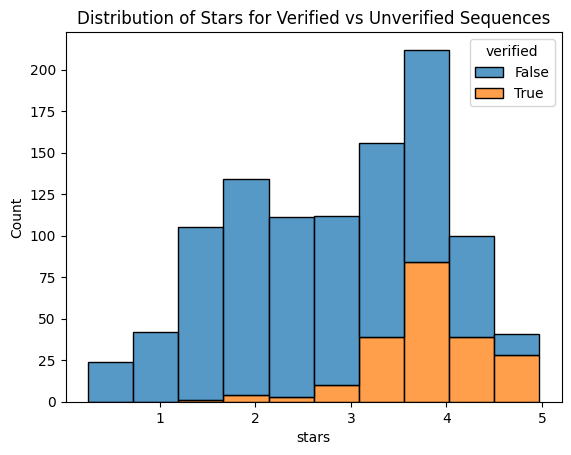

In [13]:
# now make the same graph as above but only for the df_lh_ver dataframe
sns.histplot(data=df_lh_ver, x="stars", hue="verified", multiple="stack", bins=10)
plt.title("Distribution of Stars for Verified vs Unverified Sequences")
plt.show()

# filter for each unique plate and mabid and compare the stars for the verified vs unverified sequences
# create a dictionary that counts how often the verified has a higher score than the unverified vs lower vs same
# then create a dataframe from the dictionary
count_dict = {}
for i in range(0,6):
    count_dict[f"Greater {i}"] = 0
    count_dict[f"Less {i}"] = 0
    count_dict[f"Same {i}"] = 0
    
for plate, mabid in df_lh_ver.groupby(["plate", "entry__mabid"]).groups.keys():
    verified = df_lh_ver[(df_lh_ver["plate"]==plate) & (df_lh_ver["entry__mabid"]==mabid) & (df_lh_ver["verified"]==True)]["stars"].values
    unverified = df_lh_ver[(df_lh_ver["plate"]==plate) & (df_lh_ver["entry__mabid"]==mabid) & (df_lh_ver["verified"]==False)]["stars"].values
    if len(verified)==1 and len(unverified)==1:# and (verified[0]>3 or unverified[0]>3):
        round_ver = [round(i) for i in verified]
        round_unver = [round(i) for i in unverified]
        max_ver = max(round_ver, round_unver)
        max_ver = max_ver[0]
        if verified>unverified:
            count_dict[f"Greater {max_ver}"] += 1
        elif verified<unverified:
            count_dict[f"Less {max_ver}"] += 1
        else:
            count_dict[f"Same {max_ver}"] += 1

df_count = pd.DataFrame.from_dict(count_dict, orient="index", columns=["Count"])
# split the index into another column based on the last empty space
df_count["Category"] = df_count.index.str.split(" ").str[0]
df_count["Stars"] = df_count.index.str.split(" ").str[1]

df_count.pivot(index="Stars", columns="Category", values="Count").plot(kind="bar", stacked=True)
plt.show()

gtlts = df_count.pivot(index="Stars", columns="Category", values="Count")
gtlts["ratio"] = gtlts["Greater"]/gtlts["Less"]
gtlts["ratio"].plot(kind="bar")
plt.title("Ratio of Greater to Less for Verified vs Unverified Sequences")
plt.show()

In [16]:
# generate some summary text for the figures above
print(f"Total number of verified sequences: {len(df_lh_ver[df_lh_ver['verified']==True])}")
print(f"Total number of unverified sequences: {len(df_lh_ver[df_lh_ver['verified']==False])}")
print(f"Total number of verified sequences with a higher star score: {sum(gtlts['Greater'])}")
print(f"Total number of verified sequences with a lower star score: {sum(gtlts['Less'])}")
print(f"Total number of verified sequences with the same star score: {sum(gtlts['Same'])}")
print(f"Ratio across all stars of verified sequences with a higher star score: {sum(gtlts['Greater'])/sum(gtlts['Less'])}")

Total number of verified sequences: 208
Total number of unverified sequences: 829
Total number of verified sequences with a higher star score: 47
Total number of verified sequences with a lower star score: 15
Total number of verified sequences with the same star score: 1
Ratio across all stars of verified sequences with a higher star score: 3.1333333333333333


# Start to run the categorization from the cat_from_mabidlist function and create scores from these results
- 0 CATEGORY: These are ok. No sublone in them
- 1 CATEGORY: These are ok as well. All IDs match.
- 2 CATEGORY: just the subclone
- 3 CATEGORY: likely typos with groups more then 2
- 4 CATEGORY: same as 3 but no requirement for more then 2 entries
- 5 CATEGORY: bad?


### Create scores
- Create the asv stars and add that to the total
- Create the log score and add it to the total

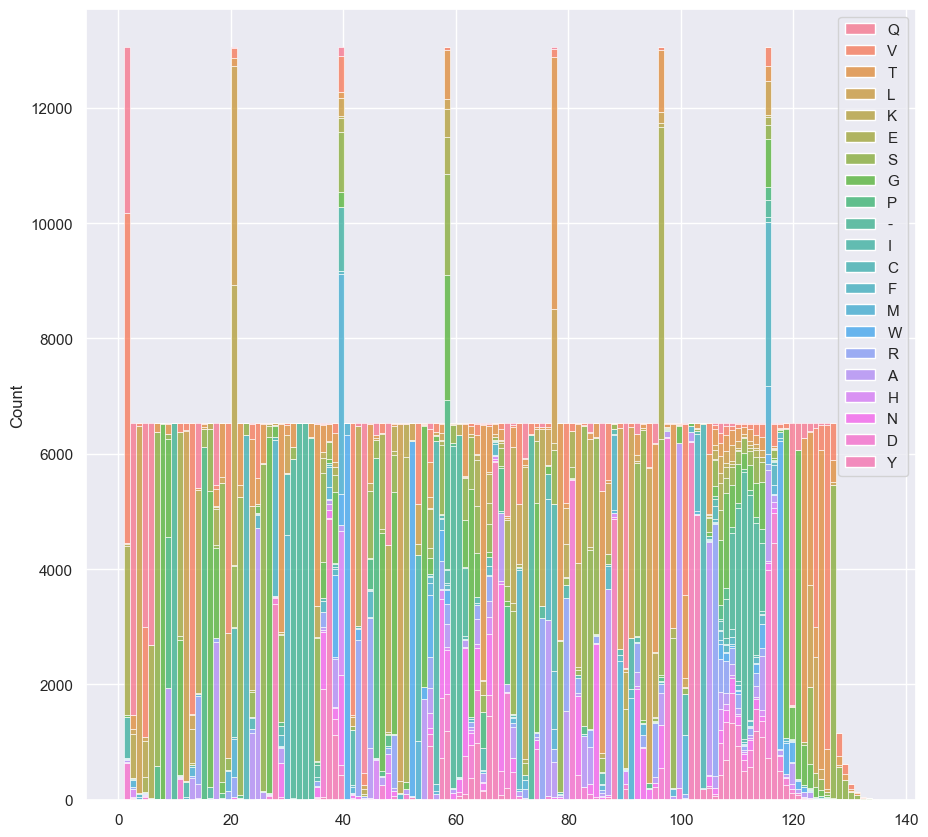

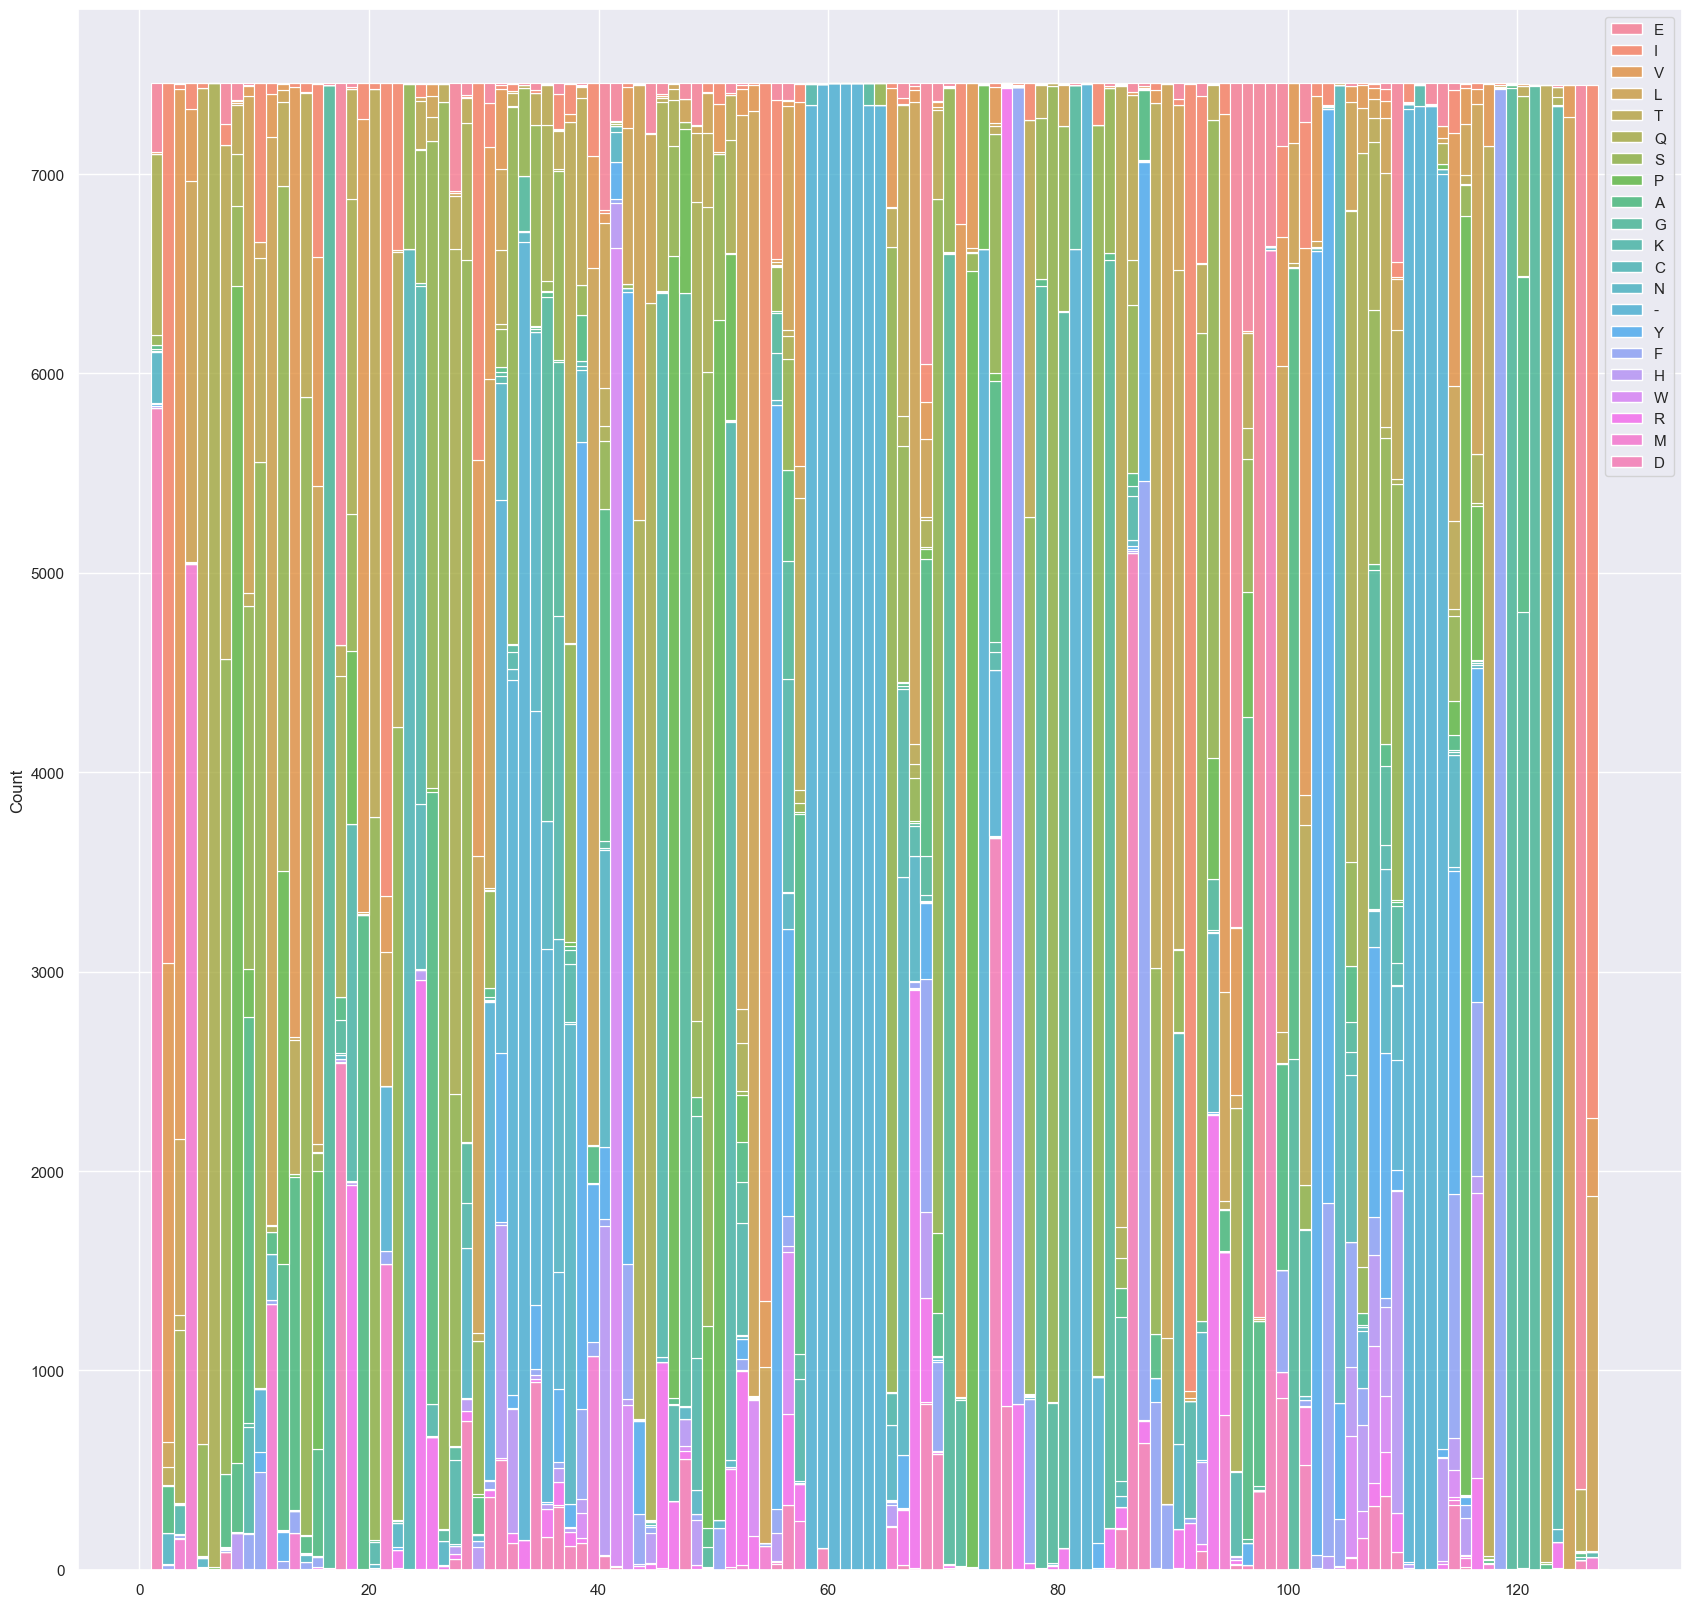

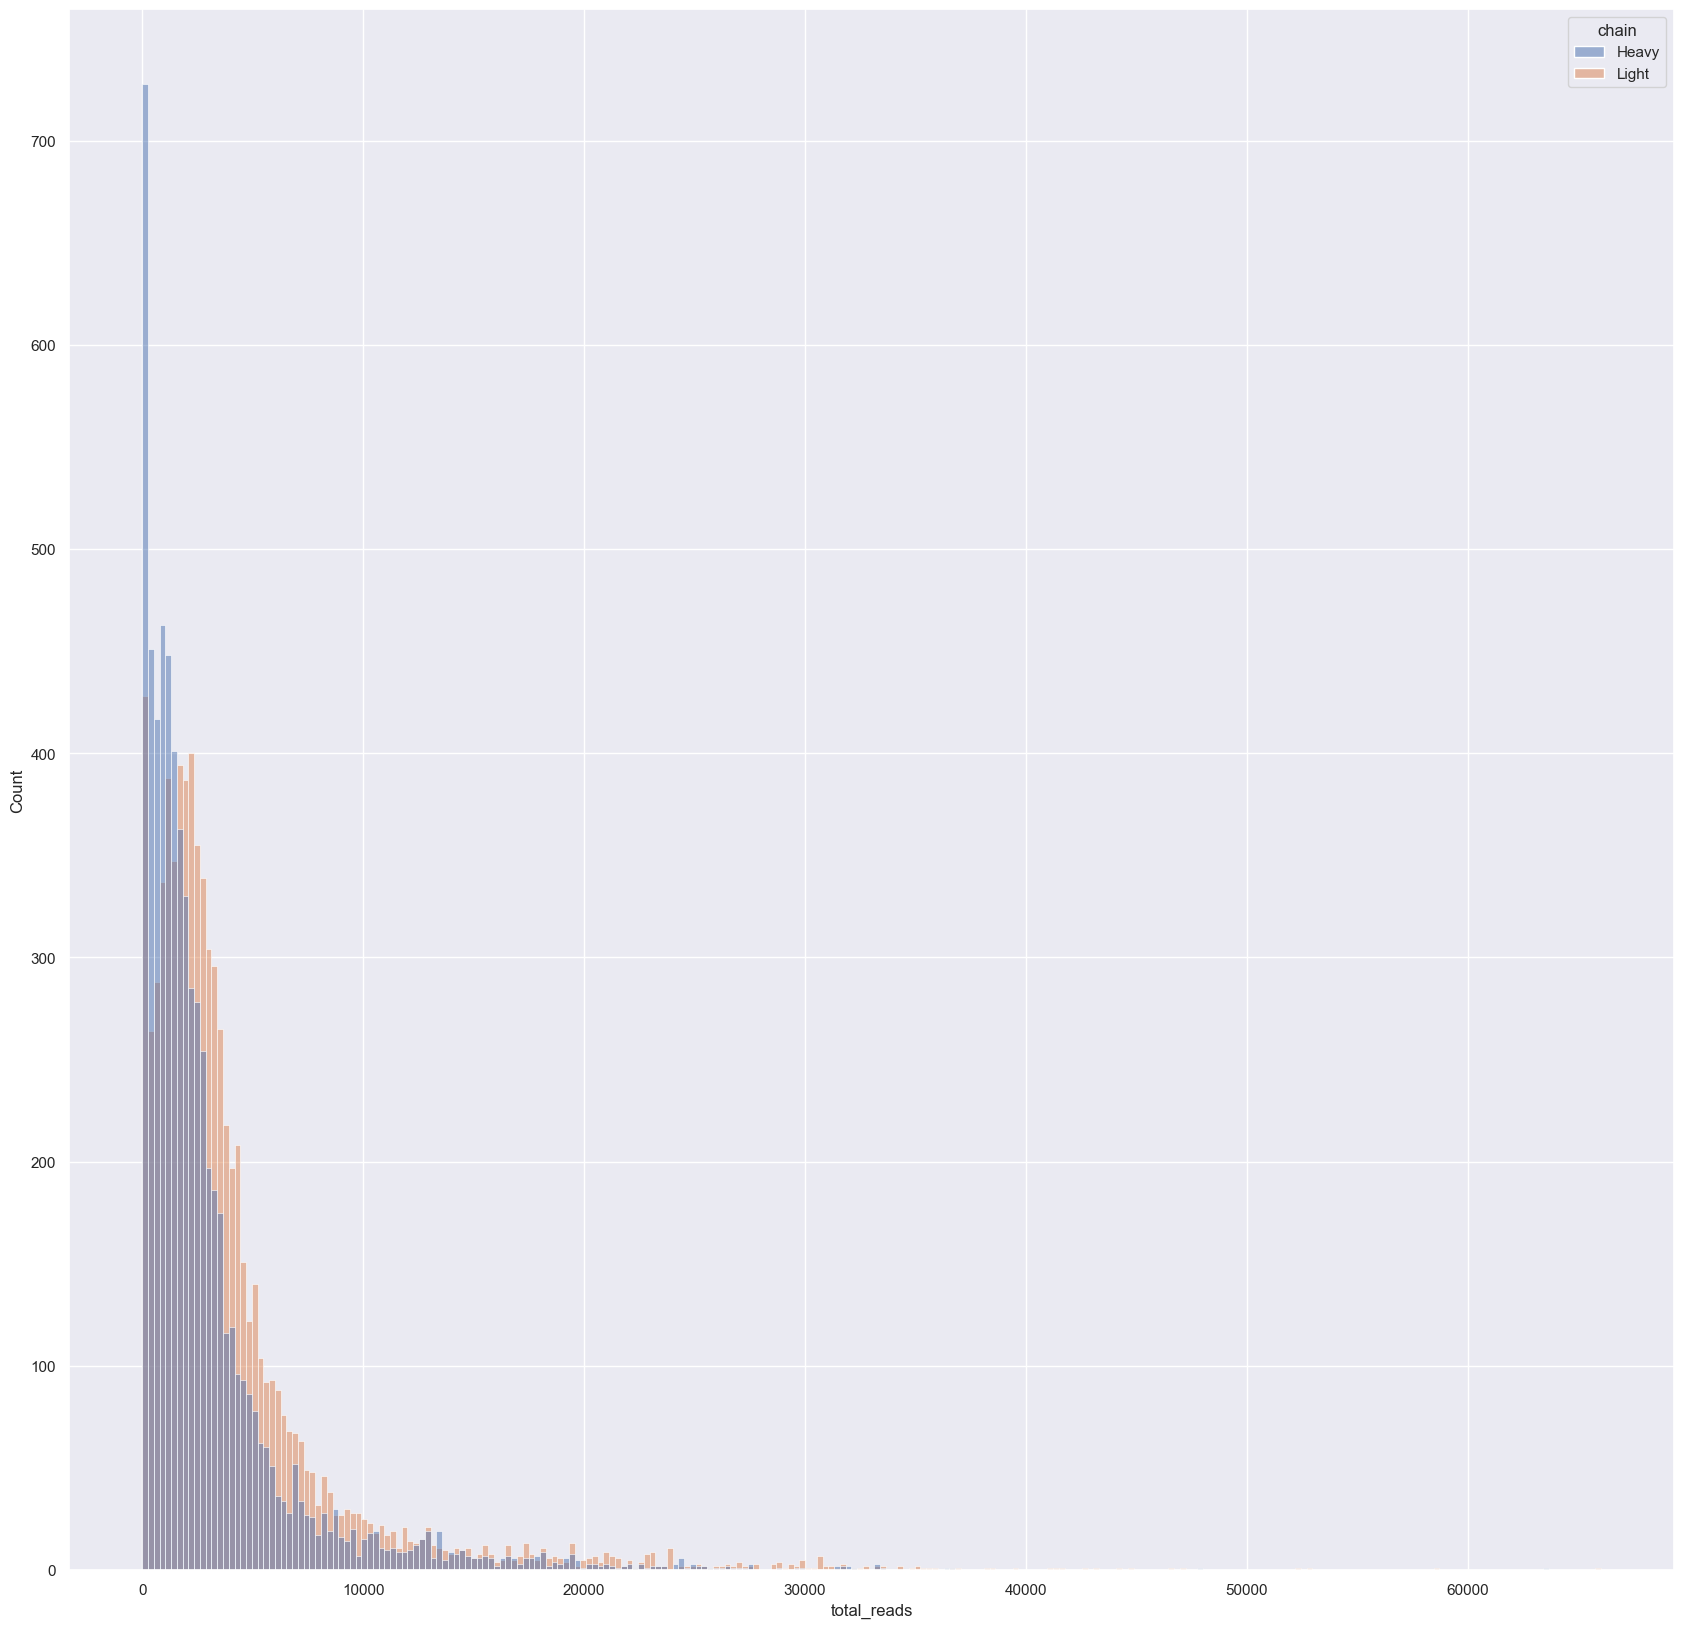

In [210]:
df_lh = get_dflh_dataframe(filter="nonverified")
# get the part before the . in the entry__mabid
df_lh["entry__mabidc"] = [i.split(".")[0] for i in df_lh["entry__mabid"]]
df_lh["pk"] = df_lh["pk"].values.astype("str")

#df_lh["duplication_category_score"] = [int(i[-1]) for i in df_lh["duplication_category"].str.split(",")]
df_lh["asv_pct_score"] = 100*(df_lh["asv_support"]/df_lh["total_reads"])
df_lh["domain"] = df_lh.domain.str.replace(",","")
df_lh["dl"] = [len(i) for i in df_lh["domain"]]
df_lh["log_asv_support"] = np.log10(df_lh["asv_support"])

df_lh_l = df_lh[(df_lh["chain"]=="Light")]# & (df_lh["dl"]==127)]
df_lh_h = df_lh[(df_lh["chain"]=="Heavy")]# & (df_lh["dl"]==128)]

# create a dictionary of the positions and amino acids
pos_dict = {"pos": [], "aa": []}
for index, row in df_lh_l.iterrows():
    for value, pos in zip(*[row["domain"]], range(1, len(row["domain"]))):
        pos_dict['pos'].append(pos)
        pos_dict['aa'].append(value)          

# create a dataframe with the positions and amino acids
pos_dicth = {"pos": [], "aa": []}
for index, row in df_lh_h.iterrows():
    for value, pos in zip(*[row["domain"]], range(1, len(row["domain"]))):
        pos_dicth['pos'].append(pos)
        pos_dicth['aa'].append(value)      


sns.histplot(x=pos_dicth["pos"], hue=pos_dicth["aa"], multiple="stack",bins=127)
sns.set(rc={'figure.figsize':(20.7,20.27)})

plt.show()
sns.histplot(x=pos_dict["pos"], hue=pos_dict["aa"], multiple="stack",bins=127)
sns.set(rc={'figure.figsize':(20.7,20.27)})
plt.show()

df_lh["log_total_reads"] = np.log10(df_lh["total_reads"])
sns.histplot(df_lh, x="total_reads", hue="chain")
plt.show()

In [211]:
# filter out the % ones for now as well as the positive and negative controls
df_lh = df_lh[df_lh['entry__mabid'].str.contains("%")==False]
df_lh = df_lh[df_lh['entry__mabid'].str.contains("positive")==False]
df_lh = df_lh[df_lh['entry__mabid'].str.contains("negative")==False]
mysers = df_lh.groupby("seq")['entry__mabid',].transform(lambda x: ','.join(x))
mypks = df_lh.groupby("seq")['pk'].transform(lambda x: ','.join(x))
mychains = df_lh.groupby("seq")['chain'].transform(lambda x: ','.join(x))
myvecs = df_lh.groupby("seq")['vector_sequence'].transform(lambda x: ','.join(x))
import traceback
new_cats_from_db = pd.DataFrame([cat_from_mabidlist(i) for i in mysers["entry__mabid"]], columns=["cat","parents","sublcones","projects","scores"]).set_index("cat")
new_cats_from_db["pks"] = mypks.values
new_cats_from_db["chains"] = mychains.values
new_cats_from_db["vector_seqs"] = myvecs.values

new_cats_from_db = new_cats_from_db.reset_index()
new_cats_from_db

Traceback (most recent call last):
  File "<ipython-input-174-161da1b6634a>", line 15, in cat_from_mabidlist
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
  File "<ipython-input-174-161da1b6634a>", line 15, in <listcomp>
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-174-161da1b6634a>", line 15, in cat_from_mabidlist
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
  File "<ipython-input-174-161da1b6634a>", line 15, in <listcomp>
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
IndexError: list index out of range
Traceback (most recent call last):
  File "<ipython-input-174-161da1b6634a>", line 15, in cat_from_mabidlist
    subclones = [i.split('/')[1].split('.')[1].replace(' ', '') for i in mab_id_list]
  File "<ipython-input-174-161da1b6634a

cat  \
0      (2, Parents and Projects Match , 100)   
1      (2, Parents and Projects Match , 100)   
2      (2, Parents and Projects Match , 100)   
3      (2, Parents and Projects Match , 100)   
4                                (9, Bad, 0)   
...                                      ...   
13979                            (9, Bad, 0)   
13980                            (9, Bad, 0)   
13981  (2, Parents and Projects Match , 100)   
13982                            (9, Bad, 0)   
13983  (2, Parents and Projects Match , 100)   

                                                 parents  \
0                       [L130/1, L130/1, L130/1, L130/1]   
1                       [L130/1, L130/1, L130/1, L130/1]   
2               [L80/21, L80/21, L80/21, L80/21, L80/21]   
3       [L80/21, L80/21, L80/21, L80/21, L80/21, L80/21]   
4                                     [L106/83, L106/83]   
...                                                  ...   
13979  [K39/25, K39/25, K39/25, K39/25, K39/25, K39/2...   
13980                                           [K58/35]   
13981                           [K58/35, K58/35, K58/35]   
13982                                          [L109/57]   
13983      [L109/57, L109/57, L109/57, L109/57, L109/57]   

                                               sublcones  \
0               [L130/1.1, L130/1.2, L130/1.3, L130/1.5]   
1               [L130/1.1, L130/1.2, L130/1.3, L130/1.5]   
2      [L80/21.1, L80/21.4, L80/21.5, L80/21.3, L80/2...   
3      [L80/21.1, L80/21.4, L80/21.5, L80/21.3, L80/2...   
4                                 [L106/83.1, L106/83.2]   
...                                                  ...   
13979  [K39/25.6, K39/25.1, K39/25.2, K39/25.4, K39/2...   
13980                                         [K58/35.4]   
13981                     [K58/35.2, K58/35.3, K58/35.4]   
13982                                        [L109/57.1]   
13983  [L109/57.2, L109/57.3, L109/57.4, L109/57.5, L...   

                                                projects  \
0                               [L130, L130, L130, L130]   
1                               [L130, L130, L130, L130]   
2                              [L80, L80, L80, L80, L80]   
3                         [L80, L80, L80, L80, L80, L80]   
4                                           [L106, L106]   
...                                                  ...   
13979  [K39, K39, K39, K39, K39, K39, K39, K39, K39, ...   
13980                                              [K58]   
13981                                    [K58, K58, K58]   
13982                                             [L109]   
13983                     [L109, L109, L109, L109, L109]   

                                                  scores  \
0                                   [4.0, 4.0, 4.0, 4.0]   
1                                   [4.0, 4.0, 4.0, 4.0]   
2                              [5.0, 5.0, 5.0, 5.0, 5.0]   
3                         [6.0, 6.0, 6.0, 6.0, 5.5, 5.5]   
4                                             [2.0, 2.0]   
...                                                  ...   
13979  [11.846153846153847, 11.346153846153847, 11.84...   
13980                                              [1.0]   
13981                                    [3.0, 3.0, 3.0]   
13982                                              [1.0]   
13983                          [5.0, 5.0, 5.0, 5.0, 5.0]   

                                                     pks  \
0                                    2,18396,18403,21844   
1                                   90,18495,18504,21949   
2                                 3,5164,5171,5248,17874   
3                           91,5257,5268,5357,5346,17981   
4                                                4,19842   
...                                                  ...   
13979  5262,5271,5279,5288,5291,5297,5305,5316,5336,1...   
13980                                              25883   
13981                                  1

In [212]:
# check the length of all the vector_seqs column valaues (split on ,)
new_cats_from_db["vector_seqs_len"] = [len(i.split(",")) for i in new_cats_from_db["vector_seqs"]]

In [213]:
new_cats_from_db[['cat', 'parents', 'sublcones', 'projects', 'scores', 'pks', 'chains', 'vector_seqs', 'vector_seqs_len']]

cat  \
0      (2, Parents and Projects Match , 100)   
1      (2, Parents and Projects Match , 100)   
2      (2, Parents and Projects Match , 100)   
3      (2, Parents and Projects Match , 100)   
4                                (9, Bad, 0)   
...                                      ...   
13979                            (9, Bad, 0)   
13980                            (9, Bad, 0)   
13981  (2, Parents and Projects Match , 100)   
13982                            (9, Bad, 0)   
13983  (2, Parents and Projects Match , 100)   

                                                 parents  \
0                       [L130/1, L130/1, L130/1, L130/1]   
1                       [L130/1, L130/1, L130/1, L130/1]   
2               [L80/21, L80/21, L80/21, L80/21, L80/21]   
3       [L80/21, L80/21, L80/21, L80/21, L80/21, L80/21]   
4                                     [L106/83, L106/83]   
...                                                  ...   
13979  [K39/25, K39/25, K39/25, K39/25, K39/25, K39/2...   
13980                                           [K58/35]   
13981                           [K58/35, K58/35, K58/35]   
13982                                          [L109/57]   
13983      [L109/57, L109/57, L109/57, L109/57, L109/57]   

                                               sublcones  \
0               [L130/1.1, L130/1.2, L130/1.3, L130/1.5]   
1               [L130/1.1, L130/1.2, L130/1.3, L130/1.5]   
2      [L80/21.1, L80/21.4, L80/21.5, L80/21.3, L80/2...   
3      [L80/21.1, L80/21.4, L80/21.5, L80/21.3, L80/2...   
4                                 [L106/83.1, L106/83.2]   
...                                                  ...   
13979  [K39/25.6, K39/25.1, K39/25.2, K39/25.4, K39/2...   
13980                                         [K58/35.4]   
13981                     [K58/35.2, K58/35.3, K58/35.4]   
13982                                        [L109/57.1]   
13983  [L109/57.2, L109/57.3, L109/57.4, L109/57.5, L...   

                                                projects  \
0                               [L130, L130, L130, L130]   
1                               [L130, L130, L130, L130]   
2                              [L80, L80, L80, L80, L80]   
3                         [L80, L80, L80, L80, L80, L80]   
4                                           [L106, L106]   
...                                                  ...   
13979  [K39, K39, K39, K39, K39, K39, K39, K39, K39, ...   
13980                                              [K58]   
13981                                    [K58, K58, K58]   
13982                                             [L109]   
13983                     [L109, L109, L109, L109, L109]   

                                                  scores  \
0                                   [4.0, 4.0, 4.0, 4.0]   
1                                   [4.0, 4.0, 4.0, 4.0]   
2                              [5.0, 5.0, 5.0, 5.0, 5.0]   
3                         [6.0, 6.0, 6.0, 6.0, 5.5, 5.5]   
4                                             [2.0, 2.0]   
...                                                  ...   
13979  [11.846153846153847, 11.346153846153847, 11.84...   
13980                                              [1.0]   
13981                                    [3.0, 3.0, 3.0]   
13982                                              [1.0]   
13983                          [5.0, 5.0, 5.0, 5.0, 5.0]   

                                                     pks  \
0                                    2,18396,18403,21844   
1                                   90,18495,18504,21949   
2                                 3,5164,5171,5248,17874   
3                           91,5257,5268,5357,5346,17981   
4                                                4,19842   
...                                                  ...   
13979  5262,5271,5279,5288,5291,5297,5305,5316,5336,1...   
13980                                              25883   
13981                                  1

In [214]:
new_cats_from_db[new_cats_from_db["cat"].apply(lambda x: 'Failed Categorization' in x)]


cat  \
8      (-11, Failed Categorization, 0)   
9      (-11, Failed Categorization, 0)   
36     (-11, Failed Categorization, 0)   
37     (-11, Failed Categorization, 0)   
53     (-11, Failed Categorization, 0)   
149    (-11, Failed Categorization, 0)   
865    (-11, Failed Categorization, 0)   
867    (-11, Failed Categorization, 0)   
1113   (-11, Failed Categorization, 0)   
2836   (-11, Failed Categorization, 0)   
2911   (-11, Failed Categorization, 0)   
2912   (-11, Failed Categorization, 0)   
3016   (-11, Failed Categorization, 0)   
3017   (-11, Failed Categorization, 0)   
3281   (-11, Failed Categorization, 0)   
3291   (-11, Failed Categorization, 0)   
3296   (-11, Failed Categorization, 0)   
6058   (-11, Failed Categorization, 0)   
6201   (-11, Failed Categorization, 0)   
6502   (-11, Failed Categorization, 0)   
6595   (-11, Failed Categorization, 0)   
6921   (-11, Failed Categorization, 0)   
7591   (-11, Failed Categorization, 0)   
7592   (-11, Failed Categorization, 0)   
8264   (-11, Failed Categorization, 0)   
8306   (-11, Failed Categorization, 0)   
8347   (-11, Failed Categorization, 0)   
8348   (-11, Failed Categorization, 0)   
8355   (-11, Failed Categorization, 0)   
8356   (-11, Failed Categorization, 0)   
8363   (-11, Failed Categorization, 0)   
8364   (-11, Failed Categorization, 0)   
8372   (-11, Failed Categorization, 0)   
8373   (-11, Failed Categorization, 0)   
8420   (-11, Failed Categorization, 0)   
8466   (-11, Failed Categorization, 0)   
8467   (-11, Failed Categorization, 0)   
8619   (-11, Failed Categorization, 0)   
8620   (-11, Failed Categorization, 0)   
8633   (-11, Failed Categorization, 0)   
8634   (-11, Failed Categorization, 0)   
8647   (-11, Failed Categorization, 0)   
8648   (-11, Failed Categorization, 0)   
8649   (-11, Failed Categorization, 0)   
8650   (-11, Failed Categorization, 0)   
8719   (-11, Failed Categorization, 0)   
8721   (-11, Failed Categorization, 0)   
8735   (-11, Failed Categorization, 0)   
8736   (-11, Failed Categorization, 0)   
8753   (-11, Failed Categorization, 0)   
8755   (-11, Failed Categorization, 0)   
9645   (-11, Failed Categorization, 0)   
9895   (-11, Failed Categorization, 0)   
9896   (-11, Failed Categorization, 0)   
10078  (-11, Failed Categorization, 0)   
12215  (-11, Failed Categorization, 0)   
12216  (-11, Failed Categorization, 0)   
12618  (-11, Failed Categorization, 0)   
12619  (-11, Failed Categorization, 0)   
12629  (-11, Failed Categorization, 0)   
12630  (-11, Failed Categorization, 0)   
12974  (-11, Failed Categorization, 0)   
12979  (-11, Failed Categorization, 0)   
12980  (-11, Failed Categorization, 0)   
13019  (-11, Failed Categorization, 0)   
13020  (-11, Failed Categorization, 0)   
13079  (-11, Failed Categorization, 0)   
13089  (-11, Failed Categorization, 0)   
13123  (-11, Failed Categorization, 0)   
13130  (-11, Failed Categorization, 0)   
13140  (-11, Failed Categorization, 0)   
13462  (-11, Failed Categorization, 0)   
13962  (-11, Failed Categorization, 0)   

                                                 parents  \
8                       [N123/48, N123/48, N123/48, 1F1]   
9              [N123/48, N105/17, N123/48, N123/48, 1F1]   
36                              [62-3G1, 62-3G1, 62-3G1]   
37                              [62-3G1, 62-3G1, 62-3G1]   
53                                       [1D8, 1D8, 1D8]   
149            [N123/48, N105/17, N123/48, N123/48, 1F1]   
865    [L106/73, L106/73, L107/93, L107/93, L107/93, ...   
867    [L106/73, L106/73, L107/93, L107/93, L107/93, ...   
1113   [N106/48, N106/65, N86/20, N106/65, EA7, N106/...   
2836   [N52B/13, N52B/27, N52B/27, N52B/27, N52b/27, ...   
2911                              [N148, N148/5, N148/5]   
2912                              [N148, N148/5, N148/5]   
3016                  [N194/13, EMPTY, N194/13, N194/13]   
3017                  [N194/13, EMPTY, N194/13, N194/13]   
3281   [L106/73, L106/73, 

In [215]:

df_lh["duplication_category"] = ""
df_lh["score"] = 0

df_lh.index = df_lh["pk"]
for index, row in new_cats_from_db.iterrows():
    for score,pk in zip(row["scores"], row["pks"].split(",")):
        df_lh.loc[df_lh.pk == pk, "duplication_category"] = ",".join([str(i) for i in row["cat"]])
        df_lh.loc[df_lh.pk == pk, "score"] = score


# could we have users update this in the future
df_lh["stars"] = 0
df_lh["stars"] += df_lh["asv_pct_score"]/100 * 2
df_lh["logscore"] = np.log(df_lh["score"]+1)
df_lh[df_lh["score"]>5].sort_values("logscore")

seq  chain  \
pk                                                                
6102   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
24946  ACAGTCACTGAAAACATTGACTCTAATCATGGAATGTAACTGGATA...  Heavy   
24941  ACAGTCACTGAAAACATTGACTCTAATCATGGAATGTAACTGGATA...  Heavy   
24915  ACAGTCACTGAAAACATTGACTCTAATCATGGAATGTAACTGGATA...  Heavy   
6093   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
...                                                  ...    ...   
5110   ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   
24910  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light   
24578  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light   
24766  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light   
19336  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light   

        entry__mabid entry__clonality  entry__category     pk  asv_support  \
pk                                                                           
6102      N112B/14.4       Monoclonal              3.0   6102   3024.00000   
24946      N52B/13.3       Monoclonal              2.0  24946  23530.00000   
24941      N52B/13.2       Monoclonal              2.0  24941  26562.00000   
24915      N52B/13.4       Monoclonal              2.0  24915  23643.00000   
6093      N112B/14.3       Monoclonal              3.0   6093   3364.00000   
...              ...              ...              ...    ...          ...   
5110        K20/78.3       Monoclonal              3.0   5110   1243.00000   
24910  N52A/42.1 (+)       Monoclonal              NaN  24910    488.00000   
24578  N52A/42.1 (+)       Monoclonal              NaN  24578    355.00000   
24766  N52A/42.1 (+)       Monoclonal              NaN  24766    385.00000   
19336      N52A/42.2       Monoclonal              3.0  19336    945.00000   

       total_reads                                             domain  \
pk                                                                      
6102          3335  YVVLTQTPLSLPVSLGDQASISCRSNQSLVHS-NGNTYLHWYLQKP...   
24946        24638  EVQLQQSGA-VLARPGASVKMSCKASGYTF----TSYWMHWIKQRP...   
24941        27298  EVQLQQSGA-VLARPGASVKMSCKASGYTF----TSYWMHWIKQRP...   
24915        24897  EVQLQQSGA-VLARPGASVKMSCKASGYTF----TSYWMHWIKQRP...   
6093          3694  YVVLTQTPLSLPVSLGDQASISCRSNQSLVHS-NGNTYLHWYLQKP...   
...            ...                                                ...   
5110          1563  DIVMTQAAFSNPVTLGTSVSISCRSSKSLLHS-DGITYLYWYLQRP...   
24910          595  DIQMTQSPSSLSASLGERVSLTCRASQEI------SGYLSWIQQKP...   
24578          402  DIQMTQSPSSLSASLGERVSLTCRASQEI------SGYLSWIQQKP...   
24766          430  DIQMTQSPSSLSASLGERVSLTCRASQEI------SGYLSWIQQKP...   
19336         1197  DIQMTQSPSSLSASLGERVSLTCRASQEI------SGYLSWIQQKP...   

                   plate                                    vector_sequence  \
pk                                                                            
6102     TRIMMER0039_P23  TATGTTGTGTTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   
24946  TRIMMER00113_P101  GAGGTTCAGCTCCAGCAGTCTGGGGCTGTGCTGGCAAGGCCTGGGG...   
24941  TRIMMER00113_P101  GAGGTTCAGCTCCAGCAGTCTGGGGCTGTGCTGGCAAGGCCTGGGG...   
24915  TRIMMER00113_P101  GAGGTTCAGCTCCAGCAGTCTGGGGCTGTGCTGGCAAGGCCTGGGG...   
6093     TRIMMER0039_P23  TATGTTGTGTTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   
...                  ...                                                ...   
5110     TRIMMER0034_P18  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   
24910  TRIMMER00112_P100  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   
24578   TRIMMER00110_P98  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   
24766   TRIMMER00111_P99  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   
19336    TRIMMER0081_P70  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   

                               stars entry__mabidc  \
pk                                                   
6102   1.813493253373313343328335832      N112B/14   
24946  1.91005763454825878

In [216]:
df_lh_bu = df_lh
baseline3star = np.log(6) # those with 5 we want to have 3 stars
# 0 still has a score of 0
df_lh_bu["dup_final_score"] = (df_lh_bu["logscore"]/baseline3star)*3
df_lh_bu['dup_final_score'] = df_lh_bu['dup_final_score'].clip(upper=3)
df_lh_bu["stars"] = df_lh_bu["stars"].astype(float) + df_lh_bu['dup_final_score'].astype(float)

### Plot the Matching and Duplication Score
- Plot the matching score
- Plot the function used to calculate the matching score

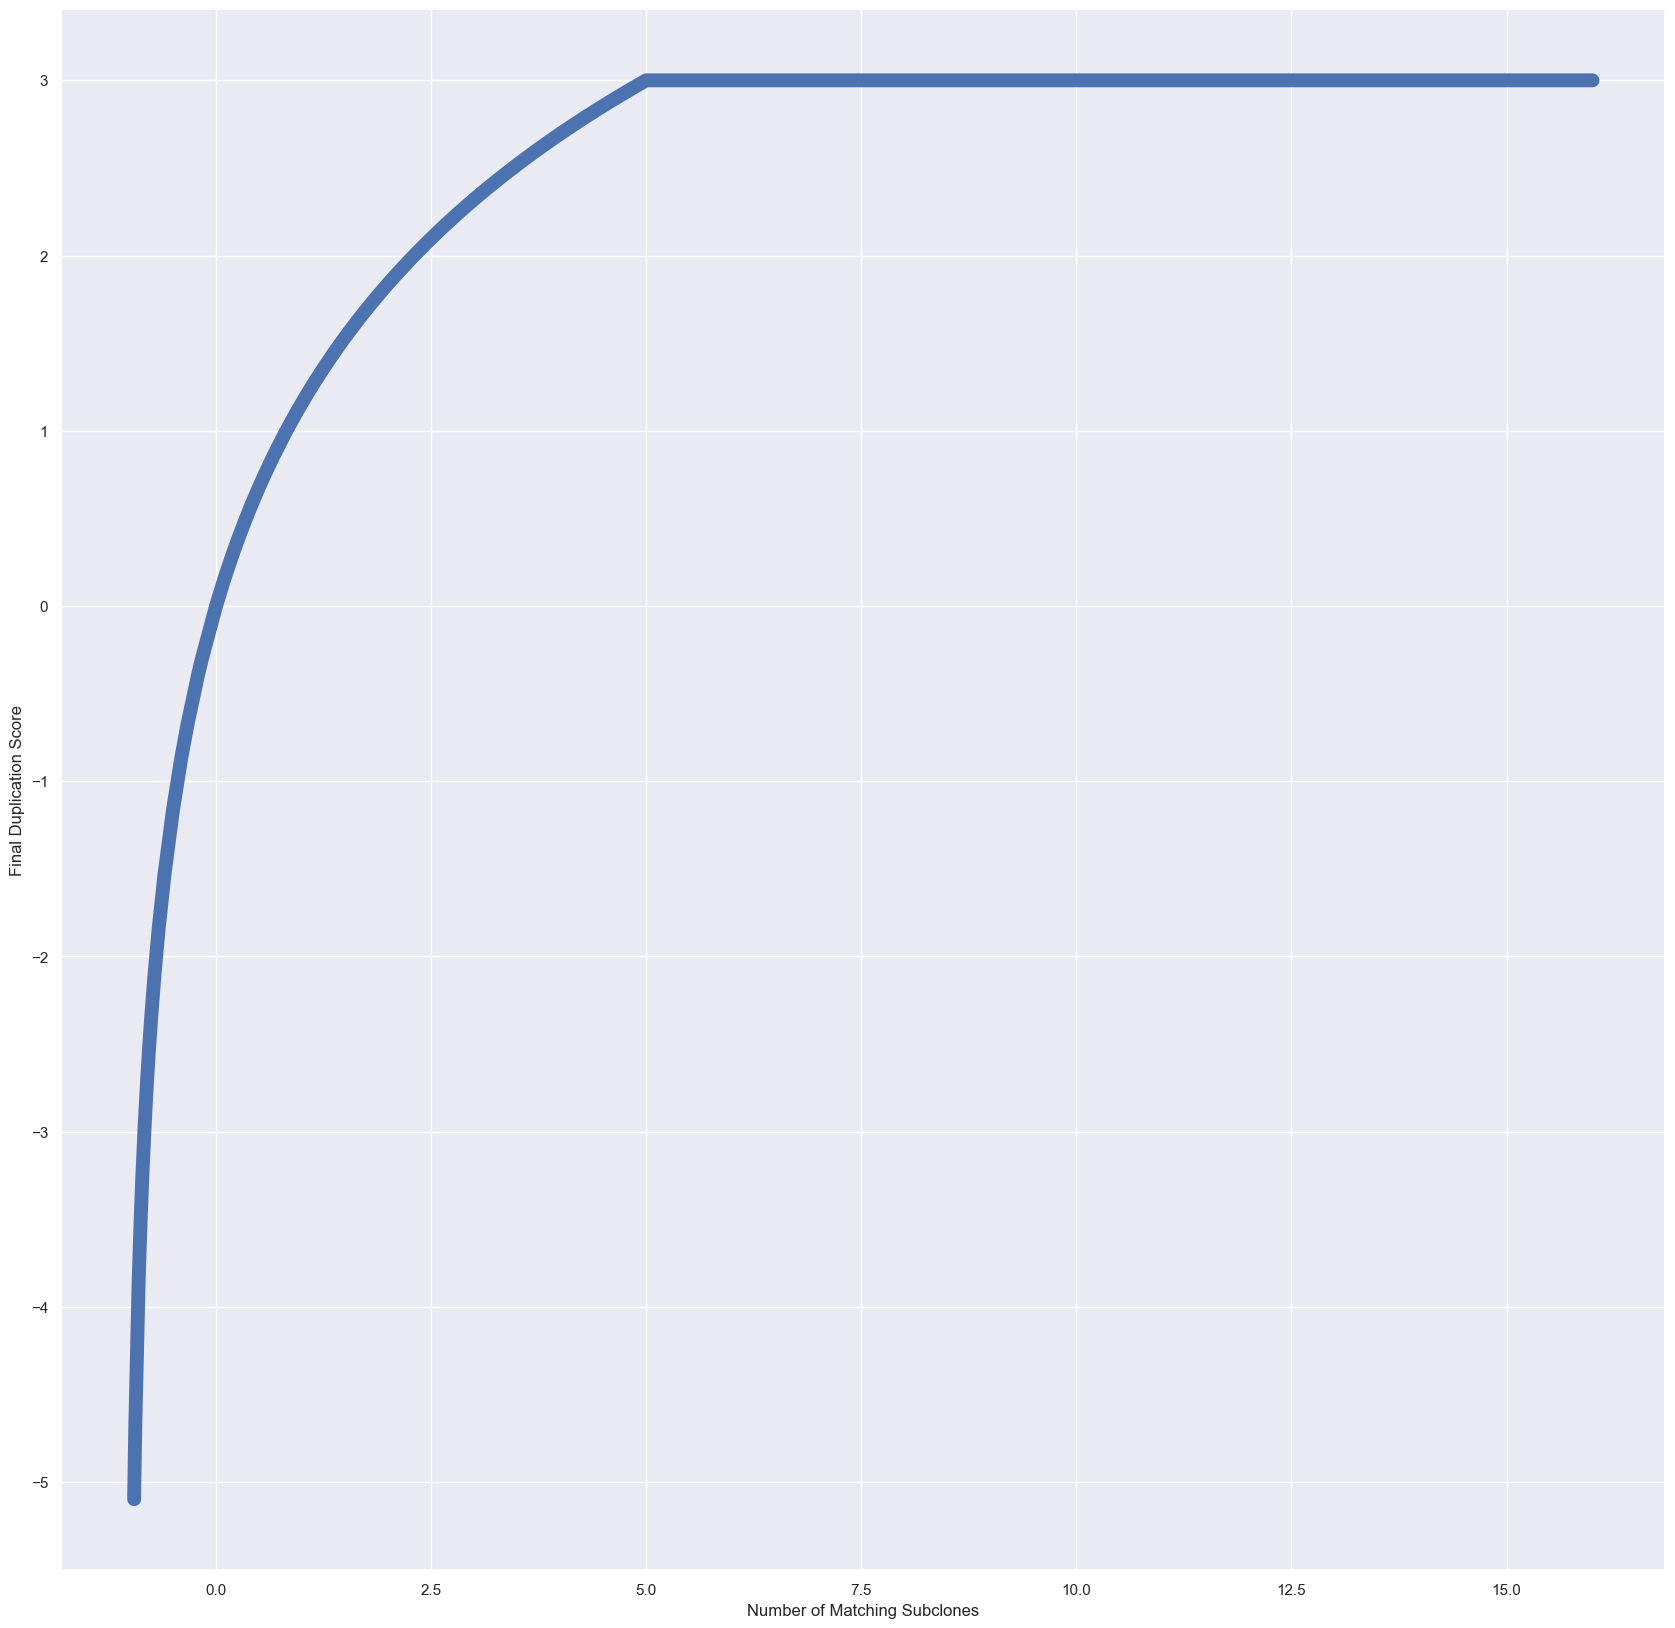

In [217]:
sns.lineplot(data=df_lh_bu, x="score", y="dup_final_score", linewidth=10)
sns.set(rc={'figure.figsize':(5.2,5.27)})

plt.xlabel("Number of Matching Subclones")
plt.ylabel("Final Duplication Score")
sns.set(font_scale=1)

plt.show()

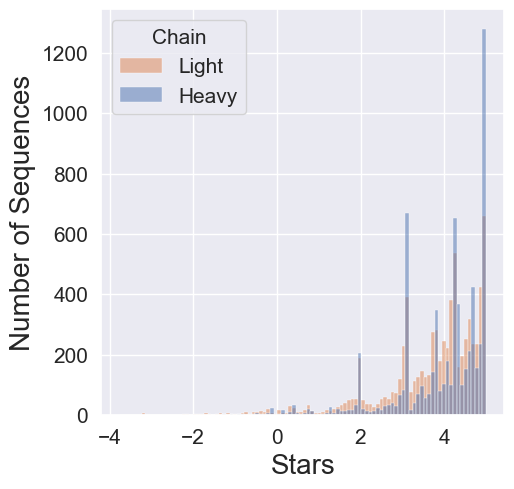

In [218]:
sns.histplot(df_lh_bu[df_lh_bu["stars"]<5.1], x="stars", hue="chain", bins=100)
sns.set(rc={'figure.figsize':(10.7,10.27)})
# set labels and title
plt.xlabel("Stars", size=20)
plt.ylabel("Number of Sequences", size=20)
# change the legend title and labels
plt.legend(title="Chain", fontsize=15, title_fontsize=15, loc='upper left', labels=["Light", "Heavy"])
sns.set(font_scale=1)
# increase x and y tick label size  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# decrease the font
#plt.savefig("jupyter/paper_figures/Stars.png", dpi=300, bbox_inches='tight')

plt.show()


### Important df produced above
- newcatsfromdb : groubpy with scores
- df_lh_gb : scores for all sequences for a given mab based on the df_lh_bu
- df_lh_bu : scores per sequence with pk to update the db based on df_lh from above which is filtered to remove controls and mixtrue (%) samples


In [219]:
df_lh_bu["entry__mabid__full"] = df_lh_bu["entry__mabid"]
df_lh_bu["entry__mabid"] = df_lh_bu["entry__mabid"].str.split(pat=".").str.get(0)
df_lh_bu["entry__category"] = df_lh_bu["entry__category"].astype(str)
df_lh_bu["scorestr"] = df_lh_bu["score"].astype(str)
df_lh_gb = df_lh_bu.groupby(["entry__mabid","chain"]).agg({'seq': 'count', 
                                                           'entry__category': [', '.join], 
                                                           'scorestr': [', '.join]}).reset_index()
df_lh_gb.columns = ["mabid", "chain", "count", "categories in group", "scores"]
df_lh_gb = df_lh_gb.pivot(index='mabid', columns='chain')
#df_lh_gb

In [220]:
def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

# generate a summary of number of sequences >3 and number <3 for the stars column
gt3_unique = df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid"].unique()
# compare the above to a set of the ones that are <3
lt3_unique = df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].unique()
print("Number of unique mabids with stars <3: ", len(lt3_unique))
print("Number of unique mabids with stars >3: ", len(gt3_unique))
print("Number of unique mabids with stars <3 and >3: ", len(set(lt3_unique) & set(gt3_unique)))
print("Number of unique mabids with stars <3 or >3: ", len(set(lt3_unique) | set(gt3_unique)))
print("Number in gt3_unique but not in lt3_unique: ", len(set(gt3_unique) - set(lt3_unique)))
print("Number in lt3_unique but not in gt3_unique: ", len(set(lt3_unique) - set(gt3_unique)))
print("Number of mabids in the in df_lh_bu: ", df_lh_bu["entry__mabid"].nunique())
print("Number of mabids <3 in the in df_lh_bu: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].nunique())

# generate a percentile column for the stars column
df_lh_bu["stars_pct"] = df_lh_bu["stars"].rank(pct=True)

Number of unique mabids with stars <3:  1061
Number of unique mabids with stars >3:  1960
Number of unique mabids with stars <3 and >3:  697
Number of unique mabids with stars <3 or >3:  2324
Number in gt3_unique but not in lt3_unique:  1263
Number in lt3_unique but not in gt3_unique:  364
Number of mabids in the in df_lh_bu:  2324
Number of mabids <3 in the in df_lh_bu:  1061


In [221]:
# iterate trhough each pk and update the stars score in the database
for index, row in df_lh_bu.iterrows():
    object = TrimmerSequence.objects.get(pk=row["pk"])
    object.stars = None
    object.duplicate_stars = None
    object.asv_stars = None
    object.stars_percentile = None
    object.save()
# first lets print some helpful counts for the paper and the sankey
# stars column should be decimal in df_lh_bu
df_lh_bu["stars"] = df_lh_bu["stars"].astype(float)

# iterate trhough each pk and update the stars score in the database
for index, row in df_lh_bu.iterrows():
    
    object = TrimmerSequence.objects.get(pk=row["pk"])
    if not type(row["stars"])== str and row["stars"] and row["stars"] > 5:
        print(object.entry.__dict__)
    # else:    
    #     object.stars = row["stars"]
    object.duplicate_stars = row["dup_final_score"]
    object.asv_stars = row["stars"] - row["dup_final_score"]
    if row["stars"] > 5:
        # set object.stars to the sum of duplicate stars and asv stars with a ceiling of 3 on duplicate and 2 on asv
        object.stars = clamp(object.duplicate_stars, 0, 3) + clamp(object.asv_stars, 0, 2)
    else:    
        object.stars = row["stars"]
    object.stars_percentile = row["stars_pct"]
    object.save()


# iterate through each mabid entry in the database and update the max stars for any given heavy chain and light chain
for index, row in df_lh_bu.iterrows():
    # get the sequence object
    object = TrimmerSequence.objects.get(pk=row["pk"])
    entry_object = object.entry
    # setattr(entry_object, "max_" + "lc" + "stars", 0)
    # setattr(entry_object, "max_" + "hc" + "stars", 0)

    if object.chain == "Heavy":
        string_filler = "hc"
    else:
        string_filler = "lc"

    if not getattr(entry_object, "max_" + string_filler + "stars"):
        setattr(entry_object, "max_" + string_filler + "stars", object.stars)

    elif object.stars > getattr(entry_object, "max_" + string_filler + "stars"):
        setattr(entry_object, "max_" + string_filler + "stars", object.stars)
    
    # elif getattr(entry_object, "max_" + string_filler + "stars") > 5:
    #     setattr(entry_object, "max_" + string_filler + "stars", 5)


    if entry_object.max_lcstars and entry_object.max_hcstars:
        entry_object.maxavgstars = (entry_object.max_hcstars + entry_object.max_lcstars)/2
    entry_object.save()



print("-------------------------------Mabid--------------------------")

print("Number of unique mabids in the database: ", df_lh_bu["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>=3]["entry__mabid"].nunique())
print("Number of unique mabids in the database unique to the <3 group: ", len(set(df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].unique()) - set(df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid"].unique())))

print("---------------------------UniqueSubclone------------------------")
print("Number of unique subclones in the database: ", df_lh_bu["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid__full"].nunique())

print("-----------------------------Sublcone----------------------")
print("Total number of sequences in the database: ", df_lh_bu.shape[0])
print("Total number of sequences in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3].shape[0])
print("Total number of sequences in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3].shape[0])

print("-----------------------------Total----------------------")
print("Total number of sequences in the database: ", df_lh_bu.shape[0])


{'_state': <django.db.models.base.ModelState object at 0x7ff16837e6d0>, 'sample_name': 'P10R_E1', 'id': 491, 'mabid': 'N279A/29.8', 'show_on_web': True, 'category': 2, 'protein_target': 'GluK5/Grik5/KA2 kainate receptor', 'light_count': 1, 'heavy_count': 1, 'clonality': 'Monoclonal', 'max_lcstars': Decimal('4.33'), 'max_hcstars': Decimal('2.00'), 'maxavgstars': Decimal('3.16'), 'contains_verified': False, 'contains_failed': False, 'scfv_verified': None}
-------------------------------Mabid--------------------------
Number of unique mabids in the database:  2324
Number of unique mabids in the database with stars <3:  1061
Number of unique mabids in the database with stars >3:  1960
Number of unique mabids in the database unique to the <3 group:  364
---------------------------UniqueSubclone------------------------
Number of unique subclones in the database:  6326
Number of unique subclones in the database with stars <3:  1445
Number of unique subclones in the database with stars >3:  56

In [222]:
# One off: checking priority based on Year 5 sheet (this is where the most recent sequencing and cloning priority is made)
df_lh = get_dflh_dataframe(filter=False)
# get the part before the . in the entry__mabid
df_lh["entry__mabidc"] = [i.split(".")[0] for i in df_lh["entry__mabid"]]
df_lh["pk"] = df_lh["pk"].values.astype("str")
priority = get_clone_status()
#.reset_index().droplevel('0', axis=1)
# mabid_clean = mabid.split(".")[0].replace("VL1", "").\
#     replace("VH1", "").replace("VL2", "").replace("VH2", "").replace("VL3", "").replace("VH3", "").\
#     replace("(1)", "").replace("(2)", "").replace("(3)", "").replace("(4)", "").replace("(5)", "").\
#     replace("VL", "").replace("VH", "")
## One off: script for looking at the new data/sequencing issues/numbers
df_lhnf = get_dflh_dataframe(filter=False)
np_df_lhnf = df_lhnf[df_lhnf["plate"].str.contains("P101|P102|P103|P104")]
print(np_df_lhnf.value_counts("plate"))
# get the number of unique entries
print(len(np_df_lhnf["entry__mabid"].unique()))
# get just plate if contains P101-104 filter 
np_df_lh = df_lh[df_lh["plate"].str.contains("P101|P102|P103|P104")]
print(np_df_lh.value_counts("plate"))
print(np_df_lh.groupby(["plate", "chain"]).size())
# get the number of unique entries
print(len(np_df_lh["entry__mabid"].unique()))
print(df_lh[df_lh["plate"].str.contains("P101|P102|P103|P104")].value_counts("plate"))


plate
TRIMMER00116_P104    212
TRIMMER00114_P102    178
TRIMMER00115_P103    170
TRIMMER00113_P101    106
dtype: int64
285
plate
TRIMMER00116_P104    212
TRIMMER00114_P102    178
TRIMMER00115_P103    170
TRIMMER00113_P101    106
dtype: int64
plate              chain
TRIMMER00113_P101  Heavy     47
                   Light     59
TRIMMER00114_P102  Heavy     84
                   Light     94
TRIMMER00115_P103  Heavy     82
                   Light     88
TRIMMER00116_P104  Heavy     93
                   Light    119
dtype: int64
285
plate
TRIMMER00116_P104    212
TRIMMER00114_P102    178
TRIMMER00115_P103    170
TRIMMER00113_P101    106
dtype: int64


In [223]:
# turn all decimal.Decimal objects into floats
df_lh = 
df_lh["stars"] = df_lh["stars"].astype(float)
#df_lh["stars_pct"] = df_lh["stars_pct"].astype(float)
#df_lh["asv_pct_score"] = df_lh["asv_pct_score"].astype(float)
#df_lh["log_asv_support"] = df_lh["log_asv_support"].astype(float)
# Fill none value sin the stars column with 0
df_lh["stars"] = df_lh["stars"].fillna(0)
# replace None with 0 in the stars column


seq  chain  \
0      ATCATCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGCAT...  Heavy   
1      AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   
2      ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCTTGCTACT...  Heavy   
3      GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
4      AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy   
...                                                  ...    ...   
16792  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   
16793  ATGAGCACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTACA...  Heavy   
16794  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
16795  GACATAGAGTCTAACCATGGAATGGAACTGGGTCGTTCTCTTCCTC...  Heavy   
16796  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   

                     entry__mabid entry__clonality  entry__category     pk  \
0      positivecontrol1_N263/31.1       Monoclonal              NaN      1   
1      positivecontrol1_N263/31.1       Monoclonal              NaN     89   
2                        L130/1.1       Monoclonal              1.0      2   
3                        L130/1.1       Monoclonal              1.0     90   
4                        L80/21.1       Monoclonal              1.0      3   
...                           ...              ...              ...    ...   
16792                    K39/25.3       Monoclonal              1.0  25911   
16793                    K58/35.4       Monoclonal              2.0  25883   
16794                    K58/35.4       Monoclonal              2.0  25912   
16795                   L109/57.1       Monoclonal              1.0  25884   
16796                   L109/57.1       Monoclonal              1.0  25913   

      asv_support  total_reads  \
0        21.00000           21   
1        87.00000          103   
2       533.00000          536   
3      4228.00000         4353   
4       953.00000          956   
...           ...          ...   
16792  1216.00000         1599   
16793   727.00000          727   
16794  1595.00000         1721   
16795  1713.00000         1720   
16796   629.00000         1301   

                                                  domain           plate  \
0      Q,V,Q,L,K,E,S,G,P,-,G,L,V,A,P,S,Q,S,L,S,I,T,C,...  TRIMMER0002_P2   
1      D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0002_P2   
2      Q,V,T,L,K,E,S,G,P,-,G,I,L,Q,P,S,Q,T,L,S,L,T,C,...  TRIMMER0002_P2   
3      E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0002_P2   
4      E,V,Q,L,Q,Q,S,G,P,-,D,L,V,K,P,G,A,S,V,Q,I,S,C,...  TRIMMER0002_P2   
...                                                  ...             ...   
16792  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...            PRnD   
16793  E,V,Q,L,Q,Q,S,G,A,-,E,L,V,R,P,G,A,L,V,K,L,S,C,...            PRnD   
16794  D,I,V,M,T,Q,S,P,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...            PRnD   
16795  Q,G,Q,M,Q,Q,S,G,A,-,E,L,V,K,P,G,A,S,V,K,L,S,C,...            PRnD   
16796  D,I,V,L,T,Q,S,P,A,S,L,P,V,S,L,G,Q,R,A,T,I,S,C,...            PRnD   

                                         vector_sequence stars  \
0      CAGGTACAGCTGAAGGAGTCAGGACCTGGCCTGGTGGCGCCCTCAC...  None   
1      GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...  None   
2      CAGGTTACTCTGAAAGAGTCTGGCCCTGGGATATTGCAGCCCTCCC...  4.68   
3      GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...  4.64   
4      GAGGTCCAGCTGCAACAGTCTGGACCTGACCTGGTGAAGCCTGGGG...  4.99   
...                                                  ...   ...   
16792  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...  4.52   
16793  GAGGTTCAGCTGCAGCAGTCTGGGGCTGAGCTTGTGAGGCCAGGGG...  3.16   
16794  GACATTGTGATGACCCAGTCTCCAAAATTCATGTCCACATCAGTAG...  4.17   
16795  CAGGGTCAGATGCAGCAGTCTGGAGCTGAGCTGGTGAAGCCTGGGG...  3.15   
16796  GACATTGTGCTGACACAGTCTCCTGCTTCCTTACCTGTATCTCTGG...  3.97   

                  entry__mabidc  
0      positivecontrol1_N263/31  
1      positivecontrol1_N263/31  
2                        L130/1  
3                        L130/1  
4                        L

In [254]:

# filter priority for L127/12 for the clone column
priority = pd.read_csv("jupyter/RmAb cloning status year 5 (1).csv", keep_default_na=False)[["Priority", "Clone", "Status 081623", "Year completed", "R-mAb gBlocks"]]
# remove anything after  the . in the clone column
priority.Clone = [i.split('.')[0] for i in priority.Clone]
# remove the spaces in the clone column
priority.Clone = [i.replace(" ", "") for i in priority.Clone]
# remove the ( and ) in the clone column
priority.Clone = [i.replace("(", "").replace(")","") for i in priority.Clone]
# remove the VL and VH in the clone column
priority.Clone = [i.replace("VH1/VL1", "").replace("VH2/VL1","").replace("VH1/VL2","") for i in priority.Clone]
priority.Clone = [i.replace("VL1", "").replace("VH1","") for i in priority.Clone]
priority.Clone = [i.replace("VL2", "").replace("VH2","") for i in priority.Clone]
priority.Clone = [i.replace("VL3", "").replace("VH3","") for i in priority.Clone]

# TODO this needs to happen later
# get a list of all unique mabids in the database
priority_append = pd.DataFrame()

unique_mabids = list(set(df_lh["entry__mabidc"].values))
# add a new row to the priority dataframe for each unique mabid that does not exist already in the Clone column
for mabid in unique_mabids:
    if mabid not in priority["Clone"].values:
        # also make sure there is a Light and Heavy row for the chain for the mabid in the df_lh dataframe
        if df_lh[df_lh["entry__mabidc"]==mabid]["chain"].values.tolist().count("Light") > 0 and df_lh[df_lh["entry__mabidc"]==mabid]["chain"].values.tolist().count("Heavy") > 0:
            # filter greater than 4 stars for both the Light and Heavy check seperately but also be sure that the seqs come from the same entry__mabid
            if df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["stars"]>4) & (df_lh["chain"]=="Light")].shape[0] > 0 and df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["stars"]>4) & (df_lh["chain"]=="Heavy")].shape[0] > 0:

                # also append the top light chain and heavy chain star score and the average of the two
                # get the highest scoring light chain and heavy chain for the mabid 
                light_chain, heavy_chain = max_light_heavy(df_lh[(df_lh["entry__mabidc"]==mabid)])
                priority = priority.append({"Clone": mabid,
                                            "LightStar": df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["stars"]>4) & (df_lh["chain"]=="Light")]["stars"].max(),
                                            "HeavyStar": df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["stars"]>4) & (df_lh["chain"]=="Heavy")]["stars"].max(),
                                            "AverageStar": np.mean([df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["stars"]>4) & (df_lh["chain"]=="Light")]["stars"].max(), df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["stars"]>4) & (df_lh["chain"]=="Heavy")]["stars"].max()]), 
                                            "LightChain": light_chain, 
                                            "HeavyChain": heavy_chain},
                                            ignore_index=True)
                
            # else if there are light and heavy for one of the entries as in > 0 for both of them like above then create a different priority_append df
            elif df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["chain"]=="Light")].shape[0] > 0 or df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["chain"]=="Heavy")].shape[0] > 0:
                priority_append = priority_append.append({"Clone": mabid,
                                                          "LightStar": df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["chain"]=="Light")]["stars"].max(),
                                                          "HeavyStar": df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["chain"]=="Heavy")]["stars"].max(),
                                                          "AverageStar": np.mean([df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["chain"]=="Light")]["stars"].max(), df_lh[(df_lh["entry__mabidc"]==mabid) & (df_lh["chain"]=="Heavy")]["stars"].max()])}, ignore_index=True)
        
# sort by the average star score
# filter where the VL is not null and the Clone is not nan
priority = priority.rename(columns={"Item Name New": "Addgene Mabid", "Item Name": "Addgene count"})
# same for priority append
priority_append = priority_append.rename(columns={"Item Name New": "Addgene Mabid", "Item Name": "Addgene count"})
priority = priority[priority.Clone.notnull()]
#priority = priority[priority["Status 081623"].isnull()]
#priority = priority.sort_values(by=["AverageStar"], ascending=False)
#priority_append = priority_append.sort_values(by=["AverageStar"], ascending=True)

# Strip the text in between the [] from the item name
#addgene["Item Name"] = [i.split("[")[1].split("]")[0] for i in addgene["Item Name"]]
# read the priority sheet from jupyter/Trimmer-Lab-requests-for-all-items-2023-10-16.xlsx
addgene = pd.read_excel("jupyter/Trimmer-Lab-requests-for-all-items-2023-10-16.xlsx", keep_default_na=False)
addgene["Item Name New"] = ""
for item in addgene["Item Name"]:
    if "[" in item and "]" in item:
        addgene.loc[addgene["Item Name"]==item, "Item Name New"] = item.split("[")[1].split("]")[0]
    else:
        addgene.loc[addgene["Item Name"]==item, "Item Name New"] = item.split(" ")[0]
# groupby and count the Item Name New column

addgene_grouped = addgene.groupby(["Item Name New"]).count().reset_index()
# remove the trailing R from the Item Name New column
addgene_grouped["Item Name New"] = [i.strip("R") for i in addgene_grouped["Item Name New"]]
# only take the first 3 columns
addgene_grouped = addgene_grouped[["Item Name New", "Item Name"]]

# merge this data to th priority 
priority = priority.merge(addgene_grouped, left_on="Clone", right_on="Item Name New", how="left")
priority_append = priority_append.merge(addgene_grouped, left_on="Clone", right_on="Item Name New", how="left")

priority = priority.rename(columns={"Item Name New": "Addgene Mabid", "Item Name": "Addgene count"})
# same for priority append
priority_append = priority_append.rename(columns={"Item Name New": "Addgene Mabid", "Item Name": "Addgene count"})
# output a csv of this
priority.to_csv("jupyter/JimCloningwithStar.csv", index=False)
priority_append.to_csv("jupyter/JimSequencingPriority.csv", index=False)
# check if any of these are in the original priority dataframe as str contains the clone 

                                                     seq  chain entry__mabid  \
3816   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N135/22.1   
13741  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N135/22.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3816        Monoclonal              2.0   4256  1010.00000         1045   
13741       Monoclonal              2.0  22882   567.00000          624   

                                                  domain            plate  \
3816   D,V,V,V,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   
13741  D,V,V,V,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry__mabidc  
3816   GATGTTGTGGTGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.35       N135/22  
13741  GATGTTGTGGTGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.24       N135/22  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5015  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    K65A/41.1   
8759  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    K65A/41.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
5015       Monoclonal              2.0   5486   1141.00000         1374   
8759       Monoclonal              2.0  17927  10485.00000        12375   

                                                 domain            plate  \
5015  D,I,K,M,T,Q,S,P,S,S,M,S,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0036_P20   
8759  D,I,K,M,T,Q,S,P,S,S,M,S,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0074_PS2   

                                        vector_sequence  stars entry__mabidc  
5015  GACATCAAGATGACCCAGTCTCCATCTTCCATGTCTGCATCTCTAG...   3.20       K65A/41  
8759  GACATCAAGATGACCCAGTCTCCATCTTCCATGTCTGCATCTCTAG...   3.23       K65A/41  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7526  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N350/75.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7526       Monoclonal              2.0  8003  2587.00000         2684   

                                                 domain            plate  \
7526  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7526  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   3.09       N350/75  
                                                    seq  chain entry__mabid  \
7525  AGGCAGAGAACTTTAGCCCTGTCTTCTTTTTTAGTGTTCAGCACTG...  Heavy    N350/75.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7525       Monoclonal              2.0  7909  3224.00000         3228   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9249   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N223A/42.1   
14213  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N223A/42.4   
14231  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N223A/42.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9249        Monoclonal              2.0  18381  2472.00000         2580   
14213       Monoclonal              2.0  23375  3975.00000         4119   
14231       Monoclonal              2.0  23384  3124.00000         3258   

                                                  domain             plate  \
9249   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0077_P32R   
14213  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   
14231  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7289   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L116/86.1   
8429   GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    L116/86.1   
11619  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L116/86.4   
11620  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L116/86.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7289        Monoclonal              2.0   7697   8382.00000         8599   
8429        Monoclonal              2.0  17561  12753.00000        14107   
11619       Monoclonal              2.0  20681  21318.00000        25239   
11620       Monoclonal              2.0  20690  43022.00000        44347   

                                                  domain             plate  \
7289   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...   TRIMMER0047_P40   
8429   S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIM

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12278  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light   L122/130.1   
12315  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light   L122/130.3   
12316  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light   L122/130.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12278       Monoclonal              2.0  21480   558.00000         1189   
12315       Monoclonal              2.0  21502  1741.00000         2124   
12316       Monoclonal              2.0  21503   238.00000         2124   

                                                  domain            plate  \
12278  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0092_P81   
12315  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0092_P81   
12316  Q,I,L,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,S,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13873  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L49/20.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13873       Monoclonal              2.0  23030  2431.00000         2710   

                                                  domain             plate  \
13873  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars entry__mabidc  
13873  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.63        L49/20  
                                                     seq  chain entry__mabid  \
13872  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     L49/20.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13872       Monoclonal              2.0  22932  3084.00000         3180   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1391  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    N425/22.1   
1392  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N425/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1391       Monoclonal              2.0  1423  1170.00000         1496   
1392       Monoclonal              2.0  1424   261.00000         1496   

                                                 domain            plate  \
1391  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0013_P28   
1392  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1391  GACATCCAGATGAACCAGTCTCCATCCAGTCTGTCTGCATCCCTTG...   1.56       N425/22  
1392  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   0.35       N425/22  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3767   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N116/10.1   
13185  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N116/10.4   
13186  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N116/10.4   
13531  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N116/10.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3767        Monoclonal              2.0   4228  10532.00000        14247   
13185       Monoclonal              2.0  22346   3581.00000         5085   
13186       Monoclonal              2.0  22347   1112.00000         5085   
13531       Monoclonal              2.0  22687   2890.00000         4237   

                                                  domain            plate  \
3767   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,L,S,C,...  TRIMMER0028_P34   
13185  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMME

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6948   AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K91/20.1   
12570  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K91/20.3   
12584  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K91/20.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6948        Monoclonal              2.0   7433  1772.00000         1853   
12570       Monoclonal              2.0  21739  2714.00000         2878   
12584       Monoclonal              2.0  21749  3453.00000         3702   

                                                  domain            plate  \
6948   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0046_P39   
12570  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   
12584  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15922  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N372C/54.2   
15991  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N372C/54.4   
15992  GCTGACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCC...  Light   N372C/54.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15922       Monoclonal              2.0  25114  13622.00000        14623   
15991       Monoclonal              2.0  25151   9242.00000        10151   
15992       Monoclonal              2.0  25152    218.00000        10151   

                                                  domain              plate  \
15922  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00114_P102   
15991  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00114_P102   
15992  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER00114_P102   

                                         vector_sequence 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1377   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N291B/64.1   
15654  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light   N291B/64.4   
15655  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N291B/64.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1377        Monoclonal              2.0   1416  2393.00000         2490   
15654       Monoclonal              2.0  24820   624.00000         1310   
15655       Monoclonal              2.0  24821   292.00000         1310   

                                                  domain              plate  \
1377   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...    TRIMMER0013_P28   
15654  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00112_P100   
15655  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8037  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      D3/71.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8037       Monoclonal              2.0  17176   422.00000          439   

                                                 domain            plate  \
8037  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0067_P66   

                                        vector_sequence  stars entry__mabidc  
8037  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08         D3/71  
                                                    seq  chain entry__mabid  \
8036  AAGGGAGTGACCAGTTAGTCTTAAGGCACCATTGAGCCCAAGTCTT...  Heavy      D3/71.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8036       Monoclonal              2.0  17068   883.00000          898   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7581  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N285/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7581       Monoclonal              2.0  8033  1021.00000         1488   

                                                 domain            plate  \
7581  D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7581  GACATTGTGCTGACCCAATCTCCAGTTTCTTTGGCTGTGTCTCTGG...  -0.73       N285/20  
                                                    seq  chain entry__mabid  \
7580  ACAAGTGTGCAGACATGGACAGGCTTACTTCTTCATTCCTGCTGCT...  Heavy    N285/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7580       Monoclonal              2.0  7934  1715.00000         1733   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3959  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N326D/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3959       Monoclonal              2.0  4407  4294.00000         4374   

                                                 domain            plate  \
3959  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3959  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.12      N326D/14  
                                                    seq  chain entry__mabid  \
3958  GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...  Heavy   N326D/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3958       Monoclonal              2.0  4317  3409.00000         3424   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3527  GAATTACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N368/71.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3527       Monoclonal              2.0  4002  3250.00000         3304   

                                                 domain            plate  \
3527  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3527  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.13       N368/71  
                                                    seq  chain entry__mabid  \
3526  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy    N368/71.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3526       Monoclonal              2.0  3929  2069.00000         2083   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1362   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   L126/113.3   
11584  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   L126/113.5   
13474  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   L126/113.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1362        Monoclonal              2.0   1407  2903.00000         2981   
11584       Monoclonal              2.0  20729  9753.00000        10171   
13474       Monoclonal              2.0  22653  2041.00000         2184   

                                                  domain            plate  \
1362   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0013_P28   
11584  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0088_P77   
13474  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1842   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      N45/4.1   
11697  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      N45/4.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1842        Monoclonal              2.0   1915   2288.00000         2335   
11697       Monoclonal              2.0  20874  11644.00000        12014   

                                                  domain            plate  \
1842   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0016_P31   
11697  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1842   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.12         N45/4  
11697  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.10         N45/4  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15139  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N260/17.2.4   
15224  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N260/17.5   
15234  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N260/17.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15139       Monoclonal              2.0  24325  4240.00000         4546   
15224       Monoclonal              2.0  24378  2178.00000         2302   
15234       Monoclonal              2.0  24383  3287.00000         3416   

                                                  domain             plate  \
15139  D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00109_P97   
15224  D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00109_P97   
15234  D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00109_P97   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
5260  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     N38/34.3   
5261  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     N38/34.3   
5321  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N38/34.2   
8693  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N38/34.2   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
5260       Monoclonal              2.0   5712   3673.00000         4732   
5261       Monoclonal              2.0   5713   1005.00000         4732   
5321       Monoclonal              2.0   5704   3260.00000         3330   
8693       Monoclonal              2.0  17889  24669.00000        27017   

                                                 domain            plate  \
5260  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0037_P21   
5261  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0037_P21   


<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3792   GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N129/26.1   
13174  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N129/26.4   
13175  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N129/26.4   
13219  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N129/26.5   
13220  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N129/26.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3792        Monoclonal              2.0   4244   996.00000         1122   
13174       Monoclonal              2.0  22338  1005.00000         1358   
13175       Monoclonal              2.0  22339    65.00000         1358   
13219       Monoclonal              2.0  22366  2037.00000         3055   
13220       Monoclonal              2.0  22367   217.00000         3055   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7626  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N361/78.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7626       Monoclonal              2.0  8059   195.00000          202   

                                                 domain            plate  \
7626  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7626  AACATTATGATGACACAGTCGCCATCATCTCTGGCTGTGTCTGCAG...   3.09       N361/78  
                                                    seq  chain entry__mabid  \
7625  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N361/78.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7625       Monoclonal              2.0  7956   227.00000          233   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4178  AGACAGGCAGGTGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N230/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4178       Monoclonal              2.0  4612  3034.00000         3268   

                                                 domain            plate  \
4178  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,A,M,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4178  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   1.86       N230/17  
                                                    seq  chain entry__mabid  \
4177  GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...  Heavy    N230/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4177       Monoclonal              2.0  4510  2624.00000         2653   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8321   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      K9/80.1   
8322   ACTACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAG...  Light      K9/80.1   
11719  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      K9/80.5   
11720  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      K9/80.5   
13150  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light      K9/80.4   
13200  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      K9/80.6   
13201  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light      K9/80.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8321        Monoclonal              2.0  17450    27.00000           89   
8322        Monoclonal              2.0  17451    24.00000           89   
11719       Monoclonal              2.0  20884    53.00000           84   
11720       Monoclonal              2.0  20885    24.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16478  AGAAACAACTGTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTC...  Light    N195A/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16478       Monoclonal              6.0  25595     1.00000            1   

                                                  domain    plate  \
16478  E,T,T,V,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16478          Failed    2.0     N195A/16R  
                                                     seq  chain entry__mabid  \
16477  GCCTCAAGCAGTCAGGTGCAGCTGGTGGAGTCTGGGGCTGAGGTGG...  Heavy    N195A/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16477       Monoclonal              6.0  25594     1.00000            1   

                                                  domain    plate  \
16477  Q,V,Q,L,V,E,S,G,A,-,E,V,V,R,P,G,T,S,V,K,M,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1537  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light    N270/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1537       Monoclonal              2.0  1587  1322.00000         1352   

                                                 domain            plate  \
1537  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1537  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...   3.12       N270/32  
                                                    seq  chain entry__mabid  \
1536  AACCTATGATCAGTATCCTCTCAACAGTCCCTGAACACACTGACTC...  Heavy    N270/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1536       Monoclonal              2.0  1490  1631.00000         1642   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1660   AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light   N206A/26.1   
14817  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light   N206A/26.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1660        Monoclonal              2.0   1730  1046.00000         1074   
14817       Monoclonal              2.0  23999  3919.00000         4031   

                                                  domain             plate  \
1660   D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...   TRIMMER0015_P30   
14817  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars entry__mabidc  
1660   GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTATGTCAGTAG...   0.00      N206A/26  
14817  GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTATGTCAGTAG...   1.94      N206A/26  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1809   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     N26/10.1   
14606  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N26/10.4   
14635  AATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTTCTG...  Light     N26/10.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1809        Monoclonal              2.0   1805    58.00000           78   
14606       Monoclonal              2.0  23808  6133.00000         6598   
14635       Monoclonal              2.0  23823   145.00000          165   

                                                  domain             plate  \
1809   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...   TRIMMER0015_P30   
14606  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00106_P94   
14635  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6876  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light     N33/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6876       Monoclonal              2.0  7322  1707.00000         1774   

                                                 domain            plate  \
6876  D,I,V,M,T,Q,S,P,S,S,L,A,V,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6876  GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTGTGTCAGTAG...   3.09        N33/26  
                                                    seq  chain entry__mabid  \
6875  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     N33/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6875       Monoclonal              2.0  7215  2558.00000         2567   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11382  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N492/79.1   
11399  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N492/79.2   
11416  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N492/79.3   
11435  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N492/79.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
11382       Monoclonal              2.0  20557   384.00000          408   
11399       Monoclonal              2.0  20565  1245.00000         1347   
11416       Monoclonal              2.0  20573   927.00000         1002   
11435       Monoclonal              2.0  20583  1361.00000         1488   

                                                  domain            plate  \
11382  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0087_P76   
11399  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0087

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6868   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N476/56.1   
6869   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N476/56.1   
6870   AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N476/56.1   
11659  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N476/56.2   
11660  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N476/56.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6868        Monoclonal              2.0   7316   1264.00000         2100   
6869        Monoclonal              2.0   7317    718.00000         2100   
6870        Monoclonal              2.0   7318     43.00000         2100   
11659       Monoclonal              2.0  20854  15597.00000        19110   
11660       Monoclonal              2.0  20855    757.00000        19110   

                                                  domain      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16588  AGACATCCTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTA...  Light     N419/78R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16588       Monoclonal              6.0  25705     1.00000            1   

                                                  domain    plate  \
16588  D,I,L,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16588          Failed    2.0      N419/78R  
                                                     seq  chain entry__mabid  \
16587  TCACGAGTCCAGCCTCAAGCAGTGAGGTGAAGCTGCAGCAGTCTGG...  Heavy     N419/78R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16587       Monoclonal              6.0  25704     1.00000            1   

                                                  domain    plate  \
16587  E,V,K,L,Q,Q,S,G,P,-,E,L,V,K,P,G,A,S,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1656   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N209C/77.1   
14681  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N209C/77.5   
14695  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N209C/77.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1656        Monoclonal              2.0   1728  1273.00000         1294   
14681       Monoclonal              2.0  23848   513.00000          543   
14695       Monoclonal              2.0  23855  2169.00000         2251   

                                                  domain             plate  \
1656   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0015_P30   
14681  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00106_P94   
14695  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1329  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L126/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1329       Monoclonal              2.0  1385  2514.00000         2582   

                                                 domain            plate  \
1329  D,V,V,M,T,Q,T,P,L,S,L,P,V,R,L,G,D,Q,A,S,-,I,S,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1329  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCCGTCTTG...   1.95       L126/49  
                                                    seq  chain entry__mabid  \
1328  AGGTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy    L126/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1328       Monoclonal              2.0  1301  1970.00000         1980   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10349  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10350  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                            entry__mabid entry__clonality  \
10349  P65RNA_60% N486/76.1 + 10% L120/12.1 + 30% L71...       Monoclonal   
10350  P65RNA_60% N486/76.1 + 10% L120/12.1 + 30% L71...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10349              NaN  19549  3846.00000         4950   
10350              NaN  19550   698.00000         4950   

                                                  domain            plate  \
10349  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   
10350  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10349  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   
10350  CAAGTTGTTCTCACCCAG

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1860  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N74/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1860       Monoclonal              2.0  1927   550.00000          584   

                                                 domain            plate  \
1860  D,V,V,M,T,Q,T,P,P,T,L,S,V,T,V,G,Q,A,A,S,I,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1860  GATGTTGTGATGACCCAGACTCCACCCACTTTGTCGGTTACCGTTG...   3.04        N74/16  
                                                    seq  chain entry__mabid  \
1859  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy     N74/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1859       Monoclonal              2.0  1834   346.00000          353   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6840  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N385/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6840       Monoclonal              2.0  7300  2864.00000         2981   

                                                 domain            plate  \
6840  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6840  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N385/16  
                                                    seq  chain entry__mabid  \
6839  ACAGCATATGATCAGTGTCCTCTCCAAAGTCCTTGAACATAGACTC...  Heavy    N385/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6839       Monoclonal              2.0  7198  3510.00000         3605   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16592  AGACATTGTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTT...  Light     N230/21R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16592       Monoclonal              6.0  25709     1.00000            1   

                                                  domain    plate  \
16592  D,I,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16592          Failed    2.0      N230/21R  
                                                     seq  chain entry__mabid  \
16591  GCCTCAAGCAGTCAGGTCGAGCTGCAGCAGTCTGGAACTGAGCTGG...  Heavy     N230/21R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16591       Monoclonal              6.0  25708     1.00000            1   

                                                  domain    plate  \
16591  Q,V,E,L,Q,Q,S,G,T,-,E,L,V,R,P,G,T,S,A,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3806   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N133/8.1   
11712  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N133/8.5   
11713  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N133/8.5   
13191  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N133/8.4   
13192  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N133/8.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3806        Monoclonal              2.0   4251  1393.00000         1416   
11712       Monoclonal              2.0  20880  2561.00000         4079   
11713       Monoclonal              2.0  20881   631.00000         4079   
13191       Monoclonal              2.0  22349  1556.00000         3293   
13192       Monoclonal              2.0  22350  1540.00000         3293   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16570  AGATATTGTGATAACCCAAACTCCACTCTCCCTGCCTGTCAGTCTT...  Light       N2/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16570       Monoclonal              6.0  25687     1.00000            1   

                                                  domain    plate  \
16570  D,I,V,I,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16570          Failed    2.0        N2/16R  
                                                     seq  chain entry__mabid  \
16569  GCCTCAAGCAGTCAGGTCGAGCTGCAGCAGTCTGGACCTGAGCTGA...  Heavy       N2/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16569       Monoclonal              6.0  25686     1.00000            1   

                                                  domain    plate  \
16569  Q,V,E,L,Q,Q,S,G,P,-,E,L,K,K,P,G,E,T,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8402  GTACTTATGAGAAGAGAAGTAATTAGCCAGGGAACAAAATTCAAAT...  Light      L9/11.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8402       Monoclonal              2.0  17544    76.00000          540   

                                                 domain             plate  \
8402  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8402  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   1.44         L9/11  
                                                    seq  chain entry__mabid  \
8401  CATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTTGGGG...  Heavy      L9/11.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8401       Monoclonal              2.0  17494    11.00000           66   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7093   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      K50/5.1   
12511  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      K50/5.4   
12632  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      K50/5.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7093        Monoclonal              2.0   7531  1162.00000         1203   
12511       Monoclonal              2.0  21707  2463.00000         2573   
12632       Monoclonal              2.0  21778  3976.00000         4161   

                                                  domain            plate  \
7093   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0046_P39   
12511  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0093_P82   
12632  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3905   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N176A/24.1   
15524  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N176A/24.5   
15539  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N176A/24.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3905        Monoclonal              2.0   4376  1991.00000         2388   
15524       Monoclonal              2.0  24698  6277.00000         7980   
15539       Monoclonal              2.0  24707  5329.00000         6634   

                                                  domain             plate  \
3905   N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0029_P35   
15524  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00111_P99   
15539  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7035  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     K59/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7035       Monoclonal              2.0  7487  1693.00000         1727   

                                                 domain            plate  \
7035  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7035  CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   3.12        K59/14  
                                                    seq  chain entry__mabid  \
7034  TCTGACAGAGGAGCACAGCCCAGGATTCCCAGGTCCTCCCATTCAG...  Heavy     K59/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7034       Monoclonal              2.0  7396  2614.00000         2715   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15843  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light  N448/30.2.1   
15844  GAAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCC...  Light  N448/30.2.1   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15843       Monoclonal              2.0  24988  15431.00000        25157   
15844       Monoclonal              2.0  24989   9231.00000        25157   

                                                  domain              plate  \
15843  D,I,Q,M,T,Q,S,P,A,S,Q,S,A,S,L,G,E,S,V,T,I,T,C,...  TRIMMER00113_P101   
15844  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15843  GACATTCAGATGACCCAGTCTCCTGCCTCCCAGTCTGCATCTCTGG...   0.55       N448/30  
15844  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCTACAG...   1.89       N448/30  
                                                    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7854   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N443/15.1   
11793  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N443/15.3   
11835  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N443/15.2   
11836  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N443/15.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7854        Monoclonal              2.0  16947  7848.00000         8254   
11793       Monoclonal              2.0  20924  9333.00000         9830   
11835       Monoclonal              2.0  21033  2585.00000         3318   
11836       Monoclonal              2.0  21034   464.00000         3318   

                                                  domain            plate  \
7854   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0066_P65   
11793  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0089

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1340   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      L6/47.1   
12789  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L6/47.4   
12791  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L6/47.3   
12998  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L6/47.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1340        Monoclonal              2.0   1393  2068.00000         2149   
12789       Monoclonal              2.0  21951  2297.00000         2557   
12791       Monoclonal              2.0  21952   993.00000         1076   
12998       Monoclonal              2.0  22150  2331.00000         2475   

                                                  domain            plate  \
1340   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0013_P28   
12789  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0094

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8338  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N206/15.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8338       Monoclonal              2.0  17465   205.00000          660   

                                                 domain             plate  \
8338  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,I,T,I,T,C,...  TRIMMER0069_PDP1   

                                        vector_sequence  stars entry__mabidc  
8338  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   1.78       N206/15  
                                                    seq  chain entry__mabid  \
8337  ATCATCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGCAT...  Heavy    N206/15.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8337       Monoclonal              2.0  17429   607.00000          651   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7356   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N162A/21.1   
15561  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light  N162A/21.17   
15563  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N162A/21.18   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7356        Monoclonal              2.0   7820  5962.00000         6173   
15561       Monoclonal              2.0  24718  2539.00000         2622   
15563       Monoclonal              2.0  24719  1335.00000         1397   

                                                  domain             plate  \
7356   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0048_P41   
15561  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,R,V,T,M,T,C,...  TRIMMER00111_P99   
15563  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7319  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light   N172A/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7319       Monoclonal              2.0  7797  4341.00000         4438   

                                                 domain            plate  \
7319  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7319  AACATTATGATGACACAGTCGCCATCATCTCTGGCTGTGTCTGCAG...  -1.18      N172A/10  
                                                    seq  chain entry__mabid  \
7318  GACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGTGAT...  Heavy   N172A/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7318       Monoclonal              2.0  7719  5096.00000         5158   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16710  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      L51/82R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16710       Monoclonal              6.0  25827     1.00000            1   

                                                  domain    plate  \
16710  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16710  GACATCGTGATGACCCAGTCTCCATCCTCCCTGGCTATGTCAGTAG...    2.0       L51/82R  
                                                     seq  chain entry__mabid  \
16709  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      L51/82R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16709       Monoclonal              6.0  25826     1.00000            1   

                                                  domain    plate  \
16709  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16638  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K74/71R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16638       Monoclonal              6.0  25755     1.00000            1   

                                                  domain    plate  \
16638  E,N,V,L,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16638  GAAAATGTGCTGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    2.0       K74/71R  
                                                     seq  chain entry__mabid  \
16637  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K74/71R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16637       Monoclonal              6.0  25754     1.00000            1   

                                                  domain    plate  \
16637  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16682  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       L8/15R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16682       Monoclonal              6.0  25799     1.00000            1   

                                                  domain    plate  \
16682  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16682  GATATTGTGATGACCCAGGCTGCATTCTCCAATCCAGTCACTCTTG...    2.0        L8/15R  
                                                     seq  chain entry__mabid  \
16681  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       L8/15R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16681       Monoclonal              6.0  25798     1.00000            1   

                                                  domain    plate  \
16681  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
13384  GCTGTAATCAGCATCACACTGAGAACACACAGACATGAGTGTGCCC...  Light   
13385  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light   

        entry__mabid entry__clonality  entry__category     pk asv_support  \
13384  N156/13.1.1.4       Monoclonal              2.0  22529  2689.00000   
13385  N156/13.1.1.4       Monoclonal              2.0  22530    76.00000   

       total_reads                                             domain  \
13384         2845  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...   
13385         2845  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...   

                 plate                                    vector_sequence  \
13384  TRIMMER0097_P86  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   
13385  TRIMMER0097_P86  TGGTTCCAGCAGAAGCCAGGATCCTCCTCCAAACTCTGGATTTATA...   

       stars entry__mabidc  
13384   0.73       N156/13  
13385   0.00       N156/13  
                           

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3800  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      N91/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3800       Monoclonal              2.0  4248  1265.00000         1290   

                                                 domain            plate  \
3800  N,V,V,M,T,Q,T,P,K,F,L,L,I,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3800  AATGTTGTGATGACCCAGACTCCCAAATTCCTGCTTATATCAGCAG...   3.12         N91/2  
                                                    seq  chain entry__mabid  \
3799  ACTAGTGTGCAGATATGGACAGGCTTACTTCCTCATTCCTGCTGCT...  Heavy      N91/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3799       Monoclonal              2.0  4147  1411.00000         1419   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12400  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    L122/88.2   
12401  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L122/88.2   
12475  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    L122/88.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12400       Monoclonal              2.0  21554   195.00000          435   
12401       Monoclonal              2.0  21555    89.00000          435   
12475       Monoclonal              2.0  21549  2352.00000         2495   

                                                  domain            plate  \
12400  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0092_P81   
12401  Y,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0092_P81   
12475  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7365  ACTGATCAGTCTCCTCAGGCTGTCGCCTCAGGTTGCCTCCTCAAAA...  Light     N139/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7365       Monoclonal              2.0  7828  3108.00000         3246   

                                                 domain            plate  \
7365  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7365  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08        N139/1  
                                                    seq  chain entry__mabid  \
7364  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy     N139/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7364       Monoclonal              2.0  7741  1625.00000         1661   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7748  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N475A/5.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7748       Monoclonal              2.0  16852  4437.00000         4629   

                                                 domain            plate  \
7748  N,V,L,M,T,Q,T,P,L,S,L,P,V,N,L,G,D,Q,A,S,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7748  AATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAATCTTG...   3.08       N475A/5  
                                                    seq  chain entry__mabid  \
7747  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N475A/5.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7747       Monoclonal              2.0  16705  3158.00000         3188   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4155  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N201/3.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4155       Monoclonal              2.0  4597  2924.00000         3042   

                                                 domain            plate  \
4155  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4155  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08        N201/3  
                                                    seq  chain entry__mabid  \
4154  AACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGACCC...  Heavy     N201/3.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4154       Monoclonal              2.0  4500   650.00000          656   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1984  AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...  Light    N298/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1984       Monoclonal              2.0  1994  1013.00000         1035   

                                                 domain            plate  \
1984  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1984  GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.12       N298/14  
                                                    seq  chain entry__mabid  \
1983  ATGATCAGTGTCCTCTCTACACAGTCCCTGACAACACTGACTCTAA...  Heavy    N298/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1983       Monoclonal              2.0  1892  1937.00000         1958   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1767  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N468/39.1   
1768  AAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTCC...  Light    N468/39.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1767       Monoclonal              2.0  1788  1158.00000         1256   
1768       Monoclonal              2.0  1789    46.00000         1256   

                                                 domain            plate  \
1767  D,I,V,M,S,Q,C,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0015_P30   
1768  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1767  GACATTGTGATGTCACAGTGTCCATCCTCCCTAGCTGTGTCAGTTG...    3.0       N468/39  
1768  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...    0.0       N468/39  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7448  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N217/19.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7448       Monoclonal              2.0  7877  1502.00000         1566   

                                                 domain            plate  \
7448  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7448  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N217/19  
                                                    seq  chain entry__mabid  \
7447  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy  N217/19.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7447       Monoclonal              2.0  7779  1283.00000         1302   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8450  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N188/6.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8450       Monoclonal              2.0  17574  19002.00000        19872   

                                                 domain             plate  \
8450  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8450  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.07        N188/6  
                                                    seq  chain entry__mabid  \
8449  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy     N188/6.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8449       Monoclonal              2.0  17515  20504.00000        20670   

                                                 domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4184   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N201/31.1   
14207  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N201/31.4   
14225  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N201/31.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4184        Monoclonal              2.0   4616  4093.00000         4234   
14207       Monoclonal              2.0  23372  3056.00000         3213   
14225       Monoclonal              2.0  23381  3190.00000         3550   

                                                  domain             plate  \
4184   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0030_P36   
14207  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00103_P91   
14225  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12313  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light   L122/120.1   
12332  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   L122/120.2   
12333  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   L122/120.2   
12432  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   L122/120.3   
12433  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   L122/120.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12313       Monoclonal              2.0  21501    81.00000         1486   
12332       Monoclonal              2.0  21512   789.00000         1564   
12333       Monoclonal              2.0  21513   483.00000         1564   
12432       Monoclonal              2.0  21571   880.00000         1919   
12433       Monoclonal              2.0  21572   692.00000         1919   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16530  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      N70/28R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16530       Monoclonal              6.0  25647     1.00000            1   

                                                  domain    plate  \
16530  D,I,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16530  GATATTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       N70/28R  
                                                     seq  chain entry__mabid  \
16529  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      N70/28R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16529       Monoclonal              6.0  25646     1.00000            1   

                                                  domain    plate  \
16529  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3741  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N88/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3741       Monoclonal              2.0  4214  2590.00000         2657   

                                                 domain            plate  \
3741  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3741  GACGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.11        N88/10  
                                                    seq  chain entry__mabid  \
3740  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy     N88/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3740       Monoclonal              2.0  4119  1189.00000         1195   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6895   GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N442/32.2   
11649  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N442/32.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6895        Monoclonal              2.0   7332   1566.00000         1623   
11649       Monoclonal              2.0  20849  29617.00000        35928   

                                                  domain            plate  \
6895   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0045_P38   
11649  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
6895   GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.77       N442/32  
11649  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.49       N442/32  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8306   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L6/43.2   
11562  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L6/43.3   
11624  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L6/43.5   
11625  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light      L6/43.5   
12824  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L6/43.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
8306        Monoclonal              2.0  17439  11279.00000        11659   
11562       Monoclonal              2.0  20716   3510.00000         3665   
11624       Monoclonal              2.0  20701  11931.00000        22504   
11625       Monoclonal              2.0  20702   9023.00000        22504   
12824       Monoclonal              2.0  21973   1241.00000         1344   

                                                  domain      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8471   AGTTTCCCCAGTCCCCTGAATTTTCCATTTCCTCAGAGTGATGTCC...  Light    N292/15.1   
14673  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N292/15.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8471        Monoclonal              2.0  17575    13.00000          384   
14673       Monoclonal              2.0  23844  6858.00000         7427   

                                                  domain             plate  \
8471   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,Y,...  TRIMMER0070_PDP2   
14673  Q,I,V,L,T,Q,S,P,A,I,M,S,T,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
8471   GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   0.00       N292/15  
14673  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTACATCTCCAG...  -0.25       N292/15  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7550  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N381/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7550       Monoclonal              2.0  8015  1717.00000         2121   

                                                 domain            plate  \
7550  D,I,I,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7550  GACATTATTCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.78        N381/6  
                                                    seq  chain entry__mabid  \
7549  GACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGTGAT...  Heavy     N381/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7549       Monoclonal              2.0  7921  2349.00000         2385   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11941  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N52b/27.4   
11942  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N52b/27.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
11941       Monoclonal              3.0  21104   854.00000          942   
11942       Monoclonal              3.0  21105    21.00000          942   

                                                  domain            plate  \
11941  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0090_P79   
11942  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Q,K,V,T,M,R,C,...  TRIMMER0090_P79   

                                         vector_sequence  stars entry__mabidc  
11941  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTAACCATTG...   1.81       N52b/27  
11942  CAGAAGGTCACTATGCGCTGCAAGTCCAGTCAGAGCCTTTTAAATA...   0.00       N52b/27  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7874   GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    L128/89.1   
13830  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    L128/89.3   
13877  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L128/89.4   
13878  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    L128/89.4   
13886  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L128/89.5   
13887  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    L128/89.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7874        Monoclonal              2.0  16968  1789.00000         2011   
13830       Monoclonal              2.0  23002  1057.00000         1166   
13877       Monoclonal              2.0  23032   814.00000          984   
13878       Monoclonal              2.0  23033    87.00000          984   
13886       Monoclonal              2.0  23037  1605.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16012  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N490/75.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
16012       Monoclonal              2.0  25162  10504.00000        11022   

                                                  domain              plate  \
16012  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00114_P102   

                                         vector_sequence  stars entry__mabidc  
16012  GATGTCTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   1.23       N490/75  
                                                     seq  chain entry__mabid  \
16010  AAGATCACAGTAGTCTCTTCAGTCACAGGAGTACACCGGGCATTGA...  Heavy    N490/75.2   
16011  AGGCAGAGAACTTTAGCCCTGTCTTCCTTTTTGTGTTCAGCACTGA...  Heavy    N490/75.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16010       Monoclonal              2.0  25074  571

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15937  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N386/51.3   
16078  TCCCCAGTCCCCTGAATTTTCCATTTCCTCAGAGTGATGTCCAAAA...  Light    N386/51.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15937       Monoclonal              2.0  25121  8944.00000         9379   
16078       Monoclonal              2.0  25188    10.00000          442   

                                                  domain              plate  \
15937  D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER00114_P102   
16078  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,Y,...  TRIMMER00114_P102   

                                         vector_sequence  stars entry__mabidc  
15937  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...   3.07       N386/51  
16078  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   0.00       N386/51  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8325  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N440/13.1   
8326  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N440/13.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8325       Monoclonal              2.0  17455   458.00000         2372   
8326       Monoclonal              2.0  17456   436.00000         2372   

                                                 domain             plate  \
8325  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0069_PDP1   
8326  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0069_PDP1   

                                        vector_sequence  stars entry__mabidc  
8325  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   1.55       N440/13  
8326  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   1.53       N440/13  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1783   AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...  Light    N245/21.1   
15203  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N245/21.5   
15240  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N245/21.7   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1783        Monoclonal              2.0   1797   510.00000          524   
15203       Monoclonal              2.0  24365   660.00000          708   
15240       Monoclonal              2.0  24386  1916.00000         2041   

                                                  domain             plate  \
1783   D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...   TRIMMER0015_P30   
15203  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER00109_P97   
15240  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13091  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light      N17/1.5   
13097  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light      N17/1.4   
13099  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light      N17/1.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13091       Monoclonal              2.0  22289  1410.00000         1514   
13097       Monoclonal              2.0  22292   775.00000          847   
13099       Monoclonal              2.0  22293  1189.00000         1263   

                                                  domain            plate  \
13091  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0096_P85   
13097  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0096_P85   
13099  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1869   GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    L58A/13.1   
13794  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    L58A/13.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1869        Monoclonal              2.0   1931  1993.00000         2026   
13794       Monoclonal              2.0  22977  2018.00000         2198   

                                                  domain             plate  \
1869   S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...   TRIMMER0016_P31   
13794  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars entry__mabidc  
1869   AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...   3.81       L58A/13  
13794  AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...   3.68       L58A/13  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15940  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light     N17/28.2   
16001  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light     N17/28.1   
16002  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light     N17/28.1   
16003  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light     N17/28.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15940       Monoclonal              2.0  25122  6575.00000         6898   
16001       Monoclonal              2.0  25156  3364.00000         5190   
16002       Monoclonal              2.0  25157  1115.00000         5190   
16003       Monoclonal              2.0  25158   409.00000         5190   

                                                  domain              plate  \
15940  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER00114_P102   
16001  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3716   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N103/38.1   
11540  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N103/38.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3716        Monoclonal              2.0   4199   2168.00000         2197   
11540       Monoclonal              2.0  20700  21487.00000        22965   

                                                  domain            plate  \
3716   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,V,G,E,K,V,T,M,T,C,...  TRIMMER0028_P34   
11540  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,V,G,E,K,V,T,M,T,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
3716   GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGTAG...   3.39       N103/38  
11540  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGTAG...   3.29       N103/38  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7610   AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light  N265/38.1.1   
14612  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light  N265/38.1.5   
14685  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light  N265/38.1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7610        Monoclonal              2.0   8049  3259.00000         3356   
14612       Monoclonal              2.0  23811  3762.00000         4522   
14685       Monoclonal              2.0  23850  1676.00000         1740   

                                                  domain             plate  \
7610   D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...   TRIMMER0049_P42   
14612  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00106_P94   
14685  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4164   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N230/7.3   
14806  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N230/7.5   
14956  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N230/7.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4164        Monoclonal              2.0   4602  4629.00000         4765   
14806       Monoclonal              2.0  23994  6428.00000         6724   
14956       Monoclonal              2.0  24018  7410.00000         7669   

                                                  domain             plate  \
4164   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0030_P36   
14806  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00107_P95   
14956  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6654  ATCCTCTCTTCTCGCTCTCAGAGATGGGGACAGACACACTCCTGCT...  Light    N343/94.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6654       Monoclonal              2.0  7107  1394.00000         2095   

                                                 domain            plate  \
6654  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6654  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.49       N343/94  
                                                    seq  chain entry__mabid  \
6653  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGGGC...  Heavy    N343/94.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6653       Monoclonal              2.0  7013  2751.00000         2759   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6805  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N364/71.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6805       Monoclonal              2.0  7281  7897.00000         8721   

                                                 domain            plate  \
6805  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6805  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.97       N364/71  
                                                    seq  chain entry__mabid  \
6804  GACAGAGGCACCAAACTGTGGACTCACAAGTCTTTCCCTTCAGTGA...  Heavy    N364/71.4   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
6804       Monoclonal              2.0  7181  12711.00000        12762   

                                                 domain            plate  \

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7743   AGACAGGCAGGGAAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N481/85.1   
11754  AGACAGGCAGGGAAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N481/85.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7743        Monoclonal              2.0  16850  2084.00000         2255   
11754       Monoclonal              2.0  20903  8812.00000        17654   

                                                  domain            plate  \
7743   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,L,S,C,...  TRIMMER0066_P65   
11754  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,L,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
7743   GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.69       N481/85  
11754  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.84       N481/85  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3757  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N76/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3757       Monoclonal              2.0  4223   820.00000          840   

                                                 domain            plate  \
3757  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3757  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.11         N76/7  
                                                    seq  chain entry__mabid  \
3756  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGAGAAGGAGGTGTAG...  Heavy      N76/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3756       Monoclonal              2.0  4126   379.00000          387   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6567  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N323A/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6567       Monoclonal              2.0  7056  4119.00000         4345   

                                                 domain            plate  \
6567  D,V,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6567  GATGTTGTGTTGACCCAAACTCCTCTCTCCCTGCCTGTCAGTCTTG...   3.06      N323A/52  
                                                    seq  chain entry__mabid  \
6566  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy   N323A/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6566       Monoclonal              2.0  6970  3747.00000         3790   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7528  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   N412A/10.1   
7529  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light   N412A/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7528       Monoclonal              2.0  8004  2392.00000         3373   
7529       Monoclonal              2.0  8005   465.00000         3373   

                                                 domain            plate  \
7528  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   
7529  D,I,V,M,T,Q,S,H,K,F,M,S,K,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7528  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.58      N412A/10  
7529  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCAAATCAGTAG...   0.00      N412A/10  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3836  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light     N148.5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3836       Monoclonal              2.0  4266  2553.00000         2603   

                                                 domain            plate  \
3836  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,V,G,E,K,V,T,I,R,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3836  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCTGTAG...   1.96          N148  
                                                    seq  chain entry__mabid  \
3835  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy     N148.5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3835       Monoclonal              2.0  4165  2143.00000         2155   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16642  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K89/34R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16642       Monoclonal              6.0  25759     1.00000            1   

                                                  domain    plate  \
16642  D,I,Q,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16642  GATATCCAGATGACACAGACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       K89/34R  
                                                     seq  chain entry__mabid  \
16641  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K89/34R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16641       Monoclonal              6.0  25758     1.00000            1   

                                                  domain    plate  \
16641  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3593  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N482/89.1   
3594  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N482/89.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3593       Monoclonal              2.0  4044  3665.00000         4159   
3594       Monoclonal              2.0  4045   129.00000         4159   

                                                 domain            plate  \
3593  D,I,V,M,S,Q,S,P,S,S,L,V,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0027_P33   
3594  -,-,-,-,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,I,S,-,I,S,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3593  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGTTGTGTCAGTTG...   2.92       N482/89  
3594  ACTCAGGCTGCACCCTCTGTACCTGTCACTCCTGGAGAGTCAATAT...   0.00       N482/89  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7825  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N435/61.1   
7826  AATTAGCTAGCTACCTGAATTCAAATACAACATGGATTTTCAGGTG...  Light    N435/61.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7825       Monoclonal              2.0  16923  5254.00000         7543   
7826       Monoclonal              2.0  16924  1900.00000         7543   

                                                 domain            plate  \
7825  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0066_P65   
7826  E,N,V,L,T,Q,S,P,A,I,M,A,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7825  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   0.71       N435/61  
7826  GAAAATGTGCTGACCCAGTCTCCAGCAATCATGGCTGCATCTCCAG...   1.66       N435/61  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7006  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     K63/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7006       Monoclonal              2.0  7470  4519.00000         4789   

                                                 domain            plate  \
7006  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7006  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATAG...   3.05        K63/35  
                                                    seq  chain entry__mabid  \
7005  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy     K63/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7005       Monoclonal              2.0  7382  5052.00000         5087   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14625  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N261/14.5   
14626  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N261/14.5   
14717  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N261/14.7   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14625       Monoclonal              2.0  23817  5128.00000        10396   
14626       Monoclonal              2.0  23818  3396.00000        10396   
14717       Monoclonal              2.0  23865  6444.00000         6867   

                                                  domain             plate  \
14625  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00106_P94   
14626  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00106_P94   
14717  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3913   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N196/41.1   
14052  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N196/41.4   
14069  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N196/41.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3913        Monoclonal              2.0   4380  1817.00000         1838   
14052       Monoclonal              2.0  23205  4409.00000         4576   
14069       Monoclonal              2.0  23216  3047.00000         3204   

                                                  domain             plate  \
3913   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...   TRIMMER0029_P35   
14052  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...  TRIMMER00101_P90   
14069  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
8298   AGACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAG...  Light   
8364   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   
8365   ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light   
10526  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   

           entry__mabid entry__clonality  entry__category     pk asv_support  \
8298   negativecontrol2       Monoclonal              NaN  17408   178.00000   
8364   negativecontrol2       Monoclonal              NaN  17523    98.00000   
8365   negativecontrol2       Monoclonal              NaN  17524    55.00000   
10526  negativecontrol2       Monoclonal              NaN  19617   649.00000   

       total_reads                                             domain  \
8298           179  E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...   
8364           661  D,V,V,M,T,Q,T,P,L,T,L,P,V,T,I,G,Q,P,A,S,I,S,C,...   
8365           661  D,I,Q,M,T,Q,S,S,S,Y,L,S,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7372   AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N189A/4.1   
7373   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N189A/4.1   
15526  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N189A/4.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7372        Monoclonal              2.0   7834  3771.00000         3981   
7373        Monoclonal              2.0   7835   159.00000         3981   
15526       Monoclonal              2.0  24699  7039.00000         7256   

                                                  domain             plate  \
7372   E,T,T,V,T,Q,S,P,A,S,L,S,M,A,L,G,Q,K,V,T,I,T,C,...   TRIMMER0048_P41   
7373   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...   TRIMMER0048_P41   
15526  E,T,T,V,T,Q,S,P,A,S,L,S,M,A,L,G,Q,K,V,T,I,T,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7804  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N491/13.1   
7805  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N491/13.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7804       Monoclonal              2.0  16902   350.00000          534   
7805       Monoclonal              2.0  16903    50.00000          534   

                                                 domain            plate  \
7804  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0066_P65   
7805  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7804  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   2.47       N491/13  
7805  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.00       N491/13  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6674  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N336B/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6674       Monoclonal              2.0  7121  3871.00000         4011   

                                                 domain            plate  \
6674  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6674  GATGTTGTGATGACCCAGACTCCTCTCACTTTGTCGGTTACCATTG...   3.09       N336B/9  
                                                    seq  chain entry__mabid  \
6673  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N336B/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6673       Monoclonal              2.0  7022  4799.00000         4853   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4175  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N227/11.1   
4176  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N227/11.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4175       Monoclonal              2.0  4610  4947.00000        10417   
4176       Monoclonal              2.0  4611  2830.00000        10417   

                                                 domain            plate  \
4175  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0030_P36   
4176  D,V,M,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4175  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...    0.0       N227/11  
4176  GATGTTATGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    1.7       N227/11  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3604  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N489/89.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3604       Monoclonal              2.0  4050  2845.00000         2914   

                                                 domain            plate  \
3604  Q,I,V,L,T,Q,S,P,A,I,I,S,V,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3604  CAAATTGTTCTCACCCAGTCTCCAGCAATCATCTCTGTATCTCCTG...   3.11       N489/89  
                                                    seq  chain entry__mabid  \
3603  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N489/89.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3603       Monoclonal              2.0  3965  2004.00000         2021   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12285  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L122/43.2   
12286  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L122/43.2   
12337  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L122/43.1   
12338  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L122/43.1   
12349  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L122/43.3   
12350  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L122/43.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12285       Monoclonal              2.0  21486  1991.00000         3071   
12286       Monoclonal              2.0  21487   603.00000         3071   
12337       Monoclonal              2.0  21515  2661.00000         3321   
12338       Monoclonal              2.0  21516   330.00000         3321   
12349       Monoclonal              2.0  21523  4196.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7859  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light      D4/67.1   
7860  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light      D4/67.1   
7861  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light      D4/67.1   
7862  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light      D4/67.1   
7863  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light      D4/67.1   
7864  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light      D4/67.1   
7865  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light      D4/67.1   
7866  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light      D4/67.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7859       Monoclonal              2.0  16948   908.00000         5005   
7860       Monoclonal              2.0  16949   765.00000         5005   
7861       Monoclonal              2.0  16950   555.00000         

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1917  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N15/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1917       Monoclonal              2.0  1956  2730.00000         3081   

                                                 domain            plate  \
1917  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,I,G,E,K,V,T,M,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1917  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAATTG...   2.93        N15/27  
                                                    seq  chain entry__mabid  \
1916  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTT...  Heavy     N15/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1916       Monoclonal              2.0  1862  1381.00000         1397   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2990  GAAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCC...  Light    N450/50.2   
2991  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N450/50.2   
3015  GAAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCC...  Light    N450/50.1   
3016  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N450/50.1   
3026  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N450/50.3   
3027  GAAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCC...  Light    N450/50.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2990       Monoclonal              2.0  3476  4164.00000         6987   
2991       Monoclonal              2.0  3477  2606.00000         6987   
3015       Monoclonal              2.0  3495  1203.00000         2126   
3016       Monoclonal              2.0  3496   852.00000         2126   
3026       Monoclonal              2.0  3504  5296.00000         7428   
3027    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7587  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N334/57.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7587       Monoclonal              2.0  8037   178.00000          194   

                                                 domain            plate  \
7587  D,V,V,M,T,Q,T,P,L,S,L,P,V,G,L,G,D,Q,A,S,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7587  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCGGTCTTG...    3.0       N334/57  
                                                    seq  chain entry__mabid  \
7586  ACAGTCATTGAAAACACTGACTCTAATCATGGAATGTAACTGGATA...  Heavy    N334/57.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7586       Monoclonal              2.0  7937   106.00000          107   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6943   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     K50/27.1   
12531  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     K50/27.4   
12555  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     K50/27.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6943        Monoclonal              2.0   7430  2795.00000         2933   
12531       Monoclonal              2.0  21718   819.00000          867   
12555       Monoclonal              2.0  21731  2406.00000         2508   

                                                  domain            plate  \
6943   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0046_P39   
12531  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0093_P82   
12555  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7760  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N481/113.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7760       Monoclonal              2.0  16868  4129.00000         4425   

                                                 domain            plate  \
7760  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7760  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   1.19      N481/113  
                                                    seq  chain entry__mabid  \
7759  AGGTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy   N481/113.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7759       Monoclonal              2.0  16718  4271.00000         4374   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3780   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   N138A/35.1   
16200  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   N138A/35.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3780        Monoclonal              2.0   4236   1716.00000         1725   
16200       Monoclonal              2.0  25340  16416.00000        17353   

                                                  domain              plate  \
3780   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...    TRIMMER0028_P34   
16200  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER00115_P103   

                                         vector_sequence  stars entry__mabidc  
3780   GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   2.67      N138A/35  
16200  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   2.57      N138A/35  
                                                    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3564   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N150/40.1   
13395  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N150/40.6   
13425  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N150/40.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3564        Monoclonal              2.0   4023  4011.00000         4430   
13395       Monoclonal              2.0  22537  1386.00000         1785   
13425       Monoclonal              2.0  22527   230.00000          303   

                                                  domain            plate  \
3564   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0027_P33   
13395  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0097_P86   
13425  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3586   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N453/35.1   
3587   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N453/35.1   
11790  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   N453/35.10   
11791  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N453/35.10   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3586        Monoclonal              2.0   4037  1018.00000         2001   
3587        Monoclonal              2.0   4038   928.00000         2001   
11790       Monoclonal              2.0  20922  9337.00000        18673   
11791       Monoclonal              2.0  20923  8048.00000        18673   

                                                  domain            plate  \
3586   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0027_P33   
3587   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7568   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     N264/1.2   
7569   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     N264/1.2   
7570   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N264/1.2   
14643  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     N264/1.9   
15715  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N264/1.19   
15729  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N264/1.21   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7568        Monoclonal              2.0   8025  2480.00000         3415   
7569        Monoclonal              2.0   8026   467.00000         3415   
7570        Monoclonal              2.0   8027    71.00000         3415   
14643       Monoclonal              2.0  23827  4017.00000         4182   
15715       Monoclonal              2.0  24854  4019.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8442  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N163/6.1   
8443  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N163/6.1   
8444  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light     N163/6.1   
8445  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light     N163/6.1   
8446  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light     N163/6.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8442       Monoclonal              2.0  17568  10999.00000        29983   
8443       Monoclonal              2.0  17569   9291.00000        29983   
8444       Monoclonal              2.0  17570   3033.00000        29983   
8445       Monoclonal              2.0  17571   1029.00000        29983   
8446       Monoclonal              2.0  17572    746.00000        29983   

                                                 domain             plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9200  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N376/70.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9200       Monoclonal              2.0  18349  6588.00000         6759   

                                                 domain             plate  \
9200  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9200  CAAATTGTCCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.11       N376/70  
                                                    seq  chain entry__mabid  \
9199  ATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGTGCTG...  Heavy    N376/70.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9199       Monoclonal              2.0  18263   660.00000          673   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1168  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N229A/89.1   
1169  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   N229A/89.1   
1184  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N229A/89.3   
1185  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   N229A/89.3   
1202  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N229A/89.4   
1203  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   N229A/89.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1168       Monoclonal              2.0  1196  1855.00000         2621   
1169       Monoclonal              2.0  1197   490.00000         2621   
1184       Monoclonal              2.0  1206  1284.00000         1784   
1185       Monoclonal              2.0  1207   348.00000         1784   
1202       Monoclonal              2.0  1216  7113.00000         9423   
1203    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7496  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N412A/23.1   
7497  AAAATACATCAGACCAGCATGGGCATCAAGATGGAGTTTCAGACCC...  Light   N412A/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7496       Monoclonal              2.0  7982  2406.00000         4393   
7497       Monoclonal              2.0  7983  1213.00000         4393   

                                                 domain            plate  \
7496  Q,I,V,L,T,Q,S,P,A,L,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0049_P42   
7497  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7496  CAAATTGTTCTCACCCAGTCTCCAGCACTCATGTCTGCATCTCCAG...   2.26      N412A/23  
7497  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   1.71      N412A/23  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
9219  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N305/2.1   
9220  AGAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACC...  Light     N305/2.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9219       Monoclonal              2.0  18359  5056.00000         5379   
9220       Monoclonal              2.0  18360   146.00000         5379   

                                                 domain             plate  \
9219  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0077_P32R   
9220  S,I,V,M,T,Q,T,S,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9219  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.04        N305/2  
9220  AGTATTGTGATGACCCAGACTTCCAAATTCCTGCTTGTATCAGCAG...   0.00        N305/2  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1662  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    N466/65.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1662       Monoclonal              2.0  1731   883.00000          895   

                                                 domain            plate  \
1662  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1662  AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...   3.13       N466/65  
                                                    seq  chain entry__mabid  \
1661  AAAAAAAATACGATCAGCATCCTCTCCACAGACACTGAAAACTCTG...  Heavy    N466/65.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1661       Monoclonal              2.0  1647   181.00000          186   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1704  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light    N374/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1704       Monoclonal              2.0  1754   503.00000          513   

                                                 domain            plate  \
1704  E,I,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,R,V,T,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1704  GAAATTGTGCTCACCCAGTCTCCAGCACTCATGGCTGCATCTCCAG...   3.12       N374/40  
                                                    seq  chain entry__mabid  \
1703  AGCTCTGACAGAGGAGGCCAGTCCTGGACTCGATTCCCAGTTCCTC...  Heavy    N374/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1703       Monoclonal              2.0  1667   694.00000          713   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1200   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N229/23.2   
1230   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N229/23.1   
15761  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N229/23.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1200        Monoclonal              2.0   1215  1659.00000         1695   
1230        Monoclonal              2.0   1205    42.00000           42   
15761       Monoclonal              2.0  24878  3086.00000         3297   

                                                  domain              plate  \
1200   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...     TRIMMER0007_P7   
1230   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...     TRIMMER0007_P7   
15761  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12071  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L129/23.1   
12089  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L129/23.3   
12185  AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...  Light    L129/23.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
12071       Monoclonal              2.0  21266   3170.00000         3445   
12089       Monoclonal              2.0  21277  12142.00000        13665   
12185       Monoclonal              2.0  21334   3636.00000         3833   

                                                  domain            plate  \
12071  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0091_P80   
12089  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0091_P80   
12185  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...  TRIMMER0091_P80   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15925  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light   N329A/11.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15925       Monoclonal              2.0  25116  5458.00000        10004   

                                                  domain              plate  \
15925  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00114_P102   

                                         vector_sequence  stars entry__mabidc  
15925  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   2.25      N329A/11  
                                                     seq  chain entry__mabid  \
15923  ATCTCTCTCACTGGAGGCTGATTTTTGAAGAAAGGGGTTGTAGCCT...  Heavy   N329A/11.2   
15924  AGGCAGAGAACTTTAGCCCTGTCTTCCCTTTTAGTGTTCAGCACTG...  Heavy   N329A/11.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15923       Monoclonal              2.0  25030  3256.

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16042  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N370/64.1   
16043  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N370/64.1   
16057  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N370/64.2   
16058  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N370/64.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
16042       Monoclonal              2.0  25178  11216.00000        16349   
16043       Monoclonal              2.0  25179   4044.00000        16349   
16057       Monoclonal              2.0  25186  13490.00000        21035   
16058       Monoclonal              2.0  25187   5897.00000        21035   

                                                  domain              plate  \
16042  Q,I,V,L,T,Q,S,P,E,L,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00114_P102   
16043  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TR

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6994  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L8/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6994       Monoclonal              2.0  7459  3655.00000         3867   

                                                 domain            plate  \
6994  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6994  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05         L8/21  
                                                    seq  chain entry__mabid  \
6993  ATAAGATCACTGTTCTCTCTACAGTTACTGAGCACACAGGACCTCA...  Heavy      L8/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6993       Monoclonal              2.0  7376  4165.00000         4199   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
6966   GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light       L7/8.1   
6967   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light       L7/8.1   
12758  GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light       L7/8.5   
12759  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light       L7/8.5   
12797  GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light       L7/8.4   
12798  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light       L7/8.4   
12799  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light       L7/8.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6966        Monoclonal              2.0   7442  1870.00000         2911   
6967        Monoclonal              2.0   7443   954.00000         2911   
12758       Monoclonal              2.0  21933  2859.00000         4458   
12759       Monoclonal              2.0  21934  1204.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3926  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N356/22.1   
3927  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N356/22.1   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
3926       Monoclonal              2.0  4388  10447.00000        11218   
3927       Monoclonal              2.0  4389    575.00000        11218   

                                                 domain            plate  \
3926  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0029_P35   
3927  Q,F,V,L,T,Q,S,P,E,I,T,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3926  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.02       N356/22  
3927  CAATTTGTTCTCACCCAGTCTCCAGAAATCACGTCTGCATCTCCAG...   0.00       N356/22  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7484  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N434/60.1   
7485  AATTAGCCAGGAACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N434/60.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7484       Monoclonal              2.0  7972  5358.00000         5683   
7485       Monoclonal              2.0  7973   117.00000         5683   

                                                 domain            plate  \
7484  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0049_P42   
7485  E,N,V,L,T,Q,S,P,T,I,M,A,A,S,L,G,Q,R,V,T,M,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7484  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.73       N434/60  
7485  GAAAATGTGCTCACCCAGTCTCCAACAATAATGGCTGCCTCTCTGG...   0.00       N434/60  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7746  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N481/97.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7746       Monoclonal              2.0  16851  4957.00000         5245   

                                                 domain            plate  \
7746  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7746  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   1.21       N481/97  
                                                    seq  chain entry__mabid  \
7744  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N481/97.1   
7745  AACACATGCCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy    N481/97.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7744       Monoclonal              2.0  16703  7263.00000         789

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3822   GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N119/46.1   
15391  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N119/46.2   
15425  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N119/46.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3822        Monoclonal              2.0   4259  2229.00000         2246   
15391       Monoclonal              2.0  24545  6526.00000         6985   
15425       Monoclonal              2.0  24565  1174.00000         1217   

                                                  domain             plate  \
3822   N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...   TRIMMER0028_P34   
15391  N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...  TRIMMER00110_P98   
15425  N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12360  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     L122/3.3   
12453  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     L122/3.1   
12599  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     L122/3.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12360       Monoclonal              2.0  21530   966.00000         1146   
12453       Monoclonal              2.0  21584  3220.00000         3573   
12599       Monoclonal              2.0  21756  3375.00000         3684   

                                                  domain            plate  \
12360  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,I,S,I,T,C,...  TRIMMER0092_P81   
12453  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,I,S,I,T,C,...  TRIMMER0092_P81   
12599  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,I,S,I,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1573   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N459/29.1   
1574   ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light    N459/29.1   
11586  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N459/29.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1573        Monoclonal              2.0   1607   1755.00000         2005   
1574        Monoclonal              2.0   1608    213.00000         2005   
11586       Monoclonal              2.0  20730  18165.00000        18934   

                                                  domain            plate  \
1573   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   
1574   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,E,I,T,L,T,C,...  TRIMMER0014_P29   
11586  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6992  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   K4/209.1.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6992       Monoclonal              2.0  7458   351.00000          354   

                                                 domain            plate  \
6992  D,I,V,L,S,Q,S,P,T,S,L,A,V,S,I,G,E,K,V,T,M,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6992  GACATTGTGTTGTCACAGTCTCCAACCTCCCTAGCTGTGTCGATTG...   3.14        K4/209  
                                                    seq  chain entry__mabid  \
6991  AAGGGAGTGACCAGTTAGTCTTAAGGCACCATTGAGCCCAAGTCTT...  Heavy   K4/209.1.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6991       Monoclonal              2.0  7375   345.00000          346   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14739  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N277/17.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14739       Monoclonal              2.0  23876  3232.00000         3396   

                                                  domain             plate  \
14739  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
14739  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.37       N277/17  
                                                     seq  chain entry__mabid  \
14738  GGTCTCTCTGCAGTTACTAGGCACACAGGACCTCACCATGAGATGG...  Heavy    N277/17.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14738       Monoclonal              2.0  23787  4683.00000         4763   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7243   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     L63/22.6   
13540  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L63/22.14   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7243        Monoclonal              2.0   7689  1871.00000         2065   
13540       Monoclonal              2.0  22692  1934.00000         2148   

                                                  domain            plate  \
7243   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,T,C,...  TRIMMER0047_P40   
13540  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
7243   GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.65        L63/22  
13540  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.64        L63/22  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7705  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N435/93.1   
7706  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    N435/93.1   
7707  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N435/93.1   
7708  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N435/93.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7705       Monoclonal              2.0  16817  4080.00000         5667   
7706       Monoclonal              2.0  16818   551.00000         5667   
7707       Monoclonal              2.0  16819   467.00000         5667   
7708       Monoclonal              2.0  16820   114.00000         5667   

                                                 domain            plate  \
7705  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0066_P65   
7706  E,I,V,L,T,Q,S,I,P,S,L,T,V,S,A,G,E,R,V,T,I,S,C,...  TRIMMER0066_P65   
7707 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9121   AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light   N248A/25.2   
14578  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N248A/25.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9121        Monoclonal              2.0  18307  4481.00000         4731   
14578       Monoclonal              2.0  23713  5955.00000         6290   

                                                  domain             plate  \
9121   D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0077_P32R   
14578  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,L,N,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars entry__mabidc  
9121   GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   3.05      N248A/25  
14578  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   3.05      N248A/25  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9212   AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light     N237/3.1   
9213   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     N237/3.1   
15184  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     N237/3.5   
15242  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     N237/3.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9212        Monoclonal              2.0  18355  7356.00000         8746   
9213        Monoclonal              2.0  18356   771.00000         8746   
15184       Monoclonal              2.0  24356  1373.00000         1851   
15242       Monoclonal              2.0  24387  1531.00000         2247   

                                                  domain             plate  \
9212   D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0077_P32R   
9213   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3869  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N191/6.1   
3870  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light     N191/6.1   
4013  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N191/6.2   
4014  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light     N191/6.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3869       Monoclonal              2.0  4357   665.00000          718   
3870       Monoclonal              2.0  4358    27.00000          718   
4013       Monoclonal              2.0  4436  6171.00000         6943   
4014       Monoclonal              2.0  4437   618.00000         6943   

                                                 domain            plate  \
3869  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0029_P35   
3870  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER0029_P35   
4013  D,V,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1950  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N282A/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1950       Monoclonal              2.0  1974   997.00000         1013   

                                                 domain            plate  \
1950  D,V,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1950  GATGTTGTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13      N282A/26  
                                                    seq  chain entry__mabid  \
1949  ACTAGTGTGCAGATATGGACAGGCTTACTTCCTCACTCCTGCTGCT...  Heavy   N282A/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1949       Monoclonal              2.0  1877   578.00000          582   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1559  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N459/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1559       Monoclonal              2.0  1600   128.00000          146   

                                                 domain            plate  \
1559  E,I,V,L,T,Q,S,P,T,T,M,T,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1559  GAAATTGTGCTCACCCAGTCTCCAACCACCATGACTGCATCTCCCG...   2.91       N459/13  
                                                    seq  chain entry__mabid  \
1558  GACATATGACCAATATCCTCTCCACATTCCCTTAAGACACTGACTC...  Heavy    N459/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1558       Monoclonal              2.0  1501    62.00000           70   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5796  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light      K19/2.4   
5797  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light      K19/2.4   
9084  ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light      K19/2.4   

     entry__clonality  entry__category     pk asv_support  total_reads  \
5796       Monoclonal              2.0   6281   336.00000          538   
5797       Monoclonal              2.0   6282   186.00000          538   
9084       Monoclonal              2.0  18204    32.00000           43   

                                                 domain            plate  \
5796  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0040_P24   
5797  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0040_P24   
9084  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0075_PS3   

                                        vector_sequence  stars entry__mabidc  
57

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3796  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light  N183/24.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3796       Monoclonal              2.0  4246   647.00000          654   

                                                 domain            plate  \
3796  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3796  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...  -0.72       N183/24  
                                                    seq  chain entry__mabid  \
3795  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy  N183/24.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3795       Monoclonal              2.0  4145  4072.00000         4086   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4138  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N271/24.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4138       Monoclonal              2.0  4586  4707.00000         5087   

                                                 domain            plate  \
4138  D,V,L,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4138  GATGTTTTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   3.01       N271/24  
                                                    seq  chain entry__mabid  \
4137  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy    N271/24.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4137       Monoclonal              2.0  4492  5372.00000         5553   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6789  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N364/26.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6789       Monoclonal              2.0  7271  1672.00000         1792   

                                                 domain            plate  \
6789  D,I,V,L,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6789  GACATTGTGCTGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.03       N364/26  
                                                    seq  chain entry__mabid  \
6788  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy    N364/26.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6788       Monoclonal              2.0  7174  1537.00000         1587   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7232  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light      L62/1.4   
7233  AAGCATCCTCTCTTCCAGCTCTCAGAGTTGGAGACAGACACACTCC...  Light      L62/1.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7232       Monoclonal              2.0  7682  2374.00000         4118   
7233       Monoclonal              2.0  7683  1086.00000         4118   

                                                 domain            plate  \
7232  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0047_P40   
7233  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7232  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCACTGG...  -0.38         L62/1  
7233  TTTATCCACTGGTACCAGCGGAAACCAGGACAGCCACCCAAACTCC...   0.00         L62/1  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1867   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N427/64.1   
11608  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N427/64.2   
11615  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N427/64.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1867        Monoclonal              2.0   1930   878.00000         2308   
11608       Monoclonal              2.0  20748  5529.00000        15740   
11615       Monoclonal              2.0  20756  9705.00000        30644   

                                                  domain            plate  \
1867   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0016_P31   
11608  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0088_P77   
11615  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7402   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N240/17.2   
14711  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N240/17.1   
15124  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N240/17.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7402        Monoclonal              2.0   7851  1847.00000         2276   
14711       Monoclonal              2.0  23862  2326.00000         2405   
15124       Monoclonal              2.0  24316  3462.00000         4562   

                                                  domain             plate  \
7402   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0048_P41   
14711  D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER00106_P94   
15124  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
8343  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N398A/2.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8343       Monoclonal              2.0  17467  4041.00000         5202   

                                                 domain             plate  \
8343  D,I,V,L,T,Q,S,P,A,S,L,D,I,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0069_PDP1   

                                        vector_sequence  stars entry__mabidc  
8343  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGATATATCTCTGG...   2.71       N398A/2  
                                                    seq  chain entry__mabid  \
8342  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTTGGGGC...  Heavy    N398A/2.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8342       Monoclonal              2.0  17432  7685.00000         7764   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1637  ACTGATCATTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N1/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1637       Monoclonal              2.0  1716  1668.00000         1690   

                                                 domain            plate  \
1637  D,V,V,M,T,Q,I,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1637  GATGTTGTGATGACCCAGATTCCACTCACTTTGTCGGTTACCATTG...   3.13         N1/52  
                                                    seq  chain entry__mabid  \
1636  ATGAGCACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTACA...  Heavy      N1/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1636       Monoclonal              2.0  1636   918.00000          921   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1455  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N270/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1455       Monoclonal              2.0  1534  2560.00000         2581   

                                                 domain            plate  \
1455  E,T,T,V,T,Q,S,P,A,S,L,S,M,A,L,G,E,R,V,T,I,R,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1455  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCATGGCTTTAG...   3.14       N270/46  
                                                    seq  chain entry__mabid  \
1454  ATTGCTCTCACTGGAGGCTGATCTCAGAAGATAAGGAGGTGTTGCC...  Heavy    N270/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1454       Monoclonal              2.0  1451   402.00000          411   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8368  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N260/14.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8368       Monoclonal              2.0  17526    47.00000          771   

                                                 domain             plate  \
8368  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8368  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...    0.0       N260/14  
                                                    seq  chain entry__mabid  \
8367  ATTGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTTGCC...  Heavy    N260/14.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8367       Monoclonal              2.0  17474    42.00000          128   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1331  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N396/17.1   
1332  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N396/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1331       Monoclonal              2.0  1386  2663.00000         4284   
1332       Monoclonal              2.0  1387  1405.00000         4284   

                                                 domain            plate  \
1331  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0013_P28   
1332  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1331  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...    2.4       N396/17  
1332  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0       N396/17  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10448  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   
10449  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10450  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
10525  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   

                                            entry__mabid entry__clonality  \
10448  RNA_25% N486/76.2+ 25% N100/13.1+N470/22.1+L71...       Monoclonal   
10449  RNA_25% N486/76.2+ 25% N100/13.1+N470/22.1+L71...       Monoclonal   
10450  RNA_25% N486/76.2+ 25% N100/13.1+N470/22.1+L71...       Monoclonal   
10525  RNA_25% N486/76.2+ 25% N100/13.1+N470/22.1+L13...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10448              NaN  19603  3376.00000         8155   
10449              NaN  19604  2471.00000         8155   
10450              NaN  19605  1868.00000         8155   
10525              NaN  19595   412.00000     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7025  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     K48/16.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7025       Monoclonal              2.0  7482  2673.00000         3002   

                                                 domain            plate  \
7025  D,I,V,M,S,Q,S,P,S,S,L,G,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7025  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGGTGTGTCAGTTG...   2.94        K48/16  
                                                    seq  chain entry__mabid  \
7024  GAAGCAAAGGGGATCAGCCCGAGATTCTCATTCAGTGATCAACACT...  Heavy     K48/16.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7024       Monoclonal              2.0  7391  2488.00000         2503   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1430   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N121A/40.1   
13343  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N121A/40.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1430        Monoclonal              2.0   1446  2406.00000         2580   
13343       Monoclonal              2.0  22502  3660.00000         3851   

                                                  domain            plate  \
1430   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0013_P28   
13343  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
1430   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.28      N121A/40  
13343  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.32      N121A/40  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3735   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     N105/2.1   
13169  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     N105/2.4   
13170  GCTGGAGTCAGCCTCACACTGATCACACACAGACATGAGTGTGCCC...  Light     N105/2.4   
13268  GCTGGAGTCAGCCTCACACTGATCACACACAGACATGAGTGTGCCC...  Light     N105/2.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3735        Monoclonal              2.0   4209    11.00000           34   
13169       Monoclonal              2.0  22335    77.00000          121   
13170       Monoclonal              2.0  22336    30.00000          121   
13268       Monoclonal              2.0  22317    93.00000          107   

                                                  domain            plate  \
3735   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0028_P34   
13169  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0096

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7564  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N354/93.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7564       Monoclonal              2.0  8024  2256.00000         2299   

                                                 domain            plate  \
7564  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7564  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCAACAG...   3.12       N354/93  
                                                    seq  chain entry__mabid  \
7563  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N354/93.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7563       Monoclonal              2.0  7926  4568.00000         4660   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1389   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N445/52.1   
11644  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N445/52.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1389        Monoclonal              2.0   1422   3341.00000         3643   
11644       Monoclonal              2.0  20846  26870.00000        32766   

                                                  domain            plate  \
1389   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,N,C,...  TRIMMER0013_P28   
11644  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,N,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1389   GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.67       N445/52  
11644  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.48       N445/52  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1800  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N363/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1800       Monoclonal              2.0  1807  1810.00000         1853   

                                                 domain            plate  \
1800  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1800  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.11       N363/58  
                                                    seq  chain entry__mabid  \
1799  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy    N363/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1799       Monoclonal              2.0  1712  1246.00000         1247   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1929  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    N338/28.2   
1930  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N338/28.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1929       Monoclonal              2.0  1962   439.00000          616   
1930       Monoclonal              2.0  1963   163.00000          616   

                                                 domain            plate  \
1929  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0016_P31   
1930  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1929  GACATCCAGATGAACCAGTCTCCATCCAGTCTGTCTGCATCCCTTG...   2.59       N338/28  
1930  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   0.00       N338/28  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1702  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      N3/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1702       Monoclonal              2.0  1753   125.00000          129   

                                                 domain            plate  \
1702  S,I,V,M,T,Q,T,P,K,F,L,L,A,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1702  AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGCATCAGCAG...    3.1         N3/22  
                                                    seq  chain entry__mabid  \
1701  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy      N3/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1701       Monoclonal              2.0  1666    22.00000           22   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16706  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       L28/4R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16706       Monoclonal              6.0  25823     1.00000            1   

                                                  domain    plate  \
16706  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16706  GACATTGTGCTAACACAGTCTCCAGCCACCCTGTCTGTGACTCCAG...    2.0        L28/4R  
                                                     seq  chain entry__mabid  \
16705  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       L28/4R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16705       Monoclonal              6.0  25822     1.00000            1   

                                                  domain    plate  \
16705  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3989  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N196/14.1   
3990  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N196/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3989       Monoclonal              2.0  4423  2600.00000         2895   
3990       Monoclonal              2.0  4424   192.00000         2895   

                                                 domain            plate  \
3989  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,L,G,E,K,V,T,M,S,C,...  TRIMMER0029_P35   
3990  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,F,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3989  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCACTTG...   2.96       N196/14  
3990  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.00       N196/14  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6909  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light     N35/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6909       Monoclonal              2.0  7340  1894.00000         2413   

                                                 domain            plate  \
6909  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6909  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.73        N35/35  
                                                    seq  chain entry__mabid  \
6908  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy     N35/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6908       Monoclonal              2.0  7231  3220.00000         3283   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7789   GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N435/7.1   
11758  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N435/7.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7789        Monoclonal              2.0  16893   3742.00000         4011   
11758       Monoclonal              2.0  20905  24079.00000        25985   

                                                  domain            plate  \
7789   D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0066_P65   
11758  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
7789   GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.71        N435/7  
11758  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.69        N435/7  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7389   AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    L130/27.1   
7390   ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    L130/27.1   
13791  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    L130/27.3   
13792  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    L130/27.3   
13827  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    L130/27.4   
13828  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    L130/27.4   
13842  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    L130/27.2   
13843  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    L130/27.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7389        Monoclonal              2.0   7843  1121.00000         2252   
7390        Monoclonal              2.0   7844  1038.00000         2252   
13791       Monoclonal              2.0  22974   565.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7308   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N126B/43.1   
7309   GCTGACCAATATTGAAAAGAATAGACCTGGCTTGTGAATTATGGCC...  Light   N126B/43.1   
15423  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N126B/43.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7308        Monoclonal              2.0   7790  1655.00000         1879   
7309        Monoclonal              2.0   7791   126.00000         1879   
15423       Monoclonal              2.0  24564    64.00000          142   

                                                  domain             plate  \
7308   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...   TRIMMER0048_P41   
7309   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...   TRIMMER0048_P41   
15423  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7440   GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N184/3.1   
7441   GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     N184/3.1   
15461  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N184/3.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7440        Monoclonal              2.0   7872  3484.00000         5870   
7441        Monoclonal              2.0   7873  2196.00000         5870   
15461       Monoclonal              2.0  24557  5227.00000         5614   

                                                  domain             plate  \
7440   I,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...   TRIMMER0048_P41   
7441   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,N,T,T,C,...   TRIMMER0048_P41   
15461  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10316  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   

                                            entry__mabid entry__clonality  \
10316  cells_50% L71/5.5 + 10% N486/76.1 + 40% N100/13.1       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10316              NaN  19532  4274.00000         4962   

                                                  domain            plate  \
10316  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10316  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   

         entry__mabidc  
10316  cells_50% L71/5  
                                                     seq  chain  \
10315  AACCCATGATCAGTATCCTCTCCACAGTCACTGAACACACTGACTC...  Heavy   

                                            entry__mabid entry__clonality  \
10315  cells_50% L71/5.5 + 10% N486/76.1 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4194   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N290/7.2   
14348  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N290/7.4   
14416  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N290/7.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4194        Monoclonal              2.0   4622  7810.00000         8521   
14348       Monoclonal              2.0  23518  5660.00000         5954   
14416       Monoclonal              2.0  23563  3949.00000         4113   

                                                  domain             plate  \
4194   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,N,V,I,C,...   TRIMMER0030_P36   
14348  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,L,G,Q,P,A,S,I,S,C,...  TRIMMER00104_P92   
14416  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,L,G,Q,P,A,S,I,S,C,...  TRIMMER00104_P92   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1648   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light      K7/25.2   
12079  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      K7/25.4   
12097  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      K7/25.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1648        Monoclonal              2.0   1723   646.00000          652   
12079       Monoclonal              2.0  21271  2320.00000         2532   
12097       Monoclonal              2.0  21282  3532.00000         3842   

                                                  domain            plate  \
1648   D,V,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0015_P30   
12079  D,V,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0091_P80   
12097  D,V,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0091_P80   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7332  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N208/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7332       Monoclonal              2.0  7807  2380.00000         2502   

                                                 domain            plate  \
7332  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7332  CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   1.22       N208/21  
                                                    seq  chain entry__mabid  \
7331  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N208/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7331       Monoclonal              2.0  7725  4544.00000         4685   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7047   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K97/25.1   
12521  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light     K97/25.3   
12630  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K97/25.4   
12647  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K97/25.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7047        Monoclonal              2.0   7496  3282.00000         3500   
12521       Monoclonal              2.0  21712  3638.00000         4193   
12630       Monoclonal              2.0  21777   571.00000          604   
12647       Monoclonal              2.0  21786  1129.00000         1174   

                                                  domain            plate  \
7047   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0046_P39   
12521  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0093

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3880   GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N165/56.1   
13363  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N165/56.4   
13365  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N165/56.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3880        Monoclonal              2.0   4364  1515.00000         1756   
13363       Monoclonal              2.0  22515   784.00000         1113   
13365       Monoclonal              2.0  22516  1118.00000         1525   

                                                  domain            plate  \
3880   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0029_P35   
13363  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   
13365  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3718  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N123/23.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3718       Monoclonal              2.0  4200   400.00000          426   

                                                 domain            plate  \
3718  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3718  CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   1.88       N123/23  
                                                    seq  chain entry__mabid  \
3717  AGCTCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTC...  Heavy    N123/23.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3717       Monoclonal              2.0  4108  1397.00000         1415   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
3771   ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   
15581  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   
15596  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   

         entry__mabid entry__clonality  entry__category     pk asv_support  \
3771       N129A/24.1       Monoclonal              2.0   4230   305.00000   
15581  N129A/24.1.1.4       Monoclonal              2.0  24732  1943.00000   
15596  N129A/24.1.1.5       Monoclonal              2.0  24741  1526.00000   

       total_reads                                             domain  \
3771           339  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...   
15581         2032  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...   
15596         1620  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...   

                  plate                                    vector_sequence  \
3771    TRIMMER0028_P34  GACATCTTGCTGACTCAGTCTC

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1947  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N352/68.1   
1948  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N352/68.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1947       Monoclonal              2.0  1972   912.00000         1373   
1948       Monoclonal              2.0  1973   265.00000         1373   

                                                 domain            plate  \
1947  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0016_P31   
1948  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1947  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.49       N352/68  
1948  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.00       N352/68  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1837   GATGGAGACAGACACACTCCTGCTATGGGTGCTGCTGCTCTGGGTT...  Light    N439/46.1   
11816  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N439/46.3   
11939  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N439/46.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1837        Monoclonal              2.0   1912   674.00000          758   
11816       Monoclonal              2.0  20938  2931.00000         3643   
11939       Monoclonal              2.0  21103  3443.00000         4735   

                                                  domain            plate  \
1837   D,I,V,L,T,Q,S,P,T,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0016_P31   
11816  D,I,V,L,T,Q,S,P,T,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0089_P78   
11939  D,I,V,L,T,Q,S,P,T,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0090_P79   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4442  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L111/73.1   
4443  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L111/73.1   
4444  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L111/73.1   
4456  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L111/73.2   
4457  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L111/73.2   
4472  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L111/73.3   
4473  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L111/73.3   
8522  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L111/73.1   
8523  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L111/73.1   
8524  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L111/73.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
4442       Monoclonal              2.0   4899   296.0000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3861  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N154/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3861       Monoclonal              2.0  4353    22.00000           49   

                                                 domain            plate  \
3861  D,V,L,M,T,Q,I,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3861  GATGTTTTGATGACCCAAATTCCACTCTCCCTGCCTGTCAGTCTTG...   2.06       N154/37  
                                                    seq  chain entry__mabid  \
3860  GAGCTCTGACAGAGGAGGCCAGCCCTGGATTCGATTCCCAGTTCCT...  Heavy    N154/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3860       Monoclonal              2.0  4270    24.00000           34   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1961  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N45B/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1961       Monoclonal              2.0  1980  1617.00000         2039   

                                                 domain            plate  \
1961  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1961  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   1.59       N45B/46  
                                                    seq  chain entry__mabid  \
1960  ACAGTCCCTGAAGACACTGACTCTAACCATGGAGTGGAGCTGGGTC...  Heavy    N45B/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1960       Monoclonal              2.0  1882  2118.00000         2123   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10385  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   

                                            entry__mabid entry__clonality  \
10385  cells_60% N100/13.1 + 20% N486/76.1 + 20% N470...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10385              NaN  19569  1831.00000         2609   

                                                  domain            plate  \
10385  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10385  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   

           entry__mabidc  
10385  cells_60% N100/13  
                                                     seq  chain  \
10384  AACCCATGATCAGTATCCTCTCCACAGTCACTGAACACACTGACTC...  Heavy   

                                            entry__mabid entry__clonality  \
10384  cells_60% N100/13.1 + 20% N486

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
4157   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N225A/13.1   
4158   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N225A/13.1   
14144  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N225A/13.4   
14145  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N225A/13.4   
14180  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N225A/13.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4157        Monoclonal              2.0   4598    24.00000           51   
4158        Monoclonal              2.0   4599    23.00000           51   
14144       Monoclonal              2.0  23338  4149.00000         7947   
14145       Monoclonal              2.0  23339  2515.00000         7947   
14180       Monoclonal              2.0  23358  3581.00000         3820   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7536  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   N383A/24.1   
7537  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   N383A/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7536       Monoclonal              2.0  8008  3568.00000         5204   
7537       Monoclonal              2.0  8009  1209.00000         5204   

                                                 domain            plate  \
7536  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0049_P42   
7537  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7536  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...  -1.32      N383A/24  
7537  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   1.63      N383A/24  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6726   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N293/83.1   
14999  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N293/83.12   
15113  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N293/83.13   
15115  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N293/83.14   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6726        Monoclonal              2.0   7088  4682.00000         5622   
14999       Monoclonal              2.0  24170  3036.00000         3194   
15113       Monoclonal              2.0  24185  4077.00000         4951   
15115       Monoclonal              2.0  24192  2405.00000         2953   

                                                  domain             plate  \
6726   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0044_P37   
14999  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1760  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N374/25.1   
1761  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light    N374/25.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1760       Monoclonal              2.0  1784   579.00000          697   
1761       Monoclonal              2.0  1785    80.00000          697   

                                                 domain            plate  \
1760  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0015_P30   
1761  Q,I,L,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1760  GACATTGTGCTCACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.82       N374/25  
1761  CAAATTCTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.00       N374/25  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7579  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   N383A/92.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7579       Monoclonal              2.0  8032   958.00000         1006   

                                                 domain            plate  \
7579  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,R,G,T,S,V,S,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7579  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCGTG...   3.07      N383A/92  
                                                    seq  chain entry__mabid  \
7578  ACAAGTGTGCAGACATGGACAGGCTTACTTCTTCATTCCTGCTGCT...  Heavy   N383A/92.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7578       Monoclonal              2.0  7933  2355.00000         2370   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3536  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N482/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3536       Monoclonal              2.0  4008  3204.00000         3390   

                                                 domain            plate  \
3536  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3536  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.05       N482/49  
                                                    seq  chain entry__mabid  \
3535  GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy    N482/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3535       Monoclonal              2.0  3933   775.00000          788   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3319  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N110/5.2   
3337  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N110/5.3   
8678  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N110/5.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
3319       Monoclonal              2.0   3813  4067.00000         4484   
3337       Monoclonal              2.0   3822  8354.00000         8893   
8678       Monoclonal              2.0  17790   418.00000          466   

                                                 domain            plate  \
3319  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0026_P16   
3337  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0026_P16   
8678  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0073_PS1   

                                        vector_sequence  stars entry__mabidc  
33

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7474   ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N292/49.1   
14658  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N292/49.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7474        Monoclonal              2.0   7965   906.00000          950   
14658       Monoclonal              2.0  23836  6075.00000         6676   

                                                  domain             plate  \
7474   D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...   TRIMMER0049_P42   
14658  Q,I,V,L,T,Q,S,P,A,I,M,S,T,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
7474   GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.07       N292/49  
14658  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTACATCTCCAG...  -0.28       N292/49  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
774    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     N308/1.3   
860    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     N308/1.5   
861    ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N308/1.5   
9868   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N308/1.3   
9884   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N308/1.4   
9903   GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light     N308/1.5   
10025  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N308/1.1   
10039  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light     N308/1.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
774         Monoclonal              2.0    898   391.00000          466   
860         Monoclonal              2.0    942  2681.00000         3286   
861         Monoclonal              2.0    943   177.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7771  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N462/48.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7771       Monoclonal              2.0  16874  3857.00000         4151   

                                                 domain            plate  \
7771  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7771  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   3.02       N462/48  
                                                    seq  chain entry__mabid  \
7770  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N462/48.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7770       Monoclonal              2.0  16723  4068.00000         4110   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9164   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/3.1   
15013  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/3.4   
15085  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/3.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
9164        Monoclonal              2.0  18332  10192.00000        10757   
15013       Monoclonal              2.0  24180   1765.00000         1890   
15085       Monoclonal              2.0  24225   3461.00000         3717   

                                                  domain             plate  \
9164   D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER0077_P32R   
15013  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   
15085  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3898   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N171/11.1   
13301  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N171/11.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3898        Monoclonal              2.0   4373  1366.00000         1664   
13301       Monoclonal              2.0  22471   887.00000         1261   

                                                  domain            plate  \
3898   N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0029_P35   
13301  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
3898   AACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.32       N171/11  
13301  AACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.09       N171/11  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11451  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCCGCTC...  Light    N492/58.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
11451       Monoclonal              2.0  20592  1482.00000         1576   

                                                  domain            plate  \
11451  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0087_P76   

                                         vector_sequence  stars entry__mabidc  
11451  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   3.04       N492/58  
                                                     seq  chain entry__mabid  \
11450  ATAAGATCACTGTTCTCTCTACAGTTACTGAGCACACAGGAACTCA...  Heavy    N492/58.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
11450       Monoclonal              2.0  20502   731.00000          769   

                                                  domain     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16131  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N490/76.1   
16208  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N490/76.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16131       Monoclonal              2.0  25305  3919.00000         4126   
16208       Monoclonal              2.0  25343  4070.00000         4249   

                                                  domain              plate  \
16131  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00115_P103   
16208  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00115_P103   

                                         vector_sequence  stars entry__mabidc  
16131  GATGTCTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.32       N490/76  
16208  GATGTCTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.33       N490/76  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2454  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/36.4   
2470  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/36.5   
2542  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/36.1   
2552  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/36.2   
2560  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/36.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2454       Monoclonal              2.0  2922  1301.00000         1442   
2470       Monoclonal              2.0  2932  2281.00000         2503   
2542       Monoclonal              2.0  3005  3357.00000         3649   
2552       Monoclonal              2.0  3012  3166.00000         3551   
2560       Monoclonal              2.0  3018  2897.00000         3246   

                                                 domain            plate  \
2454  D,V,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13718  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N122A/2.5   
13719  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N122A/2.5   
13767  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N122A/2.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13718       Monoclonal              2.0  22865  1602.00000         2245   
13719       Monoclonal              2.0  22866   520.00000         2245   
13767       Monoclonal              2.0  22868  3006.00000         3140   

                                                  domain            plate  \
13718  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0099_P88   
13719  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0099_P88   
13767  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16608  AGACATCCAGATGACTCAGTCTCCATCCTCCTTATCTGCCTCTCTG...  Light    N291C/22R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16608       Monoclonal              6.0  25725     1.00000            1   

                                                  domain    plate  \
16608  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16608          Failed    2.0     N291C/22R  
                                                     seq  chain entry__mabid  \
16607  GCCTCAAGCAGTGAGGTGCAGCTGGTGGAGTCGGGGGGAGACTTAG...  Heavy    N291C/22R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16607       Monoclonal              6.0  25724     1.00000            1   

                                                  domain    plate  \
16607  E,V,Q,L,V,E,S,G,G,-,D,L,V,K,S,G,G,S,L,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7193  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L102/71.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7193       Monoclonal              2.0  7656  2885.00000         3070   

                                                 domain            plate  \
7193  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7193  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.04       L102/71  
                                                    seq  chain entry__mabid  \
7192  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    L102/71.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7192       Monoclonal              2.0  7567  5752.00000         5775   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1889   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L105/28.1   
1890   GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    L105/28.1   
13978  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    L105/28.3   
13979  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L105/28.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1889        Monoclonal              2.0   1941  2964.00000         3188   
1890        Monoclonal              2.0   1942   175.00000         3188   
13978       Monoclonal              2.0  23159  1877.00000         4237   
13979       Monoclonal              2.0  23160  1416.00000         4237   

                                                  domain             plate  \
1889   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0016_P31   
1890   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,N,I,T,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7218   AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light   L116/104.8   
14118  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light  L116/104.14   
16115  GAGTCAGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTC...  Light  L116/104.21   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7218        Monoclonal              2.0   7674  3208.00000         3254   
14118       Monoclonal              2.0  23222   881.00000          980   
16115       Monoclonal              2.0  25296    34.00000           60   

                                                  domain              plate  \
7218   D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...    TRIMMER0047_P40   
14118  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...   TRIMMER00101_P90   
16115  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER00115_P103   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10417  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
10418  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                          entry__mabid entry__clonality  \
10417  RNA: 10% N48676.1 + 30% L120/12.1 + 60% L71/5.5       Monoclonal   
10418  RNA: 10% N48676.1 + 30% L120/12.1 + 60% L71/5.5       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10417              NaN  19586  3488.00000         7349   
10418              NaN  19587  2350.00000         7349   

                                                  domain            plate  \
10417  D,I,V,M,T,Q,D,A,P,S,V,P,V,I,P,G,E,S,A,S,I,S,C,...  TRIMMER0082_P71   
10418  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10417  GATATTGTGATGACTCAGGATGCACCCTCTGTACCTGTCATTCCTG...    0.0   
10418  CAAGTTGTTCTCACCCAGTCTCCA

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3867   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N165/64.1   
13387  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N165/64.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3867        Monoclonal              2.0   4356   916.00000          929   
13387       Monoclonal              2.0  22531  1485.00000         1554   

                                                  domain            plate  \
3867   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0029_P35   
13387  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
3867   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.81       N165/64  
13387  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.75       N165/64  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6683  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light       K8/1.8   
6684  AATTAGCTAGCTACCTGAATTCAAATACAACATGGATTTTCAGGTG...  Light       K8/1.8   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6683       Monoclonal              2.0  7125  5209.00000         7699   
6684       Monoclonal              2.0  7126  1170.00000         7699   

                                                 domain            plate  \
6683  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0044_P37   
6684  E,N,V,L,T,Q,S,P,A,I,M,A,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6683  AACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.51          K8/1  
6684  GAAAATGTGCTGACCCAGTCTCCAGCAATCATGGCTGCATCTCCAG...   0.00          K8/1  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1475  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N473/27.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1475       Monoclonal              2.0  1546  1104.00000         1152   

                                                 domain            plate  \
1475  D,V,L,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,V,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1475  GATGTTTTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N473/27  
                                                     seq  chain entry__mabid  \
1474   GAAGCAAAGGGGATCAGCCCGAGATTCTCATTCAGTGATCAACACT...  Heavy    N473/27.5   
11700  ATAAGATCACTGTTCTCTCTACAGTTACTGAGCACACAGGACCTCA...  Heavy    N473/27.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1474        Monoclonal              2.0   1460   584.00000         

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3706   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N133/11.1   
3707   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N133/11.1   
11570  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N133/11.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3706        Monoclonal              2.0   4191   2053.00000         2171   
3707        Monoclonal              2.0   4192     90.00000         2171   
11570       Monoclonal              2.0  20720  10914.00000        11299   

                                                  domain            plate  \
3706   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   
3707   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,Q,V,T,M,N,C,...  TRIMMER0028_P34   
11570  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3896  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N165/58.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3896       Monoclonal              2.0  4372  1091.00000         1249   

                                                 domain            plate  \
3896  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3896  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...  -0.35       N165/58  
                                                    seq  chain entry__mabid  \
3895  AGCTCTGACAGAGGAGGCCAGCCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N165/58.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3895       Monoclonal              2.0  4287   411.00000          429   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6584  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light   N304B/83.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6584       Monoclonal              2.0  7065  4816.00000         5013   

                                                 domain            plate  \
6584  N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,Q,R,V,T,L,N,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6584  AACATTGTAATGACCCAATCTCCCAAATCCATGTCCATGTCAGTAG...   3.08      N304B/83  
                                                    seq  chain entry__mabid  \
6583  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy   N304B/83.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6583       Monoclonal              2.0  6979  3982.00000         4024   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7131  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L110/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7131       Monoclonal              2.0  7605  3458.00000         3609   

                                                 domain            plate  \
7131  D,I,V,M,S,Q,S,P,Y,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7131  GACATTGTGATGTCACAGTCTCCATACTCCCTGGCTGTGTCAGCAG...   3.08       L110/55  
                                                    seq  chain entry__mabid  \
7130  ATCATCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGCAT...  Heavy    L110/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7130       Monoclonal              2.0  7540  2999.00000         3036   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1325  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K64/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1325       Monoclonal              2.0  1382  2665.00000         2801   

                                                 domain            plate  \
1325  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,V,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1325  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.06        K64/29  
                                                    seq  chain entry__mabid  \
1324  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy     K64/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1324       Monoclonal              2.0  1299  1674.00000         1680   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12416  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   L122/141.3   
12467  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   L122/141.1   
12468  ATTGTCTTTACAATCAGGACTCAGCATGGACATGATGGTCCTTGCT...  Light   L122/141.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12416       Monoclonal              2.0  21563  4207.00000         4341   
12467       Monoclonal              2.0  21592  5479.00000         6647   
12468       Monoclonal              2.0  21593   992.00000         6647   

                                                  domain            plate  \
12416  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0092_P81   
12467  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0092_P81   
12468  D,I,L,M,T,Q,S,P,S,S,M,S,V,S,L,G,D,T,V,S,I,T,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16666  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       N76/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16666       Monoclonal              6.0  25783     1.00000            1   

                                                  domain    plate  \
16666  D,I,V,L,T,Q,S,P,A,F,M,S,A,S,P,G,E,K,V,T,M,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16666  GACATTGTGCTGACCCAGTCTCCAGCATTCATGTCTGCATCTCCAG...    2.0        N76/8R  
                                                     seq  chain entry__mabid  \
16665  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       N76/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16665       Monoclonal              6.0  25782     1.00000            1   

                                                  domain    plate  \
16665  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1777   GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N268/33.1   
1778   AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N268/33.1   
15769  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N268/33.4   
15770  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N268/33.4   
15777  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N268/33.6   
15790  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N268/33.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1777        Monoclonal              2.0   1793  2569.00000         2673   
1778        Monoclonal              2.0   1794    76.00000         2673   
15769       Monoclonal              2.0  24886  7679.00000         8411   
15770       Monoclonal              2.0  24887   271.00000         8411   
15777       Monoclonal              2.0  24894  4599.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6592   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N293/24.1   
6593   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N293/24.1   
6594   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N293/24.1   
15758  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N293/24.2   
15767  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N293/24.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6592        Monoclonal              2.0   7071  3260.00000         6730   
6593        Monoclonal              2.0   7072  1885.00000         6730   
6594        Monoclonal              2.0   7073   730.00000         6730   
15758       Monoclonal              2.0  24875   446.00000          499   
15767       Monoclonal              2.0  24884  2350.00000         2473   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16660  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       N28/9R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16660       Monoclonal              6.0  25777     1.00000            1   

                                                  domain    plate  \
16660  D,I,Q,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16660  GACATCCAGATGACTCAGGCTGCATTCTCCAATCCAGTCACTCTTG...    2.0        N28/9R  
                                                     seq  chain entry__mabid  \
16659  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       N28/9R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16659       Monoclonal              6.0  25776     1.00000            1   

                                                  domain    plate  \
16659  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3221  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     L122/4.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3221       Monoclonal              2.0  3673  2750.00000         3648   

                                                 domain            plate  \
3221  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0024_P14   

                                        vector_sequence  stars entry__mabidc  
3221  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.67        L122/4  
                                                    seq  chain entry__mabid  \
3220  ACATCTCTCTCATTAGAGGTTGATCTTTGAGGAAAACAGGGTGTTG...  Heavy     L122/4.3   
3262  ACATCTCTCTCATTAGAGGTTGATCTTTGAGGAAAACAGGGTGTTG...  Heavy     L122/4.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3220       Monoclonal              2.0  3609  3765.00000         3778   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6677  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N336A/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6677       Monoclonal              2.0  7122  2963.00000         3143   

                                                 domain            plate  \
6677  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6677  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05       N336A/7  
                                                    seq  chain entry__mabid  \
6675  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N336A/7.1   
6676  ACCCATGATCAGTATCCTCTCCACAGTCACTGAACACACTGACTCA...  Heavy    N336A/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6675       Monoclonal              2.0  7023  2642.00000         2770   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7802   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N481/3.1   
11751  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N481/3.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7802        Monoclonal              2.0  16901  5108.00000         5251   
11751       Monoclonal              2.0  20902  9629.00000        10103   

                                                  domain            plate  \
7802   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0066_P65   
11751  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
7802   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.78        N481/3  
11751  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.75        N481/3  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7787   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N481/42.1   
11737  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N481/42.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7787        Monoclonal              2.0  16892   155.00000          233   
11737       Monoclonal              2.0  20894  5395.00000         6032   

                                                  domain            plate  \
7787   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0066_P65   
11737  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
7787   GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   2.49       N481/42  
11737  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.95       N481/42  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3961   ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N166A/5.1   
13537  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N166A/5.6   
13538  AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...  Light    N166A/5.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3961        Monoclonal              2.0   4408   359.00000          387   
13537       Monoclonal              2.0  22690  1974.00000         3451   
13538       Monoclonal              2.0  22691   825.00000         3451   

                                                  domain            plate  \
3961   D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0029_P35   
13537  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,V,S,C,...  TRIMMER0098_P87   
13538  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4147   CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N219/30.1   
14796  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N219/30.5   
14810  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N219/30.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4147        Monoclonal              2.0   4592   826.00000          884   
14796       Monoclonal              2.0  23989  6207.00000         6461   
14810       Monoclonal              2.0  23996  1034.00000         1061   

                                                  domain             plate  \
4147   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...   TRIMMER0030_P36   
14796  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...  TRIMMER00107_P95   
14810  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1539  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light     N55/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1539       Monoclonal              2.0  1588   121.00000          220   

                                                 domain            plate  \
1539  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1539  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...    0.0        N55/19  
                                                    seq  chain entry__mabid  \
1538  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     N55/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1538       Monoclonal              2.0  1491  1343.00000         1345   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1587   AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N192/24.1   
13512  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N192/24.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1587        Monoclonal              2.0   1615   154.00000          160   
13512       Monoclonal              2.0  22674  3865.00000         4207   

                                                  domain            plate  \
1587   Q,I,V,L,T,Q,S,P,A,I,V,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0014_P29   
13512  Q,I,V,L,T,Q,S,P,A,I,V,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
1587   CAAATTGTTCTCACCCAGTCTCCAGCAATCGTGTCTGCTTCTCCAG...   3.76       N192/24  
13512  CAAATTGTTCTCACCCAGTCTCCAGCAATCGTGTCTGCTTCTCCAG...   3.68       N192/24  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16704  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N320/48R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16704       Monoclonal              6.0  25821     1.00000            1   

                                                  domain    plate  \
16704  D,I,L,L,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16704  GACATCCTGCTGACTCAGACTCCACTCACTTTGTCGGTTACCATTG...    2.0      N320/48R  
                                                     seq  chain entry__mabid  \
16703  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N320/48R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16703       Monoclonal              6.0  25820     1.00000            1   

                                                  domain    plate  \
16703  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1553   AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N274/30.3   
14745  GATCTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTC...  Light    N274/30.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1553        Monoclonal              2.0   1597  1282.00000         1492   
14745       Monoclonal              2.0  23879   136.00000          169   

                                                  domain             plate  \
1553   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0014_P29   
14745  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
1553   GACATTGTGCTCACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   1.72       N274/30  
14745  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   2.77       N274/30  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3664   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N256/43.1   
8353   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N256/43.1   
14993  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N256/43.6   
14994  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light    N256/43.6   
15005  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N256/43.8   
15006  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light    N256/43.8   
15070  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N256/43.9   
15071  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light    N256/43.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3664        Monoclonal              2.0   4039   206.00000          322   
8353        Monoclonal              2.0  17452   492.00000          696   
14993       Monoclonal              2.0  24166   441.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6687  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N307/11.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6687       Monoclonal              2.0  7127  4412.00000         4672   

                                                 domain            plate  \
6687  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6687  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05       N307/11  
                                                    seq  chain entry__mabid  \
6685  ACAGGTCTTCCCATTCAGTGATCAAGTCTCAACACAAAATATCCAG...  Heavy    N307/11.1   
6686  AGCTCTGACAGAGGAGGCCAGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N307/11.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6685       Monoclonal              2.0  7028  2651.00000         2994   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3944  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N356/75.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3944       Monoclonal              2.0  4399  1327.00000         1351   

                                                 domain            plate  \
3944  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3944  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.13       N356/75  
                                                    seq  chain entry__mabid  \
3943  AACCTGTGATCAGTGTCCTCTCCACAGTCCCTGAACACACTGACTT...  Heavy    N356/75.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3943       Monoclonal              2.0  4309  1265.00000         1275   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1646  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    N466/53.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1646       Monoclonal              2.0  1722  1696.00000         1707   

                                                 domain            plate  \
1646  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1646  AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCGG...   3.15       N466/53  
                                                    seq  chain entry__mabid  \
1645  AAAAAAAATACGATCAGCATCCTCTCCACAGACACTGAAAACTCTG...  Heavy    N466/53.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1645       Monoclonal              2.0  1640   233.00000          233   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7782  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
7783  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7870  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
7871  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7872  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   

                                           entry__mabid entry__clonality  \
7782  20% N486/76.1 + 70% L120/12.1 + 10% L71/5.5 cells       Monoclonal   
7783  20% N486/76.1 + 70% L120/12.1 + 10% L71/5.5 cells       Monoclonal   
7870    20% N486/76.1 + 70% L120/12.1 + 10% L71/5.5 RNA       Monoclonal   
7871    20% N486/76.1 + 70% L120/12.1 + 10% L71/5.5 RNA       Monoclonal   
7872    20% N486/76.1 + 70% L120/12.1 + 10% L71/5.5 RNA       Monoclonal   

      entry__category     pk asv_support  total_reads  \
7782              NaN  16889  1447.00000         2247   
7783              NaN  16890   6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1505   CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N269/51.1   
14656  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N269/51.5   
14733  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N269/51.4   
14775  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N269/51.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1505        Monoclonal              2.0   1568  1483.00000         1529   
14656       Monoclonal              2.0  23835  3888.00000         4151   
14733       Monoclonal              2.0  23873  1162.00000         1546   
14775       Monoclonal              2.0  23895  3200.00000         3551   

                                                  domain             plate  \
1505   D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...   TRIMMER0014_P29   
14656  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15534  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N189/43.5   
15535  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N189/43.5   
15635  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N189/43.2   
15636  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N189/43.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15534       Monoclonal              2.0  24704   130.00000          206   
15535       Monoclonal              2.0  24705    42.00000          206   
15635       Monoclonal              2.0  24762    90.00000          203   
15636       Monoclonal              2.0  24763    54.00000          203   

                                                  domain             plate  \
15534  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00111_P99   
15535  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
11617  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   

                                entry__mabid entry__clonality  \
11617  POSITIVE CONTROL: EMPTY FOR RNA SPIKE       Monoclonal   

       entry__category     pk asv_support  total_reads  \
11617              NaN  20757  2842.00000         3510   

                                                  domain            plate  \
11617  N,I,V,L,I,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars  \
11617  AACATTGTATTGATCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...    0.0   

                               entry__mabidc  
11617  POSITIVE CONTROL: EMPTY FOR RNA SPIKE  
                                                     seq  chain  \
11616  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy   

                                entry__mabid entry__clonality  \
11616  POSITIVE CONTROL: EMPTY FO

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6755   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N444/103.1   
11679  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N444/103.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6755        Monoclonal              2.0   7253  14840.00000        15521   
11679       Monoclonal              2.0  20864  17939.00000        19497   

                                                  domain            plate  \
6755   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0045_P38   
11679  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
6755   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.75      N444/103  
11679  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.68      N444/103  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7836  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N488/94.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7836       Monoclonal              2.0  16931  3278.00000         3447   

                                                 domain            plate  \
7836  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7836  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   3.06       N488/94  
                                                    seq  chain entry__mabid  \
7835  ATGATCAGTGTCCTCTCTACACAGTCCCTGACGACACTGACTCTAA...  Heavy    N488/94.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7835       Monoclonal              2.0  16771  3935.00000         3965   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain  entry__mabid  \
3739   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N116/26.1   
15453  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N116/26.13   
15457  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N116/26.11.4   
15458  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N116/26.11.5   
15459  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N116/26.12   
16244  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N116/26.11.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3739        Monoclonal              2.0   4211  3007.00000         3044   
15453       Monoclonal              2.0  24498  3854.00000         4259   
15457       Monoclonal              2.0  24537  4017.00000         4235   
15458       Monoclonal              2.0  24544  5372.00000         5746   
15459       Monoclonal              2.0  24551  2974.0000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7323   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N146/19.1   
15429  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N146/19.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7323        Monoclonal              2.0   7799  3720.00000         4509   
15429       Monoclonal              2.0  24567  1599.00000         2026   

                                                  domain             plate  \
7323   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...   TRIMMER0048_P41   
15429  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
7323   CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.49       N146/19  
15429  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.42       N146/19  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16694  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N328B/37R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16694       Monoclonal              6.0  25811     1.00000            1   

                                                  domain    plate  \
16694  E,T,T,V,T,Q,S,P,A,S,L,P,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16694  GAAACAACTGTGACCCAGTCTCCTGCTTCCTTACCTGTGTCTCTGG...    2.0     N328B/37R  
                                                     seq  chain entry__mabid  \
16693  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N328B/37R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16693       Monoclonal              6.0  25810     1.00000            1   

                                                  domain    plate  \
16693  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4117   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N231B/36.1   
14700  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light   N231B/36.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4117        Monoclonal              2.0   4572   405.00000          417   
14700       Monoclonal              2.0  23857  3118.00000         3356   

                                                  domain             plate  \
4117   Q,I,V,L,S,Q,S,P,P,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...   TRIMMER0030_P36   
14700  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
4117   CAAATTGTTCTCTCCCAGTCTCCACCAATCCTGTCTGCATCTCCAG...   1.94      N231B/36  
14700  AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...   0.32      N231B/36  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  entry__mabid  \
7200   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      L51/74.1   
7201   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light      L51/74.1   
12819  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L51/74.1.5   
12820  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L51/74.1.5   
12884  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light  L51/74.1.1.2   
13076  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L51/74.1.4   
13078  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light      L51/74.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7200        Monoclonal              2.0   7663  2786.00000         3125   
7201        Monoclonal              2.0   7664   240.00000         3125   
12819       Monoclonal              2.0  21970  1134.00000         1949   
12820       Monoclonal              2.0  21971   69

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6520  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N397/23.3   
6521  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N397/23.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6520       Monoclonal              2.0  6945  2400.00000         2773   
6521       Monoclonal              2.0  6946   286.00000         2773   

                                                 domain            plate  \
6520  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0043_P27   
6521  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0043_P27   

                                        vector_sequence  stars entry__mabidc  
6520  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.89       N397/23  
6521  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.00       N397/23  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6600   AATTAGCCAGGAACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N297/40.1   
14265  AATTAGCCAGGAACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N297/40.3   
14534  AATTAGCCAGGAACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N297/40.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6600        Monoclonal              2.0   7076  4791.00000         5044   
14265       Monoclonal              2.0  23401  8148.00000         8560   
14534       Monoclonal              2.0  23682  5992.00000         6278   

                                                  domain             plate  \
6600   E,N,V,L,I,Q,S,P,A,I,M,A,A,S,L,G,Q,K,V,T,M,T,C,...   TRIMMER0044_P37   
14265  E,N,V,L,I,Q,S,P,A,I,M,A,A,S,L,G,Q,K,V,T,M,T,C,...  TRIMMER00103_P91   
14534  E,N,V,L,I,Q,S,P,A,I,M,A,A,S,L,G,Q,K,V,T,M,T,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7721  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N487/83.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7721       Monoclonal              2.0  16836  2060.00000         2123   

                                                 domain            plate  \
7721  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7721  GACATTGTGATGACACAGTCTCCGTCCTCCCTGGCTATGTCAGTAG...    3.1       N487/83  
                                                    seq  chain entry__mabid  \
7720  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N487/83.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7720       Monoclonal              2.0  16689  3560.00000         3608   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7406   ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light     N139/2.1   
13660  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light     N139/2.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7406        Monoclonal              2.0   7853  4186.00000         4320   
13660       Monoclonal              2.0  22821  1989.00000         2034   

                                                  domain            plate  \
7406   D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...  TRIMMER0048_P41   
13660  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry__mabidc  
7406   GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   3.78        N139/2  
13660  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   3.80        N139/2  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1240  ACTTATGAGAAAAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N327/77.4   
2544  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N327/77.1   
2554  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N327/77.2   
2562  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N327/77.3   
2565  ACTTATGAGAAAAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N327/77.4   
2772  ACTTATGAGAAAAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N327/77.5   
2775  ACTTATGAGAAAAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N327/77.6   
6647  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N327/77.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1240       Monoclonal              2.0  1238  3599.00000         3677   
2544       Monoclonal              2.0  3006  2504.00000         2624   
2554       Monoclonal              2.0  3013  5028.00000         5320

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9096  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N373/71.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9096       Monoclonal              2.0  18293  4984.00000         5450   

                                                 domain             plate  \
9096  D,I,V,M,S,Q,S,P,S,S,L,T,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9096  GACATTGTGATGTCACAGTCTCCATCCTCCCTAACTGTGTCAGTTG...   2.99       N373/71  
                                                    seq  chain entry__mabid  \
9094  ATTGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTTGCC...  Heavy    N373/71.1   
9095  AACATATGTCCAATGTCCTCTCCACAGTCCCTGAAGACACTGACTA...  Heavy    N373/71.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9094       Monoclonal              2.0  18209   580.00000          

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3560  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N300/13.1   
3561  GTTCTTATAAGACTAGCACTAATTAGCCAGAGACCAAAATCCAAAT...  Light    N300/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3560       Monoclonal              2.0  4021  1157.00000         1256   
3561       Monoclonal              2.0  4022    46.00000         1256   

                                                 domain            plate  \
3560  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,I,C,...  TRIMMER0027_P33   
3561  E,I,V,L,T,Q,S,P,A,I,T,A,A,S,L,G,Q,K,V,T,I,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3560  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...    3.0       N300/13  
3561  GAAATTGTGCTCACTCAGTCTCCAGCCATCACAGCTGCATCTCTGG...    0.0       N300/13  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7097   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light       L7/5.1   
12731  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light       L7/5.5   
12732  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light       L7/5.5   
12883  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light       L7/5.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7097        Monoclonal              2.0   7429  3884.00000         4045   
12731       Monoclonal              2.0  21912  2108.00000         3024   
12732       Monoclonal              2.0  21913   825.00000         3024   
12883       Monoclonal              2.0  21984  2231.00000         2387   

                                                  domain            plate  \
7097   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0046_P39   
12731  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0094

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3967   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N160/18.1   
15309  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N160/18.4   
15325  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N160/18.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3967        Monoclonal              2.0   4411  2698.00000         2728   
15309       Monoclonal              2.0  24497  2658.00000         2786   
15325       Monoclonal              2.0  24506  1830.00000         1927   

                                                  domain             plate  \
3967   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...   TRIMMER0029_P35   
15309  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER00110_P98   
15325  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6801  AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light    N483/60.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6801       Monoclonal              2.0  7279   723.00000          748   

                                                 domain            plate  \
6801  D,V,V,V,T,Q,T,P,L,S,L,P,V,S,F,G,D,Q,V,S,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6801  GATGTTGTGGTGACTCAAACTCCACTCTCCCTGCCTGTCAGCTTTG...   3.09       N483/60  
                                                    seq  chain entry__mabid  \
6800  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N483/60.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6800       Monoclonal              2.0  7179  1612.00000         1657   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7561  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N322/12.1   
7562  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N322/12.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7561       Monoclonal              2.0  8022  3049.00000         4222   
7562       Monoclonal              2.0  8023  1114.00000         4222   

                                                 domain            plate  \
7561  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0049_P42   
7562  E,I,V,V,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7561  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...    2.6       N322/12  
7562  GAAATTGTGGTCACCCAGTCTCCAACCACCATGGCTGCATCTCCCG...    0.0       N322/12  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16696  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      N69/46R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16696       Monoclonal              6.0  25813     1.00000            1   

                                                  domain    plate  \
16696  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16696  GATATCCAGATGACCCAGACTACATCCTCCCTGTCTGCCTCTCTGG...    2.0       N69/46R  
                                                     seq  chain entry__mabid  \
16695  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      N69/46R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16695       Monoclonal              6.0  25812     1.00000            1   

                                                  domain    plate  \
16695  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7264   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L97A/49.1   
13889  ATCTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCA...  Light    L97A/49.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7264        Monoclonal              2.0   7702   322.00000          376   
13889       Monoclonal              2.0  23040   153.00000          366   

                                                  domain             plate  \
7264   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,I,S,M,S,C,...   TRIMMER0047_P40   
13889  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars entry__mabidc  
7264   GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.87       L97A/49  
13889  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   0.84       L97A/49  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1849  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N291B/94.1   
1850  ACAGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATG...  Light   N291B/94.1   
1851  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   N291B/94.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1849       Monoclonal              2.0  1919  1425.00000         1755   
1850       Monoclonal              2.0  1920   209.00000         1755   
1851       Monoclonal              2.0  1921    71.00000         1755   

                                                 domain            plate  \
1849  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0016_P31   
1850  E,I,V,L,T,Q,S,I,P,S,L,T,V,S,A,G,E,R,V,T,I,S,C,...  TRIMMER0016_P31   
1851  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1849  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1963   ATCCTCTCCTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N47/21.1   
11795  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N47/21.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1963        Monoclonal              2.0   1981   786.00000         1364   
11795       Monoclonal              2.0  20925  9097.00000         9524   

                                                  domain            plate  \
1963   D,I,V,L,T,Q,S,P,A,S,L,G,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0016_P31   
11795  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1963   GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGGTGTATCTCTGG...   1.15        N47/21  
11795  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.07        N47/21  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1785  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N16B/28.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1785       Monoclonal              2.0  1798   584.00000          588   

                                                 domain            plate  \
1785  D,V,V,M,T,Q,T,P,L,T,L,S,V,A,I,G,Q,P,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1785  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTGCCATTG...   1.99       N16B/28  
                                                    seq  chain entry__mabid  \
1784  AGCTCTGACAGAGGAGGCCAGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N16B/28.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1784       Monoclonal              2.0  1705   296.00000          301   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7014  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L16/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7014       Monoclonal              2.0  7476  2843.00000         3150   

                                                 domain            plate  \
7014  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,H,A,S,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7014  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.97        L16/33  
                                                    seq  chain entry__mabid  \
7013  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy     L16/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7013       Monoclonal              2.0  7386  3039.00000         3058   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3812  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N39B/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3812       Monoclonal              2.0  4254  1119.00000         1137   

                                                 domain            plate  \
3812  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3812  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13       N39B/20  
                                                    seq  chain entry__mabid  \
3811  AGGCAGAGAACTTTAGCCCTGTCTTCCTTTTTGTGTTCAGCACTGA...  Heavy    N39B/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3811       Monoclonal              2.0  4153   469.00000          477   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3589  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N489/20.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3589       Monoclonal              2.0  4040  3506.00000         3697   

                                                 domain            plate  \
3589  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3589  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   -0.2       N489/20  
                                                    seq  chain entry__mabid  \
3588  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGGGC...  Heavy    N489/20.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3588       Monoclonal              2.0  3958  1448.00000         1459   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                   seq  chain entry__mabid  \
690  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N486/78.3   
691  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    N486/78.3   
710  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N486/78.2   
730  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N486/78.1   
767  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N486/78.5   

    entry__clonality  entry__category   pk  asv_support  total_reads  \
690       Monoclonal              2.0  730   2362.00000         3148   
691       Monoclonal              2.0  731    513.00000         3148   
710       Monoclonal              2.0  741  10444.00000        11297   
730       Monoclonal              2.0  751   2475.00000         2704   
767       Monoclonal              2.0  716    537.00000          615   

                                                domain           plate  \
690  D,I,V,M,T,Q,S,Q,K,F

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3911   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N171/23.1   
13291  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light  N171/23.1.4   
13369  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light  N171/23.1.5   
16103  AGCTGCCAGGAGCCTAAGAAAGCATCCTCTCTTCCAGCTCTCAGAG...  Light  N171/23.1.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3911        Monoclonal              2.0   4379  1168.00000         1423   
13291       Monoclonal              2.0  22466  1399.00000         1742   
13369       Monoclonal              2.0  22519   992.00000         1267   
16103       Monoclonal              2.0  25290  3790.00000         4171   

                                                  domain              plate  \
3911   N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...    TRIMMER0029_P35   
13291  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...    TRIMM

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6853  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N463/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6853       Monoclonal              2.0  7308  2199.00000         2282   

                                                 domain            plate  \
6853  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6853  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.09       N463/45  
                                                    seq  chain entry__mabid  \
6852  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy    N463/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6852       Monoclonal              2.0  7204   953.00000          975   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6560  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N304B/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6560       Monoclonal              2.0  7051   416.00000          422   

                                                 domain            plate  \
6560  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6560  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13      N304B/40  
                                                    seq  chain entry__mabid  \
6559  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy   N304B/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6559       Monoclonal              2.0  6967   167.00000          172   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6577  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light   N336B/26.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6577       Monoclonal              2.0  7062  3181.00000         3245   

                                                 domain            plate  \
6577  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6577  GATGTTGTGATGACCCAGACTCCTCTCACTTTGTCGGTTACCATTG...   1.96      N336B/26  
                                                    seq  chain entry__mabid  \
6576  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy   N336B/26.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6576       Monoclonal              2.0  6975  4687.00000         4726   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6738  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N377/37.1   
6739  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAAATCAAAGAA...  Light    N377/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6738       Monoclonal              2.0  7243  7033.00000        10360   
6739       Monoclonal              2.0  7244  2777.00000        10360   

                                                 domain            plate  \
6738  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0045_P38   
6739  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6738  CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   2.52       N377/37  
6739  TGGTTCCAGCAGAAGCCAGGATCCTCCCCCAAACTCTGGATTTATA...   0.00       N377/37  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6855  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     N385/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6855       Monoclonal              2.0  7309  2866.00000         4114   

                                                 domain            plate  \
6855  D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6855  GACATTGTGTTGACACAGTCTCCTGTTTCCTTAGCTGTATCTCTGG...   2.55        N385/6  
                                                    seq  chain entry__mabid  \
6854  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy     N385/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6854       Monoclonal              2.0  7205  6337.00000         6626   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16690  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N129A/6R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16690       Monoclonal              6.0  25807     1.00000            1   

                                                  domain    plate  \
16690  D,I,Q,M,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16690  GATATCCAGATGACACAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...    2.0      N129A/6R  
                                                     seq  chain entry__mabid  \
16689  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N129A/6R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16689       Monoclonal              6.0  25806     1.00000            1   

                                                  domain    plate  \
16689  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7175   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/61.1   
7176   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/61.1   
12923  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/61.3   
12924  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/61.3   
12940  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/61.2   
12941  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/61.2   
15673  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/61.3   
15674  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/61.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7175        Monoclonal              2.0   7645   510.00000         1444   
7176        Monoclonal              2.0   7646   443.00000         1444   
12923       Monoclonal              2.0  22108  1859.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3542  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    N386/36.1   
3543  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N386/36.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3542       Monoclonal              2.0  4011  2601.00000         2779   
3543       Monoclonal              2.0  4012   111.00000         2779   

                                                 domain            plate  \
3542  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0027_P33   
3543  N,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,V,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3542  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   1.87       N386/36  
3543  AATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCAG...   0.00       N386/36  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6640  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    N341/50.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6640       Monoclonal              2.0  7097  2492.00000         3175   

                                                 domain            plate  \
6640  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6640  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.73       N341/50  
                                                    seq  chain entry__mabid  \
6639  AGGCAGAGAACTTTAGCCCTGTCTTCTTTTTTAGTGTTCAGCACTG...  Heavy    N341/50.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6639       Monoclonal              2.0  7006  2619.00000         2623   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
9483   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   
9675   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   
10051  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   
10520  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   
10706  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   

                   entry__mabid entry__clonality  entry__category     pk  \
9483   positivecontrol_N18/22.1       Monoclonal              NaN  18598   
9675   positivecontrol_N18/22.1       Monoclonal              NaN  18792   
10051  positivecontrol_N18/22.2       Monoclonal              NaN  19169   
10520  positivecontrol_N18/22.1       Monoclonal              NaN  19641   
10706  positivecontrol_N18/22.2       Monoclonal              NaN  19823   

      asv_support  total_reads  \
9483   2314.00000         2348   
9675    195.00000          198   
10051  1642.00000         1656   
1052

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7061  ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light    N445/98.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7061       Monoclonal              2.0  7511  2416.00000         2605   

                                                 domain            plate  \
7061  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,E,I,T,L,T,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7061  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   3.02       N445/98  
                                                    seq  chain entry__mabid  \
7060  ATGATCAGTGTCCTCTCTACACAGTCCCTGACGACACTGACTCTAA...  Heavy    N445/98.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7060       Monoclonal              2.0  7408  2777.00000         2838   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1974   ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light     L76/72.1   
13520  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/72.5   
13521  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light     L76/72.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1974        Monoclonal              2.0   1987   749.00000          758   
13520       Monoclonal              2.0  22679  1833.00000         2041   
13521       Monoclonal              2.0  22680   117.00000         2041   

                                                  domain            plate  \
1974   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER0016_P31   
13520  D,V,V,M,T,Q,T,P,V,T,L,S,V,T,I,G,H,P,A,S,I,S,C,...  TRIMMER0098_P87   
13521  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7638  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N361/88.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7638       Monoclonal              2.0  8065  2560.00000         2715   

                                                 domain            plate  \
7638  D,V,L,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,A,L,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7638  GATGTTTTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05       N361/88  
                                                    seq  chain entry__mabid  \
7637  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy    N361/88.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7637       Monoclonal              2.0  7962  2875.00000         2916   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7768  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7769  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
7846  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7847  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   

                                           entry__mabid entry__clonality  \
7768  60% N486/76.1 + 10% L120/12.1 + 30% L71/5.5 cells       Monoclonal   
7769  60% N486/76.1 + 10% L120/12.1 + 30% L71/5.5 cells       Monoclonal   
7846    60% N486/76.1 + 10% L120/12.1 + 30% L71/5.5 RNA       Monoclonal   
7847    60% N486/76.1 + 10% L120/12.1 + 30% L71/5.5 RNA       Monoclonal   

      entry__category     pk asv_support  total_reads  \
7768              NaN  16872  1746.00000         2246   
7769              NaN  16873   336.00000         2246   
7846              NaN  16942  2053.00000         3480   
7847              NaN  16943  1030.00000         3480   

  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3525  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light     N489/5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3525       Monoclonal              2.0  4001   685.00000          712   

                                                 domain            plate  \
3525  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3525  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   3.08        N489/5  
                                                    seq  chain entry__mabid  \
3524  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy     N489/5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3524       Monoclonal              2.0  3928  1072.00000         1084   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1282  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N459/74.1.1   
1592  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N459/74.1   
1593  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N459/74.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1282       Monoclonal              2.0  1357  2510.00000         2597   
1592       Monoclonal              2.0  1617  1058.00000         1154   
1593       Monoclonal              2.0  1618    53.00000         1154   

                                                 domain            plate  \
1282  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0013_P28   
1592  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0014_P29   
1593  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,L,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1282  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10300  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10301  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   

                         entry__mabid entry__clonality  entry__category  \
10300  RNA_75% N486/76.1 +25% L71/5.5       Monoclonal              NaN   
10301  RNA_75% N486/76.1 +25% L71/5.5       Monoclonal              NaN   

          pk asv_support  total_reads  \
10300  19524  5686.00000         7524   
10301  19525  1098.00000         7524   

                                                  domain            plate  \
10300  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   
10301  D,I,V,M,T,Q,D,A,P,S,V,P,V,I,P,G,E,S,A,S,I,S,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10300  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   
10301  GATATTGTGATGACTCAGGATGCACCCTCTGTACCTGTCATTCCTG...    0.0   

         entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16632  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K58/35R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16632       Monoclonal              6.0  25749     1.00000            1   

                                                  domain    plate  \
16632  E,I,V,L,T,Q,S,P,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16632  GAAATTGTGCTAACTCAGTCTCCAAAATTCATGTCCACATCAGTAG...    2.0       K58/35R  
                                                     seq  chain entry__mabid  \
16631  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K58/35R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16631       Monoclonal              6.0  25748     1.00000            1   

                                                  domain    plate  \
16631  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7067  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light      L10/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7067       Monoclonal              2.0  7515  1003.00000         1078   

                                                 domain            plate  \
7067  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7067  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   3.02         L10/2  
                                                    seq  chain entry__mabid  \
7066  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy      L10/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7066       Monoclonal              2.0  7411  5020.00000         5073   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1698  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N465/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1698       Monoclonal              2.0  1751   383.00000          390   

                                                 domain            plate  \
1698  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1698  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   3.12       N465/22  
                                                    seq  chain entry__mabid  \
1697  AACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGACCC...  Heavy    N465/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1697       Monoclonal              2.0  1664   158.00000          161   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
9159  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N101/23.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
9159       Monoclonal              2.0  18330  22172.00000        23040   

                                                 domain             plate  \
9159  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9159  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   1.25       N101/23  
                                                    seq  chain entry__mabid  \
9158  AACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGACCC...  Heavy    N101/23.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
9158       Monoclonal              2.0  18241  19562.00000        19721   

                                                 domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6884   ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light   N479/103.1   
11581  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N479/103.3   
11582  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N479/103.3   
11591  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light   N479/103.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6884        Monoclonal              2.0   7326  4723.00000         6379   
11581       Monoclonal              2.0  20727  7055.00000        13410   
11582       Monoclonal              2.0  20728  5485.00000        13410   
11591       Monoclonal              2.0  20735  2358.00000         3658   

                                                  domain            plate  \
6884   D,I,A,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   
11581  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0088

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1853   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L58A/1.1   
13898  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L58A/1.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1853        Monoclonal              2.0   1922  1167.00000         1177   
13898       Monoclonal              2.0  23045  2690.00000         3025   

                                                  domain             plate  \
1853   D,V,V,M,T,Q,T,P,L,I,L,S,V,T,L,G,Q,P,A,S,I,S,C,...   TRIMMER0016_P31   
13898  D,V,V,M,T,Q,T,P,L,I,L,S,V,T,L,G,Q,P,A,S,I,S,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars entry__mabidc  
1853   GATGTTGTGATGACCCAGACTCCACTCATTTTGTCGGTTACCCTTG...   3.82        L58A/1  
13898  GATGTTGTGATGACCCAGACTCCACTCATTTTGTCGGTTACCCTTG...   3.62        L58A/1  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7095   AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light      K91/2.1   
12519  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light      K91/2.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7095        Monoclonal              2.0   7533  2427.00000         2560   
12519       Monoclonal              2.0  21711  1415.00000         1513   

                                                  domain            plate  \
7095   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0046_P39   
12519  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
7095   CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.65         K91/2  
12519  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.63         K91/2  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7520  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   N361A/91.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7520       Monoclonal              2.0  8000  1128.00000         1288   

                                                 domain            plate  \
7520  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7520  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTGTCTCTGG...   2.91      N361A/91  
                                                    seq  chain entry__mabid  \
7519  AGCTCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTC...  Heavy   N361A/91.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7519       Monoclonal              2.0  7906  1673.00000         1684   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14506  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAAGTATGGCCTGG...  Light    N281/16.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14506       Monoclonal              2.0  23666  7717.00000         7866   

                                                  domain             plate  \
14506  Q,T,V,V,T,Q,A,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars entry__mabidc  
14506  CAGACTGTTGTGACTCAGGCATCTGCACTCACCACATCACCTGGTG...   3.12       N281/16  
                                                     seq  chain entry__mabid  \
8451   AAAACAACATATGTCCAATGTCCTCTCCACAGGCACTGAACACACT...  Heavy    N281/16.1   
14505  GACATAGAGGCACCTAACTCTGGACTCACAAGTCTTTCCCTTCAGT...  Heavy    N281/16.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8451        Monoclonal              2.0  17516    14.00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3613  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N453/84.1   
3614  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N453/84.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3613       Monoclonal              2.0  4055   901.00000          983   
3614       Monoclonal              2.0  4056    42.00000          983   

                                                 domain            plate  \
3613  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0027_P33   
3614  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3613  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   2.99       N453/84  
3614  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   0.00       N453/84  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16512  AGACATTGTGCTGACCCAAACTCCACTCTCCCTGCCTGTCCGTCTT...  Light       L60/4R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16512       Monoclonal              6.0  25629     1.00000            1   

                                                  domain    plate  \
16512  D,I,V,L,T,Q,T,P,L,S,L,P,V,R,L,G,D,Q,A,F,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16512          Failed    2.0        L60/4R  
                                                     seq  chain entry__mabid  \
16511  GCCTCAAGCAGTCAGGTGCAGATGAAGCAGTCGAGACCTGGCCTGG...  Heavy       L60/4R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16511       Monoclonal              6.0  25628     1.00000            1   

                                                  domain    plate  \
16511  Q,V,Q,M,K,Q,S,R,P,-,G,L,V,R,P,S,Q,S,L,S,L,T,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1658   AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light    N112B/7.1   
13382  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light    N112B/7.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1658        Monoclonal              2.0   1729  1051.00000         1068   
13382       Monoclonal              2.0  22528  3293.00000         3474   

                                                  domain            plate  \
1658   D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0015_P30   
13382  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
1658   GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   3.81       N112B/7  
13382  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   3.74       N112B/7  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8374  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light    N429/14.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8374       Monoclonal              2.0  17529    54.00000          293   

                                                 domain             plate  \
8374  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8374  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...   1.53       N429/14  
                                                    seq  chain entry__mabid  \
8373  AGCTCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTC...  Heavy    N429/14.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8373       Monoclonal              2.0  17477   372.00000          405   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6911  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N402/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6911       Monoclonal              2.0  7341  3969.00000         4956   

                                                 domain            plate  \
6911  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6911  AACATTGTGTTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.76       N402/61  
                                                    seq  chain entry__mabid  \
6910  ATCCTCTTCTCATAGAGCATCCATCAGAGCATGGCTGTCCTGGGGC...  Heavy    N402/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6910       Monoclonal              2.0  7232   110.00000          123   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7074  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     K68/66.1   
7075  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K68/66.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7074       Monoclonal              2.0  7519  5446.00000         9310   
7075       Monoclonal              2.0  7520  2468.00000         9310   

                                                 domain            plate  \
7074  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0046_P39   
7075  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7074  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   0.00        K68/66  
7075  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   1.69        K68/66  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1336  GTACTTATGAGAAGAGAAGTAATTAGCCAGGGAACAAAATTCAAAT...  Light    N396/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1336       Monoclonal              2.0  1391   983.00000         1013   

                                                 domain            plate  \
1336  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1336  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    3.1       N396/26  
                                                    seq  chain entry__mabid  \
1335  AACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGACCC...  Heavy    N396/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1335       Monoclonal              2.0  1304   617.00000          621   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7883  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N481/49.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7883       Monoclonal              2.0  16984  4409.00000         4644   

                                                 domain            plate  \
7883  D,V,V,M,T,Q,T,P,L,S,L,P,V,R,L,G,D,Q,A,S,-,I,S,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7883  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCCGTCTTG...    1.9       N481/49  
                                                    seq  chain entry__mabid  \
7882  AGGTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy    N481/49.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7882       Monoclonal              2.0  16810  8259.00000         8334   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1416   ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N445/81.2   
11657  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N445/81.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1416        Monoclonal              2.0   1438   3406.00000         3615   
11657       Monoclonal              2.0  20853  30210.00000        32459   

                                                  domain            plate  \
1416   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0013_P28   
11657  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1416   CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.72       N445/81  
11657  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.70       N445/81  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7689  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7690  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light   

           entry__mabid entry__clonality  entry__category     pk asv_support  \
7689  L120/8 (+L120/10)       Monoclonal              NaN  15150  3952.00000   
7690  L120/8 (+L120/10)       Monoclonal              NaN  15151  3214.00000   

      total_reads                                             domain  \
7689         7606  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   
7690         7606  D,I,Q,M,T,Q,S,P,V,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...   

                plate                                    vector_sequence  \
7689  TRIMMER0062_P57  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   
7690  TRIMMER0062_P57  GACATCCAGATGACTCAGTCTCCAGTCTCCCTATCTGCATCTGTGG...   

      stars      entry__mabidc  
7689    0.0  L120/8 (+L120/10)  
7690    0.0  L120/8 (+L120/10)  
               

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3513   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N438/31.1   
11735  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N438/31.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3513        Monoclonal              2.0   3994   3596.00000         3667   
11735       Monoclonal              2.0  20893  23939.00000        25644   

                                                  domain            plate  \
3513   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027_P33   
11735  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
3513   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.12       N438/31  
11735  GATGTTGTGATGACCCAAACTCCACTCACTTTGTCGGTTACCATTG...   3.03       N438/31  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12392  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   L122/135.3   
12407  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   L122/135.1   
12474  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   L122/135.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12392       Monoclonal              2.0  21550   985.00000         1045   
12407       Monoclonal              2.0  21558  1778.00000         1997   
12474       Monoclonal              2.0  21545    55.00000          196   

                                                  domain            plate  \
12392  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0092_P81   
12407  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0092_P81   
12474  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16047  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N391/65.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16047       Monoclonal              2.0  25181  3527.00000         4057   

                                                  domain              plate  \
16047  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,K,V,T,M,S,C,...  TRIMMER00114_P102   

                                         vector_sequence  stars entry__mabidc  
16047  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...    2.9       N391/65  
                                                     seq  chain entry__mabid  \
16046  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy    N391/65.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16046       Monoclonal              2.0  25091  8066.00000         8224   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7602  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    N361/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7602       Monoclonal              2.0  8045  2875.00000         2953   

                                                 domain            plate  \
7602  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7602  GACATCCAGATGACACAATCTTCATCCTCCTTTTCTGTATCTCTAG...   3.11       N361/40  
                                                    seq  chain entry__mabid  \
7601  ATCTCTCTCACTGGAGGCTGATTTTTGAAGAAAGGGGTTGTAGCCT...  Heavy    N361/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7601       Monoclonal              2.0  7944  1058.00000         1072   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15188  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N276/30.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15188       Monoclonal              2.0  24358  4014.00000         4877   

                                                  domain             plate  \
15188  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars entry__mabidc  
15188  GACATTGTGCTCACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   1.65       N276/30  
                                                     seq  chain entry__mabid  \
15187  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N276/30.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15187       Monoclonal              2.0  24268  2865.00000         2892   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1512   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N459/11.1   
1513   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N459/11.1   
11741  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N459/11.3   
11802  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N459/11.6   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1512        Monoclonal              2.0   1572    883.00000          980   
1513        Monoclonal              2.0   1573     81.00000          980   
11741       Monoclonal              2.0  20896  28988.00000        33358   
11802       Monoclonal              2.0  20929  15480.00000        16107   

                                                  domain            plate  \
1512   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0014_P29   
1513   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMME

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16490  AGACATCCAGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTT...  Light     N116/14R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16490       Monoclonal              6.0  25607     1.00000            1   

                                                  domain    plate  \
16490  D,I,Q,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16490          Failed    2.0      N116/14R  
                                                     seq  chain entry__mabid  \
16489  GCCTCAAGCAGTGAGGTCCAGCTGCAACAGTCTGGAGCTGAGCTGA...  Heavy     N116/14R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16489       Monoclonal              6.0  25606     1.00000            1   

                                                  domain    plate  \
16489  E,V,Q,L,Q,Q,S,G,A,-,E,L,M,K,P,G,A,S,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1927   AGACAGGCAGTGGGAACAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N132A/15.1   
13691  AGACAGGCAGTGGGAACAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N132A/15.5   
13703  AGACAGGCAGTGGGAACAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N132A/15.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1927        Monoclonal              2.0   1961  2161.00000         2357   
13691       Monoclonal              2.0  22842  1991.00000         2153   
13703       Monoclonal              2.0  22856  1488.00000         1613   

                                                  domain            plate  \
1927   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0016_P31   
13691  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0099_P88   
13703  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7149   AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light     L85/23.1   
7150   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L85/23.1   
13880  ATCTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCA...  Light     L85/23.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7149        Monoclonal              2.0   7618  4383.00000         4739   
7150        Monoclonal              2.0   7619   256.00000         4739   
13880       Monoclonal              2.0  23034   341.00000          351   

                                                  domain             plate  \
7149   E,T,T,V,T,Q,S,P,A,S,L,S,M,A,I,G,E,K,V,T,I,R,C,...   TRIMMER0047_P40   
7150   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0047_P40   
13880  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,R,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13203  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N117/11.2   
13230  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N117/11.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13203       Monoclonal              2.0  22357  2005.00000         2147   
13230       Monoclonal              2.0  22374  1863.00000         1968   

                                                  domain            plate  \
13203  E,V,L,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0096_P85   
13230  E,V,L,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry__mabidc  
13203  GAAGTTTTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   3.71       N117/11  
13230  GAAGTTTTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   3.73       N117/11  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1327  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N64A/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1327       Monoclonal              2.0  1384  2457.00000         2546   

                                                 domain            plate  \
1327  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1327  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.09       N64A/23  
                                                    seq  chain entry__mabid  \
1326  GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy    N64A/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1326       Monoclonal              2.0  1300  1744.00000         1752   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10433  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                                            entry__mabid entry__clonality  \
10433  P65RNA_RNA: 80% N486/76.1 + 10% L120/12.1 + 10...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10433              NaN  19596  2308.00000         3074   

                                                  domain            plate  \
10433  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10433  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   

                 entry__mabidc  
10433  P65RNA_RNA: 80% N486/76  
                                                     seq  chain  \
10432  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy   

                                            entry__mabid entry__clonality  \
10432  P65RNA_RNA: 80% N4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11515  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   L98/12.1.1   
11516  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   L98/12.1.1   
11529  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   L98/12.1.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
11515       Monoclonal              2.0  20682   527.00000         1466   
11516       Monoclonal              2.0  20683    68.00000         1466   
11529       Monoclonal              2.0  20691    64.00000          812   

                                                  domain            plate  \
11515  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,V,G,E,K,V,T,M,T,C,...  TRIMMER0088_P77   
11516  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER0088_P77   
11529  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6764  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N411/30.1   
6765  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N411/30.1   
6766  GTACTTATGAGAAGAGAAGTAATTAGCCAGGGAACAAAATTCAAAT...  Light    N411/30.1   
6767  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    N411/30.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6764       Monoclonal              2.0  7256  1005.00000         2699   
6765       Monoclonal              2.0  7257   857.00000         2699   
6766       Monoclonal              2.0  7258   515.00000         2699   
6767       Monoclonal              2.0  7259    57.00000         2699   

                                                 domain            plate  \
6764  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   
6765  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0045_P38   
6766  E,N,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16656  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N205B/22R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16656       Monoclonal              6.0  25773     1.00000            1   

                                                  domain    plate  \
16656  D,I,V,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,L,N,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16656  GACATTGTGATGACACAGTCGCCATCATCTCTGGCTGTGTCTGCAG...    2.0     N205B/22R  
                                                     seq  chain entry__mabid  \
16655  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N205B/22R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16655       Monoclonal              6.0  25772     1.00000            1   

                                                  domain    plate  \
16655  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7039  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     K48/18.1   
7040  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     K48/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7039       Monoclonal              2.0  7491  1947.00000         2609   
7040       Monoclonal              2.0  7492   526.00000         2609   

                                                 domain            plate  \
7039  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0046_P39   
7040  A,I,Q,M,T,Q,N,T,S,S,L,S,A,S,L,G,D,R,V,T,V,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7039  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.65        K48/18  
7040  GCTATCCAGATGACACAGAATACATCCTCCCTGTCTGCCTCTCTGG...   0.00        K48/18  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8422  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L95A/44.1   
8423  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L95A/44.1   
8424  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    L95A/44.1   
8425  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L95A/44.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8422       Monoclonal              2.0  17553  9722.00000        21282   
8423       Monoclonal              2.0  17554  5422.00000        21282   
8424       Monoclonal              2.0  17555   990.00000        21282   
8425       Monoclonal              2.0  17556   913.00000        21282   

                                                 domain             plate  \
8422  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0070_PDP2   
8423  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0070_PDP2   
84

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1293   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light       L6/2.1   
12782  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light       L6/2.3   
12855  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light       L6/2.4   
12869  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light       L6/2.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1293        Monoclonal              2.0   1364   817.00000          867   
12782       Monoclonal              2.0  21947  1626.00000         1756   
12855       Monoclonal              2.0  21993  1985.00000         2187   
12869       Monoclonal              2.0  22000  1847.00000         2015   

                                                  domain            plate  \
1293   D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0013_P28   
12782  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0094

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16524  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N235/22R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16524       Monoclonal              6.0  25641     1.00000            1   

                                                  domain    plate  \
16524  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16524  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...    2.0      N235/22R  
                                                     seq  chain entry__mabid  \
16523  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N235/22R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16523       Monoclonal              6.0  25640     1.00000            1   

                                                  domain    plate  \
16523  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7375  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    L129/87.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7375       Monoclonal              2.0  7836   234.00000          393   

                                                 domain            plate  \
7375  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7375  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...    0.0       L129/87  
                                                    seq  chain entry__mabid  \
7374  ATGAGCACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTACA...  Heavy    L129/87.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7374       Monoclonal              2.0  7745   196.00000          222   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3714   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N127/2.4   
13699  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N127/2.5   
13709  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light     N127/2.3   
13710  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N127/2.3   
15824  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N127/2.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3714        Monoclonal              2.0   4196   2038.00000         2081   
13699       Monoclonal              2.0  22853   2927.00000         3239   
13709       Monoclonal              2.0  22859   1821.00000         3373   
13710       Monoclonal              2.0  22860   1388.00000         3373   
15824       Monoclonal              2.0  24976  33678.00000        35089   

                                                  domain      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7557  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N383/33.1   
7558  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N383/33.1   
7559  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N383/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7557       Monoclonal              2.0  8019   596.00000         1547   
7558       Monoclonal              2.0  8020   476.00000         1547   
7559       Monoclonal              2.0  8021   163.00000         1547   

                                                 domain            plate  \
7557  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   
7558  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0049_P42   
7559  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7557  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12624  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L124/20.1   
12625  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    L124/20.1   
12626  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L124/20.1   
12640  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L124/20.2   
12641  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    L124/20.2   
12657  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L124/20.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12624       Monoclonal              2.0  21773   515.00000         1694   
12625       Monoclonal              2.0  21774   441.00000         1694   
12626       Monoclonal              2.0  21775   122.00000         1694   
12640       Monoclonal              2.0  21782   382.00000          718   
12641       Monoclonal              2.0  21783   160.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1459   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N473/7.1   
11965  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     N473/7.5   
11966  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N473/7.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1459        Monoclonal              2.0   1536  2086.00000         2142   
11965       Monoclonal              2.0  21120  3229.00000         3731   
11966       Monoclonal              2.0  21121   333.00000         3731   

                                                  domain            plate  \
1459   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0014_P29   
11965  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0090_P79   
11966  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0090_P79   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6971  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     L10/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6971       Monoclonal              2.0  7445  3577.00000         3797   

                                                 domain            plate  \
6971  Q,I,V,L,T,Q,S,P,A,L,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6971  CAAATTGTTCTCACCCAGTCTCCAGCACTCATGTCTGCATCTCCAG...   3.04        L10/48  
                                                    seq  chain entry__mabid  \
6970  ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCCTGCTACT...  Heavy     L10/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6970       Monoclonal              2.0  7365  3127.00000         3149   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4132   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N290B/2.1   
15011  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N290B/2.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4132        Monoclonal              2.0   4583  3120.00000         3395   
15011       Monoclonal              2.0  24178  3786.00000         4134   

                                                  domain             plate  \
4132   D,T,L,M,T,Q,I,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0030_P36   
15011  D,T,L,M,T,Q,I,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00108_P96   

                                         vector_sequence  stars entry__mabidc  
4132   GATACTTTGATGACCCAAATTCCACTCTCCCTGCCTGTCAGTCTTG...   3.26       N290B/2  
15011  GATACTTTGATGACCCAAATTCCACTCTCCCTGCCTGTCAGTCTTG...   3.25       N290B/2  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6902  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N388/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6902       Monoclonal              2.0  7337  2160.00000         2264   

                                                 domain            plate  \
6902  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6902  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.07       N388/58  
                                                    seq  chain entry__mabid  \
6901  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N388/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6901       Monoclonal              2.0  7227  1614.00000         1665   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4171  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N225A/25.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4171       Monoclonal              2.0  4608  2904.00000         2977   

                                                 domain            plate  \
4171  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4171  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.11      N225A/25  
                                                    seq  chain entry__mabid  \
4170  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy   N225A/25.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4170       Monoclonal              2.0  4507  3901.00000         3950   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6849  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N451/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6849       Monoclonal              2.0  7306  1128.00000         1183   

                                                 domain            plate  \
6849  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6849  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.07       N451/29  
                                                    seq  chain entry__mabid  \
6848  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy    N451/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6848       Monoclonal              2.0  7202  1396.00000         1405   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7583  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N322/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7583       Monoclonal              2.0  8035  3376.00000         5121   

                                                 domain            plate  \
7583  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7583  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   2.48       N322/22  
                                                    seq  chain entry__mabid  \
7582  GACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGTGAT...  Heavy    N322/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7582       Monoclonal              2.0  7935  2465.00000         2496   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                   seq  chain entry__mabid  \
551  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N421A/36.1   

    entry__clonality  entry__category   pk asv_support  total_reads  \
551       Monoclonal              2.0  560  3307.00000         3989   

                                                domain             plate  \
551  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0004.2_P4   

                                       vector_sequence  stars entry__mabidc  
551  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.82      N421A/36  
                                                   seq  chain entry__mabid  \
549  AACCTATGATCAGTATCCTCTCAACAGTCCCTGAACACACTGACTC...  Heavy   N421A/36.1   
550  ACATATGATCAGTGTCCTCTTCACAGTCCCTGAAGACACTGACTAT...  Heavy   N421A/36.1   

    entry__clonality  entry__category   pk asv_support  total_reads  \
549       Monoclonal              2.0  464   299.00000          326   
550       Mono

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13716  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N135/23.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13716       Monoclonal              2.0  22863  3133.00000         3329   

                                                  domain            plate  \
13716  D,V,V,V,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry__mabidc  
13716  GATGTTGTGGTGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    1.2       N135/23  
                                                     seq  chain entry__mabid  \
13715  ATTGCTCTCACTGGAGGCTGATCTCTGAAGAAAAGGAGGTGTTGCC...  Heavy    N135/23.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13715       Monoclonal              2.0  22774   503.00000          519   

                                                  domain     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6990   GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    K90A/16.2   
13110  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    K90A/16.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6990        Monoclonal              2.0   7457  2014.00000         2120   
13110       Monoclonal              2.0  22301  2474.00000         2660   

                                                  domain            plate  \
6990   D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0046_P39   
13110  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry__mabidc  
6990   GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.74       K90A/16  
13110  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.70       K90A/16  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
2784  ACTGATCGCTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   
4613  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
6554  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

          entry__mabid entry__clonality  entry__category    pk asv_support  \
2784  positivecontrol2       Monoclonal              NaN  3188    20.00000   
4613  positivecontrol2       Monoclonal              NaN  5089  2021.00000   
6554  positivecontrol2       Monoclonal              NaN  7048   238.00000   

      total_reads                                             domain  \
2784           23  D,V,V,M,T,Q,T,P,L,T,L,S,V,S,I,G,Q,P,A,S,I,S,C,...   
4613         2107  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   
6554          248  D,V,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   

                plate                                    vector_sequence  \
2784  TRIMMER0021_P11  GATGTTGTGATGACCCAGACTCCACTCACTTTGT

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8448  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N163/23.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8448       Monoclonal              2.0  17573    65.00000          228   

                                                 domain             plate  \
8448  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8448  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...  -0.11       N163/23  
                                                    seq  chain entry__mabid  \
8447  AGCTCTGACAGAGGAGGCCAGCCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N163/23.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8447       Monoclonal              2.0  17514    43.00000           69   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1520   GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N269/74.1   
14687  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N269/74.5   
14719  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N269/74.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1520        Monoclonal              2.0   1577  1425.00000         1537   
14687       Monoclonal              2.0  23851  4199.00000         4350   
14719       Monoclonal              2.0  23866  4956.00000         5636   

                                                  domain             plate  \
1520   D,I,V,M,T,Q,S,H,R,F,K,S,T,S,V,G,D,R,V,T,I,A,C,...   TRIMMER0014_P29   
14687  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00106_P94   
14719  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1314  AATTAGCCAGAGACTGAGATGGAAAACAAAATGGATTTTCAGATGC...  Light    N64A/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1314       Monoclonal              2.0  1375  3137.00000         3217   

                                                 domain            plate  \
1314  E,I,V,L,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1314  GAAATTGTCCTCACCCAGTCTCCAACCACCATGGCTGCATCTCCCG...   3.11       N64A/13  
                                                    seq  chain entry__mabid  \
1313  GACATAGAGGCACCTAACTCTGGACTCACAAGTCTTTCCCTTCAGT...  Heavy    N64A/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1313       Monoclonal              2.0  1294  2231.00000         2237   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15304  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light     N148/5.3   
15317  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light     N148/5.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15304       Monoclonal              2.0  24492  5617.00000         5831   
15317       Monoclonal              2.0  24502  7283.00000         7497   

                                                  domain             plate  \
15304  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,V,G,E,K,V,T,I,R,C,...  TRIMMER00110_P98   
15317  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,V,G,E,K,V,T,I,R,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
15304  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCTGTAG...   1.93        N148/5  
15317  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCTGTAG...   1.94        N148/5  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4119  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N286/81.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4119       Monoclonal              2.0  4573  2954.00000         3059   

                                                 domain            plate  \
4119  D,V,L,M,T,Q,T,P,L,F,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4119  GATGTTTTGATGACCCAAACTCCACTCTTCCTGCCTGTCAGTCTTG...   3.09       N286/81  
                                                    seq  chain entry__mabid  \
4118  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy    N286/81.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4118       Monoclonal              2.0  4483  4867.00000         4921   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2667  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N59/31.1   
2692  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N59/31.3   
2706  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N59/31.4   
2774  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N59/31.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2667       Monoclonal              2.0  3137  1084.00000         1639   
2692       Monoclonal              2.0  3155  1120.00000         1735   
2706       Monoclonal              2.0  3163   855.00000         1312   
2774       Monoclonal              2.0  3148  4756.00000         4878   

                                                 domain            plate  \
2667  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0021_P11   
2692  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0021_P11   
2706  D,I,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7838  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N491/24.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7838       Monoclonal              2.0  16932  3902.00000         4025   

                                                 domain            plate  \
7838  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7838  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    3.1       N491/24  
                                                    seq  chain entry__mabid  \
7837  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy    N491/24.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7837       Monoclonal              2.0  16772  5362.00000         5398   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3773  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N56/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3773       Monoclonal              2.0  4231  1831.00000         1881   

                                                 domain            plate  \
3773  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3773  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   1.95        N56/22  
                                                    seq  chain entry__mabid  \
3772  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy     N56/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3772       Monoclonal              2.0  4134  1505.00000         1515   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7591  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N381/120.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7591       Monoclonal              2.0  8039  6430.00000         6794   

                                                 domain            plate  \
7591  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7591  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   0.73      N381/120  
                                                    seq  chain entry__mabid  \
7590  AAGGGAGTGACCAGTTAGTCTTAAGGCACCATTGAGCCCAAGTCTT...  Heavy   N381/120.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7590       Monoclonal              2.0  7939  9277.00000         9409   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13542  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L64/1.1   
13543  ATGATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACC...  Light      L64/1.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13542       Monoclonal              2.0  22693  1347.00000         1523   
13543       Monoclonal              2.0  22694   148.00000         1523   

                                                  domain            plate  \
13542  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0098_P87   
13543  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
13542  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.77         L64/1  
13543  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   0.00         L64/1  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1578  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light       N7/8.1   
1579  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light       N7/8.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1578       Monoclonal              2.0  1610   566.00000          585   
1579       Monoclonal              2.0  1611    13.00000          585   

                                                 domain            plate  \
1578  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0014_P29   
1579  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1578  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...  -1.92          N7/8  
1579  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.00          N7/8  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7370   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N131A/38.1   
15319  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light  N131A/38.11   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7370        Monoclonal              2.0   7832  3283.00000         3418   
15319       Monoclonal              2.0  24503  2130.00000         2211   

                                                  domain             plate  \
7370   D,I,V,M,T,Q,V,A,S,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...   TRIMMER0048_P41   
15319  D,I,V,M,T,Q,V,A,S,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
7370   GATATTGTGATGACTCAGGTTGCATCCTCTGTACCTGTCACTCCTG...   3.76      N131A/38  
15319  GATATTGTGATGACTCAGGTTGCATCCTCTGTACCTGTCACTCCTG...   3.77      N131A/38  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16474  AGACATCTTGCTGACTCAGTCTCCAGCAATCATGTCTGCATCTCCA...  Light    N388A/10R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16474       Monoclonal              6.0  25591     1.00000            1   

                                                  domain    plate  \
16474  D,I,L,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16474          Failed    2.0     N388A/10R  
                                                     seq  chain entry__mabid  \
16473  GCCTCAAGCAGTCAGGTGCAGATGAAGGAGTCAGGACCTGGCCTGG...  Heavy    N388A/10R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16473       Monoclonal              6.0  25590     1.00000            1   

                                                  domain    plate  \
16473  Q,V,Q,M,K,E,S,G,P,-,G,L,V,A,P,S,Q,S,L,S,I,T,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3659   AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N457/79.1   
11739  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N457/79.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3659        Monoclonal              2.0   4086   3163.00000         3215   
11739       Monoclonal              2.0  20895  10804.00000        11872   

                                                  domain            plate  \
3659   D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0027_P33   
11739  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
3659   GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   3.81       N457/79  
11739  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   3.66       N457/79  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1545   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N459/91.1   
11533  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N459/91.3   
11602  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N459/91.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1545        Monoclonal              2.0   1591    794.00000          813   
11533       Monoclonal              2.0  20696  14572.00000        15048   
11602       Monoclonal              2.0  20743  15010.00000        16545   

                                                  domain            plate  \
1545   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0014_P29   
11533  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0088_P77   
11602  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
4166   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   
15163  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light   
15164  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
15678  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   
15746  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   

        entry__mabid entry__clonality  entry__category     pk asv_support  \
4166       N257/40.1       Monoclonal              2.0   4603  3278.00000   
15163  N257/40.1.1.3       Monoclonal              2.0  24342  2271.00000   
15164  N257/40.1.1.3       Monoclonal              2.0  24343   154.00000   
15678  N257/40.1.1.5       Monoclonal              2.0  24833  5244.00000   
15746  N257/40.1.1.4       Monoclonal              2.0  24869  6554.00000   

       total_reads                                             domain  \
4166          3363  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13772  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light         VOID   
13773  AATTATCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light         VOID   
13900  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light         VOID   
13914  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light         VOID   
13925  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light         VOID   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13772       Monoclonal              NaN  22889  2621.00000         2858   
13773       Monoclonal              NaN  22890   116.00000         2858   
13900       Monoclonal              NaN  23046  4324.00000         4844   
13914       Monoclonal              NaN  23055  4232.00000         4573   
13925       Monoclonal              NaN  23065  3141.00000         3466   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3622  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N5A/44.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3622       Monoclonal              2.0  4061  2277.00000         2329   

                                                 domain            plate  \
3622  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,T,G,Q,P,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3622  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCACTG...   3.12        N5A/44  
                                                    seq  chain entry__mabid  \
3621  ACATCTCTCTCATTAGAGGTTGATCTTTGAGGAAAACAGGGTGTTG...  Heavy     N5A/44.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3621       Monoclonal              2.0  3974   100.00000          123   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1287  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N405/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1287       Monoclonal              2.0  1361  2075.00000         2143   

                                                 domain            plate  \
1287  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1287  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    3.1       N405/17  
                                                    seq  chain entry__mabid  \
1286  AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy    N405/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1286       Monoclonal              2.0  1280  1456.00000         1461   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1507  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N34/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1507       Monoclonal              2.0  1569  1291.00000         1323   

                                                 domain            plate  \
1507  D,V,V,M,T,H,I,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1507  GATGTTGTGATGACCCACATTCCACTCACTTTGTCGGTTACCATTG...   3.11        N34/40  
                                                    seq  chain entry__mabid  \
1506  GAGCACACAGGACCTCACCATGGGATGGAGCTGTATCATCCTCTTC...  Heavy     N34/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1506       Monoclonal              2.0  1476  1529.00000         1540   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1725  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N70/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1725       Monoclonal              2.0  1765  1233.00000         1336   

                                                 domain            plate  \
1725  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1725  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.01        N70/17  
                                                    seq  chain entry__mabid  \
1724  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     N70/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1724       Monoclonal              2.0  1677  1190.00000         1191   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16708  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      L18A/3R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16708       Monoclonal              6.0  25825     1.00000            1   

                                                  domain    plate  \
16708  D,I,V,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16708  GATATTGTGATGACTCAGTCGCCATCATCTCTGGCTGTGTCTGCAG...    2.0       L18A/3R  
                                                     seq  chain entry__mabid  \
16707  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      L18A/3R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16707       Monoclonal              6.0  25824     1.00000            1   

                                                  domain    plate  \
16707  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6660  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N307/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6660       Monoclonal              2.0  7110  3579.00000         3865   

                                                 domain            plate  \
6660  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6660  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.01       N307/56  
                                                    seq  chain entry__mabid  \
6658  ACAGGTCTTCCCATTCAGTGATCAAGTTTCAACACAAAATATCCAG...  Heavy    N307/56.1   
6659  TCTGACAGAGGAGGCCAGTCCTGGATTCGATTCCCAATTCCTCACA...  Heavy    N307/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6658       Monoclonal              2.0  7015  2592.00000         3073   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16165  AGCTGCCAGGAGCCTAAGAAGCATCCTCTCATCTAGTTCTCAGAGA...  Light   N417/9.7.7   
16236  AGCTGCCAGGAGCCTAAGAAGCATCCTCTCATCTAGTTCTCAGAGA...  Light   N417/9.7.8   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
16165       Monoclonal              2.0  25321  10604.00000        12875   
16236       Monoclonal              2.0  25361   3061.00000         3870   

                                                  domain              plate  \
16165  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00115_P103   
16236  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00115_P103   

                                         vector_sequence  stars entry__mabidc  
16165  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.49        N417/9  
16236  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.42        N417/9  
                                                    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16486  AGACATTGTGATGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTG...  Light     N348/82R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16486       Monoclonal              6.0  25603     1.00000            1   

                                                  domain    plate  \
16486  D,I,V,M,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,V,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16486          Failed    2.0      N348/82R  
                                                     seq  chain entry__mabid  \
16485  GCCTCAAGCAGTCAGGTCCAACTGCAGCAGCCTGACACTGAGTTGG...  Heavy     N348/82R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16485       Monoclonal              6.0  25602     1.00000            1   

                                                  domain    plate  \
16485  Q,V,Q,L,Q,Q,P,D,T,-,E,L,V,K,P,G,A,S,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7432   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N216/30.1   
14237  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N216/30.5   
14253  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N216/30.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7432        Monoclonal              2.0   7868  1873.00000         1908   
14237       Monoclonal              2.0  23387  3714.00000         3805   
14253       Monoclonal              2.0  23395  1570.00000         1592   

                                                  domain             plate  \
7432   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...   TRIMMER0048_P41   
14237  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER00103_P91   
14253  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
219    ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light  N385/24.2.4   
10403  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light  N385/24.2.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
219         Monoclonal              2.0    301  4140.00000         6845   
10403       Monoclonal              2.0  19580  3734.00000         5037   

                                                  domain            plate  \
219    D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0003_P3   
10403  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars entry__mabidc  
219    GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   3.05       N385/24  
10403  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   3.32       N385/24  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6598   ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/90.2   
13089  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light     K35/90.5   
13238  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light     K35/90.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6598        Monoclonal              2.0   7075  1448.00000         3103   
13089       Monoclonal              2.0  22288   195.00000          460   
13238       Monoclonal              2.0  22378   186.00000          339   

                                                  domain            plate  \
6598   D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0044_P37   
13089  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0096_P85   
13238  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6614  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/40.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6614       Monoclonal              2.0  7083   913.00000         1521   

                                                 domain            plate  \
6614  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6614  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   0.04        K35/40  
                                                    seq  chain entry__mabid  \
6613  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTC...  Heavy     K35/40.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6613       Monoclonal              2.0  6993  5170.00000         5259   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1239  AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light   N279B/57.1   
2466  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light   N279B/57.2   
2563  AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light   N279B/57.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1239       Monoclonal              2.0  1235   650.00000          675   
2466       Monoclonal              2.0  2929   638.00000          645   
2563       Monoclonal              2.0  2919   651.00000          674   

                                                 domain             plate  \
1239  E,I,L,L,T,Q,S,P,A,I,I,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0010_P10R   
2466  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...   TRIMMER0020_P10   
2563  E,I,L,L,T,Q,S,P,A,I,I,A,A,S,P,G,E,K,V,T,I,T,C,...   TRIMMER0020_P10   

                                        vector_sequence  stars entry__mabidc  
12

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7710  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N481/56.1   
7711  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N481/56.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7710       Monoclonal              2.0  16821  4279.00000         6459   
7711       Monoclonal              2.0  16822  1673.00000         6459   

                                                 domain            plate  \
7710  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER0066_P65   
7711  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7710  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   2.49       N481/56  
7711  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   1.68       N481/56  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3520  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N181/26.1.1   
3521  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light  N181/26.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3520       Monoclonal              2.0  3998  6381.00000         8129   
3521       Monoclonal              2.0  3999  1642.00000         8129   

                                                 domain            plate  \
3520  D,V,L,V,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0027_P33   
3521  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,V,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3520  GATGTTTTGGTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.73       N181/26  
3521  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   0.40       N181/26  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7487   AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    N264/20.9   
14727  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N264/20.3   
14986  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N264/20.6   
14987  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N264/20.6   
15029  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N264/20.5   
15030  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N264/20.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7487        Monoclonal              2.0   7974  1683.00000         1750   
14727       Monoclonal              2.0  23870  2208.00000         2298   
14986       Monoclonal              2.0  24160  1012.00000         1250   
14987       Monoclonal              2.0  24161   162.00000         1250   
15029       Monoclonal              2.0  24190  1158.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7618   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N247/23.1   
15190  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N247/23.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7618        Monoclonal              2.0   8054  3513.00000         3675   
15190       Monoclonal              2.0  24359  4924.00000         5185   

                                                  domain             plate  \
7618   D,V,L,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,V,S,C,...   TRIMMER0049_P42   
15190  D,V,L,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,V,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars entry__mabidc  
7618   GATGTTTTGTTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.75       N247/23  
15190  GATGTTTTGTTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.74       N247/23  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8313   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     D4/104.3   
11673  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     D4/104.4   
11674  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     D4/104.4   
11675  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light     D4/104.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8313        Monoclonal              2.0  17444   433.00000          553   
11673       Monoclonal              2.0  20860  9547.00000        15593   
11674       Monoclonal              2.0  20861  1974.00000        15593   
11675       Monoclonal              2.0  20862   674.00000        15593   

                                                  domain             plate  \
8313   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0069_PDP1   
11673  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7237   GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light    L128/36.1   
7238   AGCATCAGACAGGCAGGGGAGCAATGTGGTATCAGAGACCCATGTC...  Light    L128/36.1   
13908  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L128/36.2   
13909  GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light    L128/36.2   
13910  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L128/36.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7237        Monoclonal              2.0   7685  4230.00000         6261   
7238        Monoclonal              2.0   7686  1708.00000         6261   
13908       Monoclonal              2.0  23051  2069.00000         2830   
13909       Monoclonal              2.0  23052   298.00000         2830   
13910       Monoclonal              2.0  23053   233.00000         2830   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3854  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N164/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3854       Monoclonal              2.0  4349  4458.00000         4538   

                                                 domain            plate  \
3854  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3854  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13       N164/51  
                                                    seq  chain entry__mabid  \
3853  ATCTCTCTCACTGGAGGCTGATTTTTGAAGAAAGGGGTTGTAGCCT...  Heavy    N164/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3853       Monoclonal              2.0  4267  1295.00000         1301   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1467   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light     N28/19.1   
14743  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     N28/19.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1467        Monoclonal              2.0   1542   797.00000          813   
14743       Monoclonal              2.0  23878   132.00000          153   

                                                  domain             plate  \
1467   D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,I,S,C,...   TRIMMER0014_P29   
14743  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
1467   GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.12        N28/19  
14743  CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...  -0.37        N28/19  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12293  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    L122/27.1   
12318  AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    L122/27.3   
12455  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light    L122/27.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12293       Monoclonal              2.0  21490  1163.00000         1546   
12318       Monoclonal              2.0  21504  1934.00000         2129   
12455       Monoclonal              2.0  21585  2075.00000         4361   

                                                  domain            plate  \
12293  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0092_P81   
12318  E,I,L,L,T,Q,S,P,A,I,I,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0092_P81   
12455  Q,I,L,L,T,Q,S,P,A,I,M,S,A,S,S,G,E,K,V,T,M,T,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16564  AGATATTGTGATGACACAGTCTCCAGCCTCCCTATCTGCATCTGTG...  Light      N94/17R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16564       Monoclonal              6.0  25681     1.00000            1   

                                                  domain    plate  \
16564  D,I,V,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16564          Failed    2.0       N94/17R  
                                                     seq  chain entry__mabid  \
16563  GCCTCAAGCAGTCAGGTCCAACTGCAGCAGCCTGGAACTGAGCTGG...  Heavy      N94/17R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16563       Monoclonal              6.0  25680     1.00000            1   

                                                  domain    plate  \
16563  Q,V,Q,L,Q,Q,P,G,T,-,E,L,A,R,P,G,A,S,V,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3939   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N183/27.1   
3940   AGACAGGCAGAGGAAGCAAGATGGATTCACAGGCCCAGGCTCTTAT...  Light    N183/27.1   
15647  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   N183/27.19   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3939        Monoclonal              2.0   4396  1593.00000         3107   
3940        Monoclonal              2.0   4397  1169.00000         3107   
15647       Monoclonal              2.0  24727  6345.00000         6802   

                                                  domain             plate  \
3939   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   TRIMMER0029_P35   
3940   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,I,T,M,S,C,...   TRIMMER0029_P35   
15647  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1607  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light     N19/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1607       Monoclonal              2.0  1627   332.00000          345   

                                                 domain            plate  \
1607  D,I,V,I,T,Q,D,E,F,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1607  GATATTGTGATAACCCAGGATGAATTCTCCAATCCTGTCACTTCTG...   3.09        N19/15  
                                                    seq  chain entry__mabid  \
1606  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACTCTGACTC...  Heavy     N19/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1606       Monoclonal              2.0  1524   330.00000          340   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1814   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N430/26.1   
1815   ACTGCATCAGTCAGGCAGGGGGGAGAAAGATGGAATCACAGACCCA...  Light    N430/26.1   
11743  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N430/26.2   
11744  ACTGCATCAGTCAGGCAGGGGGGAGAAAGATGGAATCACAGACCCA...  Light    N430/26.2   
11762  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N430/26.5   
11763  ACTGCATCAGTCAGGCAGGGGGGAGAAAGATGGAATCACAGACCCA...  Light    N430/26.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1814        Monoclonal              2.0   1897   2683.00000         3921   
1815        Monoclonal              2.0   1898   1192.00000         3921   
11743       Monoclonal              2.0  20897  32027.00000        41408   
11744       Monoclonal              2.0  20898   6305.00000        41408   
11762       Monoclonal              2.0  20907  28620.00000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7181  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light    L55/6.1.1   
7182  GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light    L55/6.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7181       Monoclonal              2.0  7649  3673.00000         4777   
7182       Monoclonal              2.0  7650   886.00000         4777   

                                                 domain            plate  \
7181  E,N,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0047_P40   
7182  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7181  GAAAATGTGCTCACCCAGTCTCCAGCACTCATGGCTGCATCTCCAG...   2.70         L55/6  
7182  GACATCAAGATGACCCAGTCTCCATCCTCCATGTATGCATCGCTGG...   1.53         L55/6  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1396   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L115/62.1   
14034  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L115/62.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1396        Monoclonal              2.0   1427  3705.00000         3832   
14034       Monoclonal              2.0  23195  2139.00000         2255   

                                                  domain             plate  \
1396   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0013_P28   
14034  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars entry__mabidc  
1396   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.77       L115/62  
14034  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.74       L115/62  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7624  AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N313/54.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7624       Monoclonal              2.0  8058   862.00000          926   

                                                 domain            plate  \
7624  E,I,L,L,T,Q,S,P,A,I,I,V,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7624  GAAATTTTGCTCACCCAGTCTCCAGCAATCATAGTTGCATCTCCTG...   3.02       N313/54  
                                                    seq  chain entry__mabid  \
7623  AGCTCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTC...  Heavy    N313/54.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7623       Monoclonal              2.0  7955  1668.00000         1689   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4126  AGACAGGCAGGTGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N230/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4126       Monoclonal              2.0  4580  2298.00000         2533   

                                                 domain            plate  \
4126  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,A,M,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4126  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   1.81       N230/14  
                                                    seq  chain entry__mabid  \
4125  GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...  Heavy    N230/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4125       Monoclonal              2.0  4486  2003.00000         2025   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
14529  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTCTCCACACC...  Light   N294A/21.6   
14544  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N294A/21.3   
14568  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light   N294A/21.5   
15771  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N294A/21.4   
15772  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTCTCCACACC...  Light   N294A/21.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14529       Monoclonal              2.0  23680  3352.00000         3483   
14544       Monoclonal              2.0  23689  1840.00000         1931   
14568       Monoclonal              2.0  23705  3609.00000         4441   
15771       Monoclonal              2.0  24888  1731.00000         2312   
15772       Monoclonal              2.0  24889   417.00000         2312   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5911  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light    N361/12.1   
5912  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N361/12.1   
5913  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N361/12.1   
5929  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light    N361/12.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
5911       Monoclonal              2.0  6343   805.00000         1259   
5912       Monoclonal              2.0  6344   282.00000         1259   
5913       Monoclonal              2.0  6345   153.00000         1259   
5929       Monoclonal              2.0  6355   553.00000          559   

                                                 domain            plate  \
5911  D,I,Q,M,T,Q,S,P,A,S,Q,S,A,S,L,G,E,S,V,T,I,T,C,...  TRIMMER0040_P24   
5912  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0040_P24   
5913  Q,I,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6718  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light   N319A/81.2   
6719  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   N319A/81.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6718       Monoclonal              2.0  7147  2167.00000         3607   
6719       Monoclonal              2.0  7148  1062.00000         3607   

                                                 domain            plate  \
6718  E,N,V,L,T,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   
6719  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6718  GAAAATGTGCTCACCCAGTCTCCAGCAATCCTATCTGCGTCTCCAG...   2.36      N319A/81  
6719  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   0.00      N319A/81  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7349   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N208/43.1   
14211  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N208/43.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7349        Monoclonal              2.0   7816  2132.00000         2177   
14211       Monoclonal              2.0  23374  1766.00000         1825   

                                                  domain             plate  \
7349   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...   TRIMMER0048_P41   
14211  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
7349   CAACTTGTACTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   3.38       N208/43  
14211  CAACTTGTACTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   3.35       N208/43  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1676   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N460/2.2   
13946  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N460/2.3   
16076  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N460/2.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1676        Monoclonal              2.0   1738    958.00000          975   
13946       Monoclonal              2.0  23048   1726.00000         1874   
16076       Monoclonal              2.0  25130  10881.00000        11888   

                                                  domain              plate  \
1676   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...    TRIMMER0015_P30   
13946  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...   TRIMMER00100_P89   
16076  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00114_P102   

                                         vector_sequence 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1971  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N433/73.1   
1972  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light    N433/73.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1971       Monoclonal              2.0  1985  1064.00000         1937   
1972       Monoclonal              2.0  1986   809.00000         1937   

                                                 domain            plate  \
1971  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,M,S,C,...  TRIMMER0016_P31   
1972  Q,I,L,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,V,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1971  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.26       N433/73  
1972  CAAATTCTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.00       N433/73  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3568   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N482/4.1   
11731  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N482/4.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3568        Monoclonal              2.0   4025   4824.00000         5120   
11731       Monoclonal              2.0  20891  30364.00000        35741   

                                                  domain            plate  \
3568   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0027_P33   
11731  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
3568   GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.04        N482/4  
11731  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.86        N482/4  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1490  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N10/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1490       Monoclonal              2.0  1557   571.00000          587   

                                                 domain            plate  \
1490  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1490  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.11         N10/9  
                                                    seq  chain entry__mabid  \
1489  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy      N10/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1489       Monoclonal              2.0  1467   187.00000          192   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16688  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N124B/38R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16688       Monoclonal              6.0  25805     1.00000            1   

                                                  domain    plate  \
16688  D,I,V,I,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16688  GATATTGTGATAACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0     N124B/38R  
                                                     seq  chain entry__mabid  \
16687  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N124B/38R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16687       Monoclonal              6.0  25804     1.00000            1   

                                                  domain    plate  \
16687  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11467  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L132/68.1   
11497  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    L132/68.4   
11498  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    L132/68.5   
11503  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    L132/68.2   
11504  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    L132/68.2   
11506  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    L132/68.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
11467       Monoclonal              2.0  20602  12033.00000        13086   
11497       Monoclonal              2.0  20529   8881.00000         9630   
11498       Monoclonal              2.0  20537  26037.00000        46646   
11503       Monoclonal              2.0  20614   9358.00000        21935   
11504       Monoclonal              2.0  20615   5215.00000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4103  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N294/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4103       Monoclonal              2.0  4564  2874.00000         3036   

                                                 domain            plate  \
4103  D,V,L,M,T,Q,T,P,L,S,L,S,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4103  GATGTTTTGATGACCCAAACTCCACTCTCCCTGTCTGTCAGTCTTG...   1.21       N294/21  
                                                    seq  chain entry__mabid  \
4102  AAGGGAGTGACCAGTTAGTCTTAAGGCACCATTGAGCCCAAGTCTT...  Heavy    N294/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4102       Monoclonal              2.0  4476  1839.00000         1877   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6874  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N392/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6874       Monoclonal              2.0  7321  2479.00000         2650   

                                                 domain            plate  \
6874  Q,I,V,L,I,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6874  CAAATTGTTCTCATCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.03       N392/58  
                                                    seq  chain entry__mabid  \
6873  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N392/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6873       Monoclonal              2.0  7214  2630.00000         2883   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7213  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      L64/4.1   
7214  ATGATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACC...  Light      L64/4.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7213       Monoclonal              2.0  7671  2899.00000         3246   
7214       Monoclonal              2.0  7672   306.00000         3246   

                                                 domain            plate  \
7213  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0047_P40   
7214  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7213  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.79         L64/4  
7214  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   0.00         L64/4  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3576  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N362/34.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3576       Monoclonal              2.0  4029  3487.00000         3655   

                                                 domain            plate  \
3576  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3576  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.75       N362/34  
                                                    seq  chain entry__mabid  \
3575  AAAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGG...  Heavy    N362/34.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3575       Monoclonal              2.0  3952    23.00000           36   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7316   AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N156/19.1   
7317   AATTAGCCAGGGACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N156/19.1   
13310  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N156/19.4   
13311  AATTAGCCAGGGACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N156/19.4   
13334  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N156/19.2   
13335  AATTAGCCAGGGACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N156/19.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7316        Monoclonal              2.0   7795  3780.00000         6866   
7317        Monoclonal              2.0   7796  3001.00000         6866   
13310       Monoclonal              2.0  22478  3780.00000         7080   
13311       Monoclonal              2.0  22479  2992.00000         7080   
13334       Monoclonal              2.0  22494  2785.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11380  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N417/90.3   
11395  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light  N417/90.3.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
11380       Monoclonal              3.0  20556    575.00000         1295   
11395       Monoclonal              3.0  20563  12736.00000        14428   

                                                  domain            plate  \
11380  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0087_P76   
11395  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0087_P76   

                                         vector_sequence  stars entry__mabidc  
11380  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   2.73       N417/90  
11395  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.60       N417/90  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1323  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N408/87.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1323       Monoclonal              2.0  1381  3211.00000         3351   

                                                 domain            plate  \
1323  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1323  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N408/87  
                                                    seq  chain entry__mabid  \
1322  AACCTATGATCACTGTCCTCTCCACAGTCCCTGAAGACACTGACTC...  Heavy    N408/87.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1322       Monoclonal              2.0  1298  1492.00000         1509   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
3508  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
3674  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                   entry__mabid entry__clonality  entry__category    pk  \
3508  positivecontrol1_L42_17_1       Monoclonal              NaN  3991   
3674  positivecontrol1_L42_17_1       Monoclonal              NaN  4166   

     asv_support  total_reads  \
3508  1839.00000         1894   
3674   307.00000          340   

                                                 domain            plate  \
3508  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027_P33   
3674  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars  \
3508  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   
3674  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   

                  entry__mabidc  
3508  positiv

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3553  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N362/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3553       Monoclonal              2.0  4017  4543.00000         4659   

                                                 domain            plate  \
3553  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,H,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3553  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.11       N362/20  
                                                    seq  chain entry__mabid  \
3552  AAAACATGAGATAACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy    N362/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3552       Monoclonal              2.0  3941  3757.00000         3772   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
3810   ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   
15505  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   

         entry__mabid entry__clonality  entry__category     pk asv_support  \
3810     N129A/28.1.1       Monoclonal              2.0   4253  1203.00000   
15505  N129A/28.1.1.5       Monoclonal              2.0  24687  1844.00000   

       total_reads                                             domain  \
3810          1216  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...   
15505         1907  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...   

                  plate                                    vector_sequence  \
3810    TRIMMER0028_P34  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...   
15505  TRIMMER00111_P99  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...   

       stars entry__mabidc  
3810    2.54      N129A/28  
15505   2.50      N129A/28  
                     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6569  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   N328B/70.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6569       Monoclonal              2.0  7057  1808.00000         2421   

                                                 domain            plate  \
6569  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6569  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.65      N328B/70  
                                                    seq  chain entry__mabid  \
6568  AACATATGTCCAATGTCTTCTCCACAGACACTGAACACACTGACTC...  Heavy   N328B/70.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6568       Monoclonal              2.0  6971  4817.00000         4882   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3709  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N104/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3709       Monoclonal              2.0  4193   188.00000          205   

                                                 domain            plate  \
3709  D,I,V,M,T,Q,S,P,S,S,L,T,M,S,V,G,Q,K,V,T,I,Y,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3709  GACATTGTGATGACACAGTCTCCATCCTCCCTGACAATGTCAGTAG...   2.99       N104/18  
                                                    seq  chain entry__mabid  \
3708  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N104/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3708       Monoclonal              2.0  4104   766.00000          781   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                   seq  chain entry__mabid  \
585  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     N86/36.1   

    entry__clonality  entry__category   pk asv_support  total_reads  \
585       Monoclonal              2.0  673  3064.00000         3126   

                                                domain           plate  \
585  Q,I,V,L,T,Q,S,P,A,I,M,S,P,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0005_P5   

                                       vector_sequence  stars entry__mabidc  
585  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTCCATCTCTAG...    0.0        N86/36  
                                                   seq  chain entry__mabid  \
584  AACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy     N86/36.1   

    entry__clonality  entry__category   pk asv_support  total_reads  \
584       Monoclonal              2.0  575  1816.00000         1821   

                                                domain           plate  \
584  E,V,Q,L,Q,Q,S,G,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6838  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N380/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6838       Monoclonal              2.0  7299  1239.00000         1246   

                                                 domain            plate  \
6838  N,I,V,M,T,Q,F,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6838  AACATTGTAATGACCCAATTTCCCAAATCCATGTCCATGTCAGTAG...   3.15       N380/49  
                                                    seq  chain entry__mabid  \
6837  ACATCTCTCTCATTAGAGGTTGATCTTTGAGGAAAACAGGGTGTTG...  Heavy    N380/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6837       Monoclonal              2.0  7197  1051.00000         1051   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  entry__mabid  \
7606   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light      N247/9.5   
15143  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light  N247/9.5.1.5   
15192  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light  N247/9.5.1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7606        Monoclonal              2.0   8047  1867.00000         3775   
15143       Monoclonal              2.0  24328   223.00000          285   
15192       Monoclonal              2.0  24360  3008.00000         3629   

                                                  domain             plate  \
7606   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0049_P42   
15143  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00109_P97   
15192  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13308  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N121/40.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13308       Monoclonal              2.0  22476  3158.00000         3335   

                                                  domain            plate  \
13308  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
13308  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   1.21       N121/40  
                                                     seq  chain entry__mabid  \
13307  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy    N121/40.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13307       Monoclonal              2.0  22407  2037.00000         2081   

                                                  domain     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3994   ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N183/29.1   
15532  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N183/29.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3994        Monoclonal              2.0   4426  2794.00000         2839   
15532       Monoclonal              2.0  24703  6181.00000         6348   

                                                  domain             plate  \
3994   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...   TRIMMER0029_P35   
15532  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
3994   CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.81       N183/29  
15532  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.79       N183/29  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4464  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N69/10.2   
8575  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N69/10.2   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
4464       Monoclonal              2.0   4915   1664.00000         1690   
8575       Monoclonal              2.0  17740  15357.00000        15654   

                                                 domain            plate  \
4464  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,R,D,S,V,S,L,S,C,...  TRIMMER0033_P17   
8575  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,R,D,S,V,S,L,S,C,...  TRIMMER0073_PS1   

                                        vector_sequence  stars entry__mabidc  
4464  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAA...    3.5        N69/10  
8575  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAA...    3.5        N69/10  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7510  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTTTCCACACC...  Light    N407/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7510       Monoclonal              2.0  7992   934.00000          972   

                                                 domain            plate  \
7510  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,Q,R,V,S,F,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7510  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...   3.08       N407/40  
                                                    seq  chain entry__mabid  \
7509  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy    N407/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7509       Monoclonal              2.0  7901  4753.00000         4914   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16596  AGACATCTTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTT...  Light     N212/17R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16596       Monoclonal              6.0  25713     1.00000            1   

                                                  domain    plate  \
16596  D,I,L,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16596          Failed    2.0      N212/17R  
                                                     seq  chain entry__mabid  \
16595  GCCTCAAGCAGTGAGGTGCAGCTTCAGCAGTCTGGGGCTGAACTGG...  Heavy     N212/17R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16595       Monoclonal              6.0  25712     1.00000            1   

                                                  domain    plate  \
16595  E,V,Q,L,Q,Q,S,G,A,-,E,L,A,K,S,G,A,S,V,K,M,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6582  ATTGTCATTGCATTCAGAACTCAGCATGGACATCAGGGCTCCTGCT...  Light   N326B/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6582       Monoclonal              2.0  7064  1395.00000         1493   

                                                 domain            plate  \
6582  D,I,Q,M,I,Q,S,P,S,S,M,F,A,S,L,G,D,R,V,S,L,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6582  GACATCCAGATGATTCAGTCTCCATCGTCCATGTTTGCCTCTCTGG...   3.03      N326B/47  
                                                    seq  chain entry__mabid  \
6580  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy   N326B/47.1   
6581  TCTGACAGAGAAGCTCAGCCCTGGATTCTCAGGTCCTCCCATCCAG...  Heavy   N326B/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6580       Monoclonal              2.0  6977  3690.00000         3890   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1718   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      K9/66.1   
1719   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      K9/66.1   
13093  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light      K9/66.5   
13264  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light      K9/66.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1718        Monoclonal              2.0   1761    88.00000          122   
1719        Monoclonal              2.0   1762    28.00000          122   
13093       Monoclonal              2.0  22290  3041.00000         3263   
13264       Monoclonal              2.0  22299   222.00000          230   

                                                  domain            plate  \
1718   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,Y,...  TRIMMER0015_P30   
1719   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0015

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7306  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N146/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7306       Monoclonal              2.0  7789  3082.00000         3294   

                                                 domain            plate  \
7306  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,T,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7306  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTAG...   3.03       N146/18  
                                                    seq  chain entry__mabid  \
7305  ATGATCAGTGTCCTCTCTACACAGTCCCTGACGACACTGACTCTAA...  Heavy    N146/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7305       Monoclonal              2.0  7713  3757.00000         3814   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1729   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N222/3.1   
14902  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N222/3.4   
14919  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N222/3.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1729        Monoclonal              2.0   1767   991.00000         1005   
14902       Monoclonal              2.0  24051  6569.00000         6838   
14919       Monoclonal              2.0  24061  5721.00000         5919   

                                                  domain             plate  \
1729   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0015_P30   
14902  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00107_P95   
14919  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12382  AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...  Light   L122/128.1   
12383  GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light   L122/128.1   
12403  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light   L122/128.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12382       Monoclonal              2.0  21543    72.00000          263   
12383       Monoclonal              2.0  21544    51.00000          263   
12403       Monoclonal              2.0  21556  3571.00000         3716   

                                                  domain            plate  \
12382  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0092_P81   
12383  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0092_P81   
12403  D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3678   ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light  N135/15.1.1   
13647  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light  N135/15.1.5   
13662  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light  N135/15.1.4   
13663  ATTGTCTTTACAATCAGGACTCAGCATGGACATGATGGTCCTTGCT...  Light  N135/15.1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3678        Monoclonal              2.0   4170   882.00000         1025   
13647       Monoclonal              2.0  22815  2309.00000         2869   
13662       Monoclonal              2.0  22822   678.00000         1591   
13663       Monoclonal              2.0  22823   630.00000         1591   

                                                  domain            plate  \
3678   D,I,V,L,T,Q,S,P,A,S,L,T,V,S,V,G,Q,R,A,T,V,S,C,...  TRIMMER0028_P34   
13647  D,I,V,L,T,Q,S,P,A,S,L,T,V,S,V,G,Q,R,A,T,V,S,C,...  TRIMMER0099

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7614  AATTAGCCAGGGACCAAAAATCAAATACACAATGGATTTTCAGGTG...  Light     N313/5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7614       Monoclonal              2.0  8051  1752.00000         2165   

                                                 domain            plate  \
7614  E,I,L,L,T,Q,S,P,A,I,I,V,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7614  GAAATTTTGCTCACCCAGTCTCCAGCAATCATAGTTGCATCTCCTG...   2.78        N313/5  
                                                    seq  chain entry__mabid  \
7613  AGCTCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTC...  Heavy     N313/5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7613       Monoclonal              2.0  7950  1087.00000         1100   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16702  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N279B/27R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16702       Monoclonal              6.0  25819     1.00000            1   

                                                  domain    plate  \
16702  E,N,V,L,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16702  GAAAATGTGTTGACCCAGTCTCCATCCTCCCTGAGTGTGTCAGCAG...    2.0     N279B/27R  
                                                     seq  chain entry__mabid  \
16701  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N279B/27R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16701       Monoclonal              6.0  25818     1.00000            1   

                                                  domain    plate  \
16701  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1875  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N42/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1875       Monoclonal              2.0  1934  1565.00000         1589   

                                                 domain            plate  \
1875  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1875  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.13        N42/32  
                                                    seq  chain entry__mabid  \
1874  AACATATGTCCAATGTCTTCTCCACAGACACTGAACACACTGACTC...  Heavy     N42/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1874       Monoclonal              2.0  1842   838.00000          848   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9240   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   N223A/65.1   
14162  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   N223A/65.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
9240        Monoclonal              2.0  18376  20648.00000        21258   
14162       Monoclonal              2.0  23348   2931.00000         3036   

                                                  domain             plate  \
9240   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER0077_P32R   
14162  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
9240   GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   3.36      N223A/65  
14162  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   3.35      N223A/65  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10389  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10390  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10391  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   

                                            entry__mabid entry__clonality  \
10389  RNA_60% N100/13.1 + 20% N486/76.1 + 20% N470/22.1       Monoclonal   
10390  RNA_60% N100/13.1 + 20% N486/76.1 + 20% N470/22.1       Monoclonal   
10391  RNA_60% N100/13.1 + 20% N486/76.1 + 20% N470/22.1       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10389              NaN  19570  2143.00000         4832   
10390              NaN  19571  1440.00000         4832   
10391              NaN  19572  1006.00000         4832   

                                                  domain            plate  \
10389  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   
10390  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1299   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N212/27.1   
14257  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N212/27.6   
14267  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N212/27.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1299        Monoclonal              2.0   1368  3340.00000         3408   
14257       Monoclonal              2.0  23397  4592.00000         4836   
14267       Monoclonal              2.0  23402  3750.00000         3911   

                                                  domain             plate  \
1299   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0013_P28   
14257  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00103_P91   
14267  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1535   ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    N269/76.1   
14721  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N269/76.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1535        Monoclonal              2.0   1586    56.00000           75   
14721       Monoclonal              2.0  23867  1679.00000         1788   

                                                  domain             plate  \
1535   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...   TRIMMER0014_P29   
14721  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
1535   GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   0.81       N269/76  
14721  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.34       N269/76  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1642  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N460/96.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1642       Monoclonal              2.0  1719  1813.00000         1882   

                                                 domain            plate  \
1642  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1642  GACATTGTGATGACACAGTCTCCATCCTCCCTGAGTGTGTCAGCAG...   1.93       N460/96  
                                                    seq  chain entry__mabid  \
1641  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy    N460/96.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1641       Monoclonal              2.0  1638   427.00000          428   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6962  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light     K93X/3.6   
6963  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light     K93X/3.6   
6964  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     K93X/3.6   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6962       Monoclonal              2.0  7439  2109.00000         3154   
6963       Monoclonal              2.0  7440   118.00000         3154   
6964       Monoclonal              2.0  7441    75.00000         3154   

                                                 domain            plate  \
6962  D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0046_P39   
6963  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0046_P39   
6964  D,I,V,M,S,Q,S,P,S,S,L,P,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6962  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3566  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N426/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3566       Monoclonal              2.0  4024  2104.00000         2159   

                                                 domain            plate  \
3566  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3566  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.11       N426/40  
                                                    seq  chain entry__mabid  \
3565  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N426/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3565       Monoclonal              2.0  3947  3861.00000         3871   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8382  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N382/22.1   
8383  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N382/22.1   
8384  CTGACCAGTCTCCTAAAGGCGCCTCATCAAAATGAAGCTGCCTGTT...  Light    N382/22.1   
8385  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N382/22.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8382       Monoclonal              2.0  17530  7752.00000        23884   
8383       Monoclonal              2.0  17531  7548.00000        23884   
8384       Monoclonal              2.0  17532  4220.00000        23884   
8385       Monoclonal              2.0  17533  1765.00000        23884   

                                                 domain             plate  \
8382  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0070_PDP2   
8383  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0070_PDP2   
83

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7273   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L72/5.1   
7274   AGACAGGCAGGGGGAGCAAGATGGATTCACAGGCCCAGGTCCTCAT...  Light      L72/5.1   
7275   AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light      L72/5.1   
13817  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L72/5.5   
13818  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light      L72/5.5   
13948  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L72/5.3   
13949  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L72/5.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7273        Monoclonal              2.0   7624  4701.00000         6805   
7274        Monoclonal              2.0   7625  1694.00000         6805   
7275        Monoclonal              2.0   7626   195.00000         6805   
13817       Monoclonal              2.0  22994  1745.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1723   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N375/11.1   
11733  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N375/11.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1723        Monoclonal              2.0   1764  1306.00000         1333   
11733       Monoclonal              2.0  20892  9360.00000         9712   

                                                  domain            plate  \
1723   Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0015_P30   
11733  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1723   CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.80       N375/11  
11733  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.77       N375/11  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
790    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L124/4.1   
791    GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light     L124/4.1   
792    AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light     L124/4.1   
793    AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     L124/4.1   
794    ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     L124/4.1   
839    ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L124/4.4   
840    AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     L124/4.4   
867    ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L124/4.3   
868    GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L124/4.3   
869    ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light     L124/4.3   
893    ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L124/4.5   
894    GACCAATATTGAAAAGAATAGACCTGGTTTGTG

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1639   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N474/2.1   
1640   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     N474/2.1   
11889  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N474/2.4   
11890  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     N474/2.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1639        Monoclonal              2.0   1717  1954.00000         2381   
1640        Monoclonal              2.0   1718   397.00000         2381   
11889       Monoclonal              2.0  21072  1767.00000         2252   
11890       Monoclonal              2.0  21073   418.00000         2252   

                                                  domain            plate  \
1639   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0015_P30   
1640   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0015

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3095  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L118/65.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3095       Monoclonal              2.0  3546    82.00000           92   

                                                 domain            plate  \
3095  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0023_P13   

                                        vector_sequence  stars entry__mabidc  
3095  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...  -0.31       L118/65  
                                                    seq  chain entry__mabid  \
3094  TCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTCACA...  Heavy    L118/65.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3094       Monoclonal              2.0  3447   123.00000          129   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3657   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N181/25.1   
13452  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N181/25.4   
13581  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N181/25.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3657        Monoclonal              2.0   4085  4177.00000         4240   
13452       Monoclonal              2.0  22638  4074.00000         4339   
13581       Monoclonal              2.0  22714  4659.00000         4958   

                                                  domain            plate  \
3657   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,V,S,C,...  TRIMMER0027_P33   
13452  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,V,S,C,...  TRIMMER0098_P87   
13581  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,V,S,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15427  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light     N117/1.3   
15437  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light     N117/1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15427       Monoclonal              2.0  24566  6451.00000         6738   
15437       Monoclonal              2.0  24572  6307.00000         6709   

                                                  domain             plate  \
15427  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...  TRIMMER00110_P98   
15437  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
15427  GACATCCAGATGACACAATCTTCATCCTCCTTTTCTGTATCTCTAG...   3.75        N117/1  
15437  GACATCCAGATGACACAATCTTCATCCTCCTTTTCTGTATCTCTAG...   3.72        N117/1  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6977   ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K82/36.1   
6978   AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light     K82/36.1   
11629  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K82/36.3   
11630  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light     K82/36.3   
11631  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K82/36.4   
11632  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light     K82/36.4   
16038  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light     K82/36.9   
16052  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K82/36.8   
16066  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K82/36.7   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6977        Monoclonal              2.0   7448   2998.00000         6206   
6978        Monoclonal              2.0   7449 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7843  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     D43/43.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7843       Monoclonal              2.0  16935    32.00000           34   

                                                 domain            plate  \
7843  Q,I,V,L,S,Q,S,P,A,I,V,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7843  CAAATTGTTCTCTCCCAGTCTCCAGCAATCGTGTCTGCATCTCCAG...   0.72        D43/43  
                                                    seq  chain entry__mabid  \
7842  ACAGTCACTGAAAACATTGACTCTAATCATGGAATGTAACTGGATA...  Heavy     D43/43.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7842       Monoclonal              2.0  16774    22.00000           27   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7159   ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light     L55/54.1   
12739  ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light     L55/54.3   
12834  ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light     L55/54.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7159        Monoclonal              2.0   7628  4136.00000         4243   
12739       Monoclonal              NaN  21919  1835.00000         2083   
12834       Monoclonal              NaN  21978  2742.00000         3014   

                                                  domain            plate  \
7159   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0047_P40   
12739  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0094_P83   
12834  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0094_P83   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1898  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N232/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1898       Monoclonal              2.0  1946  1832.00000         1885   

                                                 domain            plate  \
1898  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1898  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    3.1       N232/21  
                                                    seq  chain entry__mabid  \
1897  AAACAACCTATGATCAGTGTCCTCTCAACAGTCCCTGAACACACTG...  Heavy    N232/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1897       Monoclonal              2.0  1853  1129.00000         1136   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9109  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N378/129.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9109       Monoclonal              2.0  18301  3075.00000         3207   

                                                 domain             plate  \
9109  D,V,V,M,T,Q,T,P,L,S,L,P,L,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9109  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTCTCAGTCTTG...   3.08      N378/129  
                                                    seq  chain entry__mabid  \
9108  GACATATGACCAAGATCCTCTCCACATTCCCTTAAGACACTGACTC...  Heavy   N378/129.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9108       Monoclonal              2.0  18216  1262.00000         1283   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8328   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N143/42.1   
13490  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N143/42.7   
13510  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N143/42.6   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
8328        Monoclonal              2.0  17458  33200.00000        42703   
13490       Monoclonal              2.0  22662   3162.00000         4520   
13510       Monoclonal              2.0  22673   1647.00000         2694   

                                                  domain             plate  \
8328   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0069_PDP1   
13490  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0098_P87   
13510  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0098_P87   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16650  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      L43/40R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16650       Monoclonal              6.0  25767     1.00000            1   

                                                  domain    plate  \
16650  E,I,V,L,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16650  GAAATTGTGCTGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    2.0       L43/40R  
                                                     seq  chain entry__mabid  \
16649  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      L43/40R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16649       Monoclonal              6.0  25766     1.00000            1   

                                                  domain    plate  \
16649  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1737  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N70/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1737       Monoclonal              2.0  1772  1021.00000         1051   

                                                 domain            plate  \
1737  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1737  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    3.1        N70/27  
                                                    seq  chain entry__mabid  \
1736  GAAGCAAAGGGGATCAGCCCGAGATTCTCATTCAGTGATCAACACT...  Heavy     N70/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1736       Monoclonal              2.0  1683  1394.00000         1399   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7514  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N404/30.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7514       Monoclonal              2.0  7996  3334.00000         3480   

                                                 domain            plate  \
7514  D,I,V,M,T,Q,A,A,P,S,V,F,V,T,P,G,E,S,V,S,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7514  GATATTGTGATGACTCAGGCTGCACCCTCTGTATTTGTCACTCCTG...   3.08       N404/30  
                                                    seq  chain entry__mabid  \
7513  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTC...  Heavy    N404/30.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7513       Monoclonal              2.0  7903  3112.00000         3165   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7367   ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N224/18.3   
7368   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/18.3   
14217  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N224/18.5   
14218  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/18.5   
14251  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N224/18.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7367        Monoclonal              2.0   7830  1482.00000         1941   
7368        Monoclonal              2.0   7831    53.00000         1941   
14217       Monoclonal              2.0  23377  1843.00000         2583   
14218       Monoclonal              2.0  23378    76.00000         2583   
14251       Monoclonal              2.0  23394  1768.00000         2716   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7631   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N287/43.1   
14370  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N287/43.7   
14371  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N287/43.7   
14384  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N287/43.8   
14395  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N287/43.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7631        Monoclonal              2.0   8061   123.00000          128   
14370       Monoclonal              2.0  23531  2123.00000         2382   
14371       Monoclonal              2.0  23532   119.00000         2382   
14384       Monoclonal              2.0  23540  2845.00000         2991   
14395       Monoclonal              2.0  23546   273.00000          287   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9162   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N177A/17.2   
13450  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N177A/17.4   
13579  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N177A/17.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9162        Monoclonal              2.0  18331  1949.00000         3021   
13450       Monoclonal              2.0  22637  2046.00000         3872   
13579       Monoclonal              2.0  22713  1944.00000         3878   

                                                  domain             plate  \
9162   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0077_P32R   
13450  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0098_P87   
13579  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0098_P87   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7420   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N188/39.3   
13514  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N188/39.8   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7420        Monoclonal              2.0   7861  8652.00000        12554   
13514       Monoclonal              2.0  22676  3955.00000         5765   

                                                  domain            plate  \
7420   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0048_P41   
13514  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
7420   CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.22       N188/39  
13514  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.21       N188/39  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1794   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N245/47.1   
15212  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N245/47.5   
15222  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N245/47.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1794        Monoclonal              2.0   1803   778.00000          787   
15212       Monoclonal              2.0  24370  6952.00000         7348   
15222       Monoclonal              2.0  24377  3472.00000         3617   

                                                  domain             plate  \
1794   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...   TRIMMER0015_P30   
15212  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00109_P97   
15222  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1831   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N44A/71.1   
11706  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N44A/71.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1831        Monoclonal              2.0   1908   1152.00000         1162   
11706       Monoclonal              2.0  20878  22385.00000        23204   

                                                  domain            plate  \
1831   D,I,Q,V,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0016_P31   
11706  D,I,Q,V,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1831   GATATCCAGGTGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   3.82       N44A/71  
11706  GATATCCAGGTGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   3.77       N44A/71  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6797  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N446/22.1   
6798  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N446/22.1   
6799  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    N446/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6797       Monoclonal              2.0  7276  1733.00000         3242   
6798       Monoclonal              2.0  7277  1286.00000         3242   
6799       Monoclonal              2.0  7278   129.00000         3242   

                                                 domain            plate  \
6797  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0045_P38   
6798  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0045_P38   
6799  E,I,V,L,T,Q,S,I,P,S,L,T,V,S,A,G,E,R,V,T,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6797  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1796  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N1/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1796       Monoclonal              2.0  1804   690.00000          702   

                                                 domain            plate  \
1796  D,V,L,M,T,Q,T,P,L,S,L,S,V,S,I,G,Q,P,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1796  GATGTTTTGATGACCCAGACTCCACTCAGTTTGTCGGTTTCCATTG...   3.13         N1/49  
                                                    seq  chain entry__mabid  \
1795  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy      N1/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1795       Monoclonal              2.0  1710   582.00000          586   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6832  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N428/50.1   
6833  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light    N428/50.1   
6834  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N428/50.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6832       Monoclonal              2.0  7295  1991.00000         3117   
6833       Monoclonal              2.0  7296   866.00000         3117   
6834       Monoclonal              2.0  7297    96.00000         3117   

                                                 domain            plate  \
6832  D,V,L,M,T,Q,I,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0045_P38   
6833  E,I,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0045_P38   
6834  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6832  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16508  AGACATCCTGCTGACCCAGTCTCCATCCTCCCTGGCTGTGTCAGCA...  Light     N356/23R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16508       Monoclonal              6.0  25625     1.00000            1   

                                                  domain    plate  \
16508  D,I,L,L,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16508          Failed    2.0      N356/23R  
                                                     seq  chain entry__mabid  \
16507  GCCTCAAGCAGTGAGGTGCAGCTGGTGGAGTCTGGGGCTGAGCTGG...  Heavy     N356/23R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16507       Monoclonal              6.0  25624     1.00000            1   

                                                  domain    plate  \
16507  E,V,Q,L,V,E,S,G,A,-,E,L,V,R,P,G,A,S,V,T,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7288   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L69/42.3   
11548  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     L69/42.4   
11628  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L69/42.6   
13943  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L69/42.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7288        Monoclonal              2.0   7696   4566.00000         4740   
11548       Monoclonal              2.0  20707   3095.00000         4309   
11628       Monoclonal              2.0  20714  12168.00000        13322   
13943       Monoclonal              2.0  23011   1155.00000         1277   

                                                  domain             plate  \
7288   D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0047_P40   
11548  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRI

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14660  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N271/28.5   
14776  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N271/28.4   
14777  GTACATATGAGAAGAGCCTGAGACCAAGATTAGAAAACACAATGGA...  Light    N271/28.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14660       Monoclonal              2.0  23837  1700.00000         1809   
14776       Monoclonal              2.0  23828  6728.00000        10490   
14777       Monoclonal              2.0  23829  2622.00000        10490   

                                                  domain             plate  \
14660  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER00106_P94   
14776  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER00106_P94   
14777  E,M,V,L,T,Q,S,P,V,S,I,T,A,S,R,G,E,K,V,T,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1733   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N375/40.2   
11749  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N375/40.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1733        Monoclonal              2.0   1770   1258.00000         1314   
11749       Monoclonal              2.0  20901  25530.00000        27163   

                                                  domain            plate  \
1733   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0015_P30   
11749  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1733   GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   3.75       N375/40  
11749  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   3.72       N375/40  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10710  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   
10905  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light   
11359  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light   

                     entry__mabid entry__clonality  entry__category     pk  \
10710  Empty for negative control       Monoclonal              NaN  19919   
10905  Empty for negative control       Monoclonal              NaN  20031   
11359  Empty for negative control       Monoclonal              NaN  20543   

      asv_support  total_reads  \
10710    51.00000           61   
10905    43.00000           52   
11359   530.00000          625   

                                                  domain            plate  \
10710  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0084_P73   
10905  D,I,Q,M,T,Q,S,P,A,S,Q,S,A,S,L,G,E,S,V,T,I,T,C,...  TRIMMER0084_P73   
11359  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14861  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light        EMPTY   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14861       Monoclonal              NaN  24027    41.00000           47   

                                                  domain             plate  \
14861  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars entry__mabidc  
14861  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   1.74         EMPTY  
                                                     seq  chain entry__mabid  \
14860  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy        EMPTY   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14860       Monoclonal              NaN  23935    59.00000           66   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7256  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L64/17.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7256       Monoclonal              2.0  7698    63.00000           67   

                                                 domain            plate  \
7256  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,F,G,Q,P,A,S,I,S,C,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7256  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCTTTG...   1.88        L64/17  
                                                    seq  chain entry__mabid  \
7255  GAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTACAAT...  Heavy     L64/17.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7255       Monoclonal              2.0  7595    13.00000           13   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3942   AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light     N194/8.1   
15766  AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light     N194/8.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3942        Monoclonal              2.0   4398  1145.00000         1167   
15766       Monoclonal              2.0  24883   966.00000         1004   

                                                  domain              plate  \
3942   D,V,V,V,T,Q,T,P,L,S,L,P,V,S,F,G,D,Q,V,S,I,S,C,...    TRIMMER0029_P35   
15766  D,V,V,V,T,Q,T,P,L,S,L,P,V,S,F,G,D,Q,V,S,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  stars entry__mabidc  
3942   GATGTTGTGGTGACTCAAACTCCACTCTCCCTGCCTGTCAGCTTTG...   3.80        N194/8  
15766  GATGTTGTGGTGACTCAAACTCCACTCTCCCTGCCTGTCAGCTTTG...   3.76        N194/8  
                                                    seq

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3611  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light   N464A/94.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3611       Monoclonal              2.0  4054  1125.00000         1196   

                                                 domain            plate  \
3611  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3611  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.04      N464A/94  
                                                    seq  chain entry__mabid  \
3609  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy   N464A/94.3   
3610  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy   N464A/94.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3609       Monoclonal              2.0  3968   342.00000          374   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1708  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N37A/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1708       Monoclonal              2.0  1756   755.00000          764   

                                                 domain            plate  \
1708  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1708  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.14       N37A/17  
                                                    seq  chain entry__mabid  \
1707  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy    N37A/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1707       Monoclonal              2.0  1669   900.00000          900   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6550   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N279A/79.1   
14527  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N279A/79.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6550        Monoclonal              2.0   7044  1773.00000         3120   
14527       Monoclonal              2.0  23679  2298.00000         4212   

                                                  domain             plate  \
6550   D,I,V,L,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,I,S,-,I,S,...   TRIMMER0044_P37   
14527  D,I,V,L,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,I,S,-,I,S,...  TRIMMER00105_P93   

                                         vector_sequence  stars entry__mabidc  
6550   GATATTGTGTTGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.82      N279A/79  
14527  GATATTGTGTTGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.77      N279A/79  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1464   GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light  N192/20.1.1   
1465   GACCAGGATCAAAAACACAATGGATTTTCATGTGCAGATTTTCAGC...  Light  N192/20.1.1   
13533  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N192/20.3   
13534  GACCAGGATCAAAAACACAATGGATTTTCATGTGCAGATTTTCAGC...  Light    N192/20.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1464        Monoclonal              2.0   1539   726.00000          829   
1465        Monoclonal              2.0   1540    92.00000          829   
13533       Monoclonal              2.0  22688  3244.00000         4433   
13534       Monoclonal              2.0  22689  1032.00000         4433   

                                                  domain            plate  \
1464   D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0014_P29   
1465   -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER0014

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3957   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N194/13.1   
15697  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N194/13.5   
15738  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N194/13.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3957        Monoclonal              2.0   4406  2319.00000         2361   
15697       Monoclonal              2.0  24843  4804.00000         4955   
15738       Monoclonal              2.0  24865  7111.00000         7409   

                                                  domain              plate  \
3957   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...    TRIMMER0029_P35   
15697  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00112_P100   
15738  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3759   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N52B/13.1   
15803  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N52B/13.4   
15804  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N52B/13.4   
15815  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N52B/13.5   
15816  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N52B/13.5   
15852  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N52B/13.1   
15853  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N52B/13.1   
15860  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N52B/13.2   
15861  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N52B/13.2   
15871  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N52B/13.3   
15872  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N52B/13.3   

      entry__clonality  entry__category

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1605   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N449/57.1   
11652  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N449/57.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1605        Monoclonal              2.0   1626    602.00000         1361   
11652       Monoclonal              2.0  20850  23472.00000        26769   

                                                  domain            plate  \
1605   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,H,A,S,-,I,S,...  TRIMMER0014_P29   
11652  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,H,A,S,-,I,S,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1605   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.72       N449/57  
11652  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.59       N449/57  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7031   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     K97/15.1   
12515  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     K97/15.4   
12517  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     K97/15.3   
12553  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     K97/15.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7031        Monoclonal              2.0   7485   926.00000         1250   
12515       Monoclonal              2.0  21709  3068.00000         3239   
12517       Monoclonal              2.0  21710  1669.00000         2398   
12553       Monoclonal              2.0  21730  1479.00000         2146   

                                                  domain            plate  \
7031   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0046_P39   
12515  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0093

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16600  AGACATCCTGATGACTCAGACTCCACTCACTTTGTCGGTTACCATT...  Light       N76/3R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16600       Monoclonal              6.0  25717     1.00000            1   

                                                  domain    plate  \
16600  D,I,L,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  Psanger   

      vector_sequence  stars entry__mabidc  
16600          Failed    2.0        N76/3R  
                                                     seq  chain entry__mabid  \
16599  GCCTCAAGCAGTCAGGTTCAGCTGCAGCAGTCTGGAGCTGAATTGG...  Heavy       N76/3R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16599       Monoclonal              6.0  25716     1.00000            1   

                                                  domain    plate  \
16599  Q,V,Q,L,Q,Q,S,G,A,-,E,L,V,G,P,G,T,S,V,K,V,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3788  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N56/44.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3788       Monoclonal              2.0  4240  1180.00000         1199   

                                                 domain            plate  \
3788  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3788  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.13        N56/44  
                                                    seq  chain entry__mabid  \
3787  GACATATGACCAATATCCTCTCCACATTCCCTTAAGACACTGACTC...  Heavy     N56/44.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3787       Monoclonal              2.0  4141  1787.00000         1796   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7197   CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light   L55/11.1.1   
7198   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   L55/11.1.1   
13006  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     L55/11.1   
13007  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L55/11.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7197        Monoclonal              2.0   7661  3173.00000         3576   
7198        Monoclonal              2.0   7662   330.00000         3576   
13006       Monoclonal              NaN  22154  2957.00000         3286   
13007       Monoclonal              NaN  22155   176.00000         3286   

                                                  domain            plate  \
7197   N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0047_P40   
7198   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0047

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  entry__mabid  \
1671   AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N209C/38.1   
1672   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N209C/38.1   
14637  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light  N209C/38.1.4   
14638  AGAAAACACAATGGATATGTGGGTGCAGATTTTCGGCTTACTGCTA...  Light  N209C/38.1.4   
14698  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N209C/38.1.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1671        Monoclonal              2.0   1735   506.00000          868   
1672        Monoclonal              2.0   1736   183.00000          868   
14637       Monoclonal              2.0  23824   963.00000         1103   
14638       Monoclonal              2.0  23825    30.00000         1103   
14698       Monoclonal              2.0  23856  3169.00000         3542   

                                                  domain      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15850  AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...  Light    N441/29.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15850       Monoclonal              2.0  24992  6037.00000         7741   

                                                  domain              plate  \
15850  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15850  GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   2.72       N441/29  
                                                     seq  chain entry__mabid  \
15849  TCTGACAGAGGAGGCAGGTCCTGGATTCGATTCCCAGTTCCTCACA...  Heavy    N441/29.1   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15849       Monoclonal              2.0  24936  30796.00000        31404   

                                                  domai

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3975   GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N165/67.1   
13339  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N165/67.5   
13392  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N165/67.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3975        Monoclonal              2.0   4415  2211.00000         2467   
13339       Monoclonal              2.0  22500  1290.00000         1621   
13392       Monoclonal              2.0  22536  1622.00000         2088   

                                                  domain            plate  \
3975   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0029_P35   
13339  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   
13392  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1798   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N375/92.1   
11767  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N375/92.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1798        Monoclonal              2.0   1806   494.00000          519   
11767       Monoclonal              2.0  20910  7684.00000         8199   

                                                  domain            plate  \
1798   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0015_P30   
11767  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1798   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.74       N375/92  
11767  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.71       N375/92  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7311   AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light   L130/119.1   
12714  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   L130/119.5   
12734  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   L130/119.4   
12816  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light   L130/119.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7311        Monoclonal              2.0   7793  3074.00000         3195   
12714       Monoclonal              2.0  21902  1848.00000         1981   
12734       Monoclonal              2.0  21916  1672.00000         1798   
12816       Monoclonal              2.0  21969  2115.00000         2307   

                                                  domain            plate  \
7311   D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0048_P41   
12714  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...  TRIMMER0094

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16606  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      N244/5R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16606       Monoclonal              6.0  25723     1.00000            1   

                                                  domain    plate  \
16606  D,I,L,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16606  GACATCTTGCTGACTCAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...    2.0       N244/5R  
                                                     seq  chain entry__mabid  \
16605  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      N244/5R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16605       Monoclonal              6.0  25722     1.00000            1   

                                                  domain    plate  \
16605  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7358  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L129/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7358       Monoclonal              2.0  7821  4565.00000         4803   

                                                 domain            plate  \
7358  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7358  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   1.22       L129/19  
                                                    seq  chain entry__mabid  \
7357  AACACATGCCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy    L129/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7357       Monoclonal              2.0  7737  2964.00000         2996   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3572   GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N436/91.1   
3573   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N436/91.1   
3574   GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTCTCACACCTC...  Light    N436/91.1   
11961  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N436/91.1.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3572        Monoclonal              2.0   4026    52.00000          111   
3573        Monoclonal              2.0   4027    19.00000          111   
3574        Monoclonal              2.0   4028    18.00000          111   
11961       Monoclonal              2.0  21117  3526.00000         3744   

                                                  domain            plate  \
3572   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0027_P33   
3573   D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0027

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6939  AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...  Light     K93X/1.6   
6940  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     K93X/1.6   
6941  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K93X/1.6   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6939       Monoclonal              2.0  7426  1409.00000         2118   
6940       Monoclonal              2.0  7427   292.00000         2118   
6941       Monoclonal              2.0  7428    87.00000         2118   

                                                 domain            plate  \
6939  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0046_P39   
6940  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0046_P39   
6941  -,-,-,-,-,-,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6939  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1827  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light   N291B/74.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1827       Monoclonal              2.0  1904  2218.00000         2232   

                                                 domain            plate  \
1827  N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,N,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1827  AACATTGTAATGACCCAATCTCCCAAATCCATGTCCATGTCAGTAG...   3.15      N291B/74  
                                                    seq  chain entry__mabid  \
1826  AGGCAGAGAACTTTAGCCCTGTCTTCCTTTTTGTGTTCAGCACTGA...  Heavy   N291B/74.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1826       Monoclonal              2.0  1819  1703.00000         1704   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7778  GTTCTTATAAGACTAGCACTAATTAGCCAGAGACCAAAATCCAAAT...  Light   N475A/38.1   
7779  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light   N475A/38.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7778       Monoclonal              2.0  16878   197.00000          346   
7779       Monoclonal              2.0  16879    39.00000          346   

                                                 domain            plate  \
7778  E,I,V,L,T,Q,S,P,A,I,T,A,A,S,L,G,Q,K,V,T,I,T,C,...  TRIMMER0066_P65   
7779  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7778  GAAATTGTGCTCACTCAGTCTCCAGCCATCACAGCTGCATCTCTGG...   2.30      N475A/38  
7779  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   1.39      N475A/38  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8468   GACCAATATTGAAAATAATAGACTTGGTTTGTGAATTATGGCCTGG...  Light     L98/11.1   
11613  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     L98/11.2   
13867  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   L98/11.2.1   
15773  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   L98/11.2.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8468        Monoclonal              2.0  17557  9544.00000         9799   
11613       Monoclonal              2.0  20754   102.00000          663   
13867       Monoclonal              2.0  23027  1223.00000         1775   
15773       Monoclonal              2.0  24890  1669.00000         2203   

                                                  domain              plate  \
8468   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,G,T,V,I,L,T,C,...   TRIMMER0070_PDP2   
11613  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...    TRIMM

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1749   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N474/59.3   
11987  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N474/59.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1749        Monoclonal              2.0   1778  1074.00000         1090   
11987       Monoclonal              2.0  21135  1239.00000         1355   

                                                  domain            plate  \
1749   Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0015_P30   
11987  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0090_P79   

                                         vector_sequence  stars entry__mabidc  
1749   CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.81       N474/59  
11987  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.67       N474/59  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9115  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N223A/51.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9115       Monoclonal              2.0  18304  6718.00000         7094   

                                                 domain             plate  \
9115  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9115  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.05      N223A/51  
                                                    seq  chain entry__mabid  \
9114  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy   N223A/51.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9114       Monoclonal              2.0  18219  1967.00000         2009   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1147  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light   N229A/37.1   
1148  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light   N229A/37.1   
1149  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   N229A/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1147       Monoclonal              2.0  1182   660.00000         1151   
1148       Monoclonal              2.0  1183   352.00000         1151   
1149       Monoclonal              2.0  1184   111.00000         1151   

                                                 domain           plate  \
1147  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0007_P7   
1148  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0007_P7   
1149  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0007_P7   

                                        vector_sequence  stars entry__mabidc  
1147  GATA

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1471   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N276A/44.1   
14525  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N276A/44.5   
14592  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N276A/44.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1471        Monoclonal              2.0   1544  1239.00000         1284   
14525       Monoclonal              2.0  23678   357.00000          374   
14592       Monoclonal              2.0  23672   181.00000          190   

                                                  domain             plate  \
1471   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0014_P29   
14525  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00105_P93   
14592  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6872  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    N385/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6872       Monoclonal              2.0  7319  3663.00000         5038   

                                                 domain            plate  \
6872  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6872  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.61       N385/45  
                                                    seq  chain entry__mabid  \
6871  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy    N385/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6871       Monoclonal              2.0  7213  6666.00000         6911   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1865   AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...  Light    L105/92.2   
14092  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L105/92.1   
14093  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L105/92.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1865        Monoclonal              2.0   1929   991.00000         1028   
14092       Monoclonal              2.0  23231  2195.00000         3596   
14093       Monoclonal              2.0  23232   883.00000         3596   

                                                  domain             plate  \
1865   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...   TRIMMER0016_P31   
14092  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00101_P90   
14093  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,S,S,...  TRIMMER00101_P90   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6861  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light      K21/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6861       Monoclonal              2.0  7312  1370.00000         1565   

                                                 domain            plate  \
6861  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6861  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.91         K21/1  
                                                    seq  chain entry__mabid  \
6860  ACTAGTGTGCAGATATGGACAGGCTTACTTCCTCATTCCTGCTGCT...  Heavy      K21/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6860       Monoclonal              2.0  7208  1685.00000         1691   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7675  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7676  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   

           entry__mabid entry__clonality  entry__category     pk asv_support  \
7675  positivecontrol1_       Monoclonal              NaN  12501   990.00000   
7676  positivecontrol1_       Monoclonal              NaN  12502    46.00000   

      total_reads                                             domain  \
7675         1083  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   
7676         1083  D,V,L,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...   

                plate                                    vector_sequence  \
7675  TRIMMER0057_P51  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   
7676  TRIMMER0057_P51  GATGTTCTAATGACCCAGTCTCCATCCTCCCTGTCTGCATCTTTGG...   

      stars      entry__mabidc  
7675    0.0  positivecontrol1_  
7676    0.0  positivecontrol1_  
               

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6857  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N382/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6857       Monoclonal              2.0  7310  1982.00000         2580   

                                                 domain            plate  \
6857  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6857  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTGG...    2.7       N382/56  
                                                    seq  chain entry__mabid  \
6856  AAGATCAGTCTTCTCTATAATCACTGAGTGCACAGGACCTCGCAAT...  Heavy    N382/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6856       Monoclonal              2.0  7206  1799.00000         1825   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6642  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light     N346/2.1   
6643  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N346/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6642       Monoclonal              2.0  7098  4290.00000         4695   
6643       Monoclonal              2.0  7099   186.00000         4695   

                                                 domain            plate  \
6642  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER0044_P37   
6643  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6642  GACATCCAGATGACACAATCTTCATCCTACTTGTCTGTATCTCTAG...   2.99        N346/2  
6643  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   0.00        N346/2  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1449  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light     N19/17.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1449       Monoclonal              2.0  1531   717.00000          742   

                                                 domain            plate  \
1449  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1449  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...   3.09        N19/17  
                                                    seq  chain entry__mabid  \
1448  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy     N19/17.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1448       Monoclonal              2.0  1448  1096.00000         1104   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7494  GTACTTATGAGAAGAGAAGTAATTAGCCAGGGAACAAAATTCAAAT...  Light   N407A/85.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7494       Monoclonal              2.0  7980  8826.00000         9315   

                                                 domain            plate  \
7494  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7494  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.06      N407A/85  
                                                    seq  chain entry__mabid  \
7493  AACATATGTCCAATGTCCTCTCCACAGTCCCTGAAGACACTGACTA...  Heavy   N407A/85.3   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
7493       Monoclonal              2.0  7893  13895.00000        13979   

                                                 domain            plate  \

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7004   ACTTCTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light      K53/6.1   
12485  ACTTCTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light      K53/6.3   
12677  ACTTCTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light      K53/6.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7004        Monoclonal              2.0   7469  1530.00000         1557   
12485       Monoclonal              2.0  21692   307.00000          323   
12677       Monoclonal              2.0  21693    41.00000           50   

                                                  domain            plate  \
7004   D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,L,S,...  TRIMMER0046_P39   
12485  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,L,S,...  TRIMMER0093_P82   
12677  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,L,S,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7293  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7294  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   

           entry__mabid entry__clonality  entry__category    pk asv_support  \
7293  POSITIVE CONTROL:       Monoclonal              NaN  7783  3574.00000   
7294  POSITIVE CONTROL:       Monoclonal              NaN  7784   647.00000   

      total_reads                                             domain  \
7293         4322  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   
7294         4322  D,V,L,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...   

                plate                                    vector_sequence  \
7293  TRIMMER0048_P41  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   
7294  TRIMMER0048_P41  GATGTTCTAATGACCCAGTCTCCATCCTCCCTGTCTGCATCTTTGG...   

      stars      entry__mabidc  
7293    0.0  POSITIVE CONTROL:  
7294    0.0  POSITIVE CONTROL:  
                  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6829  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N441/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6829       Monoclonal              2.0  7293  1623.00000         1778   

                                                 domain            plate  \
6829  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6829  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.99       N441/26  
                                                    seq  chain entry__mabid  \
6828  ATTGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTTGCC...  Heavy    N441/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6828       Monoclonal              2.0  7193  1040.00000         1054   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
4056   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/20.1   
14132  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/20.5   
14303  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/20.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4056        Monoclonal              2.0   4537  4516.00000         5000   
14132       Monoclonal              2.0  23333  4586.00000         5223   
14303       Monoclonal              2.0  23421  2670.00000         2907   

                                                  domain             plate  \
4056   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...   TRIMMER0030_P36   
14132  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00103_P91   
14303  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16590  AGATATTGTGTTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTT...  Light     N97A/31R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16590       Monoclonal              6.0  25707     1.00000            1   

                                                  domain    plate  \
16590  D,I,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  Psanger   

      vector_sequence  stars entry__mabidc  
16590          Failed    2.0      N97A/31R  
                                                     seq  chain entry__mabid  \
16589  GCCTCAAGCAGTGAGGTGAAGCTGATGGAATCTGGGGGAGGCTCAG...  Heavy     N97A/31R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16589       Monoclonal              6.0  25706     1.00000            1   

                                                  domain    plate  \
16589  E,V,K,L,M,E,S,G,G,-,G,S,V,K,P,G,G,S,L,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4108   AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light   N231A/41.3   
14135  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N231A/41.5   
14290  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N231A/41.4   
14291  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light   N231A/41.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4108        Monoclonal              2.0   4567  1346.00000         1382   
14135       Monoclonal              2.0  23334  2461.00000         2712   
14290       Monoclonal              2.0  23414  2811.00000         3633   
14291       Monoclonal              2.0  23415   726.00000         3633   

                                                  domain             plate  \
4108   E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...   TRIMMER0030_P36   
14135  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7400   GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N137A/3.1   
15389  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N137A/3.5   
15401  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N137A/3.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7400        Monoclonal              2.0   7849  4614.00000         4715   
15389       Monoclonal              2.0  24543  4737.00000         4828   
15401       Monoclonal              2.0  24550  5986.00000         6101   

                                                  domain             plate  \
7400   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...   TRIMMER0048_P41   
15389  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER00110_P98   
15401  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3932   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N196/44.1   
14000  AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light    N196/44.5   
14001  GATCTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTC...  Light    N196/44.5   
14002  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N196/44.5   
14013  GATCTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTC...  Light    N196/44.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3932        Monoclonal              2.0   4392  3691.00000         3761   
14000       Monoclonal              2.0  23174  1052.00000         1906   
14001       Monoclonal              2.0  23175   488.00000         1906   
14002       Monoclonal              2.0  23176   253.00000         1906   
14013       Monoclonal              2.0  23182  1408.00000         1557   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7436  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N172A/41.9   
7852  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N172A/41.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7436       Monoclonal              2.0   7870  4101.00000         4273   
7852       Monoclonal              2.0  16946  4503.00000         4772   

                                                 domain            plate  \
7436  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0048_P41   
7852  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7436  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08      N172A/41  
7852  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05      N172A/41  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4162   CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N219/19.1   
14840  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N219/19.5   
14896  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N219/19.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4162        Monoclonal              2.0   4601  4865.00000         5183   
14840       Monoclonal              2.0  24013  2636.00000         2696   
14896       Monoclonal              2.0  24048  4431.00000         4660   

                                                  domain             plate  \
4162   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,R,V,T,M,S,C,...   TRIMMER0030_P36   
14840  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,R,V,T,M,S,C,...  TRIMMER00107_P95   
14896  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,R,V,T,M,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16634  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K64/15R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16634       Monoclonal              6.0  25751     1.00000            1   

                                                  domain    plate  \
16634  E,N,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16634  GAAAATGTGTTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...    2.0       K64/15R  
                                                     seq  chain entry__mabid  \
16633  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K64/15R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16633       Monoclonal              6.0  25750     1.00000            1   

                                                  domain    plate  \
16633  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1914  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N480/90.3   
1915  AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light    N480/90.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1914       Monoclonal              2.0  1954  1303.00000         2376   
1915       Monoclonal              2.0  1955  1014.00000         2376   

                                                 domain            plate  \
1914  D,I,Q,M,T,Q,T,S,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0016_P31   
1915  D,V,V,V,T,Q,T,P,L,S,L,P,V,S,F,G,D,Q,V,S,F,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1914  GATATCCAGATGACACAGACTTCATCCTCCCTGTCTGCCTCTCTGG...   2.26       N480/90  
1915  GATGTTGTGGTGACTCAAACTCCACTCTCCCTGCCTGTCAGCTTTG...   2.01       N480/90  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3808   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N119/33.1   
15312  ATTGTCTTTACAATCAGGACTCAGCATGGACATGATGGTCCTTGCT...  Light    N119/33.2   
15313  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N119/33.2   
15435  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N119/33.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3808        Monoclonal              2.0   4252  3596.00000         3639   
15312       Monoclonal              2.0  24499  3216.00000         3489   
15313       Monoclonal              2.0  24500   129.00000         3489   
15435       Monoclonal              2.0  24571  1549.00000         1617   

                                                  domain             plate  \
3808   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...   TRIMMER0028_P34   
15312  D,I,L,M,T,Q,S,P,S,S,M,S,V,S,L,G,D,T,V,S,I,T,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1598  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N277/40.1   
1599  AGACCAAAATCCAAATACACAATGGACTTTCGGGTGCAGATTTTCA...  Light    N277/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1598       Monoclonal              2.0  1620   956.00000          994   
1599       Monoclonal              2.0  1621    21.00000          994   

                                                 domain            plate  \
1598  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0014_P29   
1599  E,I,V,V,T,Q,S,P,A,I,T,A,A,S,L,G,Q,K,V,T,I,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1598  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N277/40  
1599  GAAATTGTGGTCACTCAGTCTCCAGCCATCACAGCTGCGTCTCTGG...   0.00       N277/40  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6969   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     K50/36.1   
12541  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K50/36.4   
12549  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     K50/36.2   
12566  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     K50/36.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6969        Monoclonal              2.0   7444  2344.00000         2418   
12541       Monoclonal              2.0  21723  2223.00000         2354   
12549       Monoclonal              2.0  21728  2636.00000         2757   
12566       Monoclonal              2.0  21737   247.00000          258   

                                                  domain            plate  \
6969   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0046_P39   
12541  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0093

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2275  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L127/90.2   
2276  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L127/90.2   
2320  ACTGATTAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L127/90.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2275       Monoclonal              2.0  2756  1638.00000         1866   
2276       Monoclonal              2.0  2757    91.00000         1866   
2320       Monoclonal              2.0  2789   888.00000          935   

                                                 domain           plate  \
2275  Q,I,V,L,T,Q,S,P,A,L,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0019_P9   
2276  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0019_P9   
2320  D,A,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0019_P9   

                                        vector_sequence  stars entry__mabidc  
2275  CAAA

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1936   AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light     N9C/24.1   
11640  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light     N9C/24.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1936        Monoclonal              2.0   1966   1691.00000         1701   
11640       Monoclonal              2.0  20755  16412.00000        17462   

                                                  domain            plate  \
1936   E,I,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0016_P31   
11640  E,I,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
1936   GAAATTGTGCTCACCCAGTCTCCAGCACTCATGGCTGCATCTCCAG...   3.83        N9C/24  
11640  GAAATTGTGCTCACCCAGTCTCCAGCACTCATGGCTGCATCTCCAG...   3.72        N9C/24  
                                                    seq  c

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16618  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K20/78R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16618       Monoclonal              6.0  25735     1.00000            1   

                                                  domain    plate  \
16618  E,N,V,L,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,V,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16618  GAAAATGTGTTGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...    2.0       K20/78R  
                                                     seq  chain entry__mabid  \
16617  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K20/78R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16617       Monoclonal              6.0  25734     1.00000            1   

                                                  domain    plate  \
16617  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1548  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light    N106/48.1   
1549  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N106/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1548       Monoclonal              2.0  1592  1285.00000         1496   
1549       Monoclonal              2.0  1593   153.00000         1496   

                                                 domain            plate  \
1548  D,I,Q,M,T,Q,S,P,A,S,Q,S,A,S,L,G,E,S,V,T,I,T,C,...  TRIMMER0014_P29   
1549  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1548  GACATTCAGATGACCCAGTCTCCTGCCTCCCAGTCTGCATCTCTGG...   1.72       N106/48  
1549  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   1.37       N106/48  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1727  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N458/79.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1727       Monoclonal              2.0  1766   831.00000          870   

                                                 domain            plate  \
1727  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1727  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.07       N458/79  
                                                    seq  chain entry__mabid  \
1726  AAAACATGAGATCACAGTTCTCTCTACAGTCACTGAGCACACAGGA...  Heavy    N458/79.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1726       Monoclonal              2.0  1678   831.00000          837   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7678  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7679  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   
8477  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
8478  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   

          entry__mabid entry__clonality  entry__category     pk  asv_support  \
7678  positivecontrol1       Monoclonal              NaN  13208    628.00000   
7679  positivecontrol1       Monoclonal              NaN  13209     15.00000   
8477  positivecontrol1       Monoclonal              NaN  17681  18942.00000   
8478  positivecontrol1       Monoclonal              NaN  17682   1213.00000   

      total_reads                                             domain  \
7678          665  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   
7679          665  D,V,L,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...   
8477        21549  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9111  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N280/21.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
9111       Monoclonal              2.0  18302  11362.00000        11724   

                                                 domain             plate  \
9111  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9111  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...  -0.16       N280/21  
                                                    seq  chain entry__mabid  \
9110  GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...  Heavy    N280/21.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
9110       Monoclonal              2.0  18217  10380.00000        10615   

                                                 domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6803  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N451/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6803       Monoclonal              2.0  7280  1545.00000         1729   

                                                 domain            plate  \
6803  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6803  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   0.63       N451/20  
                                                    seq  chain entry__mabid  \
6802  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N451/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6802       Monoclonal              2.0  7180    30.00000           48   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14623  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N267/5.5   
14757  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N267/5.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14623       Monoclonal              2.0  23816  6562.00000         6965   
14757       Monoclonal              2.0  23886  6310.00000         7206   

                                                  domain             plate  \
14623  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00106_P94   
14757  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
14623  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...  -3.21        N267/5  
14757  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   0.22        N267/5  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7228  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    L116/34.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7228       Monoclonal              2.0  7680  1633.00000         1848   

                                                 domain            plate  \
7228  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7228  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.93       L116/34  
                                                    seq  chain entry__mabid  \
7227  AAAAATACGATCAGCATCCTCTCCACAGACACTGAAAACTCTGACT...  Heavy    L116/34.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7227       Monoclonal              2.0  7583  1676.00000         1698   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12367  GCTGTACTCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light   L122/123.3   
12368  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   L122/123.3   
12457  GCTGTACTCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light   L122/123.1   
12472  GCTGTACTCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light   L122/123.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12367       Monoclonal              2.0  21535  2041.00000         2880   
12368       Monoclonal              2.0  21536   393.00000         2880   
12457       Monoclonal              2.0  21586   512.00000          563   
12472       Monoclonal              2.0  21525   241.00000          330   

                                                  domain            plate  \
12367  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0092_P81   
12368  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0092

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3832  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N85/25.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3832       Monoclonal              2.0  4264   400.00000          421   

                                                 domain            plate  \
3832  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,R,V,T,M,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3832  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.06        N85/25  
                                                    seq  chain entry__mabid  \
3831  AACATATGTCCAATGTCCTCTCCACAGGCACTGAACACACTGACTC...  Heavy     N85/25.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3831       Monoclonal              2.0  4163   722.00000          727   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5894  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light     N372/6.1   
5915  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light     N372/6.2   
9054  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     N372/6.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
5894       Monoclonal              2.0   6334   248.00000          390   
5915       Monoclonal              2.0   6346    55.00000           81   
9054       Monoclonal              2.0  18187  1785.00000         3823   

                                                 domain            plate  \
5894  D,I,K,M,T,Q,S,P,S,S,M,F,A,S,L,G,E,T,V,T,I,T,C,...  TRIMMER0040_P24   
5915  D,I,K,M,T,Q,S,P,S,S,M,F,A,S,L,G,E,T,V,T,I,T,C,...  TRIMMER0040_P24   
9054  D,I,K,M,T,Q,S,P,S,S,M,F,A,S,L,G,E,T,V,T,I,T,C,...  TRIMMER0075_PS3   

                                        vector_sequence  stars entry__mabidc  
58

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7029   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L9/48.1   
12746  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L9/48.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7029        Monoclonal              2.0   7484  1924.00000         2122   
12746       Monoclonal              2.0  21924  1080.00000         1213   

                                                  domain            plate  \
7029   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0046_P39   
12746  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0094_P83   

                                         vector_sequence  stars entry__mabidc  
7029   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.65         L9/48  
12746  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.62         L9/48  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7604  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N337/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7604       Monoclonal              2.0  8046  3803.00000         3971   

                                                 domain            plate  \
7604  A,P,V,M,T,Q,T,P,L,T,L,S,I,T,I,G,Q,P,A,S,-,M,S,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7604  GCTCCTGTGATGACCCAGACTCCACTCACTTTGTCGATTACCATTG...   3.08       N337/37  
                                                    seq  chain entry__mabid  \
7603  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTC...  Heavy    N337/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7603       Monoclonal              2.0  7945  4016.00000         4061   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4134   AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N210/25.1   
14800  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N210/25.5   
14826  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N210/25.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4134        Monoclonal              2.0   4584  5315.00000         6943   
14800       Monoclonal              2.0  23991  2164.00000         2672   
14826       Monoclonal              2.0  24006  2662.00000         3358   

                                                  domain             plate  \
4134   D,I,V,V,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0030_P36   
14800  D,I,V,V,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00107_P95   
14826  D,I,V,V,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1373  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light     K78/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1373       Monoclonal              2.0  1414  2717.00000         2792   

                                                 domain            plate  \
1373  E,N,V,L,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1373  GAAAATGTACTCACCCAGTCTCCAACCACCATGGCTGCATCTCCCG...   3.11        K78/47  
                                                    seq  chain entry__mabid  \
1372  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy     K78/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1372       Monoclonal              2.0  1322  1666.00000         1703   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7620  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N383/77.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7620       Monoclonal              2.0  8055  1072.00000         1305   

                                                 domain            plate  \
7620  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7620  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   1.64       N383/77  
                                                    seq  chain entry__mabid  \
7619  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy    N383/77.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7619       Monoclonal              2.0  7953  1763.00000         1811   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2068  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N422/54.1   
2069  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light    N422/54.1   
2070  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N422/54.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2068       Monoclonal              2.0  2560  1798.00000         4954   
2069       Monoclonal              2.0  2561  1595.00000         4954   
2070       Monoclonal              2.0  2562  1159.00000         4954   

                                                 domain           plate  \
2068  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,N,C,...  TRIMMER0018_P8   
2069  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0018_P8   
2070  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0018_P8   

                                        vector_sequence  stars entry__mabidc  
2068  GACA

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5856  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N361/60.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
5856       Monoclonal              2.0  6315  2887.00000         2946   

                                                 domain            plate  \
5856  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0040_P24   

                                        vector_sequence  stars entry__mabidc  
5856  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...    0.0       N361/60  
                                                    seq  chain entry__mabid  \
5855  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N361/60.2   
5892  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N361/60.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
5855       Monoclonal              2.0  6205  3333.00000         3351   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1050  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N186/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1050       Monoclonal              2.0  1131  3497.00000         3598   

                                                 domain           plate  \
1050  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0007_P7   

                                        vector_sequence  stars entry__mabidc  
1050  GATGTTTTGATGACCCAAACTCCACTCTCTCTGCCTGTCAGTCTTG...    3.1        N186/6  
                                                    seq  chain entry__mabid  \
1049  AACCTATGATCAGTGTCCTCTCCACAGTCCCTGAAGACACTGACTC...  Heavy     N186/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1049       Monoclonal              2.0  1044  2003.00000         2030   

                                                 domain           plate  \
1049

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1976  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     N47/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1976       Monoclonal              2.0  1989  3204.00000         3261   

                                                 domain            plate  \
1976  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1976  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   3.13        N47/29  
                                                    seq  chain entry__mabid  \
1975  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy     N47/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1975       Monoclonal              2.0  1889   521.00000          522   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7635  AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light  N313/51.1.1   
7636  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N313/51.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7635       Monoclonal              2.0  8063   662.00000          757   
7636       Monoclonal              2.0  8064    54.00000          757   

                                                 domain            plate  \
7635  E,I,L,L,T,Q,S,P,A,I,I,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0049_P42   
7636  -,-,-,-,-,-,-,P,I,T,L,S,V,T,I,G,Q,P,A,S,I,S,W,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7635  GAAATTTTGCTCACCCAGTCTCCAGCAATCATAGCTGCATCTCCTG...   2.91       N313/51  
7636  CCAATCACTTTGTCGGTTACCATTGGACAACCAGCCTCCATCTCTT...   0.00       N313/51  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3950   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     N144/6.1   
13160  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light     N144/6.4   
13181  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light     N144/6.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3950        Monoclonal              2.0   4402  4220.00000         4280   
13160       Monoclonal              2.0  22331   868.00000          890   
13181       Monoclonal              2.0  22342  2257.00000         2416   

                                                  domain            plate  \
3950   D,I,V,M,T,Q,S,P,S,S,L,N,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0029_P35   
13160  D,I,V,M,T,Q,S,P,S,S,L,N,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0096_P85   
13181  D,I,V,M,T,Q,S,P,S,S,L,N,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4078   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N232/22.1   
14911  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N232/22.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4078        Monoclonal              2.0   4549  1541.00000         1641   
14911       Monoclonal              2.0  24057  1862.00000         1991   

                                                  domain             plate  \
4078   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0030_P36   
14911  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars entry__mabidc  
4078   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.73       N232/22  
14911  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.73       N232/22  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7100   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     L14/12.1   
11637  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     L14/12.3   
11638  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L14/12.3   
13051  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light     L14/12.7   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7100        Monoclonal              2.0   7460   2709.00000         2779   
11637       Monoclonal              2.0  20749  10942.00000        12199   
11638       Monoclonal              2.0  20750    297.00000        12199   
13051       Monoclonal              2.0  22182     12.00000          149   

                                                  domain            plate  \
7100   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0046_P39   
11637  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMME

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6694   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light     K35/43.2   
13118  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/43.3   
13225  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/43.4   
13253  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/43.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6694        Monoclonal              2.0   7132   803.00000         1763   
13118       Monoclonal              2.0  22305   338.00000          665   
13225       Monoclonal              2.0  22370   355.00000          635   
13253       Monoclonal              2.0  22386   108.00000          186   

                                                  domain            plate  \
6694   D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0044_P37   
13118  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0096

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
4621  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L108/90.4   
4622  ACTTATGAGAATAGCAGTAATTAGCTAGGAACAAAAATTCAAAGAC...  Light    L108/90.4   
4704  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  L108/90.1.1   
4737  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    L108/90.2   
4741  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    L108/90.3   
8495  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  L108/90.1.1   
8732  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L108/90.1   
8875  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    L108/90.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
4621       Monoclonal              2.0   5093  2543.00000         2685   
4622       Monoclonal              2.0   5094    73.00000         2685   
4704       Monoclonal              2.0   5142  5858.00000         

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16482  AGACATTGTGCTAACACAGTCTCCATCCTCCCTGGCTGTGTCAGCA...  Light      N355/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16482       Monoclonal              6.0  25599     1.00000            1   

                                                  domain    plate  \
16482  D,I,V,L,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16482          Failed    2.0       N355/1R  
                                                     seq  chain entry__mabid  \
16481  GCCTCAAGCAGTGAGGTGAAGCTGGTGGAATCTGGGGGAGACTTAG...  Heavy      N355/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16481       Monoclonal              6.0  25598     1.00000            1   

                                                  domain    plate  \
16481  E,V,K,L,V,E,S,G,G,-,D,L,V,K,P,G,G,S,L,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16626  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K39/25R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16626       Monoclonal              6.0  25743     1.00000            1   

                                                  domain    plate  \
16626  D,I,V,M,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16626  GACATTGTGATGACCCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...    2.0       K39/25R  
                                                     seq  chain entry__mabid  \
16625  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K39/25R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16625       Monoclonal              6.0  25742     1.00000            1   

                                                  domain    plate  \
16625  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6921  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N392/61.1   
6922  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N392/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6921       Monoclonal              2.0  7345  2367.00000         2828   
6922       Monoclonal              2.0  7346   353.00000         2828   

                                                 domain            plate  \
6921  D,V,L,M,T,Q,T,P,L,S,L,P,V,N,L,G,D,Q,A,S,I,S,C,...  TRIMMER0045_P38   
6922  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6921  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAATCTTG...   2.83       N392/61  
6922  GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   0.00       N392/61  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7087   AATTAGCTAGGAACAAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light     L12/33.1   
13986  AATTAGCTAGGAACAAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light     L12/33.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7087        Monoclonal              2.0   7527  2256.00000         2431   
13986       Monoclonal              2.0  23165   996.00000         1052   

                                                  domain             plate  \
7087   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,L,T,C,...   TRIMMER0046_P39   
13986  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,L,T,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars entry__mabidc  
7087   CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCTG...   3.70        L12/33  
13986  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCTG...   3.73        L12/33  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12217  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L129/88.1   
12218  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    L129/88.1   
12234  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    L129/88.2   
12235  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light    L129/88.2   
12236  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L129/88.2   
12237  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L129/88.2   
12238  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L129/88.2   
12251  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L129/88.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12217       Monoclonal              2.0  21351  1818.00000         2280   
12218       Monoclonal              2.0  21352   142.00000         2280   
12234       Monoclonal              2.0  21360   415.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7629  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N383/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7629       Monoclonal              2.0  8060  1493.00000         1660   

                                                 domain            plate  \
7629  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7629  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTGTCTCTGG...   2.96       N383/24  
                                                    seq  chain entry__mabid  \
7628  TCTGACAGAGGAGGCCAGTCCTGGATGTGAGTTCCTCACATTCAGT...  Heavy    N383/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7628       Monoclonal              2.0  7958  2554.00000         2595   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7756  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N462/29.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7756       Monoclonal              2.0  16866  2321.00000         2651   

                                                 domain            plate  \
7756  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7756  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   2.91       N462/29  
                                                    seq  chain entry__mabid  \
7755  ACGATCAGCGTCCTCTCCACAGACACTGAAAACTCTGACTCAACAT...  Heavy    N462/29.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7755       Monoclonal              2.0  16716  1860.00000         1888   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3979   AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light     N196/9.1   
14098  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N196/9.4   
16415  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N196/9.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3979        Monoclonal              2.0   4417  1020.00000         1037   
14098       Monoclonal              2.0  23235   572.00000          613   
16415       Monoclonal              2.0  25559  3399.00000         3595   

                                                  domain              plate  \
3979   D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...    TRIMMER0029_P35   
14098  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,V,S,I,S,C,...   TRIMMER00101_P90   
16415  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,V,S,I,S,C,...  TRIMMER00116_P104   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6890  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N388/53.1   
6891  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    N388/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6890       Monoclonal              2.0  7329  2489.00000         2715   
6891       Monoclonal              2.0  7330    81.00000         2715   

                                                 domain            plate  \
6890  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,A,Q,A,S,I,S,C,...  TRIMMER0045_P38   
6891  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6890  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.99       N388/53  
6891  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   0.00       N388/53  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
565    AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.7   
9354   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.1   
9355   AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light     L88/86.1   
9370   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.2   
9371   AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light     L88/86.2   
10810  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.7   
10811  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light     L88/86.7   
11873  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.1   
11894  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.2   
11947  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.3   
13755  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L88/86.6   
13756  AATGCAATCAGGACTGAGAACAAACATGAGGAC

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1515  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N10/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1515       Monoclonal              2.0  1574   158.00000          164   

                                                 domain            plate  \
1515  D,V,V,L,T,Q,T,P,L,T,L,S,V,T,V,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1515  GATGTTGTGCTGACCCAGACTCCACTCACTTTGTCGGTTACCGTTG...   3.09        N10/17  
                                                    seq  chain entry__mabid  \
1514  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy     N10/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1514       Monoclonal              2.0  1480    91.00000           96   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16630  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       K57/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16630       Monoclonal              6.0  25747     1.00000            1   

                                                  domain    plate  \
16630  D,I,V,I,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16630  GATATTGTGATAACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0        K57/1R  
                                                     seq  chain entry__mabid  \
16629  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       K57/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16629       Monoclonal              6.0  25746     1.00000            1   

                                                  domain    plate  \
16629  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3538  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N436/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3538       Monoclonal              2.0  4009  2424.00000         2453   

                                                 domain            plate  \
3538  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3538  AACATTATGATGACACAGTCGCCATCATCTCTGGCTGTGTCTGCAG...  -1.16       N436/47  
                                                    seq  chain entry__mabid  \
3537  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy    N436/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3537       Monoclonal              2.0  3934  1295.00000         1302   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7412   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   N137A/10.2   
15421  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   N137A/10.3   
15460  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   N137A/10.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7412        Monoclonal              2.0   7857  3494.00000         3577   
15421       Monoclonal              2.0  24563  4473.00000         4607   
15460       Monoclonal              2.0  24556   217.00000          297   

                                                  domain             plate  \
7412   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...   TRIMMER0048_P41   
15421  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER00110_P98   
15460  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
14057  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    12CA5.3A5   
14058  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    12CA5.3A5   
14059  GACCAAAATTCAAAGACAAAATGCATTTTCAAGTGCAGATTTTCAG...  Light    12CA5.3A5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14057       Monoclonal              2.0  23207   488.00000         1063   
14058       Monoclonal              2.0  23208   438.00000         1063   
14059       Monoclonal              2.0  23209    30.00000         1063   

                                                  domain             plate  \
14057  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER00101_P90   
14058  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER00101_P90   
14059  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1706  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N471/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1706       Monoclonal              2.0  1755  1135.00000         1253   

                                                 domain            plate  \
1706  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1706  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   0.28       N471/61  
                                                    seq  chain entry__mabid  \
1705  GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy    N471/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1705       Monoclonal              2.0  1668    11.00000           12   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7572   GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light    L128/15.1   
7573   AGCATCAGACAGGCAGGGGAGCAATGTGGTATCAGAGACCCATGTC...  Light    L128/15.1   
13609  GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light    L128/15.3   
13610  ACAGCATCAGACAGGCAGGGGAGCAATGTGGTATCAGAGACCCATG...  Light    L128/15.3   
13807  GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light    L128/15.4   
13808  AGCATCAGACAGGCAGGGGAGCAATGTGGTATCAGAGACCCATGTC...  Light    L128/15.4   
13837  GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light    L128/15.5   
13838  AGCATCAGACAGGCAGGGGAGCAATGTGGTATCAGAGACCCATGTC...  Light    L128/15.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7572        Monoclonal              2.0   8028  3699.00000         4999   
7573        Monoclonal              2.0   8029  1084.00000         4999   
13609       Monoclonal              2.0  22792  3333.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4054   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N207/5.1   
14126  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N207/5.5   
14297  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N207/5.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4054        Monoclonal              2.0   4536  2333.00000         2397   
14126       Monoclonal              2.0  23330   760.00000         1121   
14297       Monoclonal              2.0  23418   588.00000          622   

                                                  domain             plate  \
4054   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0030_P36   
14126  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   
14297  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
770   ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light   
771   ATTGCATTCAGAACTCAGCATGGACATCAGGGCTCCTGCTCAGTTT...  Light   
772   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light   
1040  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light   
1041  AATTAACTAGGGACCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light   
2003  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light   
2004  AATTAACTAGGGACCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light   
2449  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light   
2450  AATTAACTAGGGACCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light   

                    entry__mabid entry__clonality  entry__category    pk  \
770   positivecontrol1_N52A/42.1       Monoclonal              NaN   895   
771   positivecontrol1_N52A/42.1       Monoclonal              NaN   896   
772   positivecontrol1_N52A/42.1       Monoclonal              NaN   897   
1040  positivecontrol1_N52A/42.1   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1940  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N45B/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1940       Monoclonal              2.0  1968  1334.00000         1738   

                                                 domain            plate  \
1940  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1940  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   1.54       N45B/45  
                                                    seq  chain entry__mabid  \
1939  ACAGTCCCTGAAGACACTGACTCTAACCATGGAGTGGAGCTGGGTC...  Heavy    N45B/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1939       Monoclonal              2.0  1873  1925.00000         1930   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10498  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   
10499  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   

                         entry__mabid entry__clonality  entry__category  \
10498  RNA_50% N100/13.1+50%N470/22.1       Monoclonal              NaN   
10499  RNA_50% N100/13.1+50%N470/22.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10498  19629  4638.00000         8860   
10499  19630  3717.00000         8860   

                                                  domain            plate  \
10498  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0082_P71   
10499  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10498  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...    0.0   
10499  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   

         entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12498  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     K56/27.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12498       Monoclonal              2.0  21700  1184.00000         1239   

                                                  domain            plate  \
12498  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
12498  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   1.23        K56/27  
                                                     seq  chain entry__mabid  \
12497  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy     K56/27.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12497       Monoclonal              2.0  21603  1906.00000         2031   

                                                  domain     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12611  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L124/80.1   
12643  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L124/80.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12611       Monoclonal              2.0  21764   355.00000          436   
12643       Monoclonal              2.0  21784  2024.00000         2139   

                                                  domain            plate  \
12611  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0093_P82   
12643  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
12611  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   2.79       L124/80  
12643  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   3.05       L124/80  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7815  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light     D4/194.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7815       Monoclonal              2.0  16908   439.00000          519   

                                                 domain            plate  \
7815  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7815  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   0.53        D4/194  
                                                    seq  chain entry__mabid  \
7814  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy     D4/194.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7814       Monoclonal              2.0  16752   730.00000          796   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
4360  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   
4537  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   
4746  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   
4949  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   
5139  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   

                   entry__mabid entry__clonality  entry__category    pk  \
4360  positivecontrol1_N91/27.1       Monoclonal              NaN  4851   
4537  positivecontrol1_N91/27.1       Monoclonal              NaN  5036   
4746  positivecontrol1_N91/27.1       Monoclonal              NaN  5251   
4949  positivecontrol1_N91/27.1       Monoclonal              NaN  5452   
5139  positivecontrol1_N91/27.1       Monoclonal              NaN  5637   

     asv_support  total_reads  \
4360  1696.00000         1717   
4537    24.00000           47   
4746    25.00000           43   
4949   178.00000    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  entry__mabid  \
3878   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N195A/44.3.1   
15494  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N195A/44.3   
15786  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N195A/44.3.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3878        Monoclonal              2.0   4363  2175.00000         2245   
15494       Monoclonal              2.0  24680  6432.00000         6915   
15786       Monoclonal              2.0  24903  2565.00000         2795   

                                                  domain              plate  \
3878   D,V,L,M,T,Q,I,P,I,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...    TRIMMER0029_P35   
15494  D,V,L,M,T,Q,I,P,I,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER00111_P99   
15786  D,V,L,M,T,Q,I,P,I,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16712  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N415/24R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16712       Monoclonal              6.0  25829     1.00000            1   

                                                  domain    plate  \
16712  D,I,K,M,N,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16712  GACATCAAGATGAACCAGACTCCACTCACTTTGTCGGTTACCATTG...    2.0      N415/24R  
                                                     seq  chain entry__mabid  \
16711  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N415/24R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16711       Monoclonal              6.0  25828     1.00000            1   

                                                  domain    plate  \
16711  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6757  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N377/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6757       Monoclonal              2.0  7254  1141.00000         1165   

                                                 domain            plate  \
6757  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6757  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.12       N377/21  
                                                    seq  chain entry__mabid  \
6756  AACATATGTCCAATGTCTTCTCCACAGACACTGAACACACTGACTC...  Heavy    N377/21.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6756       Monoclonal              2.0  7158  1452.00000         1457   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7020   AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light     L30/45.1   
7021   ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     L30/45.1   
12966  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light     L30/45.3   
12967  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     L30/45.3   
13017  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light     L30/45.5   
13018  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     L30/45.5   
13042  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light     L30/45.4   
13043  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     L30/45.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7020        Monoclonal              2.0   7479  1807.00000         3419   
7021        Monoclonal              2.0   7480  1109.00000         3419   
12966       Monoclonal              2.0  22132  2969.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15699  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    n194/17.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15699       Monoclonal              2.0  24844  7340.00000         7570   

                                                  domain              plate  \
15699  D,V,V,M,T,Q,S,P,L,T,L,S,V,T,I,G,Q,T,A,S,-,I,S,...  TRIMMER00112_P100   

                                         vector_sequence  stars entry__mabidc  
15699  GATGTTGTGATGACCCAGAGTCCACTCACTTTGTCGGTTACCATTG...   1.26       n194/17  
                                                     seq  chain entry__mabid  \
15698  ATCAACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGA...  Heavy    n194/17.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15698       Monoclonal              2.0  24792  3949.00000         4020   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16470  AGACATTGTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTT...  Light     N268/19R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16470       Monoclonal              6.0  25587     1.00000            1   

                                                  domain    plate  \
16470  D,I,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16470          Failed    2.0      N268/19R  
                                                     seq  chain entry__mabid  \
16469  GCCTCAAGCAGTCAGGTTCAGCTGCAACAGTCTGGGGCTGAGCTGG...  Heavy     N268/19R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16469       Monoclonal              6.0  25586     1.00000            1   

                                                  domain    plate  \
16469  Q,V,Q,L,Q,Q,S,G,A,-,E,L,V,R,P,G,A,S,V,T,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3876   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N182/11.1   
15576  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N182/11.4   
15604  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N182/11.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3876        Monoclonal              2.0   4361  1758.00000         1814   
15576       Monoclonal              2.0  24728  4494.00000         4802   
15604       Monoclonal              2.0  24745  4961.00000         5316   

                                                  domain             plate  \
3876   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0029_P35   
15576  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00111_P99   
15604  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1674  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N458/2.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1674       Monoclonal              2.0  1737   632.00000          734   

                                                 domain            plate  \
1674  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,L,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1674  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.88        N458/2  
                                                    seq  chain entry__mabid  \
1673  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy   N458/2.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1673       Monoclonal              2.0  1653   414.00000          415   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6602  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N309/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6602       Monoclonal              2.0  7077  1463.00000         1527   

                                                 domain            plate  \
6602  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6602  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.08       N309/33  
                                                    seq  chain entry__mabid  \
6601  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy    N309/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6601       Monoclonal              2.0  6987  1882.00000         1907   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1681  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N466/85.1   
1682  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N466/85.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1681       Monoclonal              2.0  1740   572.00000          637   
1682       Monoclonal              2.0  1741    58.00000          637   

                                                 domain            plate  \
1681  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0015_P30   
1682  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,L,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1681  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   2.96       N466/85  
1682  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   0.00       N466/85  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6836   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N446/36.1   
11722  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N446/36.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6836        Monoclonal              2.0   7298   7752.00000        10705   
11722       Monoclonal              2.0  20886  16843.00000        23886   

                                                  domain            plate  \
6836   N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   
11722  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
6836   AACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.29       N446/36  
11722  AACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.25       N446/36  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1900  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N480/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1900       Monoclonal              2.0  1947  2747.00000         2801   

                                                 domain            plate  \
1900  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1900  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCTACATCAGTAG...   3.12       N480/51  
                                                    seq  chain entry__mabid  \
1899  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGTTTCCCAGTTCCTC...  Heavy    N480/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1899       Monoclonal              2.0  1854   660.00000          661   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2932  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      N57/7.1   
2947  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      N57/7.2   
2963  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      N57/7.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2932       Monoclonal              2.0  3373  2805.00000         3174   
2947       Monoclonal              2.0  3382  3878.00000         4376   
2963       Monoclonal              2.0  3390  1453.00000         1685   

                                                 domain            plate  \
2932  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0022_P12   
2947  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0022_P12   
2963  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0022_P12   

                                        vector_sequence  stars entry__mabidc  
2932  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10320  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10321  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
10322  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                                          entry__mabid entry__clonality  \
10320  RNA_50% L71/5.5 + 10% N486/76.1 + 40% N100/13.1       Monoclonal   
10321  RNA_50% L71/5.5 + 10% N486/76.1 + 40% N100/13.1       Monoclonal   
10322  RNA_50% L71/5.5 + 10% N486/76.1 + 40% N100/13.1       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10320              NaN  19533  4070.00000         8855   
10321              NaN  19534  2629.00000         8855   
10322              NaN  19535  1497.00000         8855   

                                                  domain            plate  \
10320  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   
10321  D,I,V,M,T,Q,D,A,P,S,V,P,V,I,P,G,E,S,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13389  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N157/20.5   
13390  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N157/20.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13389       Monoclonal              2.0  22533  1699.00000         2161   
13390       Monoclonal              2.0  22534    83.00000         2161   

                                                  domain            plate  \
13389  D,I,V,L,T,Q,S,P,A,A,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   
13390  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
13389  GACATTGTGCTGACCCAATCTCCAGCTGCTTTGGCTGTGTCTCTAG...   1.57       N157/20  
13390  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.00       N157/20  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6679   AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...  Light    N299/45.1   
15731  AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...  Light    N299/45.2   
15744  AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...  Light    N299/45.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6679        Monoclonal              2.0   7123  2247.00000         2368   
15731       Monoclonal              2.0  24862  3107.00000         3272   
15744       Monoclonal              2.0  24868  3345.00000         3586   

                                                  domain              plate  \
6679   Q,T,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...    TRIMMER0044_P37   
15731  Q,T,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...  TRIMMER00112_P100   
15744  Q,T,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7680  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light   
7702  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   

          entry__mabid entry__clonality  entry__category     pk asv_support  \
7680  negativecontrol1       Monoclonal              NaN  13575    16.00000   
7702  negativecontrol1       Monoclonal              NaN  16816    19.00000   

      total_reads                                             domain  \
7680           80  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,I,G,D,R,V,S,I,T,C,...   
7702           74  E,N,Q,L,T,Q,T,S,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...   

                plate                                    vector_sequence  \
7680  TRIMMER0058_P52  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAATAG...   
7702  TRIMMER0066_P65  GAAAACCAGCTGACACAGACTTCATCCTCCCTGTCTGCCTCTCTGG...   

      stars     entry__mabidc  
7680    0.0  negativecontrol1  
7702    0.0  negativecontrol1  
                     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8357   AGTTTCCCCAGTCCCCTGAATTTTCCATTTCCTCAGAGTGATGTCC...  Light    N164/11.2   
13304  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N164/11.7   
13380  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N164/11.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8357        Monoclonal              2.0  17460    11.00000          365   
13304       Monoclonal              2.0  22474   958.00000         1119   
13380       Monoclonal              2.0  22526  1599.00000         2306   

                                                  domain             plate  \
8357   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,Y,...  TRIMMER0069_PDP1   
13304  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0097_P86   
13380  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0097_P86   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10471  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10472  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   

                              entry__mabid entry__clonality  entry__category  \
10471  cells_50% N100/13.1 + 50% N470/22.1       Monoclonal              NaN   
10472  cells_50% N100/13.1 + 50% N470/22.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10471  19615  2350.00000         4314   
10472  19616  1768.00000         4314   

                                                  domain            plate  \
10471  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   
10472  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10471  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   
10472  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...    0.0   


<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12267  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light   L122/129.1   
12268  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light   L122/129.1   
12420  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light   L122/129.2   
12463  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light   L122/129.3   
12464  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light   L122/129.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12267       Monoclonal              2.0  21473  3055.00000         4914   
12268       Monoclonal              2.0  21474  1239.00000         4914   
12420       Monoclonal              2.0  21565  2146.00000         2481   
12463       Monoclonal              2.0  21590  4578.00000         5387   
12464       Monoclonal              2.0  21591   346.00000         5387   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7633  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N313/59.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7633       Monoclonal              2.0  8062  3072.00000         3131   

                                                 domain            plate  \
7633  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7633  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.12       N313/59  
                                                    seq  chain entry__mabid  \
7632  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy    N313/59.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7632       Monoclonal              2.0  7960  1548.00000         1571   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7508  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N350/38.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7508       Monoclonal              2.0  7989  2642.00000         2828   

                                                 domain            plate  \
7508  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7508  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.03       N350/38  
                                                    seq  chain entry__mabid  \
7507  AGCTCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTC...  Heavy    N350/38.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7507       Monoclonal              2.0  7900    68.00000           70   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3540  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N368/16.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3540       Monoclonal              2.0  4010  3445.00000         3579   

                                                 domain            plate  \
3540  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3540  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.09       N368/16  
                                                    seq  chain entry__mabid  \
3539  ACAGTCATTGAAAACACTGACTCTAATCATGGAATGTAACTGGATA...  Heavy    N368/16.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3539       Monoclonal              2.0  3935  2540.00000         2606   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12263  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L122/30.2   
12264  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L122/30.2   
12310  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L122/30.1   
12311  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    L122/30.1   
12328  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L122/30.3   
12329  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L122/30.3   
12330  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    L122/30.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12263       Monoclonal              2.0  21471   944.00000         1647   
12264       Monoclonal              2.0  21472   565.00000         1647   
12310       Monoclonal              2.0  21499  2215.00000         3193   
12311       Monoclonal              2.0  21500   789.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1280  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light      N6/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1280       Monoclonal              2.0  1356  3014.00000         3082   

                                                 domain            plate  \
1280  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1280  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTGG...   3.12         N6/45  
                                                    seq  chain entry__mabid  \
1279  AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy      N6/45.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1279       Monoclonal              2.0  1277  2669.00000         2686   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6905  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N393/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6905       Monoclonal              2.0  7338  1640.00000         1712   

                                                 domain            plate  \
6905  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6905  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N393/16  
                                                    seq  chain entry__mabid  \
6903  ACAGTCATTGAAAGCACTGACTCTAATCATGGAATGTAACTGGATA...  Heavy    N393/16.1   
6904  TCTGACAGAGGAGGCCAGTCCTGGATTCGATTCCCAGTTCCTCACA...  Heavy    N393/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6903       Monoclonal              2.0  7228   952.00000          981   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16348  CTGACCAGTCTCCTAAAGGCGCCTCATCAAAATGAAGCTGCCTGTT...  Light    N495/33.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16348       Monoclonal              2.0  25520   470.00000          926   

                                                  domain              plate  \
16348  D,V,V,L,T,Q,T,P,L,S,L,P,V,N,F,G,D,Q,A,S,I,S,C,...  TRIMMER00116_P104   

                                         vector_sequence  stars entry__mabidc  
16348  GATGTTGTTCTGACCCAAACTCCACTCTCTCTGCCTGTCAATTTTG...  -0.52       N495/33  
                                                     seq  chain entry__mabid  \
16347  ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCTTGCTACT...  Heavy    N495/33.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16347       Monoclonal              2.0  25412   686.00000          807   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
9184   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N237/8.1   
15671  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N237/8.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9184        Monoclonal              2.0  18341  6000.00000         6170   
15671       Monoclonal              2.0  24829  1964.00000         2040   

                                                  domain              plate  \
9184   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...   TRIMMER0077_P32R   
15671  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  stars entry__mabidc  
9184   GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   3.78        N237/8  
15671  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   3.76        N237/8  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1309  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     K64/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1309       Monoclonal              2.0  1373  3838.00000         3944   

                                                 domain            plate  \
1309  D,V,V,M,T,Q,T,P,F,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1309  GATGTTGTGATGACCCAGACTCCATTCACTTTGTCGGTTACCATTG...   3.11        K64/23  
                                                    seq  chain entry__mabid  \
1308  AACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGACCC...  Heavy     K64/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1308       Monoclonal              2.0  1291  2688.00000         2698   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13142  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N137/14.4.1   
13143  ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light  N137/14.4.1   
13157  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N137/14.4.1   
13158  ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light  N137/14.4.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13142       Monoclonal              2.0  22320  2322.00000         2622   
13143       Monoclonal              2.0  22321   195.00000         2622   
13157       Monoclonal              2.0  22329  2408.00000         2738   
13158       Monoclonal              2.0  22330   208.00000         2738   

                                                  domain            plate  \
13142  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0096_P85   
13143  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,E,I,T,L,T,Y,...  TRIMMER0096

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7503   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light  N254/13.1.1   
15182  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light  N254/13.1.5   
15194  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light  N254/13.1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7503        Monoclonal              2.0   7986  1452.00000         1961   
15182       Monoclonal              2.0  24355   485.00000          687   
15194       Monoclonal              2.0  24361   981.00000         1571   

                                                  domain             plate  \
7503   D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...   TRIMMER0049_P42   
15182  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00109_P97   
15194  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7460   GACCAAAATTCAAAGACAAAATGGATTTTCAGGTGCAGATTTTCAG...  Light    N108/20.1   
13654  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N108/20.5   
13670  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N108/20.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7460        Monoclonal              2.0   7822    99.00000           99   
13654       Monoclonal              2.0  22818  3434.00000         3598   
13670       Monoclonal              2.0  22827  3693.00000         3907   

                                                  domain            plate  \
7460   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0048_P41   
13654  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0099_P88   
13670  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7516  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N339/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7516       Monoclonal              2.0  7998  2588.00000         2687   

                                                 domain            plate  \
7516  N,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,K,V,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7516  AATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   3.09       N339/33  
                                                    seq  chain entry__mabid  \
7515  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N339/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7515       Monoclonal              2.0  7904  2203.00000         2260   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4143   AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N231A/3.6   
14130  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N231A/3.9   
14301  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N231A/3.8   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4143        Monoclonal              2.0   4590  2849.00000         3385   
14130       Monoclonal              2.0  23332  2816.00000         3467   
14301       Monoclonal              2.0  23420  3469.00000         4535   

                                                  domain             plate  \
4143   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0030_P36   
14130  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00103_P91   
14301  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3637   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N457/39.1   
11662  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N457/39.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3637        Monoclonal              2.0   4071  1589.00000         1631   
11662       Monoclonal              2.0  20856  4432.00000         5363   

                                                  domain            plate  \
3637   Q,I,V,L,T,Q,S,P,A,L,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0027_P33   
11662  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
3637   CAAATTGTTCTCACCCAGTCTCCAGCACTCATGTCTGCATCTCCAG...   3.11       N457/39  
11662  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...  -0.87       N457/39  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1437   ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N126/13.2   
15405  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   N126/13.12   
15413  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   N126/13.13   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1437        Monoclonal              2.0   1388   231.00000          265   
15405       Monoclonal              2.0  24553   977.00000         1620   
15413       Monoclonal              2.0  24559  1560.00000         2436   

                                                  domain             plate  \
1437   D,I,V,L,T,Q,S,P,A,S,L,A,V,P,L,G,Q,R,A,T,I,S,C,...   TRIMMER0013_P28   
15405  D,I,V,L,T,Q,S,P,A,S,L,A,V,P,L,G,Q,R,A,T,I,S,C,...  TRIMMER00110_P98   
15413  D,I,V,L,T,Q,S,P,A,S,L,A,V,P,L,G,Q,R,A,T,I,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
14614  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N267/40.5   
14628  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N267/40.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14614       Monoclonal              2.0  23812  7441.00000         8690   
14628       Monoclonal              2.0  23819  4353.00000         4859   

                                                  domain             plate  \
14614  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00106_P94   
14628  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
14614  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.11       N267/40  
14628  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.19       N267/40  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3634  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N369/5.1   
3635  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N369/5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3634       Monoclonal              2.0  4069  1259.00000         2061   
3635       Monoclonal              2.0  4070   301.00000         2061   

                                                 domain            plate  \
3634  D,I,E,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0027_P33   
3635  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3634  GACATTGAGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.38        N369/5  
3635  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.00        N369/5  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
251   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N448/40.3   
6273  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N448/40.1   
6288  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N448/40.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
251        Monoclonal              2.0   317  2201.00000         2257   
6273       Monoclonal              2.0  6724  2682.00000         2763   
6288       Monoclonal              2.0  6732  1829.00000         1884   

                                                 domain            plate  \
251   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0003_P3   
6273  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0042_P26   
6288  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0042_P26   

                                        vector_sequence  stars entry__mabidc  
251   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3731   AGAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACC...  Light    N138/41.1   
13631  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    N138/41.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3731        Monoclonal              2.0   4207   122.00000          148   
13631       Monoclonal              2.0  22804  2595.00000         2814   

                                                  domain            plate  \
3731   S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0028_P34   
13631  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry__mabidc  
3731   AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...    0.0       N138/41  
13631  AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...    3.0       N138/41  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7178   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L60/14.1   
7179   AAGCATCCTCTCTTCCAGCTCTCAGAGTTGGAGACAGACACACTCC...  Light     L60/14.1   
12724  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L60/14.2   
12725  AAGCATCCTCTCTTCCAGCTCTCAGAGTTGGAGACAGACACACTCC...  Light     L60/14.2   
12769  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L60/14.3   
12770  AAGCATCCTCTCTTCCAGCTCTCAGAGTTGGAGACAGACACACTCC...  Light     L60/14.3   
12963  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L60/14.4   
12964  AAGCATCCTCTCTTCCAGCTCTCAGAGTTGGAGACAGACACACTCC...  Light     L60/14.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7178        Monoclonal              2.0   7647   831.00000         1171   
7179        Monoclonal              2.0   7648   304.00000         1171   
12724       Monoclonal              2.0  21908  1451.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7142   ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light      L55/3.1   
13060  ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light      L55/3.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7142        Monoclonal              2.0   7611  6297.00000         6490   
13060       Monoclonal              NaN  22190  5678.00000         5985   

                                                  domain            plate  \
7142   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0047_P40   
13060  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0095_P84   

                                         vector_sequence  stars entry__mabidc  
7142   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   2.62         L55/3  
13060  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   2.58         L55/3  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4202  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N253/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4202       Monoclonal              2.0  4626  2007.00000         2065   

                                                 domain            plate  \
4202  D,F,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4202  GATTTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    3.1       N253/10  
                                                    seq  chain entry__mabid  \
4201  AACCGACGATCAGTGTCCTCTCCAAAGTCCCTGAACACACTGACTC...  Heavy    N253/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4201       Monoclonal              2.0  4522  1977.00000         1998   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9130  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N198/20.1   
9131  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N198/20.1   
9132  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N198/20.1   
9133  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N198/20.1   
9134  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N198/20.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9130       Monoclonal              2.0  18311  1314.00000         3656   
9131       Monoclonal              2.0  18312  1305.00000         3656   
9132       Monoclonal              2.0  18313   346.00000         3656   
9133       Monoclonal              2.0  18314   266.00000         3656   
9134       Monoclonal              2.0  18315   200.00000         3656   

                                                 domain             plate  \
913

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9231  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N376/26.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
9231       Monoclonal              2.0  18365  16825.00000        17364   

                                                 domain             plate  \
9231  D,I,V,L,S,Q,S,P,A,T,L,S,V,S,P,G,D,S,V,S,L,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9231  GATATTGTGCTAAGTCAGTCTCCAGCCACCCTGTCTGTGAGTCCAG...    3.1       N376/26  
                                                    seq  chain entry__mabid  \
9229  AGACACACAAACCTGGACTCACAAGTTTTTCTCTTCAGTGACAGAC...  Heavy    N376/26.1   
9230  TCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTCAGT...  Heavy    N376/26.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9229       Monoclonal              2.0  18277  7072.00000        

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7345   GACCAATATTGAAAATAATAGACTTGGTTTGTGAATTATGGCCTGG...  Light   N189C/95.1   
13330  GACCAATATTGAAAATAATAGACTTGGTTTGTGAATTATGGCCTGG...  Light   N189C/95.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7345        Monoclonal              2.0   7814  6105.00000         6161   
13330       Monoclonal              2.0  22491  4089.00000         4165   

                                                  domain            plate  \
7345   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,G,T,V,I,L,T,C,...  TRIMMER0048_P41   
13330  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,G,T,V,I,L,T,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
7345   CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.82      N189C/95  
13330  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.80      N189C/95  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1290  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N414/50.1   
1291  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N414/50.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1290       Monoclonal              2.0  1362  1116.00000         1644   
1291       Monoclonal              2.0  1363   457.00000         1644   

                                                 domain            plate  \
1290  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0013_P28   
1291  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1290  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   1.36       N414/50  
1291  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.72       N414/50  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16644  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K91/36R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16644       Monoclonal              6.0  25761     1.00000            1   

                                                  domain    plate  \
16644  D,I,V,M,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16644  GACATTGTAATGACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    2.0       K91/36R  
                                                     seq  chain entry__mabid  \
16643  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K91/36R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16643       Monoclonal              6.0  25760     1.00000            1   

                                                  domain    plate  \
16643  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1942  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light    N132/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1942       Monoclonal              2.0  1969  1954.00000         1968   

                                                 domain            plate  \
1942  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1942  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   0.15       N132/20  
                                                    seq  chain entry__mabid  \
1941  AGGCAGAGAACTTTAGCCCTGTCTTCCTTTTTGTGTTCAGCACTGA...  Heavy    N132/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1941       Monoclonal              2.0  1874  1812.00000         1820   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9217  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N379/79.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9217       Monoclonal              2.0  18358  4201.00000         4863   

                                                 domain             plate  \
9217  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9217  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.89       N379/79  
                                                    seq  chain entry__mabid  \
9216  ACAAGTGTGCAGACATGGACAGGCTTACTTCTTCATTCCTGCTGCT...  Heavy    N379/79.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9216       Monoclonal              2.0  18271  4221.00000         4252   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
9186  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N373/96.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9186       Monoclonal              2.0  18342  5494.00000         6408   

                                                 domain             plate  \
9186  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9186  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   2.88       N373/96  
                                                    seq  chain entry__mabid  \
9185  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy    N373/96.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9185       Monoclonal              2.0  18256  3927.00000         3966   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1981  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N430/20.1   
1982  ACTGCATCAGTCAGGCAGGGGGGAGAAAGATGGAATCACAGACCCA...  Light    N430/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1981       Monoclonal              2.0  1992  1520.00000         1893   
1982       Monoclonal              2.0  1993   356.00000         1893   

                                                 domain            plate  \
1981  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0016_P31   
1982  D,I,V,M,T,Q,S,P,S,S,L,A,V,T,A,G,E,K,V,T,M,R,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1981  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...  -0.72       N430/20  
1982  GACATTGTGATGACCCAGTCTCCATCCTCCCTGGCTGTGACAGCAG...   0.00       N430/20  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16652  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       L6/23R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16652       Monoclonal              6.0  25769     1.00000            1   

                                                  domain    plate  \
16652  D,I,V,L,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16652  GACATTGTGCTGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...    2.0        L6/23R  
                                                     seq  chain entry__mabid  \
16651  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       L6/23R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16651       Monoclonal              6.0  25768     1.00000            1   

                                                  domain    plate  \
16651  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3826  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N92/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3826       Monoclonal              2.0  4261  1561.00000         1600   

                                                 domain            plate  \
3826  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3826  GATGTTGTGATGACCCAGACGCCACTCACTTTGTCGGTTACCATTG...   3.11        N92/22  
                                                    seq  chain entry__mabid  \
3825  ACAGTCCCTGAAGACACTGACTCTAACCATGGAATGGAGCTGGGTC...  Heavy     N92/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3825       Monoclonal              2.0  4160  2358.00000         2369   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6907  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N432/39.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6907       Monoclonal              2.0  7339  4130.00000         4230   

                                                 domain            plate  \
6907  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6907  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.11       N432/39  
                                                    seq  chain entry__mabid  \
6906  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy    N432/39.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6906       Monoclonal              2.0  7230  4080.00000         4101   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3856  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N191/46.1   
3857  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGTTGAGTCCTGC...  Light    N191/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3856       Monoclonal              2.0  4350  2657.00000         3021   
3857       Monoclonal              2.0  4351   323.00000         3021   

                                                 domain            plate  \
3856  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0029_P35   
3857  D,V,V,M,T,Q,T,P,F,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3856  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   2.92       N191/46  
3857  GATGTTGTGATGACCCAGACTCCATTCACTTTGTCGGTTACCATTG...   1.37       N191/46  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3936  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light   N147A/34.1   
3937  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light   N147A/34.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3936       Monoclonal              2.0  4394   614.00000          927   
3937       Monoclonal              2.0  4395    91.00000          927   

                                                 domain            plate  \
3936  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0029_P35   
3937  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3936  GACATTGTACTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...    0.0      N147A/34  
3937  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...    0.0      N147A/34  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3863   ATTGTCTTTACAATCAGGACTCAGCATGGACATGATGGTCCTTGCT...  Light     N182/6.1   
15559  ATTGTCTTTACAATCAGGACTCAGCATGGACATGATGGTCCTTGCT...  Light     N182/6.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3863        Monoclonal              2.0   4354  1385.00000         1404   
15559       Monoclonal              2.0  24717  1033.00000         1048   

                                                  domain             plate  \
3863   D,I,L,M,T,Q,S,P,S,S,M,S,V,S,L,G,D,T,V,S,I,T,C,...   TRIMMER0029_P35   
15559  D,I,L,M,T,Q,S,P,S,S,M,S,V,S,L,G,D,T,V,S,I,T,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
3863   GACATCCTGATGACCCAATCTCCATCCTCCATGTCTGTATCTCTGG...   3.81        N182/6  
15559  GACATCCTGATGACCCAATCTCCATCCTCCATGTCTGTATCTCTGG...   3.81        N182/6  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12505  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light     L124/9.1   
12506  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     L124/9.1   
12507  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light     L124/9.1   
12524  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light     L124/9.2   
12525  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light     L124/9.2   
12526  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     L124/9.2   
12527  GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light     L124/9.2   
12543  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light     L124/9.3   
12544  GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light     L124/9.3   
12545  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L124/9.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12505       Monoclonal              2.0  217

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3886   CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N144/35.2   
13155  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N144/35.5   
13251  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N144/35.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3886        Monoclonal              2.0   4367  2735.00000         2761   
13155       Monoclonal              2.0  22328  5134.00000         5284   
13251       Monoclonal              2.0  22385  2142.00000         2189   

                                                  domain            plate  \
3886   N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0029_P35   
13155  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0096_P85   
13251  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15611  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N152B/1.4   
15625  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N152B/1.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15611       Monoclonal              2.0  24749  2908.00000         3021   
15625       Monoclonal              2.0  24757  5935.00000         6129   

                                                  domain             plate  \
15611  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00111_P99   
15625  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
15611  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.09       N152B/1  
15625  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.10       N152B/1  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3620  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N489/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3620       Monoclonal              2.0  4060  4719.00000         4804   

                                                 domain            plate  \
3620  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3620  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13       N489/31  
                                                    seq  chain entry__mabid  \
3619  AAACAGCATATGATCAGTGTCCTCTCCAAAGTCCTTGAACATAGAC...  Heavy    N489/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3619       Monoclonal              2.0  3973  3517.00000         3534   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3653   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N272/48.1   
14616  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N272/48.5   
14630  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N272/48.6   
14705  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N272/48.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3653        Monoclonal              2.0   4083  1570.00000         1598   
14616       Monoclonal              2.0  23813  4136.00000         4561   
14630       Monoclonal              2.0  23820  4574.00000         5686   
14705       Monoclonal              2.0  23859  4122.00000         4513   

                                                  domain             plate  \
3653   D,V,V,L,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0027_P33   
14616  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16472  AGATATCCAGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTT...  Light     N413/67R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16472       Monoclonal              6.0  25589     1.00000            1   

                                                  domain    plate  \
16472  D,I,Q,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  Psanger   

      vector_sequence  stars entry__mabidc  
16472          Failed    2.0      N413/67R  
                                                     seq  chain entry__mabid  \
16471  GCCTCAAGCAGTGAGGTTCAGCTCCAGCAGTCTGGACCTGAGCTGG...  Heavy     N413/67R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16471       Monoclonal              6.0  25588     1.00000            1   

                                                  domain    plate  \
16471  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,A,S,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10341  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10342  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   

                             entry__mabid entry__clonality  entry__category  \
10341  cells_80% N100/13.1 + 20% L130/1.1       Monoclonal              NaN   
10342  cells_80% N100/13.1 + 20% L130/1.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10341  19545  3296.00000         4486   
10342  19546   617.00000         4486   

                                                  domain            plate  \
10341  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   
10342  E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10341  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   
10342  GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...    0.0   

  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14316  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N287/67.7   
14452  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N287/67.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14316       Monoclonal              2.0  23500  2447.00000         2694   
14452       Monoclonal              2.0  23584   830.00000          924   

                                                  domain             plate  \
14316  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER00104_P92   
14452  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER00104_P92   

                                         vector_sequence  stars entry__mabidc  
14316  GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   3.66       N287/67  
14452  GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   3.64       N287/67  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16494  AGACATCCAGATGATTCAGACTCCACTCACTTTGTCGGTTAAGACT...  Light    N321C/49R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16494       Monoclonal              6.0  25611     1.00000            1   

                                                  domain    plate  \
16494  D,I,Q,M,I,Q,T,P,L,T,L,S,V,K,T,G,Q,P,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16494          Failed    2.0     N321C/49R  
                                                     seq  chain entry__mabid  \
16493  GCCTCAAGCAGTGAGTTTCAGCTTCAGCAGTCTGGGGCAGAACTTG...  Heavy    N321C/49R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16493       Monoclonal              6.0  25610     1.00000            1   

                                                  domain    plate  \
16493  E,F,Q,L,Q,Q,S,G,A,-,E,L,V,R,S,G,A,S,V,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3510  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N368/51.1   
3511  AATTAGCCAGGAACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N368/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3510       Monoclonal              2.0  3992  4422.00000         4722   
3511       Monoclonal              2.0  3993    98.00000         4722   

                                                 domain            plate  \
3510  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0027_P33   
3511  E,N,F,L,T,Q,S,P,A,I,L,A,A,S,L,G,Q,K,V,T,M,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3510  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.03       N368/51  
3511  GAAAATTTCCTCACCCAGTCTCCAGCAATACTGGCTGCCTCTCTGG...   0.00       N368/51  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16147  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   L113/103.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16147       Monoclonal              2.0  25313   383.00000          405   

                                                  domain              plate  \
16147  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER00115_P103   

                                         vector_sequence  stars entry__mabidc  
16147  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.73      L113/103  
                                                     seq  chain entry__mabid  \
16146  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy   L113/103.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16146       Monoclonal              2.0  25230  1279.00000         1315   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3985   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N194/23.1   
15775  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N194/23.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3985        Monoclonal              2.0   4421  1642.00000         1677   
15775       Monoclonal              2.0  24892  2553.00000         2712   

                                                  domain              plate  \
3985   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...    TRIMMER0029_P35   
15775  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  stars entry__mabidc  
3985   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.80       N194/23  
15775  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.72       N194/23  
                                                    seq

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2305  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   L106/3.2.1   
2307  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     L106/3.3   
2438  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     L106/3.1   
2439  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     L106/3.2   
2440  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     L106/3.2   
2443  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     L106/3.4   
2444  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light     L106/3.4   
2446  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     L106/3.5   
2447  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light     L106/3.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2305       Monoclonal              2.0  2778  4890.00000         6039   
2307       Monoclonal              2.0  2779  2342.00000       

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3272  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N97A/22.2   
4304  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N97A/22.1   
4319  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N97A/22.2   
4320  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N97A/22.2   
4321  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N97A/22.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3272       Monoclonal              2.0  3702   666.00000         1362   
4304       Monoclonal              2.0  4750  4275.00000         4395   
4319       Monoclonal              2.0  4757  2015.00000         2675   
4320       Monoclonal              2.0  4758   427.00000         2675   
4321       Monoclonal              2.0  4759    86.00000         2675   

                                                 domain            plate  \
3272  Q,A,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7051  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     K59/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7051       Monoclonal              2.0  7498  4408.00000         4554   

                                                 domain            plate  \
7051  D,V,V,M,T,Q,T,P,L,T,L,P,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7051  GATGTTGTGATGACCCAGACTCCACTCACTTTGCCGGTTACCATTG...    3.1        K59/19  
                                                    seq  chain entry__mabid  \
7050  ACAGTCATTGAAAACACTGACTCTAATCATGGAATGTAACTGGATA...  Heavy     K59/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7050       Monoclonal              2.0  7403  5296.00000         5324   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6865  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    N400/79.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6865       Monoclonal              2.0  7314  1618.00000         1637   

                                                 domain            plate  \
6865  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6865  AGTATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...   3.14       N400/79  
                                                    seq  chain entry__mabid  \
6864  AACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy    N400/79.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6864       Monoclonal              2.0  7210  2563.00000         2570   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1139  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    N399/14.1   
1140  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N399/14.1   
1159  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    N399/14.2   
1160  AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light    N399/14.2   
1161  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light    N399/14.2   
1162  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N399/14.2   
1178  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    N399/14.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1139       Monoclonal              2.0  1177  1721.00000         2438   
1140       Monoclonal              2.0  1178   343.00000         2438   
1159       Monoclonal              2.0  1189  1565.00000         2855   
1160       Monoclonal              2.0  1190   290.00000         2855   
11

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16492  AGACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTT...  Light     N331/19R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16492       Monoclonal              6.0  25609     1.00000            1   

                                                  domain    plate  \
16492  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16492          Failed    2.0      N331/19R  
                                                     seq  chain entry__mabid  \
16491  GCCTCAAGCAGTGAGGTTCAGCTGCAGCAGTCTGGACCTGAACTGG...  Heavy     N331/19R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16491       Monoclonal              6.0  25608     1.00000            1   

                                                  domain    plate  \
16491  E,V,Q,L,Q,Q,S,G,P,-,E,L,V,R,P,G,A,S,V,N,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3724  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N39B/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3724       Monoclonal              2.0  4203  1385.00000         1403   

                                                 domain            plate  \
3724  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3724  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...  -0.72        N39B/9  
                                                    seq  chain entry__mabid  \
3723  ATAAGATCACTGTTCTCTCTACAGTTACTGAGCACACAGGACCTCA...  Heavy     N39B/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3723       Monoclonal              2.0  4111  1468.00000         1474   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7385   AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N179/14.1   
15471  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N179/14.5   
15544  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N179/14.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7385        Monoclonal              2.0   7841  3053.00000         3240   
15471       Monoclonal              2.0  24666  4342.00000         4723   
15544       Monoclonal              2.0  24709  2969.00000         3217   

                                                  domain             plate  \
7385   D,I,V,I,T,Q,D,E,L,S,I,P,V,T,S,G,E,S,V,S,I,S,C,...   TRIMMER0048_P41   
15471  D,I,V,I,T,Q,D,E,L,S,I,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER00111_P99   
15544  D,I,V,I,T,Q,D,E,L,S,I,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3687  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N94/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3687       Monoclonal              2.0  4177  1750.00000         1838   

                                                 domain            plate  \
3687  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3687  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.06        N94/48  
                                                    seq  chain entry__mabid  \
3686  AGGCAGAGAACTTTAGCCCTGTCTTCCTTTTTGTGTTCAGCACTGA...  Heavy     N94/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3686       Monoclonal              2.0  4093    16.00000           28   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13433  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   L85/39.1.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13433       Monoclonal              2.0  22626  4134.00000         4372   

                                                  domain            plate  \
13433  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
13433  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...  -1.59        L85/39  
                                                     seq  chain entry__mabid  \
7204   AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy     L85/39.1   
13432  AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy   L85/39.1.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7204        Monoclonal              2.0   7572   107.0000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16466  AGACATTGTGCTAACTCAGTCTCCAGCAATCATGTCTACATCTCCA...  Light     N196/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16466       Monoclonal              6.0  25583     1.00000            1   

                                                  domain    plate  \
16466  D,I,V,L,T,Q,S,P,A,I,M,S,T,S,P,G,E,R,V,T,M,T,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16466          Failed    2.0      N196/16R  
                                                     seq  chain entry__mabid  \
16465  GCCTCAAGCAGTGAAGTGAAGCTGATGGAATCTGGTGGAGGTTTGG...  Heavy     N196/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16465       Monoclonal              6.0  25582     1.00000            1   

                                                  domain    plate  \
16465  E,V,K,L,M,E,S,G,G,-,G,L,V,Q,P,K,G,S,L,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6809  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N384/74.1   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
6809       Monoclonal              2.0  7283  11574.00000        12025   

                                                 domain            plate  \
6809  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6809  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.09       N384/74  
                                                    seq  chain entry__mabid  \
6808  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N384/74.1   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
6808       Monoclonal              2.0  7183  11813.00000        11999   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1487   CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N238/25.3   
1488   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N238/25.3   
15768  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N238/25.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1487        Monoclonal              2.0   1555   663.00000          821   
1488        Monoclonal              2.0   1556   129.00000          821   
15768       Monoclonal              2.0  24885    24.00000           25   

                                                  domain              plate  \
1487   D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...    TRIMMER0014_P29   
1488   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...    TRIMMER0014_P29   
15768  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2251  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   L127/106.1   
2252  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   L127/106.1   
2338  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   L127/106.3   
2339  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   L127/106.3   
2441  AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...  Light   L127/106.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2251       Monoclonal              2.0  2739  1039.00000         1128   
2252       Monoclonal              2.0  2740    54.00000         1128   
2338       Monoclonal              2.0  2803  7921.00000         8319   
2339       Monoclonal              2.0  2804   185.00000         8319   
2441       Monoclonal              2.0  2768  2203.00000         2255   

                                                 domain           plate  \
2251  D,V,V

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7396   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/11.5   
14205  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/11.4   
14222  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/11.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7396        Monoclonal              2.0   7847  5317.00000         5435   
14205       Monoclonal              2.0  23371  3408.00000         3499   
14222       Monoclonal              2.0  23380  6137.00000         6466   

                                                  domain             plate  \
7396   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0048_P41   
14205  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   
14222  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3631  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N477/45.1.1   
3632  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light  N477/45.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3631       Monoclonal              2.0  4067  1912.00000         2099   
3632       Monoclonal              2.0  4068   113.00000         2099   

                                                 domain            plate  \
3631  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027_P33   
3632  E,T,A,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3631  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.98       N477/45  
3632  GAAACAGCTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCTACAG...   0.00       N477/45  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5087  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light   N178A/36.2   
5103  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light   N178A/36.3   
8810  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light   N178A/36.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
5087       Monoclonal              2.0   5525  1200.00000         1222   
5103       Monoclonal              2.0   5534  1439.00000         1470   
8810       Monoclonal              2.0  17955   111.00000          196   

                                                 domain            plate  \
5087  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,K,V,T,M,S,C,...  TRIMMER0036_P20   
5103  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,K,V,T,M,S,C,...  TRIMMER0036_P20   
8810  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,K,V,T,M,S,C,...  TRIMMER0074_PS2   

                                        vector_sequence  stars entry__mabidc  
50

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6988  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K92/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6988       Monoclonal              2.0  7455  3716.00000         4345   

                                                 domain            plate  \
6988  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,V,S,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6988  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.87        K92/33  
                                                    seq  chain entry__mabid  \
6987  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy     K92/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6987       Monoclonal              2.0  7373  4632.00000         5150   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15891  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N490/9.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15891       Monoclonal              2.0  25014  14275.00000        14974   

                                                  domain              plate  \
15891  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15891  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.07        N490/9  
                                                     seq  chain entry__mabid  \
15890  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy     N490/9.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15890       Monoclonal              2.0  24956  45569.00000        47984   

                                                  dom

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
4083   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N264/7.1   
7622   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N264/7.1   
14735  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N264/7.5   
14749  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N264/7.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4083        Monoclonal              2.0   4552  1268.00000         1322   
7622        Monoclonal              2.0   8056  1680.00000         1812   
14735       Monoclonal              2.0  23874  6616.00000         7722   
14749       Monoclonal              2.0  23881  4456.00000         5431   

                                                  domain             plate  \
4083   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,T,G,E,K,V,T,M,S,C,...   TRIMMER0030_P36   
7622   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,T,G,E,K,V,T,M,S,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16476  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N323B/20R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16476       Monoclonal              6.0  25593     1.00000            1   

                                                  domain    plate  \
16476  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16476  GACATTGTGCTCACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...    2.0     N323B/20R  
                                                     seq  chain entry__mabid  \
16475  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N323B/20R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16475       Monoclonal              6.0  25592     1.00000            1   

                                                  domain    plate  \
16475  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16464  AGATATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTA...  Light      N222/6R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16464       Monoclonal              6.0  25581     1.00000            1   

                                                  domain    plate  \
16464  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16464          Failed    2.0       N222/6R  
                                                     seq  chain entry__mabid  \
16463  GCCTCAAGCAGTGAGGTCCAGCTGCAACAGTCTGGGTCTGTGCTGG...  Heavy      N222/6R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16463       Monoclonal              6.0  25580     1.00000            1   

                                                  domain    plate  \
16463  E,V,Q,L,Q,Q,S,G,S,-,V,L,V,R,P,G,A,S,V,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16612  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K13/31R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16612       Monoclonal              6.0  25729     1.00000            1   

                                                  domain    plate  \
16612  D,I,Q,M,T,Q,T,S,S,S,L,S,A,S,L,G,D,R,A,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16612  GACATCCAGATGACACAGACTTCATCCTCCCTGTCTGCCTCTCTGG...    2.0       K13/31R  
                                                     seq  chain entry__mabid  \
16611  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K13/31R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16611       Monoclonal              6.0  25728     1.00000            1   

                                                  domain    plate  \
16611  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1555  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light     N55/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1555       Monoclonal              2.0  1598   151.00000          168   

                                                 domain            plate  \
1555  N,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1555  AATATTGTGATGACGCAGGCTGCATTCAGCAATCCAGTCACTCTTG...   0.64        N55/53  
                                                    seq  chain entry__mabid  \
1554  ACAGTCCCTGAAGACACTGACTCTAACCATGGAATGGAGCTGGGTC...  Heavy     N55/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1554       Monoclonal              2.0  1499   847.00000          850   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10411  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   
10412  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
10413  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   

                                         entry__mabid entry__clonality  \
10411  RNA_80% N470/22.1 + 10% L71/5.5 + 10% L130/1.1       Monoclonal   
10412  RNA_80% N470/22.1 + 10% L71/5.5 + 10% L130/1.1       Monoclonal   
10413  RNA_80% N470/22.1 + 10% L71/5.5 + 10% L130/1.1       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10411              NaN  19583  5162.00000         7895   
10412              NaN  19584  1947.00000         7895   
10413              NaN  19585   422.00000         7895   

                                                  domain            plate  \
10411  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0082_P71   
10412  E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3071  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L109/28.1   
3090  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L109/28.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3071       Monoclonal              2.0  3530  4776.00000         4835   
3090       Monoclonal              2.0  3540  6101.00000         6170   

                                                 domain            plate  \
3071  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0023_P13   
3090  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0023_P13   

                                        vector_sequence  stars entry__mabidc  
3071  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   2.96       L109/28  
3090  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   2.96       L109/28  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16063  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light     N13/17.8   
16064  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light     N13/17.8   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16063       Monoclonal              2.0  25191  9855.00000        12189   
16064       Monoclonal              2.0  25192  1469.00000        12189   

                                                  domain              plate  \
16063  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00114_P102   
16064  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER00114_P102   

                                         vector_sequence  stars entry__mabidc  
16063  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...  -0.48        N13/17  
16064  CAGGGAAAATCTCCTCAGCTCCTGGTCTATAATGAAAAAATCTTAG...   0.00        N13/17  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3969  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGCTCTTAT...  Light     N183/4.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3969       Monoclonal              2.0  4412  2156.00000         2185   

                                                 domain            plate  \
3969  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3969  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.13        N183/4  
                                                    seq  chain entry__mabid  \
3968  ATCATCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGCAT...  Heavy     N183/4.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3968       Monoclonal              2.0  4322   372.00000          376   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16616  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K17/70R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16616       Monoclonal              6.0  25733     1.00000            1   

                                                  domain    plate  \
16616  D,I,L,L,T,Q,T,P,L,T,L,S,V,T,L,G,Q,P,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16616  GACATCCTGCTGACTCAGACTCCACTCACTTTGTCGGTTACCCTTG...    2.0       K17/70R  
                                                     seq  chain entry__mabid  \
16615  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K17/70R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16615       Monoclonal              6.0  25732     1.00000            1   

                                                  domain    plate  \
16615  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6305   CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N185/41.1   
13988  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N185/41.4   
14107  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N185/41.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6305        Monoclonal              2.0   6742  1656.00000         1667   
13988       Monoclonal              2.0  23166  2604.00000         2737   
14107       Monoclonal              2.0  23156  2990.00000         3117   

                                                  domain             plate  \
6305   N,I,M,M,T,Q,S,P,S,S,L,T,M,S,A,G,E,K,V,T,M,S,C,...   TRIMMER0042_P26   
13988  Q,I,V,L,T,Q,S,P,P,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER00101_P90   
14107  Q,I,V,L,T,Q,S,P,P,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3798  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N39B/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3798       Monoclonal              2.0  4247   681.00000          701   

                                                 domain            plate  \
3798  A,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3798  GCTGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.78       N39B/19  
                                                    seq  chain entry__mabid  \
3797  ATAAGATCACTGTTCTCTCTACAGTTACTGAGCACACAGGACCTCA...  Heavy    N39B/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3797       Monoclonal              2.0  4146  2453.00000         2468   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                   seq  chain entry__mabid  \
696  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     N86/17.5   
715  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     N86/17.4   
736  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     N86/17.3   
737  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N86/17.3   
760  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     N86/17.2   

    entry__clonality  entry__category   pk asv_support  total_reads  \
696       Monoclonal              2.0  733   556.00000          561   
715       Monoclonal              2.0  743  2438.00000         2485   
736       Monoclonal              2.0  753   214.00000          249   
737       Monoclonal              2.0  754    28.00000          249   
760       Monoclonal              2.0  766   466.00000          469   

                                                domain           plate  \
696  N,I,M,M,T,Q,S,P,S,S,L,A,V

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6878  ACTTATGAGAATAGTAGTAATTAGCTAGGGACCAAAGTTCAAAGAC...  Light    N392/80.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6878       Monoclonal              2.0  7323  1740.00000         1848   

                                                 domain            plate  \
6878  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6878  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.04       N392/80  
                                                    seq  chain entry__mabid  \
6877  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N392/80.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6877       Monoclonal              2.0  7216  1885.00000         2043   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6622  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N356/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6622       Monoclonal              2.0  7087  1632.00000         1707   

                                                 domain            plate  \
6622  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6622  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.07       N356/55  
                                                    seq  chain entry__mabid  \
6621  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N356/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6621       Monoclonal              2.0  6997  2603.00000         2640   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9146   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N237/24.4   
14679  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N237/24.4   
15791  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N237/24.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9146        Monoclonal              2.0  18321  4795.00000         5108   
14679       Monoclonal              2.0  23847  3372.00000         3474   
15791       Monoclonal              2.0  24908   860.00000          899   

                                                  domain              plate  \
9146   D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...   TRIMMER0077_P32R   
14679  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER00106_P94   
15791  D,I,V,M,S,Q,S,P,P,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5286  CTGACCAGTCTCCTAAAGGCGCCTCATCAAAATGAAGCTGCCTGTT...  Light     N55/14.1   
8727  CTGACCAGTCTCCTAAAGGCGCCTCATCAAAATGAAGCTGCCTGTT...  Light     N55/14.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
5286       Monoclonal              2.0   5728    996.00000         1006   
8727       Monoclonal              2.0  17909  17807.00000        18580   

                                                 domain            plate  \
5286  D,V,V,L,T,Q,T,P,L,S,L,P,V,N,I,G,D,Q,A,S,I,S,C,...  TRIMMER0037_P21   
8727  D,V,V,L,T,Q,T,P,L,S,L,P,V,N,I,G,D,Q,A,S,I,S,C,...  TRIMMER0074_PS2   

                                        vector_sequence  stars entry__mabidc  
5286  GATGTTGTTCTGACCCAAACTCCACTCTCTCTGCCTGTCAATATTG...   3.51        N55/14  
8727  GATGTTGTTCTGACCCAAACTCCACTCTCTCTGCCTGTCAATATTG...   3.45        N55/14  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1991   GATGGAGACAGACACACTCCTGCTATGGGTGCTGCTGCTCTGGGTT...  Light    N157/10.1   
1992   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N157/10.1   
13286  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N157/10.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1991        Monoclonal              2.0   1998  1061.00000         1230   
1992        Monoclonal              2.0   1999    29.00000         1230   
13286       Monoclonal              2.0  22463  2067.00000         2627   

                                                  domain            plate  \
1991   D,I,V,L,T,Q,S,P,A,A,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0016_P31   
1992   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0016_P31   
13286  D,I,V,L,T,Q,S,P,A,A,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4255  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N97A/30.1   
4263  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N97A/30.3   
4269  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N97A/30.4   
8644  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N97A/30.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
4255       Monoclonal              2.0   4719  3751.00000        10587   
4263       Monoclonal              2.0   4725  3342.00000         9127   
4269       Monoclonal              2.0   4732  3202.00000         9266   
8644       Monoclonal              2.0  17781  2310.00000         4677   

                                                 domain            plate  \
4255  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,N,E,T,V,T,L,T,C,...  TRIMMER0031_P15   
4263  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,N,E,T,V,T,L,T,C,...  TRIMMER0031_P15   
4269 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7737  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
7738  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7739  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
7818  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
7819  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                          entry__mabid entry__clonality  \
7737  10% N48676.1 + 30% L120/12.1 + 60% L71/5.5 cells       Monoclonal   
7738  10% N48676.1 + 30% L120/12.1 + 60% L71/5.5 cells       Monoclonal   
7739  10% N48676.1 + 30% L120/12.1 + 60% L71/5.5 cells       Monoclonal   
7818    10% N48676.1 + 30% L120/12.1 + 60% L71/5.5 RNA       Monoclonal   
7819    10% N48676.1 + 30% L120/12.1 + 60% L71/5.5 RNA       Monoclonal   

      entry__category     pk asv_support  total_reads  \
7737              NaN  16846  2037.00000         3251   
7738              NaN  16847   780.000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3765  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N138A/5.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3765       Monoclonal              2.0  4227   183.00000          199   

                                                 domain            plate  \
3765  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,V,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3765  AACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   1.84       N138A/5  
                                                    seq  chain entry__mabid  \
3764  AACCGACGATCAGTGTCCTCTCCAAAGTCCCTGAACACACTGACTC...  Heavy    N138A/5.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3764       Monoclonal              2.0  4130   249.00000          263   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1565  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N367/91.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1565       Monoclonal              2.0  1603  1331.00000         1364   

                                                 domain            plate  \
1565  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1565  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.11       N367/91  
                                                    seq  chain entry__mabid  \
1564  ACAAGTGTGCAGACATGGACAGGCTTACTTCTTCATTCCTGCTGCT...  Heavy    N367/91.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1564       Monoclonal              2.0  1504   844.00000          850   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3697  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     N56/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3697       Monoclonal              2.0  4184  1456.00000         1815   

                                                 domain            plate  \
3697  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3697  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.76        N56/33  
                                                    seq  chain entry__mabid  \
3696  ATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGTGCTG...  Heavy     N56/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3696       Monoclonal              2.0  4098   161.00000          175   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6608  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light   N323A/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6608       Monoclonal              2.0  7080  3932.00000         4034   

                                                 domain            plate  \
6608  Q,I,V,L,S,Q,S,P,A,I,M,S,A,S,P,V,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6608  CAGATTGTTCTCTCCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.11      N323A/53  
                                                    seq  chain entry__mabid  \
6607  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy   N323A/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6607       Monoclonal              2.0  6990  2373.00000         2392   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4016   AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAACTC...  Light    N158/19.1   
13236  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAACTC...  Light    N158/19.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4016        Monoclonal              2.0   4438  1824.00000         1853   
13236       Monoclonal              2.0  22377   506.00000          522   

                                                  domain            plate  \
4016   D,I,Q,M,T,Q,S,P,A,S,L,A,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0029_P35   
13236  D,I,Q,M,T,Q,S,P,A,S,L,A,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry__mabidc  
4016   GACATCCAGATGACTCAGTCTCCAGCCTCCCTGGCTGCATCTGTGG...   3.81       N158/19  
13236  GACATCCAGATGACTCAGTCTCCAGCCTCCCTGGCTGCATCTGTGG...   3.78       N158/19  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6827  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light    N384/96.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6827       Monoclonal              2.0  7292  1500.00000         1523   

                                                 domain            plate  \
6827  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6827  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   3.13       N384/96  
                                                    seq  chain entry__mabid  \
6826  ATAAGGTCACTGTTCTCACTACAGTTACTGAGCACACAGACCTCAC...  Heavy    N384/96.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6826       Monoclonal              2.0  7192  1003.00000         1009   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6375  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N397/84.2   
6376  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N397/84.2   
6484  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N397/84.2.2   
6546  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light  N397/84.2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6375       Monoclonal              2.0  6867  2315.00000         4055   
6376       Monoclonal              2.0  6868  1642.00000         4055   
6484       Monoclonal              2.0  6926  2541.00000         2570   
6546       Monoclonal              2.0  6916  4689.00000         4764   

                                                 domain            plate  \
6375  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0043_P27   
6376  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0043_P27   
6484  D,V,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
6996   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L17/75.1   
12976  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L17/75.5   
13009  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L17/75.3   
13074  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L17/75.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6996        Monoclonal              2.0   7462  3171.00000         3425   
12976       Monoclonal              2.0  22137  3439.00000         3730   
13009       Monoclonal              2.0  22156  1813.00000         1963   
13074       Monoclonal              2.0  22201  2450.00000         2641   

                                                  domain            plate  \
6996   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0046_P39   
12976  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0095

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
3691   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   
13563  AGCTGCCAGGAGCCTAATAAAGCATCCTCTCTTCCAGCTCTCAGAG...  Light   
13564  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light   

        entry__mabid entry__clonality  entry__category     pk asv_support  \
3691       N148/27.1       Monoclonal              2.0   4181   627.00000   
13563  N148/27.1.1.1       Monoclonal              2.0  22705   997.00000   
13564  N148/27.1.1.1       Monoclonal              2.0  22706   671.00000   

       total_reads                                             domain  \
3691           683  D,I,V,L,T,Q,S,P,A,S,L,T,V,S,L,G,Q,R,A,T,I,S,C,...   
13563         1961  D,I,V,L,T,Q,S,P,A,S,L,T,V,S,L,G,Q,R,A,T,I,S,C,...   
13564         1961  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...   

                 plate                                    vector_sequence  \
3691   TRIMMER0028_P34  GACATTGTGCTGACCCAATCTCCAGCTT

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6635  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N351/38.1   
6636  AATTAGCTAGAGATCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light    N351/38.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6635       Monoclonal              2.0  7094  2410.00000         3293   
6636       Monoclonal              2.0  7095   558.00000         3293   

                                                 domain            plate  \
6635  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0044_P37   
6636  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,R,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6635  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.62       N351/38  
6636  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCTG...   1.50       N351/38  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7351   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N146/25.1   
15409  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N146/25.4   
15417  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N146/25.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7351        Monoclonal              2.0   7817  2571.00000         3149   
15409       Monoclonal              2.0  24555  1479.00000         2007   
15417       Monoclonal              2.0  24561  3971.00000         5552   

                                                  domain             plate  \
7351   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,V,T,C,...   TRIMMER0048_P41   
15409  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,V,T,C,...  TRIMMER00110_P98   
15417  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,V,T,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6630  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N310/38.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6630       Monoclonal              2.0  7092   503.00000          699   

                                                 domain            plate  \
6630  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6630  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.6       N310/38  
                                                    seq  chain entry__mabid  \
6629  GACAACCTATGAACAATGTTCTCTCCACAGTCCCTGAAGACACTGA...  Heavy    N310/38.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6629       Monoclonal              2.0  7001   893.00000          905   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16676  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K19/36R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16676       Monoclonal              6.0  25793     1.00000            1   

                                                  domain    plate  \
16676  D,I,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16676  GACATTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       K19/36R  
                                                     seq  chain entry__mabid  \
16675  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K19/36R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16675       Monoclonal              6.0  25792     1.00000            1   

                                                  domain    plate  \
16675  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16620  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K25/73R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16620       Monoclonal              6.0  25737     1.00000            1   

                                                  domain    plate  \
16620  D,I,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16620  GACATTGTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       K25/73R  
                                                     seq  chain entry__mabid  \
16619  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K25/73R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16619       Monoclonal              6.0  25736     1.00000            1   

                                                  domain    plate  \
16619  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain  entry__mabid  \
15879  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N177A/29.1.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15879       Monoclonal              2.0  25008    79.00000         1775   

                                                  domain              plate  \
15879  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15879  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0      N177A/29  
                                                     seq  chain  entry__mabid  \
15877  GAGCACACAGACCTCACCATGGGATGGAGCTCTATCCTCCTCTTCT...  Heavy  N177A/29.1.1   
15878  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTC...  Heavy  N177A/29.1.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15877       Monoclonal              2.0  24949  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1938   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/53.1   
13470  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/53.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1938        Monoclonal              2.0   1967    19.00000           20   
13470       Monoclonal              2.0  22651  2677.00000         2828   

                                                  domain            plate  \
1938   D,V,V,M,T,Q,T,P,F,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0016_P31   
13470  D,V,V,M,T,Q,T,P,L,T,L,S,V,A,I,G,Q,V,A,S,I,S,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
1938   GATGTTGTGATGACCCAGACTCCATTCACTTTGTCGGTTACCATTG...  -0.42        L76/53  
13470  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTGCCATTG...   1.89        L76/53  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10297  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                            entry__mabid entry__clonality  entry__category  \
10297  cells_75% N486/76.1 + 25% L71/5.5       Monoclonal              NaN   

          pk asv_support  total_reads  \
10297  19523  3154.00000         3413   

                                                  domain            plate  \
10297  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10297  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   

           entry__mabidc  
10297  cells_75% N486/76  
                                                     seq  chain  \
10296  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy   

                            entry__mabid entry__clonality  entry__category  \
10296  cells_75% N486/76.1 + 25% L71/5.5       Monoclonal           

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2478  ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light   N279B/86.1   
2495  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTGGCTCTT...  Light   N279B/86.2   
2503  ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light   N279B/86.3   
2504  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTGGCTCTT...  Light   N279B/86.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2478       Monoclonal              2.0  2937   363.00000          376   
2495       Monoclonal              2.0  2949  1326.00000         1348   
2503       Monoclonal              2.0  2958  1109.00000         1210   
2504       Monoclonal              2.0  2959    84.00000         1210   

                                                 domain            plate  \
2478  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0020_P10   
2495  E,T,T,V,T,Q,S,P,A,S,L,S,M,A,I,G,E,K,V,T,I,R,C,...  TRIMMER0020_P10   
2503  D,I,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6711  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N328B/8.5   
6712  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N328B/8.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6711       Monoclonal              2.0  7143  3039.00000         4544   
6712       Monoclonal              2.0  7144  1066.00000         4544   

                                                 domain            plate  \
6711  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0044_P37   
6712  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6711  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   2.50       N328B/8  
6712  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   1.63       N328B/8  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1884  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N480/33.1   
1885  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N480/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1884       Monoclonal              2.0  1938  1724.00000         2314   
1885       Monoclonal              2.0  1939   528.00000         2314   

                                                 domain            plate  \
1884  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0016_P31   
1885  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1884  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   2.65       N480/33  
1885  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   1.62       N480/33  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1907  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N78/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1907       Monoclonal              2.0  1951  6954.00000         7049   

                                                 domain            plate  \
1907  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1907  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.13        N78/31  
                                                    seq  chain entry__mabid  \
1906  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy     N78/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1906       Monoclonal              2.0  1857  2626.00000         2636   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7512   AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N292/13.1   
14488  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light   N292/13.15   
14556  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light   N292/13.14   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7512        Monoclonal              2.0   7993   900.00000         1324   
14488       Monoclonal              2.0  23654  1071.00000         1398   
14556       Monoclonal              2.0  23696  2010.00000         2462   

                                                  domain             plate  \
7512   D,I,V,L,T,Q,S,P,P,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0049_P42   
14488  D,I,V,L,T,Q,S,P,P,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00105_P93   
14556  D,I,V,L,T,Q,S,P,P,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
1     AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   
385   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   
2607  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   
2608  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light   

                    entry__mabid entry__clonality  entry__category    pk  \
1     positivecontrol1_N263/31.1       Monoclonal              NaN    89   
385   positivecontrol1_N263/31.1       Monoclonal              NaN   471   
2607  positivecontrol1_N263/31.1       Monoclonal              NaN  3089   
2608  positivecontrol1_N263/31.1       Monoclonal              NaN  3090   

     asv_support  total_reads  \
1       87.00000          103   
385    169.00000          194   
2607   565.00000          616   
2608    20.00000          616   

                                                 domain             plate  \
1     D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16646  ATGGAGTTTCAGACCCAGGTACTCATGTCCGTGCTGCTATGCATGT...  Light       L20/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16646       Monoclonal              6.0  25763     1.00000            1   

                                                  domain    plate  \
16646  E,N,V,L,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16646  GAAAATGTGTTGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...    2.0        L20/8R  
                                                     seq  chain entry__mabid  \
16645  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       L20/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16645       Monoclonal              6.0  25762     1.00000            1   

                                                  domain    plate  \
16645  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4052   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N294A/79.1   
14486  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N294A/79.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4052        Monoclonal              2.0   4535    39.00000           71   
14486       Monoclonal              2.0  23652  4302.00000         8517   

                                                  domain             plate  \
4052   D,I,V,L,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,I,S,-,I,S,...   TRIMMER0030_P36   
14486  D,I,V,L,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,I,S,-,I,S,...  TRIMMER00105_P93   

                                         vector_sequence  stars entry__mabidc  
4052   GATATTGTGTTGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.78      N294A/79  
14486  GATATTGTGTTGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.69      N294A/79  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6955   AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light     K82/38.6   
6956   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     K82/38.6   
7099   ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K82/38.1   
11618  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light     K82/38.3   
11639  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light     K82/38.2   
15914  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     K82/38.9   
15915  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K82/38.9   
16005  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K82/38.7   
16073  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     K82/38.8   
16075  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    K82/38.10   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6955        Monoclonal              2.0   7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6662  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      K29/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6662       Monoclonal              2.0  7112  2213.00000         2300   

                                                 domain            plate  \
6662  Q,N,G,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,R,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6662  CAGAATGGTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.08         K29/7  
                                                    seq  chain entry__mabid  \
6661  AACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy      K29/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6661       Monoclonal              2.0  7017  3206.00000         3252   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6982  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    K93X/22.6   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6982       Monoclonal              2.0  7451  2991.00000         3203   

                                                 domain            plate  \
6982  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6982  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...  -1.72       K93X/22  
                                                    seq  chain entry__mabid  \
6981  GACAACCTATGAACAATGTTCTCTCCACAGTCCCTGAAGACACTGA...  Heavy    K93X/22.6   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6981       Monoclonal              2.0  7370  2813.00000         2833   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1295  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     K78/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1295       Monoclonal              2.0  1365  2417.00000         3835   

                                                 domain            plate  \
1295  D,I,V,L,T,Q,S,P,S,S,L,A,V,S,L,G,Q,R,A,T,V,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1295  GACATTGTGCTGACACAGTCTCCTTCTTCCTTAGCTGTATCTCTGG...   2.42        K78/48  
                                                    seq  chain entry__mabid  \
1294  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy     K78/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1294       Monoclonal              2.0  1284  2366.00000         2378   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1774  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N374/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1774       Monoclonal              2.0  1792  1193.00000         1199   

                                                 domain            plate  \
1774  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1774  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.15       N374/47  
                                                    seq  chain entry__mabid  \
1773  GCTATCCCTGGACACACTGACTCTAACCATGGAATGGAGCTGGGTC...  Heavy    N374/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1773       Monoclonal              2.0  1700   534.00000          586   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
8455  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      N93/6.2   
8456  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light      N93/6.2   
8458  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N93/6.4   
8460  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light      N93/6.5   
8461  GAAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATC...  Light      N93/6.5   
8462  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N93/6.5   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8455       Monoclonal              2.0  17580  21294.00000        23745   
8456       Monoclonal              2.0  17581   1245.00000        23745   
8458       Monoclonal              2.0  17582  21062.00000        21643   
8460       Monoclonal              2.0  17583     45.00000          352   
8461       Monoclonal              2.0  17584     29.00000          352

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3727   AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    N127/24.3   
3728   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N127/24.3   
3729   ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    N127/24.3   
13724  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    N127/24.4   
13725  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N127/24.4   
13726  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    N127/24.4   
13746  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N127/24.5   
13747  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N127/24.5   
13748  ATTGTAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCTCAGTTT...  Light    N127/24.5   
15811  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    N127/24.3   
15812  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N127/24.3   
15813  ACAGCATCAGACAGGCAGGGGAGCAATATGGTA

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7830   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     D4/152.1   
10440  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     D4/152.3   
10465  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     D4/152.4   
10466  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     D4/152.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7830        Monoclonal              2.0  16926  5018.00000         5202   
10440       Monoclonal              2.0  19600   121.00000          147   
10465       Monoclonal              2.0  19612  4859.00000         6468   
10466       Monoclonal              2.0  19613   418.00000         6468   

                                                  domain            plate  \
7830   Q,I,V,L,T,Q,S,P,A,I,K,S,A,S,P,G,E,R,V,T,M,T,C,...  TRIMMER0066_P65   
10440  Q,I,V,L,T,Q,S,P,A,I,K,S,A,S,P,G,E,R,V,T,M,T,C,...  TRIMMER0082

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16614  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K14/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16614       Monoclonal              6.0  25731     1.00000            1   

                                                  domain    plate  \
16614  D,I,V,I,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16614  GATATTGTGATAACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    2.0       K14/16R  
                                                     seq  chain entry__mabid  \
16613  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K14/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16613       Monoclonal              6.0  25730     1.00000            1   

                                                  domain    plate  \
16613  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4136   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N227A/31.1   
14608  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N227A/31.17   
14729  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N227A/31.10   
14741  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light  N227A/31.16   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4136        Monoclonal              2.0   4585  3305.00000         3704   
14608       Monoclonal              2.0  23809   167.00000          386   
14729       Monoclonal              2.0  23871  5189.00000         5484   
14741       Monoclonal              2.0  23877  1161.00000         1276   

                                                  domain             plate  \
4136   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0030_P36   
14608  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9234   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   N223A/15.1   
14243  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light   N223A/15.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
9234        Monoclonal              2.0  18366  14862.00000        16571   
14243       Monoclonal              2.0  23390   5074.00000         6098   

                                                  domain             plate  \
9234   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER0077_P32R   
14243  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
9234   GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   1.79      N223A/15  
14243  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   2.82      N223A/15  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
4196   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N201/42.1   
14241  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N201/42.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4196        Monoclonal              2.0   4623  1437.00000         1473   
14241       Monoclonal              2.0  23389  1070.00000         1158   

                                                  domain             plate  \
4196   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...   TRIMMER0030_P36   
14241  D,V,V,L,T,Q,T,P,L,T,L,S,V,T,F,G,Q,P,A,T,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
4196   GATATCCAAATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   3.11       N201/42  
14241  GATGTTGTGTTGACCCAGACTCCACTCACTTTGTCGGTTACCTTCG...   1.85       N201/42  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3624  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N453/96.1   
3625  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N453/96.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3624       Monoclonal              2.0  4062  1039.00000         1765   
3625       Monoclonal              2.0  4063   689.00000         1765   

                                                 domain            plate  \
3624  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0027_P33   
3625  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3624  GATATTGTTCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   2.34       N453/96  
3625  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...  -0.38       N453/96  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  entry__mabid  \
8372  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light  N295B/78.1.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8372       Monoclonal              2.0  17528  19274.00000        20624   

                                                 domain             plate  \
8372  K,I,V,L,S,Q,S,P,A,I,M,S,A,S,P,G,E,R,V,T,I,T,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8372  AAAATTGTTCTCTCCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   1.19      N295B/78  
                                                    seq  chain  entry__mabid  \
8371  AACCGACGATCAGTGTCCTCTCCAAAGTCCCTGAACACACTGACTC...  Heavy  N295B/78.1.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8371       Monoclonal              2.0  17476  13982.00000        15214   

                                                 domain        

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16256  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N498/12.1   
16449  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N498/12.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16256       Monoclonal              2.0  25464  5442.00000         6073   
16449       Monoclonal              2.0  25477  1192.00000         1597   

                                                  domain              plate  \
16256  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00116_P104   
16449  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00116_P104   

                                         vector_sequence  stars entry__mabidc  
16256  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.55       N498/12  
16449  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.25       N498/12  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                   seq  chain entry__mabid  \
579  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N486/24.2   
580  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N486/24.2   
581  GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N486/24.2   
597  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N486/24.1   
598  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N486/24.1   
618  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N486/24.1.1   
635  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light  N486/24.1.4   

    entry__clonality  entry__category   pk asv_support  total_reads  \
579       Monoclonal              2.0  669   220.00000          303   
580       Monoclonal              2.0  670    27.00000          303   
581       Monoclonal              2.0  671    23.00000          303   
597       Monoclonal              2.0  679  1578.00000         2176   
598       Monoclonal

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6672  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N347/70.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6672       Monoclonal              2.0  7120  7307.00000         7729   

                                                 domain            plate  \
6672  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6672  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05       N347/70  
                                                    seq  chain entry__mabid  \
6671  AACATATGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy    N347/70.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6671       Monoclonal              2.0  7021  6996.00000         7078   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1517   ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light     N28/15.1   
1518   AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light     N28/15.1   
14648  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N28/15.4   
14664  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N28/15.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1517        Monoclonal              2.0   1575   624.00000          754   
1518        Monoclonal              2.0   1576   117.00000          754   
14648       Monoclonal              2.0  23831   981.00000         1026   
14664       Monoclonal              2.0  23839    19.00000           24   

                                                  domain             plate  \
1517   D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...   TRIMMER0014_P29   
1518   E,T,T,V,T,Q,S,P,A,S,L,S,M,A,I,G,E,K,V,T,I,R,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6814  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N388A/83.1   
6815  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light   N388A/83.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6814       Monoclonal              2.0  7286   970.00000         1352   
6815       Monoclonal              2.0  7287   237.00000         1352   

                                                 domain            plate  \
6814  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   
6815  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6814  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.60      N388A/83  
6815  GACATCCAGATGACACAATCTTCATCCTACTTGTCTGTATCTCTAG...   1.51      N388A/83  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16718  GAAATTGTGTTGACCCAGTCTCCATCCTCCCTGGCTATGTCAGTAG...  Light    N229A/32R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16718       Monoclonal              6.0  25835     1.00000            1   

                                                  domain    plate  \
16718  E,I,V,L,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16718          Failed    2.0     N229A/32R  
                                                     seq  chain entry__mabid  \
16717  GAGGTTCAGCTGCAGCAGTCTGGGGCAGAGCTTGAGAGGTCAGGGG...  Heavy    N229A/32R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16717       Monoclonal              6.0  25834     1.00000            1   

                                                  domain    plate  \
16717  E,V,Q,L,Q,Q,S,G,A,-,E,L,E,R,S,G,A,S,V,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1312  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N419/91.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1312       Monoclonal              2.0  1374  1877.00000         2760   

                                                 domain            plate  \
1312  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1312  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.52       N419/91  
                                                    seq  chain entry__mabid  \
1310  ATAAAATCACTGTTCTCTCTACAGTTACTAAGCACACAGGACCTCA...  Heavy    N419/91.1   
1311  CTATCTCTCTCACTGGAGGCTGATTTTTGAAGAAAGGGGTTGTAGC...  Heavy    N419/91.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1310       Monoclonal              2.0  1292  1852.00000         2051   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1879  AGACAGGCAGTGGGAACAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N132/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1879       Monoclonal              2.0  1936  3682.00000         3794   

                                                 domain            plate  \
1879  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1879  GACATCGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   0.78       N132/15  
                                                    seq  chain entry__mabid  \
1878  AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy    N132/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1878       Monoclonal              2.0  1844  1704.00000         1717   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16648  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      L42/17R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16648       Monoclonal              6.0  25765     1.00000            1   

                                                  domain    plate  \
16648  D,I,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16648  GACATTGTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       L42/17R  
                                                     seq  chain entry__mabid  \
16647  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      L42/17R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16647       Monoclonal              6.0  25764     1.00000            1   

                                                  domain    plate  \
16647  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13975  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   L115/123.3   
14028  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   L115/123.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13975       Monoclonal              2.0  23155  2289.00000         2445   
14028       Monoclonal              2.0  23191  2246.00000         2357   

                                                  domain             plate  \
13975  D,V,V,M,T,Q,I,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00101_P90   
14028  D,V,V,M,T,Q,I,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars entry__mabidc  
13975  GATGTTGTGATGACCCAAATTCCACTCTCCCTGCCTGTCAGTCTTG...   3.71      L115/123  
14028  GATGTTGTGATGACCCAAATTCCACTCTCCCTGCCTGTCAGTCTTG...   3.75      L115/123  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1522  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N277/15.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1522       Monoclonal              2.0  1578  1863.00000         1932   

                                                 domain            plate  \
1522  D,V,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1522  GATGTTGTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.09       N277/15  
                                                    seq  chain entry__mabid  \
1521  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy    N277/15.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1521       Monoclonal              2.0  1483  1418.00000         1440   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7296   ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N108/13.1   
13681  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N108/13.6   
13753  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N108/13.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7296        Monoclonal              2.0   7785  3427.00000         3562   
13681       Monoclonal              2.0  22834  5692.00000         6112   
13753       Monoclonal              2.0  22828  2486.00000         2714   

                                                  domain            plate  \
7296   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0048_P41   
13681  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0099_P88   
13753  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12414  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light   L122/116.3   
12459  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light   L122/116.2   
12460  GTACATATGAGAAGAGCCTGAGACCAAGATTAGAAAACACAATGGA...  Light   L122/116.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12414       Monoclonal              2.0  21562   633.00000          883   
12459       Monoclonal              2.0  21588  2037.00000         2369   
12460       Monoclonal              2.0  21589   237.00000         2369   

                                                  domain            plate  \
12414  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0092_P81   
12459  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER0092_P81   
12460  E,M,V,L,T,Q,S,P,V,S,I,T,A,S,R,G,E,K,V,T,I,T,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7107   AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light      K68/9.1   
7108   GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      K68/9.1   
12572  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      K68/9.3   
12573  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light      K68/9.3   
12574  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      K68/9.3   
12615  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      K68/9.3   
12616  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light      K68/9.3   
12617  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      K68/9.3   
12681  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light      K68/9.4   
12682  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      K68/9.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7107        Monoclonal              2.0   74

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
12056  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   L129/117.1   
12057  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   L129/117.1   
12058  AATTAGCTAGAGATCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light   L129/117.1   
12073  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   L129/117.2   
12074  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light   L129/117.2   
12075  AATTAGCTAGAGATCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light   L129/117.2   
12091  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   L129/117.3   
12092  AATTAGCTAGAGATCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light   L129/117.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12056       Monoclonal              2.0  21257  1314.00000         2814   
12057       Monoclonal              2.0  21258   404.00000         2814   
12058       Monoclonal              2.0  21259   128.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
15822  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N488/58.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15822       Monoclonal              2.0  24975    26.00000         1212   

                                                  domain              plate  \
15822  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15822  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...    0.0       N488/58  
                                                     seq  chain entry__mabid  \
15821  CAACATATGTCCAATGTCCTCTCCACAGTCCCTGAAGACACTGACT...  Heavy    N488/58.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15821       Monoclonal              2.0  24923    22.00000          161   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14436  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N274/3.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14436       Monoclonal              2.0  23575  3093.00000         3271   

                                                  domain             plate  \
14436  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00104_P92   

                                         vector_sequence  stars entry__mabidc  
14436  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.73        N274/3  
                                                     seq  chain entry__mabid  \
14435  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy     N274/3.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14435       Monoclonal              2.0  23484  2946.00000         3015   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1320  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N395/56.1   
1321  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N395/56.1   
1380  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N395/56.1.1   
1381  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light  N395/56.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1320       Monoclonal              2.0  1378  3891.00000         4168   
1321       Monoclonal              2.0  1379    89.00000         4168   
1380       Monoclonal              2.0  1417  3155.00000         4963   
1381       Monoclonal              2.0  1418  1671.00000         4963   

                                                 domain            plate  \
1320  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0013_P28   
1321  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER0013_P28   
1380  D,V,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
6897   AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N479/45.1   
6898   AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    N479/45.1   
11511  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N479/45.5   
11512  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N479/45.5   
11610  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N479/45.2   
11611  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N479/45.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6897        Monoclonal              2.0   7334   1242.00000         1334   
6898        Monoclonal              2.0   7335     68.00000         1334   
11511       Monoclonal              2.0  20679  15400.00000        22851   
11512       Monoclonal              2.0  20680   3805.00000        22851   
11610       Monoclonal              2.0  20752   2794.00000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7428   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   L128/124.1   
7429   GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light   L128/124.1   
7430   ACAGCATCAGACAGGCAGGGGAGCAATGTGGTATCAGAGACCCATG...  Light   L128/124.1   
12995  GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light   L128/124.2   
12996  AGCATCAGACAGGCAGGGGAGCAATGTGGTATCAGAGACCCATGTC...  Light   L128/124.2   
13082  GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light   L128/124.3   
13083  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light   L128/124.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7428        Monoclonal              2.0   7865  1168.00000         2544   
7429        Monoclonal              2.0   7866  1142.00000         2544   
7430        Monoclonal              2.0   7867   144.00000         2544   
12995       Monoclonal              2.0  22148   680.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4099   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N231B/30.1   
14641  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N231B/30.8   
14683  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light   N231B/30.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4099        Monoclonal              2.0   4562    37.00000           43   
14641       Monoclonal              2.0  23826  4712.00000         5186   
14683       Monoclonal              2.0  23849  4208.00000         4585   

                                                  domain             plate  \
4099   Q,I,V,L,S,Q,S,P,P,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...   TRIMMER0030_P36   
14641  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00106_P94   
14683  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3747   AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light   N138A/31.2   
13494  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light   N138A/31.1   
16189  GAAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCC...  Light   N138A/31.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3747        Monoclonal              2.0   4217  8237.00000         8676   
13494       Monoclonal              2.0  22664  4023.00000         4450   
16189       Monoclonal              2.0  25333    28.00000           29   

                                                  domain              plate  \
3747   E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...    TRIMMER0028_P34   
13494  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...    TRIMMER0098_P87   
16189  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER00115_P103   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1353  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light      L6/54.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1353       Monoclonal              2.0  1402  2108.00000         2466   

                                                 domain            plate  \
1353  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1353  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.87         L6/54  
                                                    seq  chain entry__mabid  \
1352  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy      L6/54.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1352       Monoclonal              2.0  1313  2178.00000         2182   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
15352  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light   N147A/13.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15352       Monoclonal              2.0  24520   355.00000          372   

                                                  domain             plate  \
15352  D,I,V,M,T,Q,S,P,S,S,L,A,L,S,V,G,Q,K,V,T,M,T,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
15352  GATATTGTGATGACACAGTCTCCATCCTCCCTGGCTTTGTCAGTAG...   3.07      N147A/13  
                                                     seq  chain entry__mabid  \
8341   AACATATGTCCAATGTCCTCTCCACAGGCACTGAACACACTGACTC...  Heavy   N147A/13.1   
15351  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy   N147A/13.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8341        Monoclonal              2.0  17431    61.00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1074  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    L124/68.1   
1088  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    L124/68.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1074       Monoclonal              2.0  1143  2468.00000         3393   
1088       Monoclonal              2.0  1151   105.00000          110   

                                                 domain           plate  \
1074  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0007_P7   
1088  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...  TRIMMER0007_P7   

                                        vector_sequence  stars entry__mabidc  
1074  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.62       L124/68  
1088  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   0.75       L124/68  
                                                    seq  chain entry__mabid  \


<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15928  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L109/38.1   
15958  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L109/38.5   
15974  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L109/38.3   
16055  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L109/38.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15928       Monoclonal              2.0  25117  10806.00000        11345   
15958       Monoclonal              2.0  25133  10895.00000        11425   
15974       Monoclonal              2.0  25141  10198.00000        10671   
16055       Monoclonal              2.0  25185   6911.00000         7157   

                                                  domain              plate  \
15928  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,G,C,...  TRIMMER00114_P102   
15958  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,G,C,...  TR

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1873   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N439/72.1   
11668  GTTCTTATAAGACTAGCACTAATTAGCCAGAGACCAAAATCCAAAT...  Light    N439/72.5   
11950  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N439/72.4   
11951  AAAAATCCAAATACACAATGGACTTTCGGGTGCAGATTTTCAGCTT...  Light    N439/72.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1873        Monoclonal              2.0   1933   3539.00000         3603   
11668       Monoclonal              2.0  20859  15775.00000        20195   
11950       Monoclonal              2.0  21108   4758.00000         5799   
11951       Monoclonal              2.0  21109    199.00000         5799   

                                                  domain            plate  \
1873   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0016_P31   
11668  E,I,V,L,T,Q,S,P,A,I,T,A,A,S,L,G,Q,K,V,T,I,T,C,...  TRIMME

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15557  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N183/27/18   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15557       Monoclonal              2.0  24716  3322.00000         3702   

                                                  domain             plate  \
15557  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
15557  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   1.79    N183/27/18  
                                                     seq  chain entry__mabid  \
15556  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy   N183/27/18   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15556       Monoclonal              2.0  24622   626.00000          638   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5276  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    N420/26.3   
5292  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    N420/26.6   
5325  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N420/26.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
5276       Monoclonal              2.0  5722  3267.00000         3432   
5292       Monoclonal              2.0  5731  2413.00000         2552   
5325       Monoclonal              2.0  5725  2672.00000         3069   

                                                 domain            plate  \
5276  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0037_P21   
5292  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0037_P21   
5325  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0037_P21   

                                        vector_sequence  stars entry__mabidc  
5276  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8475   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light        empty   
10263  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light        empty   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8475        Monoclonal              NaN  17588    34.00000           35   
10263       Monoclonal              NaN  19382  1364.00000         1477   

                                                  domain             plate  \
8475   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0070_PDP2   
10263  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0081_P70   

                                         vector_sequence  stars entry__mabidc  
8475   GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...    0.0         empty  
10263  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0         empty  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2012  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N413/23.5   
2188  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N413/23.2   
2208  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light    N413/23.3   
2209  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N413/23.3   
2226  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N413/23.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2012       Monoclonal              2.0  2535  2335.00000         2440   
2188       Monoclonal              2.0  2626  2335.00000         2429   
2208       Monoclonal              2.0  2636  1132.00000         1214   
2209       Monoclonal              2.0  2637    27.00000         1214   
2226       Monoclonal              2.0  2647  8879.00000         8936   

                                                 domain           plate  \
2012  D,V,L

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3882   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N171/10.5   
13326  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N171/10.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3882        Monoclonal              2.0   4365  1898.00000         1921   
13326       Monoclonal              2.0  22489  3022.00000         3168   

                                                  domain            plate  \
3882   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0029_P35   
13326  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
3882   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.82       N171/10  
13326  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.75       N171/10  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1694  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N460/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1694       Monoclonal              2.0  1749  1023.00000         1051   

                                                 domain            plate  \
1694  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,R,A,S,L,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1694  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.11       N460/35  
                                                    seq  chain entry__mabid  \
1693  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy    N460/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1693       Monoclonal              2.0  1662   831.00000          862   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1758   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light      N26/1.1   
14662  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light      N26/1.3   
14693  AAAATACATCAGACCAGCATGGGCATCAAGATGGAGTTTCAGACCC...  Light      N26/1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1758        Monoclonal              2.0   1783   690.00000          697   
14662       Monoclonal              2.0  23838  2125.00000         2320   
14693       Monoclonal              2.0  23854  3273.00000         3537   

                                                  domain             plate  \
1758   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...   TRIMMER0015_P30   
14662  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER00106_P94   
14693  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7531  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N339/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7531       Monoclonal              2.0  8006  3215.00000         3307   

                                                 domain            plate  \
7531  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7531  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...    3.1       N339/35  
                                                    seq  chain entry__mabid  \
7530  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N339/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7530       Monoclonal              2.0  7911  2977.00000         3039   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1692  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light  N460/88.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1692       Monoclonal              2.0  1747   582.00000          605   

                                                 domain            plate  \
1692  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1692  GACATTGTGATGACACAGTCTCCATCCTCCCTGAGTGTGTCAGCAG...   1.92       N460/88  
                                                    seq  chain entry__mabid  \
1691  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy  N460/88.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1691       Monoclonal              2.0  1661   165.00000          166   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6696  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N346/48.1   
6697  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N346/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6696       Monoclonal              2.0  7133  3617.00000         4554   
6697       Monoclonal              2.0  7134   131.00000         4554   

                                                 domain            plate  \
6696  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0044_P37   
6697  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6696  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...  -1.27       N346/48  
6697  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   0.00       N346/48  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain  entry__mabid  \
4531  ATCACTATAATTAGGGCATTTGTCACTGGTTTTAAGTTTCCCCAGT...  Light  L111/129.3.5   
4535  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    L111/129.1   
8671  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    L111/129.1   
8672  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    L111/129.1   
8677  AATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTTCTG...  Light  L111/129.3.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
4531       Monoclonal              2.0   4903    68.00000          450   
4535       Monoclonal              2.0   4927   421.00000          623   
8671       Monoclonal              2.0  17716  3598.00000         5720   
8672       Monoclonal              2.0  17717   183.00000         5720   
8677       Monoclonal              2.0  17775    39.00000          406   

                                                 domain            plate  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3282  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L120/72.2   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
3282       Monoclonal              2.0  3710  10041.00000        10134   

                                                 domain            plate  \
3282  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0024_P14   

                                        vector_sequence  stars entry__mabidc  
3282  CAAGTTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   3.14       L120/72  
                                                    seq  chain entry__mabid  \
3281  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    L120/72.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3281       Monoclonal              2.0  3640  5261.00000         5306   

                                                 domain            plate  \

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4001   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     N158/9.1   
13548  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     N158/9.4   
13576  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     N158/9.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4001        Monoclonal              2.0   4430   430.00000          453   
13548       Monoclonal              2.0  22697  1132.00000         1198   
13576       Monoclonal              2.0  22712  1410.00000         1445   

                                                  domain            plate  \
4001   Q,L,L,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0029_P35   
13548  Q,L,L,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0098_P87   
13576  Q,L,L,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7730  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     D4/133.1   
7731  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     D4/133.1   
7732  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light     D4/133.1   
7733  GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     D4/133.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7730       Monoclonal              2.0  16840  1549.00000         2596   
7731       Monoclonal              2.0  16841   376.00000         2596   
7732       Monoclonal              2.0  16842   338.00000         2596   
7733       Monoclonal              2.0  16843    82.00000         2596   

                                                 domain            plate  \
7730  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0066_P65   
7731  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0066_P65   
7732 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1457   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAATTCA...  Light     N180/8.1   
13586  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAATTCA...  Light     N180/8.5   
16154  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAATTCA...  Light     N180/8.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1457        Monoclonal              2.0   1535    57.00000           84   
13586       Monoclonal              2.0  22716   419.00000          907   
16154       Monoclonal              2.0  25316   319.00000          603   

                                                  domain              plate  \
1457   D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...    TRIMMER0014_P29   
13586  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...    TRIMMER0098_P87   
16154  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00115_P103   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16698  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      N83/48R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16698       Monoclonal              6.0  25815     1.00000            1   

                                                  domain    plate  \
16698  D,I,Q,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16698  GACATCCAGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       N83/48R  
                                                     seq  chain entry__mabid  \
16697  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      N83/48R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16697       Monoclonal              6.0  25814     1.00000            1   

                                                  domain    plate  \
16697  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1603   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N473/77.1   
11980  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N473/77.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1603        Monoclonal              2.0   1625  1106.00000         1159   
11980       Monoclonal              2.0  21129  6754.00000         7714   

                                                  domain            plate  \
1603   D,I,V,M,S,Q,S,P,S,S,L,T,V,S,V,G,E,K,V,T,M,T,C,...  TRIMMER0014_P29   
11980  D,I,V,M,S,Q,S,P,S,S,L,T,V,S,V,G,E,K,V,T,M,T,C,...  TRIMMER0090_P79   

                                         vector_sequence  stars entry__mabidc  
1603   GACATTGTGATGTCACAGTCTCCATCCTCCCTAACTGTGTCAGTTG...   3.75       N473/77  
11980  GACATTGTGATGTCACAGTCTCCATCCTCCCTAACTGTGTCAGTTG...   3.59       N473/77  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  entry__mabid  \
1301  AAAGTCACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGC...  Light   N405/55.7.1   
1364  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light  N405/55.12.1   
1421  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N405/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1301       Monoclonal              2.0  1369  1170.00000         1188   
1364       Monoclonal              2.0  1409  2810.00000         2870   
1421       Monoclonal              2.0  1441  2302.00000         2337   

                                                 domain            plate  \
1301  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0013_P28   
1364  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,T,C,...  TRIMMER0013_P28   
1421  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
13

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3689   ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light     N138/1.1   
13683  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light     N138/1.6   
13707  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light     N138/1.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3689        Monoclonal              2.0   4178  3527.00000         3564   
13683       Monoclonal              2.0  22837  3072.00000         3176   
13707       Monoclonal              2.0  22858  2269.00000         2391   

                                                  domain            plate  \
3689   H,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,A,I,T,C,...  TRIMMER0028_P34   
13683  H,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,A,I,T,C,...  TRIMMER0099_P88   
13707  H,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,A,I,T,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1567   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N275/11.1   
14755  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N275/11.4   
14771  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N275/11.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1567        Monoclonal              2.0   1604  1709.00000         1721   
14755       Monoclonal              2.0  23885  4879.00000         5227   
14771       Monoclonal              2.0  23893  1468.00000         1522   

                                                  domain             plate  \
1567   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...   TRIMMER0014_P29   
14755  D,V,V,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00106_P94   
14771  D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7314   GCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGGTC...  Light    N108/35.2   
13618  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N108/35.6   
13656  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N108/35.7   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7314        Monoclonal              2.0   7794  1344.00000         1365   
13618       Monoclonal              2.0  22797  5238.00000         5540   
13656       Monoclonal              2.0  22819  4605.00000         4862   

                                                  domain            plate  \
7314   N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0048_P41   
13618  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0099_P88   
13656  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7235   AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCAGGTG...  Light      L45/1.1   
12898  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light      L45/1.2   
12899  AATTGAAGTCAAGACTCAGCATGGACATGATGTCCTCTGCTCAGTT...  Light      L45/1.2   
12981  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light      L45/1.3   
12982  AATTGAAGTCAAGACTCAGCATGGACATGATGTCCTCTGCTCAGTT...  Light      L45/1.3   
13000  AATTGAAGTCAAGACTCAGCATGGACATGATGTCCTCTGCTCAGTT...  Light      L45/1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7235        Monoclonal              2.0   7684  3318.00000         3403   
12898       Monoclonal              2.0  22094  2344.00000         5017   
12899       Monoclonal              2.0  22095   918.00000         5017   
12981       Monoclonal              2.0  22140  2121.00000         4154   
12982       Monoclonal              2.0  22141   983.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9190  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCCAAATTCAAAGAC...  Light    N305/45.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9190       Monoclonal              2.0  18344  3424.00000         3573   

                                                 domain             plate  \
9190  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9190  CAGATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.08       N305/45  
                                                    seq  chain entry__mabid  \
9189  GACATAGAGGCACCTAACTCTGGACTCACAAGTCTTTCCCTTCAGT...  Heavy    N305/45.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9189       Monoclonal              2.0  18258  3058.00000         3119   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3720  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N133/55.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3720       Monoclonal              2.0  4201  1784.00000         1814   

                                                 domain            plate  \
3720  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3720  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.43       N133/55  
                                                    seq  chain entry__mabid  \
3719  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N133/55.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3719       Monoclonal              2.0  4109  1502.00000         1527   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1731  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N467/79.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1731       Monoclonal              2.0  1768   869.00000          890   

                                                 domain            plate  \
1731  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1731  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.11       N467/79  
                                                    seq  chain entry__mabid  \
1730  AAACATAAGGTCACTGTTCTCACTACAGTTACTGAGCACACAGACC...  Heavy    N467/79.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1730       Monoclonal              2.0  1680   669.00000          671   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1461   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N59/53.1   
1462   ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light     N59/53.1   
16135  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N59/53.5   
16143  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N59/53.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1461        Monoclonal              2.0   1537   1885.00000         2305   
1462        Monoclonal              2.0   1538    374.00000         2305   
16135       Monoclonal              2.0  25307  14214.00000        16919   
16143       Monoclonal              2.0  25311  14982.00000        17892   

                                                  domain              plate  \
1461   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...    TRIMMER0014_P29   
1462   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,E,I,T,L,T,C,...    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8370  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light   N295A/45.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8370       Monoclonal              2.0  17527    11.00000           14   

                                                 domain             plate  \
8370  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8370  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   1.57      N295A/45  
                                                    seq  chain entry__mabid  \
8369  ACATGTGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTCC...  Heavy   N295A/45.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8369       Monoclonal              2.0  17475    16.00000           17   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14481  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N262/20.2   
14482  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N262/20.2   
15209  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N262/20.3   
15210  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N262/20.3   
15762  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N262/20.2   
15763  AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N262/20.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14481       Monoclonal              2.0  23649  5003.00000         8442   
14482       Monoclonal              2.0  23650  2530.00000         8442   
15209       Monoclonal              2.0  24368   566.00000          810   
15210       Monoclonal              2.0  24369   185.00000          810   
15762       Monoclonal              2.0  24879  2619.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6701   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N279A/15.1   
6702   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   N279A/15.1   
14553  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N279A/15.1   
14554  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   N279A/15.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6701        Monoclonal              2.0   7136  3741.00000         4811   
6702        Monoclonal              2.0   7137   918.00000         4811   
14553       Monoclonal              2.0  23694  3828.00000         5040   
14554       Monoclonal              2.0  23695   970.00000         5040   

                                                  domain             plate  \
6701   D,I,V,L,T,Q,A,A,P,S,V,T,V,T,P,G,E,S,V,S,I,S,C,...   TRIMMER0044_P37   
6702   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,N,L,T,I,T,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7723  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    N481/33.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7723       Monoclonal              2.0  16837   885.00000          896   

                                                 domain            plate  \
7723  E,N,Q,L,T,Q,T,S,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7723  GAAAACCAGCTGACACAGACTTCATCCTCCCTGTCTGCCTCTCTGG...   3.14       N481/33  
                                                    seq  chain entry__mabid  \
7722  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N481/33.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7722       Monoclonal              2.0  16690  1718.00000         1784   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8318  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N142/17.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8318       Monoclonal              2.0  17448   120.00000          838   

                                                 domain             plate  \
8318  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0069_PDP1   

                                        vector_sequence  stars entry__mabidc  
8318  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...  -2.23       N142/17  
                                                    seq  chain entry__mabid  \
8317  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N142/17.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8317       Monoclonal              2.0  17419   124.00000          176   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
9204  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N305/1.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9204       Monoclonal              2.0  18351  4010.00000         4196   

                                                 domain             plate  \
9204  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9204  GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCCG...   3.07        N305/1  
                                                    seq  chain entry__mabid  \
9203  GACATAGAGGCACCCAACTCTGGACGCACAAGTCTTTCCCTTCAGT...  Heavy     N305/1.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9203       Monoclonal              2.0  18265  5828.00000         5907   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
14737  AATTAGCCAGGAACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light   

        entry__mabid entry__clonality  entry__category     pk asv_support  \
14737  N263/53.1.1.1       Monoclonal              2.0  23875  8116.00000   

       total_reads                                             domain  \
14737         8635  E,N,V,L,I,Q,S,P,A,I,M,A,A,S,L,G,Q,K,V,T,M,T,C,...   

                  plate                                    vector_sequence  \
14737  TRIMMER00106_P94  GAAAATGTGCTCATCCAGTCTCCAGCAATAATGGCTGCCTCTCTGG...   

       stars entry__mabidc  
14737   0.72       N263/53  
                                                     seq  chain  \
14736  AAACAACCTGTGATCAGTGTCCTCTCCACAGTCCCTGAACACACTG...  Heavy   

        entry__mabid entry__clonality  entry__category     pk asv_support  \
14736  N263/53.1.1.1       Monoclonal              2.0  23786  6402.00000   

       total_reads                                        

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1833  ATCCTCTCCTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N47/2.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1833       Monoclonal              2.0  1910   900.00000         1399   

                                                 domain            plate  \
1833  D,I,V,L,T,Q,S,P,A,S,L,G,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1833  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGGTGTATCTCTGG...   1.29         N47/2  
                                                    seq  chain entry__mabid  \
1832  ACTAGTGTGCAGATATGGACAGGCTTACTTCCTCATTGCTGCTGCT...  Heavy    N47/2.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1832       Monoclonal              2.0  1822   969.00000          976   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7539   GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N292/16.1   
14362  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N292/16.9   
14397  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N292/16.7   
14408  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N292/16.8   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7539        Monoclonal              2.0   8010  2533.00000         3108   
14362       Monoclonal              2.0  23527  4229.00000         5780   
14397       Monoclonal              2.0  23548  3068.00000         4068   
14408       Monoclonal              2.0  23556  2965.00000         3708   

                                                  domain             plate  \
7539   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0049_P42   
14362  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6774  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N463/10.1   
6775  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    N463/10.1   
6776  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light    N463/10.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6774       Monoclonal              2.0  7261  4710.00000         9381   
6775       Monoclonal              2.0  7262   848.00000         9381   
6776       Monoclonal              2.0  7263   674.00000         9381   

                                                 domain            plate  \
6774  D,I,V,M,T,Q,S,Q,K,L,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0045_P38   
6775  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0045_P38   
6776  E,I,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6774  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13222  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N137/41.4.2   
13223  ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light  N137/41.4.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13222       Monoclonal              2.0  22368  2319.00000         2729   
13223       Monoclonal              2.0  22369   261.00000         2729   

                                                  domain            plate  \
13222  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0096_P85   
13223  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,E,I,T,L,T,Y,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry__mabidc  
13222  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.54       N137/41  
13223  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   0.00       N137/41  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3737   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N123/37.2   
13215  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N123/37.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3737        Monoclonal              2.0   4210   453.00000          476   
13215       Monoclonal              2.0  22364   973.00000         1076   

                                                  domain            plate  \
3737   Q,L,V,I,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0028_P34   
13215  Q,L,V,I,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry__mabidc  
3737   CAACTTGTGATCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   3.32       N123/37  
13215  CAACTTGTGATCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   3.23       N123/37  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3859   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N158/32.1   
13101  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N158/32.4   
13461  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N158/32.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3859        Monoclonal              2.0   4352  1055.00000         1066   
13101       Monoclonal              2.0  22294  1104.00000         1179   
13461       Monoclonal              2.0  22643  1385.00000         1415   

                                                  domain            plate  \
3859   Q,L,L,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0029_P35   
13101  Q,L,L,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0096_P85   
13461  Q,L,L,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6748  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N392/82.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6748       Monoclonal              2.0  7249  2172.00000         2812   

                                                 domain            plate  \
6748  D,I,V,L,T,Q,S,P,P,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6748  GACATTGTGCTGACCCAATCTCCACCTTCTTTGGCTGTGTCTCTAG...   2.71       N392/82  
                                                    seq  chain entry__mabid  \
6747  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy    N392/82.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6747       Monoclonal              2.0  7154  2949.00000         2963   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7394  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N188/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7394       Monoclonal              2.0  7846  3960.00000         4316   

                                                 domain            plate  \
7394  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,F,T,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7394  GACATTGTGATGACCCAGTCTCACAAATTTATGTCCACATCAGTAG...    3.0       N188/19  
                                                    seq  chain entry__mabid  \
7393  AGGCAGAGAACTTTAGCCCTGTCTTCTTTTTTAGTGTTCAGCACTG...  Heavy    N188/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7393       Monoclonal              2.0  7754  2299.00000         2348   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3830  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N140A/4.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3830       Monoclonal              2.0  4263  2342.00000         2378   

                                                 domain            plate  \
3830  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3830  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.13       N140A/4  
                                                    seq  chain entry__mabid  \
3829  ATCTCTCTCACTGGAGGCTGATTTTTGAAGAAAGGGGTTGTAGCCT...  Heavy    N140A/4.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3829       Monoclonal              2.0  4162   568.00000          578   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3591  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N401/70.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3591       Monoclonal              2.0  4042  9395.00000         9442   

                                                 domain            plate  \
3591  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3591  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.15       N401/70  
                                                    seq  chain entry__mabid  \
3590  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACCGGGCATTGA...  Heavy    N401/70.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3590       Monoclonal              2.0  3959  4552.00000         4572   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7489  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N361A/14.1   
7490  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   N361A/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7489       Monoclonal              2.0  7975  2286.00000         4131   
7490       Monoclonal              2.0  7976  1711.00000         4131   

                                                 domain            plate  \
7489  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0049_P42   
7490  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7489  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   1.11      N361A/14  
7490  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   1.99      N361A/14  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16504  AGACATTATGATGACACAGGCTACACCCTCTGTACCTGTCACTCCT...  Light      N11/33R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16504       Monoclonal              6.0  25621     1.00000            1   

                                                  domain    plate  \
16504  D,I,M,M,T,Q,A,T,P,S,V,P,V,T,P,G,E,S,V,F,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16504          Failed    2.0       N11/33R  
                                                     seq  chain entry__mabid  \
16503  GCCTCAAGCAGTGAGGTCCAGCTGCAACAGTCTGGACCTGAACTGG...  Heavy      N11/33R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16503       Monoclonal              6.0  25620     1.00000            1   

                                                  domain    plate  \
16503  E,V,Q,L,Q,Q,S,G,P,-,E,L,V,K,P,G,A,S,V,K,I,T,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9181   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N215/22.1   
14842  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N215/22.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9181        Monoclonal              2.0  18340  2352.00000         2407   
14842       Monoclonal              2.0  24014  2473.00000         2511   

                                                  domain             plate  \
9181   E,N,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,K,V,T,M,T,C,...  TRIMMER0077_P32R   
14842  E,N,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,K,V,T,M,T,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars entry__mabidc  
9181   GAGAATGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATTTCCAG...   3.79       N215/22  
14842  GAGAATGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATTTCCAG...   3.81       N215/22  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3890   ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N176A/3.1   
15492  AATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTTCTG...  Light    N176A/3.5   
15537  AATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTTCTG...  Light    N176A/3.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3890        Monoclonal              2.0   4369  2431.00000         2451   
15492       Monoclonal              2.0  24679  4188.00000         4296   
15537       Monoclonal              2.0  24706  2826.00000         2890   

                                                  domain             plate  \
3890   D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...   TRIMMER0029_P35   
15492  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER00111_P99   
15537  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2730  AGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCCT...  Light      N59/7.1   
2731  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      N59/7.1   
2743  AGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCCT...  Light      N59/7.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2730       Monoclonal              2.0  3179  1059.00000         1772   
2731       Monoclonal              2.0  3180   282.00000         1772   
2743       Monoclonal              2.0  3190  1434.00000         1780   

                                                 domain            plate  \
2730  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0021_P11   
2731  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0021_P11   
2743  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0021_P11   

                                        vector_sequence  stars entry__mabidc  
2730  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4090   AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N201/11.1   
14229  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N201/11.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4090        Monoclonal              2.0   4556  1287.00000         1367   
14229       Monoclonal              2.0  23383    12.00000           15   

                                                  domain             plate  \
4090   E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...   TRIMMER0030_P36   
14229  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
4090   GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCTACAG...   3.72       N201/11  
14229  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCTACAG...   3.44       N201/11  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6564  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N336B/17.2   
6565  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N336B/17.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6564       Monoclonal              2.0  7054  3983.00000         4707   
6565       Monoclonal              2.0  7055   623.00000         4707   

                                                 domain            plate  \
6564  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0044_P37   
6565  Q,L,V,L,T,Q,S,S,S,-,A,S,C,S,L,G,A,S,V,K,L,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6564  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   2.85      N336B/17  
6565  CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTGCTCCCTGGGAG...   0.00      N336B/17  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1678   ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     N222/9.1   
14788  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     N222/9.4   
14890  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     N222/9.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1678        Monoclonal              2.0   1739   117.00000          209   
14788       Monoclonal              2.0  23983    64.00000          137   
14890       Monoclonal              2.0  24043   495.00000          816   

                                                  domain             plate  \
1678   D,I,K,M,T,Q,S,Q,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...   TRIMMER0015_P30   
14788  D,I,K,M,T,Q,S,Q,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00107_P95   
14890  D,I,K,M,T,Q,S,Q,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6928  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N402/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6928       Monoclonal              2.0  7349  1790.00000         1974   

                                                 domain            plate  \
6928  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6928  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.97       N402/26  
                                                    seq  chain entry__mabid  \
6927  AAACAACCTGTGATCAGTGTCCTCTCCACAGTCCCTGAACACACTG...  Heavy    N402/26.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6927       Monoclonal              2.0  7241  1694.00000         1725   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10363  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
10364  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   

                             entry__mabid entry__clonality  entry__category  \
10363  cells_50% N470/22.1 + 50% L130/1.1       Monoclonal              NaN   
10364  cells_50% N470/22.1 + 50% L130/1.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10363  19557  2673.00000         4926   
10364  19558  2066.00000         4926   

                                                  domain            plate  \
10363  E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0082_P71   
10364  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10363  GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...    0.0   
10364  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...    0.0   

  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3818   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N145/27.1   
13674  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N145/27.6   
13734  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N145/27.7   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3818        Monoclonal              2.0   4257  1595.00000         1692   
13674       Monoclonal              2.0  22831  1994.00000         2127   
13734       Monoclonal              2.0  22877  2755.00000         3034   

                                                  domain            plate  \
3818   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0028_P34   
13674  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0099_P88   
13734  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6859  ACTTATGAGAATAGTAGTAATTAGCTAGGGACCAAAGTTCAAAGAC...  Light    N392/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6859       Monoclonal              2.0  7311   987.00000         1083   

                                                 domain            plate  \
6859  Q,I,I,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6859  CAAATTATTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.98       N392/32  
                                                    seq  chain entry__mabid  \
6858  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N392/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6858       Monoclonal              2.0  7207   877.00000          923   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12561  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    L124/11.3   
12562  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    L124/11.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12561       Monoclonal              2.0  21734  3221.00000         3458   
12562       Monoclonal              2.0  21735    91.00000         3458   

                                                  domain            plate  \
12561  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   
12562  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
12561  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.02       L124/11  
12562  GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   0.00       L124/11  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1989   ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light     L76/89.1   
13485  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/89.6   
13504  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/89.5   
13574  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/89.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1989        Monoclonal              2.0   1997   518.00000          534   
13485       Monoclonal              2.0  22659  2029.00000         2160   
13504       Monoclonal              2.0  22670  1759.00000         1861   
13574       Monoclonal              2.0  22711  3035.00000         3205   

                                                  domain            plate  \
1989   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER0016_P31   
13485  D,V,V,M,T,Q,T,P,V,T,L,S,V,T,I,G,H,P,A,S,I,S,C,...  TRIMMER0098

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16502  AGACATCTTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTA...  Light     N359/28R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16502       Monoclonal              6.0  25619     1.00000            1   

                                                  domain    plate  \
16502  D,I,L,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16502          Failed    2.0      N359/28R  
                                                     seq  chain entry__mabid  \
16501  GCCTCAAGCAGTGAGGTTCAGCTGCAGCAGTCTGGACCTGAGCTGG...  Heavy     N359/28R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16501       Monoclonal              6.0  25618     1.00000            1   

                                                  domain    plate  \
16501  E,V,Q,L,Q,Q,S,G,P,-,E,L,V,K,P,G,A,S,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
5843  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light   N372B/51.4   
5957  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N372B/51.3   
5958  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N372B/51.3   
6087  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N372B/51.2   
6088  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N372B/51.2   
6163  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N372B/51.1   
6164  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N372B/51.1   
8961  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light   N372B/51.4   
8980  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N372B/51.1   
8981  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N372B/51.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
5843       Monoclonal              2.0   6308   1481.00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3639  ACTGATCACTCTCCCATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N54/7.1   
3640  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light      N54/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3639       Monoclonal              2.0  4072   708.00000         1539   
3640       Monoclonal              2.0  4073   622.00000         1539   

                                                 domain            plate  \
3639  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0027_P33   
3640  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3639  GATGTTGTGATGACCCAGACTCCTCTCACTTTGTCGGTCACCATTG...   2.08         N54/7  
3640  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   1.97         N54/7  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6975  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K92/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6975       Monoclonal              2.0  7447  5322.00000         5646   

                                                 domain            plate  \
6975  D,V,L,M,T,Q,T,P,L,S,L,S,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6975  GATGTTTTGATGACCCAAACTCCACTCTCCCTGTCTGTCAGTCTTG...   3.05        K92/24  
                                                    seq  chain entry__mabid  \
6974  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy     K92/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6974       Monoclonal              2.0  7367  4834.00000         4883   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1406  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light  N425/21.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1406       Monoclonal              2.0  1433  1623.00000         1675   

                                                 domain            plate  \
1406  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1406  GACATCCAGATGAACCAGTCTCCATCCAGTCTGTCTGCATCCCTTG...   1.94       N425/21  
                                                    seq  chain entry__mabid  \
1405  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy  N425/21.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1405       Monoclonal              2.0  1337  2700.00000         2703   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8333  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N458/42.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8333       Monoclonal              2.0  17462    25.00000          149   

                                                 domain             plate  \
8333  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0069_PDP1   

                                        vector_sequence  stars entry__mabidc  
8333  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    1.5       N458/42  
                                                    seq  chain entry__mabid  \
8332  AAAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGG...  Heavy    N458/42.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8332       Monoclonal              2.0  17427    23.00000           81   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2550  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279B/64.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2550       Monoclonal              2.0  3010  3265.00000         3333   

                                                 domain            plate  \
2550  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0020_P10   

                                        vector_sequence  stars entry__mabidc  
2550  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0      N279B/64  
                                                    seq  chain entry__mabid  \
2549  AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy   N279B/64.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2549       Monoclonal              2.0  2910  1654.00000         1664   

                                                 domain            plate  \
2

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4044   GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    N253/27.2   
4045   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N253/27.2   
15132  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    N253/27.4   
15133  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N253/27.4   
15134  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N253/27.4   
15274  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    N253/27.5   
15275  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N253/27.5   
15276  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N253/27.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4044        Monoclonal              2.0   4530  2868.00000         3781   
4045        Monoclonal              2.0   4531   824.00000         3781   
15132       Monoclonal              2.0  24320  3408.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4543  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L108/49.2   
4558  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L108/49.3   
4576  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L108/49.4   
4725  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L108/49.1   
8509  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L108/49.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
4543       Monoclonal              2.0   5039   1465.00000         1532   
4558       Monoclonal              2.0   5049   5231.00000         5513   
4576       Monoclonal              2.0   5060   7338.00000         7790   
4725       Monoclonal              2.0   5154   3299.00000         3486   
8509       Monoclonal              2.0  17699  15627.00000        16347   

                                                 domain            plate  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6652  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N341/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6652       Monoclonal              2.0  7106  4404.00000         4588   

                                                 domain            plate  \
6652  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6652  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08        N341/9  
                                                    seq  chain entry__mabid  \
6651  AGGCAGAGAACTTTAGCCCTGCCTTCCTTTTTGTGTTCAGCACTGA...  Heavy     N341/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6651       Monoclonal              2.0  7012  4478.00000         4492   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7822  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light    N491/22.3   
7823  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N491/22.3   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7822       Monoclonal              2.0  16921  1748.00000         2768   
7823       Monoclonal              2.0  16922   910.00000         2768   

                                                 domain            plate  \
7822  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0066_P65   
7823  D,V,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7822  GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   2.42       N491/22  
7823  GATGTTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   1.82       N491/22  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4009   AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N164/7.1   
4010   ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light     N164/7.1   
13279  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N164/7.6   
13280  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light     N164/7.6   
13315  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N164/7.5   
13316  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light     N164/7.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4009        Monoclonal              2.0   4434  2910.00000         3201   
4010        Monoclonal              2.0   4435   232.00000         3201   
13279       Monoclonal              2.0  22459  1828.00000         2080   
13280       Monoclonal              2.0  22460   111.00000         2080   
13315       Monoclonal              2.0  22481  1669.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1652  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N474/96.1   
1653  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N474/96.1   
1654  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    N474/96.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1652       Monoclonal              2.0  1725  1106.00000         2359   
1653       Monoclonal              2.0  1726  1052.00000         2359   
1654       Monoclonal              2.0  1727   153.00000         2359   

                                                 domain            plate  \
1652  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0015_P30   
1653  Q,I,V,L,T,Q,S,P,A,T,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0015_P30   
1654  -,-,-,-,-,-,-,-,-,V,L,T,V,S,A,G,E,R,V,T,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1652  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1791   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light      N24/1.1   
1792   AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light      N24/1.1   
14646  AAAATACATCAGACCAGCATGGGCATCAAGATGGAGTTTCAGACCC...  Light      N24/1.4   
14767  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      N24/1.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1791        Monoclonal              2.0   1801   628.00000         1090   
1792        Monoclonal              2.0   1802   316.00000         1090   
14646       Monoclonal              2.0  23830  2072.00000         2239   
14767       Monoclonal              2.0  23891  4591.00000         4998   

                                                  domain             plate  \
1791   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...   TRIMMER0015_P30   
1792   -,-,-,-,-,-,-,-,-,V,L,T,V,S,A,G,E,R,V,T,I,S,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1616  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N473/85.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1616       Monoclonal              2.0  1633  1517.00000         1528   

                                                 domain            plate  \
1616  D,I,Q,M,T,Q,S,S,S,S,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1616  GACATCCAGATGACACAATCTTCATCCTCCTTGTCTGTATCTCTAG...   3.15       N473/85  
                                                    seq  chain entry__mabid  \
1615  GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...  Heavy    N473/85.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1615       Monoclonal              2.0  1528  1046.00000         1048   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7593  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light    N265/18.1   
7594  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCT...  Light    N265/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7593       Monoclonal              2.0  8040    63.00000          268   
7594       Monoclonal              2.0  8041    25.00000          268   

                                                 domain            plate  \
7593  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,L,S,I,S,C,...  TRIMMER0049_P42   
7594  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7593  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTTAGTCCAG...   1.63       N265/18  
7594  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   0.00       N265/18  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                   seq  chain entry__mabid  \
401  GATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGCCCA...  Light    N488/25.3   

    entry__clonality  entry__category   pk asv_support  total_reads  \
401       Monoclonal              2.0  479   403.00000          453   

                                                domain             plate  \
401  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0004.2_P4   

                                       vector_sequence  stars entry__mabidc  
401  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   2.94       N488/25  
                                                   seq  chain entry__mabid  \
400  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N488/25.3   

    entry__clonality  entry__category   pk asv_support  total_reads  \
400       Monoclonal              2.0  393   464.00000          476   

                                                domain             plate  \
400  Q,I,Q,L,V,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1483  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      N51/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1483       Monoclonal              2.0  1553   523.00000          536   

                                                 domain            plate  \
1483  D,I,V,L,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1483  GATATTGTGCTGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.11         N51/9  
                                                    seq  chain entry__mabid  \
1482  ATAAGGTCACTGTTCTCACTACAGTTACTGAGCACACAGACCTCAC...  Heavy      N51/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1482       Monoclonal              2.0  1464   785.00000          786   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10454  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10455  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
10456  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                            entry__mabid entry__clonality  \
10454  p65RNA_RNA: 60% N486/76.1 + 10% L120/12.1 + 30...       Monoclonal   
10455  p65RNA_RNA: 60% N486/76.1 + 10% L120/12.1 + 30...       Monoclonal   
10456  p65RNA_RNA: 60% N486/76.1 + 10% L120/12.1 + 30...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10454              NaN  19606  3539.00000         6740   
10455              NaN  19607  1653.00000         6740   
10456              NaN  19608   767.00000         6740   

                                                  domain            plate  \
10454  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   
10455  D,I,V,M,T,Q,D,A,P,S,V,P,V,I,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7476   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N287/65.1   
7477   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTACCTGT...  Light    N287/65.1   
14381  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N287/65.3   
14382  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTACCTGT...  Light    N287/65.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7476        Monoclonal              2.0   7966  3972.00000         4412   
7477        Monoclonal              2.0   7967   165.00000         4412   
14381       Monoclonal              2.0  23538  3132.00000         3527   
14382       Monoclonal              2.0  23539   148.00000         3527   

                                                  domain             plate  \
7476   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0049_P42   
7477   -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
1447  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light   

                   entry__mabid entry__clonality  entry__category    pk  \
1447  POSITIVECONTROL1_L42/17.1       Monoclonal              NaN  1530   

     asv_support  total_reads  \
1447    77.00000           99   

                                                 domain            plate  \
1447  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars  \
1447  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...    0.0   

                entry__mabidc  
1447  POSITIVECONTROL1_L42/17  
                                                    seq  chain  \
1446  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy   

                   entry__mabid entry__clonality  entry__category    pk  \
1446  POSITIVECONTROL1_L42/17.1       Monoclonal              NaN  1447   

     asv_suppor

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7499  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N350/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7499       Monoclonal              2.0  7984  1544.00000         1633   

                                                 domain            plate  \
7499  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7499  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05       N350/17  
                                                    seq  chain entry__mabid  \
7498  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy    N350/17.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7498       Monoclonal              2.0  7895  1555.00000         1577   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15476  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light   N152B/22.4   
15490  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light   N152B/22.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15476       Monoclonal              2.0  24669  3073.00000         3307   
15490       Monoclonal              2.0  24678  2477.00000         2587   

                                                  domain             plate  \
15476  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER00111_P99   
15490  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
15476  GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   3.70      N152B/22  
15490  GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   3.75      N152B/22  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
9144  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N379/72.1   
9202  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light  N379/72.1.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9144       Monoclonal              2.0  18320   574.00000          611   
9202       Monoclonal              2.0  18350  5188.00000         5392   

                                                 domain             plate  \
9144  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0077_P32R   
9202  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9144  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   3.72       N379/72  
9202  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   3.76       N379/72  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3517   AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light   N136A/35.1   
3518   AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light   N136A/35.1   
13415  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light   N136A/35.4   
13421  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light   N136A/35.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3517        Monoclonal              2.0   3996   551.00000          859   
3518        Monoclonal              2.0   3997   277.00000          859   
13415       Monoclonal              2.0  22493   892.00000          954   
13421       Monoclonal              2.0  22509  1881.00000         1986   

                                                  domain            plate  \
3517   D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0027_P33   
3518   D,I,Q,L,T,Q,S,P,A,S,L,I,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0027

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6689  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N351/41.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6689       Monoclonal              2.0  7129  5740.00000         6135   

                                                 domain            plate  \
6689  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6689  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.03       N351/41  
                                                    seq  chain entry__mabid  \
6688  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N351/41.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6688       Monoclonal              2.0  7030  5983.00000         6030   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1477   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/24.1   
15662  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/24.4   
15760  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/24.3   
15789  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/24.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1477        Monoclonal              2.0   1547  1598.00000         1653   
15662       Monoclonal              2.0  24825  6989.00000         7582   
15760       Monoclonal              2.0  24877  3441.00000         3586   
15789       Monoclonal              2.0  24906  2767.00000         2974   

                                                  domain              plate  \
1477   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...    TRIMMER0014_P29   
15662  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4047  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N390/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4047       Monoclonal              2.0  4532  3640.00000         3692   

                                                 domain            plate  \
4047  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4047  AACATTATGATGACACAGTCGCCATCATCTCTGGCTGTGTCTGCAG...   3.13       N390/46  
                                                    seq  chain entry__mabid  \
4046  ATAAGTCTCTGCCCAGACAAGACTGGTGTCTCTGGGGAAGGCAGCA...  Heavy    N390/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4046       Monoclonal              2.0  4451   891.00000          899   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15342  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light   N175/5.7.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15342       Monoclonal              2.0  24515  1937.00000         2019   

                                                  domain             plate  \
15342  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
15342  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.08        N175/5  
                                                     seq  chain entry__mabid  \
15341  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTTGGGGC...  Heavy   N175/5.7.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15341       Monoclonal              2.0  24436   154.00000          168   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7321   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N208/15.2   
15036  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N208/15.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7321        Monoclonal              2.0   7798  3700.00000         3894   
15036       Monoclonal              2.0  24195   859.00000          911   

                                                  domain             plate  \
7321   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...   TRIMMER0048_P41   
15036  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00108_P96   

                                         vector_sequence  stars entry__mabidc  
7321   CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   3.32       N208/15  
15036  CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   3.30       N208/15  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1496  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   N178A/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1496       Monoclonal              2.0  1563   798.00000          817   

                                                 domain            plate  \
1496  D,I,V,M,T,Q,A,A,F,S,I,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1496  GATATTGTGATGACGCAGGCTGCATTCTCCATTCCAGTCACTCTTG...   3.11      N178A/23  
                                                    seq  chain entry__mabid  \
1495  ACCTATGATCAGTATCCTCTCAACAGTCCCTGAACACACTGACTCT...  Heavy   N178A/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1495       Monoclonal              2.0  1470   597.00000          606   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9123  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N379/52.1   
9188  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N379/52.1.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9123       Monoclonal              2.0  18308  3037.00000         3291   
9188       Monoclonal              2.0  18343  3517.00000         3778   

                                                 domain             plate  \
9123  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0077_P32R   
9188  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9123  GATGTTGTGATGACCCAAACTCCTCTCTCCCTGCCTGTCAGTCTTG...   3.69       N379/52  
9188  GATGTTGTGATGACCCAAACTCCTCTCTCCCTGCCTGTCAGTCTTG...   3.70       N379/52  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6666  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light   N332B/30.3   
6667  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light   N332B/30.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6666       Monoclonal              2.0  7115  3321.00000         3675   
6667       Monoclonal              2.0  7116   277.00000         3675   

                                                 domain            plate  \
6666  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...  TRIMMER0044_P37   
6667  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6666  GACATCCAGATGACACAATCTTCATCCTCCTTTTCTGTATCTCTAG...   2.97      N332B/30  
6667  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.00      N332B/30  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1317   GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light     N238/9.1   
1318   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N238/9.1   
14209  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light     N238/9.4   
14227  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light     N238/9.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1317        Monoclonal              2.0   1376  2072.00000         2385   
1318        Monoclonal              2.0   1377   147.00000         2385   
14209       Monoclonal              2.0  23373  1668.00000         1779   
14227       Monoclonal              2.0  23382  2927.00000         3119   

                                                  domain             plate  \
1317   S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...   TRIMMER0013_P28   
1318   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7418  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    N187/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7418       Monoclonal              2.0  7860    43.00000          349   

                                                 domain            plate  \
7418  N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,M,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7418  AACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   1.41       N187/33  
                                                    seq  chain entry__mabid  \
7417  AAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGAC...  Heavy    N187/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7417       Monoclonal              2.0  7766    29.00000           61   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1481  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     N69/28.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1481       Monoclonal              2.0  1552   894.00000          920   

                                                 domain            plate  \
1481  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1481  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...  -0.15        N69/28  
                                                    seq  chain entry__mabid  \
1480  AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCTC...  Heavy     N69/28.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1480       Monoclonal              2.0  1463   744.00000          744   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16196  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N260/7.2.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16196       Monoclonal              2.0  25338  8994.00000         9267   

                                                  domain              plate  \
16196  D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00115_P103   

                                         vector_sequence  stars entry__mabidc  
16196  GATGTTGTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   0.41        N260/7  
                                                     seq  chain entry__mabid  \
16195  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy   N260/7.2.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
16195       Monoclonal              2.0  25255  16996.00000        17460   

                                                  domai

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6610  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N346/44.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6610       Monoclonal              2.0  7081  3846.00000         3987   

                                                 domain            plate  \
6610  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6610  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.09       N346/44  
                                                    seq  chain entry__mabid  \
6609  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy    N346/44.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6609       Monoclonal              2.0  6991  2544.00000         2572   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8315   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      K9/68.1   
8316   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      K9/68.1   
11746  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      K9/68.6   
11747  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      K9/68.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8315        Monoclonal              2.0  17446    34.00000          104   
8316        Monoclonal              2.0  17447    33.00000          104   
11746       Monoclonal              2.0  20899    61.00000          158   
11747       Monoclonal              2.0  20900    45.00000          158   

                                                  domain             plate  \
8315   D,I,V,M,T,Q,A,V,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0069_PDP1   
8316   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7424  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N184/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7424       Monoclonal              2.0  7863  6290.00000         6819   

                                                 domain            plate  \
7424  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7424  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.01        N184/1  
                                                    seq  chain entry__mabid  \
7423  ATTGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTTGTC...  Heavy     N184/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7423       Monoclonal              2.0  7769  2626.00000         2632   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7881  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N435/45.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7881       Monoclonal              2.0  16983  3980.00000         4277   

                                                 domain            plate  \
7881  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7881  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.02       N435/45  
                                                    seq  chain entry__mabid  \
7879  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N435/45.1   
7880  ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCTTGCTACT...  Heavy    N435/45.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7879       Monoclonal              2.0  16808  3183.00000         330

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1700   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      K9/62.1   
13245  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      K9/62.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1700        Monoclonal              2.0   1752   121.00000          122   
13245       Monoclonal              2.0  22382   348.00000          365   

                                                  domain            plate  \
1700   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0015_P30   
13245  Q,L,V,I,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry__mabidc  
1700   CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...  -1.39         K9/62  
13245  CAACTTGTGATCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...   1.23         K9/62  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9140   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N237/19.1   
14804  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N237/19.4   
14832  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N237/19.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9140        Monoclonal              2.0  18318  4335.00000         4903   
14804       Monoclonal              2.0  23993  3503.00000         4144   
14832       Monoclonal              2.0  24009  5139.00000         6074   

                                                  domain             plate  \
9140   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0077_P32R   
14804  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00107_P95   
14832  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16628  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       K51/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16628       Monoclonal              6.0  25745     1.00000            1   

                                                  domain    plate  \
16628  D,I,L,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16628  GACATTCTGATGACCCAGACTCCCCTCACTTTGTCGGTTACCATTG...    2.0        K51/1R  
                                                     seq  chain entry__mabid  \
16627  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       K51/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16627       Monoclonal              6.0  25744     1.00000            1   

                                                  domain    plate  \
16627  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1423  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   L115/125.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1423       Monoclonal              2.0  1442  1837.00000         1896   

                                                 domain            plate  \
1423  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1423  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...    3.1      L115/125  
                                                    seq  chain entry__mabid  \
1422  ACTAGTGTGCAGATATGAACAGGCTTACTTCCTCATTGCTGCTGCT...  Heavy   L115/125.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1422       Monoclonal              2.0  1346  1157.00000         1167   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8438  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N163/3.1   
8439  ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light     N163/3.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8438       Monoclonal              2.0  17566  22387.00000        29050   
8439       Monoclonal              2.0  17567   4789.00000        29050   

                                                 domain             plate  \
8438  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0070_PDP2   
8439  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,E,I,T,L,T,Y,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8438  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.38        N163/3  
8439  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   0.00        N163/3  
                                                    seq  chain entr

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7813   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light      D4/16.1   
10420  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      D4/16.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7813        Monoclonal              2.0  16907  3502.00000         3587   
10420       Monoclonal              2.0  19588  1578.00000         1607   

                                                  domain            plate  \
7813   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0066_P65   
10420  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0082_P71   

                                         vector_sequence  stars entry__mabidc  
7813   GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.11         D4/16  
10420  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.12         D4/16  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3973   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N194/17.1   
15666  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N194/17.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3973        Monoclonal              2.0   4414  1489.00000         1518   
15666       Monoclonal              2.0  24827  5923.00000         6159   

                                                  domain              plate  \
3973   D,V,V,M,T,Q,S,P,L,T,L,S,V,T,I,G,Q,T,A,S,-,I,S,...    TRIMMER0029_P35   
15666  D,V,V,M,T,Q,S,P,L,T,L,S,V,T,I,G,Q,T,A,S,-,I,S,...  TRIMMER00112_P100   

                                         vector_sequence  stars entry__mabidc  
3973   GATGTTGTGATGACCCAGAGTCCACTCACTTTGTCGGTTACCATTG...   3.38       N194/17  
15666  GATGTTGTGATGACCCAGAGTCCACTCACTTTGTCGGTTACCATTG...   3.34       N194/17  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2512  ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light  N279B/108.1   
2519  ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light  N279B/108.2   
2528  ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light  N279B/108.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2512       Monoclonal              2.0  2968   797.00000          828   
2519       Monoclonal              2.0  2979   849.00000          870   
2528       Monoclonal              2.0  2991  2068.00000         2119   

                                                 domain            plate  \
2512  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0020_P10   
2519  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0020_P10   
2528  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0020_P10   

                                        vector_sequence  stars entry__mabidc  
2512  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8331  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N417/72.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8331       Monoclonal              2.0  17459   109.00000         1041   

                                                 domain             plate  \
8331  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0069_PDP1   

                                        vector_sequence  stars entry__mabidc  
8331  GATGTTGTAATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   1.37       N417/72  
                                                    seq  chain entry__mabid  \
8329  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy    N417/72.1   
8330  AGGCAGAGAACTTTAGCCCTGTCTTCTTTTTTAGTGTTCAGCACTG...  Heavy    N417/72.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8329       Monoclonal              2.0  17425   121.00000          

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1596   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L105/31.2   
10506  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L105/31.1   
10521  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    L105/31.3   
10522  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L105/31.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1596        Monoclonal              2.0   1619   984.00000         1193   
10506       Monoclonal              2.0  19634  1581.00000         1652   
10521       Monoclonal              2.0  19509  4767.00000         5305   
10522       Monoclonal              2.0  19510   296.00000         5305   

                                                  domain            plate  \
1596   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   
10506  D,V,V,M,T,Q,T,P,R,T,L,S,I,T,I,G,Q,P,A,S,M,S,C,...  TRIMMER0082

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6752  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCACAAAA...  Light   N421A/50.1   
6753  AATTAACTAGGGACCAAAATTCAGAGAGAAAATGGATTTTCAGGTG...  Light   N421A/50.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6752       Monoclonal              2.0  7251  3113.00000         3298   
6753       Monoclonal              2.0  7252    99.00000         3298   

                                                 domain            plate  \
6752  D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,H,Q,A,S,I,S,C,...  TRIMMER0045_P38   
6753  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6752  GATGTTGTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05      N421A/50  
6753  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCTG...   0.00      N421A/50  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1965  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N484/67.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1965       Monoclonal              2.0  1982  1296.00000         1348   

                                                 domain            plate  \
1965  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1965  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N484/67  
                                                    seq  chain entry__mabid  \
1964  ACAGTCCCTGAAGACACTGACTCTAACCATGGAATGGAGCTGGGTC...  Heavy    N484/67.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1964       Monoclonal              2.0  1884  1436.00000         1439   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3104  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    L109/87.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3104       Monoclonal              2.0  3551  9946.00000        10409   

                                                 domain            plate  \
3104  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,N,I,T,C,...  TRIMMER0023_P13   

                                        vector_sequence  stars entry__mabidc  
3104  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.07       L109/87  
                                                    seq  chain entry__mabid  \
3103  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGTGC...  Heavy    L109/87.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3103       Monoclonal              2.0  3451    81.00000           93   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9208  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N215/16.3   
9209  AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light    N215/16.3   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9208       Monoclonal              2.0  18353  3322.00000         3568   
9209       Monoclonal              2.0  18354   155.00000         3568   

                                                 domain             plate  \
9208  E,N,V,L,T,Q,S,P,T,I,M,S,A,F,P,G,E,K,V,T,M,T,C,...  TRIMMER0077_P32R   
9209  D,V,V,V,T,Q,T,P,L,S,L,P,V,S,F,G,D,Q,V,S,-,I,S,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9208  GAGAATGTTCTCACCCAGTCTCCAACAATCATGTCTGCATTTCCAG...   3.02       N215/16  
9209  GATGTTGTGGTGACTCAAACTCCACTCTCCCTGCCTGTCAGCTTTG...   0.00       N215/16  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3971   CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N144/22.1   
13267  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N144/22.4   
15780  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N144/22.5   
15781  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N144/22.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3971        Monoclonal              2.0   4413  1717.00000         1756   
13267       Monoclonal              2.0  22313   242.00000          336   
15780       Monoclonal              2.0  24897   119.00000          225   
15781       Monoclonal              2.0  24898    64.00000          225   

                                                  domain              plate  \
3971   D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,I,C,...    TRIMMER0029_P35   
13267  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...    TRIMM

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15865  AGCTGCCAGGAGCCTAAGAAGCATTCTCTCTTCCAGTTCTCAGAGA...  Light    N293/84.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15865       Monoclonal              2.0  25000  7529.00000         7974   

                                                  domain              plate  \
15865  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15865  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.05       N293/84  
                                                     seq  chain entry__mabid  \
15864  ATGATCAGTGTCCTCTCCACAGTTCCTGAAGACACTGACTCTAACC...  Heavy    N293/84.2   
15938  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACCGGGCATTGA...  Heavy    N293/84.7   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15864       Monoclonal              2.0  24943  7527.

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16159  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L121/27.9   
16160  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGTCA...  Light    L121/27.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16159       Monoclonal              2.0  25318  8809.00000        10320   
16160       Monoclonal              2.0  25319   278.00000        10320   

                                                  domain              plate  \
16159  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER00115_P103   
16160  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,Q,K,V,T,I,T,C,...  TRIMMER00115_P103   

                                         vector_sequence  stars entry__mabidc  
16159  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   0.55       L121/27  
16160  CAAATTGTTCTTACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.00       L121/27  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6604  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N324/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6604       Monoclonal              2.0  7078  3969.00000         4157   

                                                 domain            plate  \
6604  D,I,V,M,T,Q,S,Q,K,I,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6604  GACATTGTGATGACCCAGTCTCAAAAAATCATGTCCACATCAGTAG...   3.07       N324/29  
                                                    seq  chain entry__mabid  \
6603  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy    N324/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6603       Monoclonal              2.0  6988  3598.00000         3628   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3824  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N39B/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3824       Monoclonal              2.0  4260   611.00000          666   

                                                 domain            plate  \
3824  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3824  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   1.83       N39B/24  
                                                    seq  chain entry__mabid  \
3823  AGGCAGAGAACTTTAGCCCTGTCTTCTTTTTTAGTGTTCAGCACTG...  Heavy    N39B/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3823       Monoclonal              2.0  4159  1042.00000         1054   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3685  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light      N84/1.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3685       Monoclonal              2.0  4175   780.00000          797   

                                                 domain            plate  \
3685  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3685  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.12         N84/1  
                                                    seq  chain entry__mabid  \
3684  AGCTCTGACAGAGGAGGCCAGTCCTGGAATTGATTCCCAGTTCCGC...  Heavy      N84/1.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3684       Monoclonal              2.0  4092   351.00000          361   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1743  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light     N11/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1743       Monoclonal              2.0  1775   253.00000          265   

                                                 domain            plate  \
1743  D,I,V,M,T,Q,A,T,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1743  GATATTGTGATGACTCAGGCTACACCCTCTGTACCTGTCACTCCTG...   0.38        N11/24  
                                                    seq  chain entry__mabid  \
1742  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy     N11/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1742       Monoclonal              2.0  1686    48.00000           52   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
8300  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
8362  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                   entry__mabid entry__clonality  entry__category     pk  \
8300  positivecontrol_L120/12.1       Monoclonal              NaN  17435   
8362  positivecontrol_L120/12.1       Monoclonal              NaN  17522   

      asv_support  total_reads  \
8300  34912.00000        36532   
8362   2993.00000         3095   

                                                 domain             plate  \
8300  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0069_PDP1   
8362  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars  \
8300  CAAGTTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...    0.0   
8362  CAAGTTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...    0.0   

                entry__mabidc  
8300  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4036   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/14.2   
14247  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/14.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4036        Monoclonal              2.0   4526  5646.00000         6172   
14247       Monoclonal              2.0  23392  4968.00000         5785   

                                                  domain             plate  \
4036   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...   TRIMMER0030_P36   
14247  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
4036   GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.23       N235/14  
14247  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.11       N235/14  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6612  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N326C/8.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6612       Monoclonal              2.0  7082  3134.00000         3240   

                                                 domain            plate  \
6612  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,L,G,Q,P,A,S,-,I,S,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6612  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCCTTG...    3.1       N326C/8  
                                                    seq  chain entry__mabid  \
6611  AAACAGCCTATGATCAGTGTCCTCTCCAAAGTCCTTGAACATAGAC...  Heavy    N326C/8.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6611       Monoclonal              2.0  6992  1652.00000         1672   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3786  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   N129A/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3786       Monoclonal              2.0  4239  1367.00000         1385   

                                                 domain            plate  \
3786  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3786  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   3.13      N129A/29  
                                                    seq  chain entry__mabid  \
3785  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy   N129A/29.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3785       Monoclonal              2.0  4140  1444.00000         1455   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1690  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N363/95.6   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1690       Monoclonal              2.0  1746  1337.00000         1417   

                                                 domain            plate  \
1690  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1690  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   1.89       N363/95  
                                                    seq  chain entry__mabid  \
1689  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy    N363/95.6   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1689       Monoclonal              2.0  1660   923.00000          929   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10304  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                            entry__mabid entry__clonality  \
10304  P65RNA_10% N486/76.1 + 30% L120/12.1 + 60% L71...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10304              NaN  19526  2985.00000         4446   

                                                  domain            plate  \
10304  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10304  CAAGTTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...    0.0   

            entry__mabidc  
10304  P65RNA_10% N486/76  
                                                     seq  chain  \
10302  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy   
10303  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy   

                                            e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
11717  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                    entry__mabid entry__clonality  entry__category     pk  \
11717  Positive control L100/1.2       Monoclonal              2.0  20883   

      asv_support  total_reads  \
11717  6447.00000         7030   

                                                  domain            plate  \
11717  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars  \
11717  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   

                 entry__mabidc  
11717  Positive control L100/1  
                                                     seq  chain  \
11716  ACAGTCCCTGAAGACACTGACTCTAACCATGGAATGGAGCTGGGTC...  Heavy   
12027  ACAGTCCCTGAAGACACTGACTCTAACCATGGAATGGAGCTGGGTC...  Heavy   

                    entry__mabid entry__clonality  entry__category     pk  \
11716 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3255  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N97A/23.1   
4288  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N97A/23.1   
8484  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N97A/23.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
3255       Monoclonal              2.0   3692   7858.00000         7999   
4288       Monoclonal              2.0   4742   1838.00000         1908   
8484       Monoclonal              2.0  17685  20188.00000        21466   

                                                 domain            plate  \
3255  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0024_P14   
4288  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0031_P15   
8484  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0073_PS1   

                                        vector_sequence  stars entry__mabidc 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1921  AATTAGCTAGGGACCAAAATTCAAAGACAGAATGGATTTTCAGGTG...  Light     N9C/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1921       Monoclonal              2.0  1958   773.00000          787   

                                                 domain            plate  \
1921  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1921  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.12        N9C/18  
                                                    seq  chain entry__mabid  \
1920  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy     N9C/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1920       Monoclonal              2.0  1864   918.00000          922   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16674  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       K72/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16674       Monoclonal              6.0  25791     1.00000            1   

                                                  domain    plate  \
16674  E,I,V,L,T,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,R,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16674  GAAATTGTGTTGACCCAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...    2.0        K72/8R  
                                                     seq  chain entry__mabid  \
16673  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       K72/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16673       Monoclonal              6.0  25790     1.00000            1   

                                                  domain    plate  \
16673  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3872   GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N158/30.1   
13209  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N158/30.6   
13590  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light    N158/30.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3872        Monoclonal              2.0   4359  1200.00000         1214   
13209       Monoclonal              2.0  22360  1783.00000         1806   
13590       Monoclonal              2.0  22718   858.00000          878   

                                                  domain            plate  \
3872   E,I,V,L,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0029_P35   
13209  E,I,V,L,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0096_P85   
13590  E,I,V,L,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1751  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N206/25.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1751       Monoclonal              2.0  1779   868.00000          939   

                                                 domain            plate  \
1751  D,I,V,M,S,Q,S,P,S,S,L,G,V,S,I,G,E,K,V,T,M,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1751  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGGTGTGTCAATTG...   3.01       N206/25  
                                                    seq  chain entry__mabid  \
1750  GACAGAGGAGGCAGGTCCTGGATTCGATTCCCAGTTCCTCACATTC...  Heavy    N206/25.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1750       Monoclonal              2.0  1690   683.00000          689   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16686  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N121A/31R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16686       Monoclonal              6.0  25803     1.00000            1   

                                                  domain    plate  \
16686  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16686  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACGTCAGTAG...    0.0     N121A/31R  
                                                     seq  chain entry__mabid  \
16685  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N121A/31R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16685       Monoclonal              6.0  25802     1.00000            1   

                                                  domain    plate  \
16685  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15855  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light   N336B/20.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15855       Monoclonal              2.0  24995  9704.00000        10020   

                                                  domain              plate  \
15855  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15855  GATGTTGTGATGACCCAGACTCCTCTCACTTTGTCGGTTACCATTG...   1.94      N336B/20  
                                                     seq  chain entry__mabid  \
15854  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy   N336B/20.1   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15854       Monoclonal              2.0  24938  30417.00000        31439   

                                                  domai

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3627  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N54/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3627       Monoclonal              2.0  4064  2326.00000         2375   

                                                 domain            plate  \
3627  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,H,P,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3627  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.12        N54/27  
                                                    seq  chain entry__mabid  \
3626  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy     N54/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3626       Monoclonal              2.0  3976  5456.00000         5496   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10430  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
10431  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   
10443  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   
10444  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   

                                            entry__mabid entry__clonality  \
10430  cells_25% N486/76.2 + 25% N100/13.1 + 25% N470...       Monoclonal   
10431  cells_25% N486/76.2 + 25% N100/13.1 + 25% N470...       Monoclonal   
10443  cells_25% N486/76.2 + 25% N100/13.1 + 25% N470...       Monoclonal   
10444  cells_25% N486/76.2 + 25% N100/13.1 + 25% N470...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10430              NaN  19593  2081.00000         5197   
10431              NaN  19594  1137.00000         5197   
10443              NaN  19601  1411.00000         4085   
10444              NaN  19602  1410.00000     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16684  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N111/24R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16684       Monoclonal              6.0  25801     1.00000            1   

                                                  domain    plate  \
16684  D,I,L,M,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16684  GACATCCTAATGACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    2.0      N111/24R  
                                                     seq  chain entry__mabid  \
16683  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N111/24R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16683       Monoclonal              6.0  25800     1.00000            1   

                                                  domain    plate  \
16683  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6918  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light     N389/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6918       Monoclonal              2.0  7344   678.00000          700   

                                                 domain            plate  \
6918  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6918  GACATCCAGATGAACCAGTCTCCATCCAGTCTGTCTGCATCCCTTG...    3.1        N389/7  
                                                    seq  chain entry__mabid  \
6916  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy     N389/7.1   
6917  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTC...  Heavy     N389/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6916       Monoclonal              2.0  7235   709.00000          845   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12200  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L129/86.2   
12304  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L129/86.3   
12469  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    L129/86.1   
12470  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    L129/86.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12200       Monoclonal              2.0  21342  1621.00000         4193   
12304       Monoclonal              2.0  21496  3597.00000         3758   
12469       Monoclonal              2.0  21484  1183.00000         1764   
12470       Monoclonal              2.0  21485   507.00000         1764   

                                                  domain            plate  \
12200  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0091_P80   
12304  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0092

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9196   GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N215/4.1   
14909  GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N215/4.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9196        Monoclonal              2.0  18347   475.00000          504   
14909       Monoclonal              2.0  24056  3667.00000         3810   

                                                  domain             plate  \
9196   D,I,V,L,T,Q,S,P,A,T,L,S,V,I,P,G,D,T,V,S,L,S,C,...  TRIMMER0077_P32R   
14909  D,I,V,L,T,Q,S,P,A,T,L,S,V,I,P,G,D,T,V,S,L,S,C,...  TRIMMER00107_P95   

                                         vector_sequence  stars entry__mabidc  
9196   GATATTGTGCTCACTCAGTCTCCAGCCACCCTGTCTGTGATTCCAG...   3.72        N215/4  
14909  GATATTGTGCTCACTCAGTCTCCAGCCACCCTGTCTGTGATTCCAG...   3.76        N215/4  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1618   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N449/68.1   
11666  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N449/68.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1618        Monoclonal              2.0   1634   807.00000          829   
11666       Monoclonal              2.0  20858  8264.00000         8705   

                                                  domain            plate  \
1618   D,V,V,M,T,Q,T,P,L,S,L,P,V,N,L,G,D,Q,A,S,I,S,C,...  TRIMMER0014_P29   
11666  D,V,V,M,T,Q,T,P,L,S,L,P,V,N,L,G,D,Q,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1618   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAATCTTG...   3.79       N449/68  
11666  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAATCTTG...   3.74       N449/68  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1650  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light      N1/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1650       Monoclonal              2.0  1724   403.00000          410   

                                                 domain            plate  \
1650  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1650  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.43         N1/55  
                                                    seq  chain entry__mabid  \
1649  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy      N1/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1649       Monoclonal              2.0  1642   388.00000          390   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6606  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N348/63.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6606       Monoclonal              2.0  7079  4938.00000         5051   

                                                 domain            plate  \
6606  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6606  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.12       N348/63  
                                                    seq  chain entry__mabid  \
6605  AGCTCTGACAGAGGAGGCCAGCCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N348/63.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6605       Monoclonal              2.0  6989  2694.00000         2737   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6356  AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light    N397/61.3   
6357  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N397/61.3   
6358  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N397/61.3   
6525  AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light    N397/61.1   
6526  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N397/61.1   
6540  AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light    N397/61.2   
6541  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N397/61.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6356       Monoclonal              2.0  6856  1686.00000         3285   
6357       Monoclonal              2.0  6857  1326.00000         3285   
6358       Monoclonal              2.0  6858   196.00000         3285   
6525       Monoclonal              2.0  6948  1474.00000         2924   
65

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6893  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      N35/1.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6893       Monoclonal              2.0  7331  1985.00000         2085   

                                                 domain            plate  \
6893  D,V,L,V,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6893  GATGTTTTGGTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.06         N35/1  
                                                    seq  chain entry__mabid  \
6892  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy      N35/1.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6892       Monoclonal              2.0  7223  2896.00000         2912   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1747   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N268/41.1   
14751  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N268/41.5   
14762  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N268/41.3   
14763  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N268/41.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1747        Monoclonal              2.0   1777   664.00000          682   
14751       Monoclonal              2.0  23882   542.00000          578   
14762       Monoclonal              2.0  23888   937.00000         1089   
14763       Monoclonal              2.0  23889   121.00000         1089   

                                                  domain             plate  \
1747   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0015_P30   
14751  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1844  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N74/11.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1844       Monoclonal              2.0  1916  1269.00000         1292   

                                                 domain            plate  \
1844  D,V,V,M,T,Q,T,P,P,T,L,S,V,T,I,G,Q,A,A,S,I,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1844  GATGTTGTGATGACCCAGACTCCACCCACTTTGTCGGTTACCATTG...   3.12        N74/11  
                                                    seq  chain entry__mabid  \
1843  GCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAGCCTAA...  Heavy     N74/11.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1843       Monoclonal              2.0  1827   749.00000          751   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3608   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     N256/5.2   
15107  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     N256/5.7   
15109  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     N256/5.9   
15114  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light     N256/5.8   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3608        Monoclonal              2.0   4053  1228.00000         1265   
15107       Monoclonal              2.0  24154  1249.00000         1273   
15109       Monoclonal              2.0  24163   946.00000         1004   
15114       Monoclonal              2.0  24187  1797.00000         1858   

                                                  domain             plate  \
3608   D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...   TRIMMER0027_P33   
15107  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7144  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L47/41.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7144       Monoclonal              2.0  7612  5297.00000         5580   

                                                 domain            plate  \
7144  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0047_P40   

                                        vector_sequence  stars entry__mabidc  
7144  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   -2.8        L47/41  
                                                    seq  chain entry__mabid  \
7143  AGGCAGAGAACTTTAGCCCTGTCTTCCTTTTTGTGTTCAGCACTGA...  Heavy     L47/41.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7143       Monoclonal              2.0  7546  6822.00000         6861   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1524  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     N50/37.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1524       Monoclonal              2.0  1579   666.00000          679   

                                                 domain            plate  \
1524  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1524  GACATTGTGATGACACAGTCTCCATCCTCCCTGAGTGTGTCAGCAG...   3.12        N50/37  
                                                    seq  chain entry__mabid  \
1523  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy     N50/37.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1523       Monoclonal              2.0  1484   999.00000         1005   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16594  AGAAACAACTGTGACCCAGACTCCACTCACTTTGTCGGTTACCATT...  Light     N289/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16594       Monoclonal              6.0  25711     1.00000            1   

                                                  domain    plate  \
16594  E,T,T,V,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16594          Failed    2.0      N289/16R  
                                                     seq  chain entry__mabid  \
16593  GCCTCAAGCAGTGAGGTCCAGCTGCAACAGTCTGGGGCAGAGCTTG...  Heavy     N289/16R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16593       Monoclonal              6.0  25710     1.00000            1   

                                                  domain    plate  \
16593  E,V,Q,L,Q,Q,S,G,A,-,E,L,V,R,S,G,A,S,V,R,L,T,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3790   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N127/7.2   
13612  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N127/7.3   
13694  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N127/7.5   
13695  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light     N127/7.5   
15839  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N127/7.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3790        Monoclonal              2.0   4242     79.00000           84   
13612       Monoclonal              2.0  22794   4766.00000         5501   
13694       Monoclonal              2.0  22845   3527.00000         4013   
13695       Monoclonal              2.0  22846    107.00000         4013   
15839       Monoclonal              2.0  24986  45676.00000        47140   

                                                  domain      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4212   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N286/73.1   
14326  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N286/73.3   
14356  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N286/73.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4212        Monoclonal              2.0   4621    14.00000           62   
14326       Monoclonal              2.0  23506   207.00000          425   
14356       Monoclonal              2.0  23523    38.00000           88   

                                                  domain             plate  \
4212   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...   TRIMMER0030_P36   
14326  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER00104_P92   
14356  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER00104_P92   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7608  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N383/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7608       Monoclonal              2.0  8048  2249.00000         2739   

                                                 domain            plate  \
7608  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7608  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   1.64       N383/18  
                                                    seq  chain entry__mabid  \
7607  TCTGACAGAGGAGGCCAGTCCTGGATTTGAGTTCCTCACATTCAGT...  Heavy    N383/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7607       Monoclonal              2.0  7947  3903.00000         4022   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10395  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
10396  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10397  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                            entry__mabid entry__clonality  \
10395  P65RNA_RNA: 25% N486/76.1 + 25% L120/12.1 + 50...       Monoclonal   
10396  P65RNA_RNA: 25% N486/76.1 + 25% L120/12.1 + 50...       Monoclonal   
10397  P65RNA_RNA: 25% N486/76.1 + 25% L120/12.1 + 50...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10395              NaN  19573  3814.00000         7442   
10396              NaN  19574  1551.00000         7442   
10397              NaN  19575  1399.00000         7442   

                                                  domain            plate  \
10395  D,I,V,M,T,Q,D,A,P,S,V,P,V,I,P,G,E,S,A,S,I,S,C,...  TRIMMER0082_P71   
10396  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3676  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    N39B/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3676       Monoclonal              2.0  4167  1264.00000         1588   

                                                 domain            plate  \
3676  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3676  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   1.59       N39B/22  
                                                    seq  chain entry__mabid  \
3675  AGGCAGAGAACTTTAGCCCTGTCTTCTTTTTTAGTGTTCAGCACTG...  Heavy    N39B/22.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3675       Monoclonal              2.0  4088  1190.00000         1204   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1500   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/41.1   
15676  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/41.4   
15776  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/41.3   
15784  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N238/41.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1500        Monoclonal              2.0   1565  1414.00000         1442   
15676       Monoclonal              2.0  24832  3663.00000         3810   
15776       Monoclonal              2.0  24893  5184.00000         5357   
15784       Monoclonal              2.0  24901  3355.00000         3551   

                                                  domain              plate  \
1500   D,V,L,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...    TRIMMER0014_P29   
15676  D,V,L,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4094   GACCAATATTGAAAGGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N210/27.2   
4095   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N210/27.2   
14870  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N210/27.5   
14904  GACCAATATTGAAAGGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N210/27.4   
14905  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N210/27.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4094        Monoclonal              2.0   4559   371.00000          426   
4095        Monoclonal              2.0   4560    26.00000          426   
14870       Monoclonal              2.0  24032   187.00000          203   
14904       Monoclonal              2.0  24053  4906.00000         6323   
14905       Monoclonal              2.0  24054  1303.00000         6323   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4437  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    L119/40.1   
4438  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light    L119/40.1   
4481  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    L119/40.4   
4532  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    L119/40.2   
4533  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    L119/40.2   
4534  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    L119/40.3   
8492  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    L119/40.1   
8493  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light    L119/40.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
4437       Monoclonal              2.0   4896    867.00000         1107   
4438       Monoclonal              2.0   4897    218.00000         1107   
4481       Monoclonal              2.0   4924   1652.00000     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6929  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light  N429/47.1.1   
8390  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light  N429/47.1.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
6929       Monoclonal              2.0   7269   146.00000          282   
8390       Monoclonal              2.0  17536  7359.00000         7696   

                                                 domain             plate  \
6929  D,A,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0045_P38   
8390  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
6929  GATGCTGTGATGACCCAAACTCCGCTCTCCCTGCCTGTCAGTCTTG...   0.00       N429/47  
8390  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   0.38       N429/47  
                                                    seq  chain entry__

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3820  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N133/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3820       Monoclonal              2.0  4258  1123.00000         1157   

                                                 domain            plate  \
3820  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3820  GATGTTGTGATGACCCAGACCCCACTCACTTTGTCGGTCACCATTG...    3.1       N133/53  
                                                    seq  chain entry__mabid  \
3819  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N133/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3819       Monoclonal              2.0  4157   963.00000          973   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7552  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   N383A/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7552       Monoclonal              2.0  8016  1231.00000         1259   

                                                 domain            plate  \
7552  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7552  GATATTGTGATGACGCAGGCTGCATTCTCCAATCCAGTCACTCTTG...   3.12      N383A/52  
                                                    seq  chain entry__mabid  \
7551  ACAAGTGTGCAGACATGGACAGGCTTACTTCTTCATTCCTGCTGCT...  Heavy   N383A/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7551       Monoclonal              2.0  7922  1628.00000         1639   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16231  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N202/33.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16231       Monoclonal              2.0  25356  1177.00000         3469   

                                                  domain              plate  \
16231  D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00115_P103   

                                         vector_sequence  stars entry__mabidc  
16231  GATGTTGTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...  -0.86       N202/33  
                                                     seq  chain entry__mabid  \
16230  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N202/33.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16230       Monoclonal              2.0  25273  4301.00000         7255   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4205   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N231A/43.4   
4206   GTACATATGAGAAGAGCCTGAGACCAAGATTAGAAAACACAATGGA...  Light   N231A/43.4   
14168  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N231A/43.3   
14169  GTACATATGAGAAGAGCCTGAGACCAAGATTAGAAAACACAATGGA...  Light   N231A/43.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
4205        Monoclonal              2.0   4576   2182.00000         3119   
4206        Monoclonal              2.0   4577    686.00000         3119   
14168       Monoclonal              2.0  23351  11267.00000        20963   
14169       Monoclonal              2.0  23352   6940.00000        20963   

                                                  domain             plate  \
4205   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...   TRIMMER0030_P36   
4206   E,M,V,L,T,Q,S,P,V,S,I,T,A,S,R,G,E,K,V,T,I,T,C,...   TRI

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7342   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N108/54.1   
7343   ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N108/54.1   
13639  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N108/54.7   
13640  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N108/54.7   
13667  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N108/54.5   
13668  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N108/54.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7342        Monoclonal              2.0   7812  2227.00000         2932   
7343        Monoclonal              2.0   7813   148.00000         2932   
13639       Monoclonal              2.0  22808  2288.00000         3141   
13640       Monoclonal              2.0  22809   201.00000         3141   
13667       Monoclonal              2.0  22825  2449.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1533  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    N106/44.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1533       Monoclonal              2.0  1584  1044.00000         1057   

                                                 domain            plate  \
1533  D,I,Q,M,T,Q,S,P,A,S,L,F,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1533  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATTTGTATCTGTGG...   3.14       N106/44  
                                                    seq  chain entry__mabid  \
1532  ACTAGTGTGCAGCCATGGGCAGGCTTACTTCTTCGTTCCTGCTGCT...  Heavy    N106/44.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1532       Monoclonal              2.0  1488   610.00000          616   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10476  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
10477  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10478  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   

                                            entry__mabid entry__clonality  \
10476  P65RNA_RNA: 20% N486/76.1 + 70% L120/12.1 + 10...       Monoclonal   
10477  P65RNA_RNA: 20% N486/76.1 + 70% L120/12.1 + 10...       Monoclonal   
10478  P65RNA_RNA: 20% N486/76.1 + 70% L120/12.1 + 10...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10476              NaN  19618  3702.00000         6673   
10477              NaN  19619  1761.00000         6673   
10478              NaN  19620   697.00000         6673   

                                                  domain            plate  \
10476  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0082_P71   
10477  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7524  ACTCAAGACTTTTTGTATCAGGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N322/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7524       Monoclonal              2.0  8002  4005.00000         4166   

                                                 domain            plate  \
7524  D,I,V,M,T,Q,A,A,P,S,A,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7524  GATATTGTGATGACTCAGGCTGCACCCTCTGCACCTGTCACTCCTG...   3.08       N322/14  
                                                    seq  chain entry__mabid  \
7523  ATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGTGCTG...  Heavy    N322/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7523       Monoclonal              2.0  7908  1864.00000         1872   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1581  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N106/30.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1581       Monoclonal              2.0  1612  1813.00000         1869   

                                                 domain            plate  \
1581  Q,I,V,L,T,Q,S,P,G,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1581  CAAATTGTTCTCACCCAGTCTCCAGGAATCATGTCTGCATCTCCAG...    3.1       N106/30  
                                                    seq  chain entry__mabid  \
1580  AAAAATACGATCAGCATCCTCTCCACAGACACTGAAAACTCTGACT...  Heavy    N106/30.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1580       Monoclonal              2.0  1511   559.00000          572   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6205  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light    N448/81.1   
6206  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N448/81.1   
6218  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light    N448/81.1   
6219  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N448/81.1   
6347  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N448/81.2   
6349  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N448/81.3   
6350  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N448/81.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6205       Monoclonal              2.0  6685  2205.00000         4198   
6206       Monoclonal              2.0  6686  1932.00000         4198   
6218       Monoclonal              2.0  6694  1428.00000         2654   
6219       Monoclonal              2.0  6695  1205.00000         2654   
63

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1347   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L126/97.2   
11577  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L126/97.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1347        Monoclonal              2.0   1398   2810.00000         2859   
11577       Monoclonal              2.0  20723  17564.00000        19508   

                                                  domain            plate  \
1347   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0013_P28   
11577  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
1347   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.38       L126/97  
11577  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.22       L126/97  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
248   AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N459/94.3   
1561  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N459/94.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
248        Monoclonal              2.0   316  1990.00000         2068   
1561       Monoclonal              2.0  1601   783.00000          802   

                                                 domain            plate  \
248   D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...   TRIMMER0003_P3   
1561  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
248   GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTATGTCAGTAG...   2.54       N459/94  
1561  GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTATGTCAGTAG...   2.57       N459/94  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7585  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N354/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7585       Monoclonal              2.0  8036  1892.00000         2022   

                                                 domain            plate  \
7585  D,I,V,I,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7585  GACATTGTGATAACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.03       N354/16  
                                                    seq  chain entry__mabid  \
7584  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N354/16.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7584       Monoclonal              2.0  7936  3196.00000         3265   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3606  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N401/86.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3606       Monoclonal              2.0  4052  2589.00000         2618   

                                                 domain            plate  \
3606  D,I,V,L,S,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3606  GATATTGTGCTATCTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.14       N401/86  
                                                    seq  chain entry__mabid  \
3605  AACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGACCC...  Heavy    N401/86.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3605       Monoclonal              2.0  3966  3573.00000         3613   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3828   ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N135/13.1   
13633  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N135/13.3   
14101  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N135/13.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3828        Monoclonal              2.0   4262   790.00000          910   
13633       Monoclonal              2.0  22805  2374.00000         3281   
14101       Monoclonal              2.0  23139  2486.00000         4066   

                                                  domain             plate  \
3828   D,I,V,L,T,Q,S,P,A,S,L,T,V,S,V,G,Q,R,A,T,V,S,C,...   TRIMMER0028_P34   
13633  D,I,V,L,T,Q,S,P,A,S,L,T,V,S,V,G,Q,R,A,T,V,S,C,...   TRIMMER0099_P88   
14101  D,I,V,L,T,Q,S,P,A,S,L,T,V,S,V,G,Q,R,A,T,V,S,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6770  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N33/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6770       Monoclonal              2.0  7260  3416.00000         4218   

                                                 domain            plate  \
6770  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6770  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.78        N33/18  
                                                    seq  chain entry__mabid  \
6768  ACTAGTGTGCAGATATGAACAGGCTTACTTCCTCATTGCTGCTGCT...  Heavy     N33/18.1   
6769  AACATATGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy     N33/18.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6768       Monoclonal              2.0  7164  2123.00000         2294   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13459  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/44.2   
13472  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L76/44.2   
13601  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light     L76/44.3   
13602  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light     L76/44.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13459       Monoclonal              2.0  22642  2354.00000         2552   
13472       Monoclonal              2.0  22652  1999.00000         2141   
13601       Monoclonal              2.0  22681   622.00000          702   
13602       Monoclonal              2.0  22684   779.00000          839   

                                                  domain            plate  \
13459  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0098_P87   
13472  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0098

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1503  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N10/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1503       Monoclonal              2.0  1566  1265.00000         1286   

                                                 domain            plate  \
1503  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1503  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.13        N10/13  
                                                    seq  chain entry__mabid  \
1501  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy     N10/13.1   
1502  AAGGGAGTGACCAGTTTGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     N10/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1501       Monoclonal              2.0  1473   589.00000          615   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7133   ACTGATCAGTCTCCTCAGGCTCCCTCCTCAAAATGAAGTTGCCTGT...  Light     L67/53.1   
7134   AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     L67/53.1   
13766  ACTGATCAGTCTCCTCAGGCTCCCTCCTCAAAATGAAGTTGCCTGT...  Light     L67/53.3   
13936  ACTGATCAGTCTCCTCAGGCTCCCTCCTCAAAATGAAGTTGCCTGT...  Light     L67/53.6   
13940  ACTGATCAGTCTCCTCAGGCTCCCTCCTCAAAATGAAGTTGCCTGT...  Light     L67/53.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7133        Monoclonal              2.0   7606  4560.00000         5333   
7134        Monoclonal              2.0   7607   560.00000         5333   
13766       Monoclonal              2.0  22864  2733.00000         2888   
13936       Monoclonal              2.0  22976  6904.00000         7473   
13940       Monoclonal              2.0  23005  3686.00000         4176   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12529  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L124/39.1   
12547  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L124/39.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12529       Monoclonal              2.0  21717  4336.00000         7126   
12547       Monoclonal              2.0  21727  1094.00000         1191   

                                                  domain            plate  \
12529  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0093_P82   
12547  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
12529  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.06       L124/39  
12547  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.68       L124/39  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3733  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N138A/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3733       Monoclonal              2.0  4208  1398.00000         1445   

                                                 domain            plate  \
3733  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3733  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...    3.1      N138A/53  
                                                    seq  chain entry__mabid  \
3732  GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy   N138A/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3732       Monoclonal              2.0  4115   846.00000          860   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1858   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      N45/9.1   
11708  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      N45/9.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1858        Monoclonal              2.0   1926  2831.00000         2867   
11708       Monoclonal              2.0  20879  7794.00000         8221   

                                                  domain            plate  \
1858   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0016_P31   
11708  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1858   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.14         N45/9  
11708  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.06         N45/9  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7206   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L112/49.1   
14065  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    L112/49.3   
16216  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L112/49.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7206        Monoclonal              2.0   7667   3580.00000         3633   
14065       Monoclonal              2.0  23212   2011.00000         2492   
16216       Monoclonal              2.0  25348  14118.00000        14488   

                                                  domain              plate  \
7206   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...    TRIMMER0047_P40   
14065  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...   TRIMMER00101_P90   
16216  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00115_P103   

                                         vector_sequence 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1338  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N161/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1338       Monoclonal              2.0  1392  2138.00000         2169   

                                                 domain            plate  \
1338  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1338  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   3.13        N161/1  
                                                    seq  chain entry__mabid  \
1337  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy     N161/1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1337       Monoclonal              2.0  1305  3270.00000         3277   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9178   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N249/13.1   
15049  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N249/13.4   
15063  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N249/13.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9178        Monoclonal              2.0  18339  6796.00000         7149   
15049       Monoclonal              2.0  24202  3046.00000         3271   
15063       Monoclonal              2.0  24209  2358.00000         2501   

                                                  domain             plate  \
9178   D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER0077_P32R   
15049  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   
15063  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15869  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N8A/1.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15869       Monoclonal              2.0  25002  2084.00000         2248   

                                                  domain              plate  \
15869  D,V,V,L,T,Q,T,P,L,T,L,S,V,T,L,G,Q,P,A,S,-,I,S,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15869  GATGTTGTGCTGACCCAGACTCCACTCACTTTGTCGGTTACCCTTG...   3.01         N8A/1  
                                                     seq  chain entry__mabid  \
15868  ACAGTCATTGAAAACACTGACTCTAATCATGGAATGTAACTGGATA...  Heavy      N8A/1.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15868       Monoclonal              2.0  24945  5001.00000         5372   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14142  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N231/48.2   
14195  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N231/48.4   
14196  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N231/48.4   
14197  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N231/48.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14142       Monoclonal              2.0  23337  5809.00000         6180   
14195       Monoclonal              2.0  23365   692.00000         1304   
14196       Monoclonal              2.0  23366   338.00000         1304   
14197       Monoclonal              2.0  23367   205.00000         1304   

                                                  domain             plate  \
14142  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00103_P91   
14195  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
534    ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N253/25.1   
15145  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N253/25.4   
15232  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N253/25.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
534         Monoclonal              2.0    552   381.00000          465   
15145       Monoclonal              2.0  24329  6171.00000         6374   
15232       Monoclonal              2.0  24382  5718.00000         5886   

                                                  domain             plate  \
534    D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0004.2_P4   
15145  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00109_P97   
15232  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1451   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light      N28/7.1   
14753  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light      N28/7.5   
14769  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N28/7.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1451        Monoclonal              2.0   1532  1030.00000         1047   
14753       Monoclonal              2.0  23884   986.00000         1081   
14769       Monoclonal              2.0  23892   447.00000          482   

                                                  domain             plate  \
1451   D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,I,S,C,...   TRIMMER0014_P29   
14753  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER00106_P94   
14769  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4151   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N227A/30.1   
14621  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N227A/30.9   
14713  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N227A/30.11   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4151        Monoclonal              2.0   4594  3064.00000         3445   
14621       Monoclonal              2.0  23815  6477.00000         7171   
14713       Monoclonal              2.0  23863   814.00000          887   

                                                  domain             plate  \
4151   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...   TRIMMER0030_P36   
14621  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00106_P94   
14713  D,V,V,L,T,Q,T,P,L,T,L,S,V,T,F,G,Q,P,A,T,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4140   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N225/28.1   
4141   AGAAAACACAATGGATATGTGGGTGCAGATTTTCGGCTTACTGCTA...  Light    N225/28.1   
14156  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N225/28.5   
14157  AGAAAACACAATGGATATGTGGGTGCAGATTTTCGGCTTACTGCTA...  Light    N225/28.5   
14175  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N225/28.4   
14176  AGAAAACACAATGGATATGTGGGTGCAGATTTTCGGCTTACTGCTA...  Light    N225/28.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4140        Monoclonal              2.0   4588  1497.00000         1862   
4141        Monoclonal              2.0   4589   137.00000         1862   
14156       Monoclonal              2.0  23345  2494.00000         3366   
14157       Monoclonal              2.0  23346   421.00000         3366   
14175       Monoclonal              2.0  23355   864.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3893   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N174A/15.1   
3894   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   N174A/15.1   
15478  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N174A/15.5   
15585  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N174A/15.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3893        Monoclonal              2.0   4370  1711.00000         2049   
3894        Monoclonal              2.0   4371    92.00000         2049   
15478       Monoclonal              2.0  24670  2817.00000         4507   
15585       Monoclonal              2.0  24734   448.00000          614   

                                                  domain             plate  \
3893   N,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0029_P35   
3894   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7612   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N285/28.1   
14566  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N285/28.8   
14574  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N285/28.9   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7612        Monoclonal              2.0   8050  2275.00000         2799   
14566       Monoclonal              2.0  23703  4403.00000         6251   
14574       Monoclonal              2.0  23711  4878.00000         6389   

                                                  domain             plate  \
7612   D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0049_P42   
14566  D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00105_P93   
14574  D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3722   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N103/1.1   
11702  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     N103/1.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3722        Monoclonal              2.0   4202   1664.00000         1691   
11702       Monoclonal              2.0  20876  19701.00000        21068   

                                                  domain            plate  \
3722   Q,I,V,L,S,Q,S,P,A,I,L,S,T,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0028_P34   
11702  Q,I,V,L,S,Q,S,P,A,I,L,S,T,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
3722   CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTACATCTCCAG...   3.81        N103/1  
11702  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTACATCTCCAG...   3.71        N103/1  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3549  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light     N153/3.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3549       Monoclonal              2.0  4015   109.00000          160   

                                                 domain            plate  \
3549  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3549  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   1.36        N153/3  
                                                    seq  chain entry__mabid  \
3548  AGCTCTGACAGAGGAGCCAAGCCCTGGATTCCCAGGTCCTCACATT...  Heavy     N153/3.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3548       Monoclonal              2.0  3939    81.00000           88   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7542  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N350/73.1   
7543  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N350/73.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7542       Monoclonal              2.0  8011  1384.00000         1482   
7543       Monoclonal              2.0  8012    74.00000         1482   

                                                 domain            plate  \
7542  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0049_P42   
7543  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7542  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.03       N350/73  
7543  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCTGTTG...   0.00       N350/73  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1753   GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light     N245/3.1   
15228  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light     N245/3.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1753        Monoclonal              2.0   1780   885.00000          963   
15228       Monoclonal              2.0  24380  1898.00000         2122   

                                                  domain             plate  \
1753   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...   TRIMMER0015_P30   
15228  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars entry__mabidc  
1753   GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.68        N245/3  
15228  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.63        N245/3  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7091   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light     K90/53.2   
13183  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     K90/53.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7091        Monoclonal              2.0   7529  2122.00000         2295   
13183       Monoclonal              2.0  22345  2094.00000         2241   

                                                  domain            plate  \
7091   D,I,V,M,T,Q,A,T,P,S,I,S,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0046_P39   
13183  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0096_P85   

                                         vector_sequence  stars entry__mabidc  
7091   GATATTGTGATGACTCAGGCTACACCCTCTATATCTGTCACTCCCG...   1.85        K90/53  
13183  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   0.71        K90/53  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15550  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N152B/11.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15550       Monoclonal              2.0  24712  5460.00000         5604   

                                                  domain             plate  \
15550  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
15550  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.79      N152B/11  
                                                     seq  chain entry__mabid  \
15549  ATATGACCCCTGTCTTCTCCACAGTCCCTGAACACACTGACTCTAA...  Heavy   N152B/11.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15549       Monoclonal              2.0  24619  2876.00000         2924   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16468  AGATATTGTGATGACCCAGTCTCCATCCTCCCTAGCTGTGTCAGTT...  Light     N278/19R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16468       Monoclonal              6.0  25585     1.00000            1   

                                                  domain    plate  \
16468  D,I,V,M,T,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,N,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16468          Failed    2.0      N278/19R  
                                                     seq  chain entry__mabid  \
16467  GCCTCAAGCAGTGAAGTGAAGATTGAGGAGTCTGGAGGAGGCTTGG...  Heavy     N278/19R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16467       Monoclonal              6.0  25584     1.00000            1   

                                                  domain    plate  \
16467  E,V,K,I,E,E,S,G,G,-,G,L,V,Q,P,G,G,S,M,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4231  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L107/89.2   
4232  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    L107/89.2   
4344  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    L107/89.1   
4346  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light  L107/89.1.1   
4349  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light  L107/89.1.2   
8669  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    L107/89.1   
8670  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L107/89.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
4231       Monoclonal              2.0   4701  3362.00000         3939   
4232       Monoclonal              2.0   4702   304.00000         3939   
4344       Monoclonal              2.0   4694  4825.00000         4966   
4346       Monoclonal              2.0   4708   309.00000          334 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12355  GACCAATATTGAAAATAATAGACTTGGTTTGTGAATTATGGCCTGG...  Light    L122/61.1   
12356  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light    L122/61.1   
12378  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light    L122/61.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12355       Monoclonal              2.0  21527  2437.00000         2920   
12356       Monoclonal              2.0  21528   370.00000         2920   
12378       Monoclonal              2.0  21541  4091.00000         4466   

                                                  domain            plate  \
12355  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,G,T,V,I,L,T,C,...  TRIMMER0092_P81   
12356  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0092_P81   
12378  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9224   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N234/33.1   
14245  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N234/33.4.3   
14259  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light  N234/33.4.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9224        Monoclonal              2.0  18362  4659.00000         4961   
14245       Monoclonal              2.0  23391  6859.00000         7344   
14259       Monoclonal              2.0  23398  3363.00000         3679   

                                                  domain             plate  \
9224   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER0077_P32R   
14245  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER00103_P91   
14259  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                   seq  chain entry__mabid  \
748  AGCATCAGACAGGCAGGGGAGCAATATGGTATCAGAGACCCATGTC...  Light    N486/40.2   
749  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light    N486/40.2   
750  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N486/40.2   

    entry__clonality  entry__category   pk asv_support  total_reads  \
748       Monoclonal              2.0  760   739.00000          886   
749       Monoclonal              2.0  761    68.00000          886   
750       Monoclonal              2.0  762    28.00000          886   

                                                domain           plate  \
748  -,-,-,-,-,-,-,-,-,V,L,T,V,S,A,G,E,R,V,T,I,N,Y,...  TRIMMER0005_P5   
749  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0005_P5   
750  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0005_P5   

                                       vector_sequence  stars entry__mabidc  
748  GTGCTGACTGTGTCAGCAGGAG

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7501  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N361A/72.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7501       Monoclonal              2.0  7985  4085.00000         4225   

                                                 domain            plate  \
7501  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7501  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.09      N361A/72  
                                                    seq  chain entry__mabid  \
7500  AAAAATACGATCAGCATCCTCTCCACAGACACTGAAAACTCTGACT...  Heavy   N361A/72.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7500       Monoclonal              2.0  7896  1970.00000         1976   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
12110  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   L129/123.3   
12111  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light   L129/123.3   
12220  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   L129/123.1   
12256  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   L129/123.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12110       Monoclonal              2.0  21291  2317.00000         3422   
12111       Monoclonal              2.0  21292   830.00000         3422   
12220       Monoclonal              2.0  21353  4824.00000         5084   
12256       Monoclonal              2.0  21365  2406.00000         2499   

                                                  domain            plate  \
12110  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0091_P80   
12111  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,T,C,...  TRIMMER0091

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6778  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N377/63.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6778       Monoclonal              2.0  7264  5154.00000         5363   

                                                 domain            plate  \
6778  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,L,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6778  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.08       N377/63  
                                                    seq  chain entry__mabid  \
6777  AAGGGAGTGACCAGTTTGTCTTAAGGCACCACTGAGCCCAAGTCTC...  Heavy    N377/63.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6777       Monoclonal              2.0  7169  2690.00000         2707   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10345  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10346  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   

                           entry__mabid entry__clonality  entry__category  \
10345  RNA_80% N100/13.1 + 20% L130/1.1       Monoclonal              NaN   
10346  RNA_80% N100/13.1 + 20% L130/1.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10345  19547  4457.00000         8613   
10346  19548  2660.00000         8613   

                                                  domain            plate  \
10345  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   
10346  E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10345  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   
10346  GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...    0.0   

        

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
7336   ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   
15462  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   
15516  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
15517  CTGCATCAGAAAGGCAGGGGGATCAAGATGGCATCACAGACTCAGG...  Light   
15578  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light   
15579  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   

          entry__mabid entry__clonality  entry__category     pk asv_support  \
7336         N137A/1.1       Monoclonal              2.0   7809  5060.00000   
15462      N137A/1.1.3       Monoclonal              2.0  24570  2851.00000   
15516  N137A/1.1.4.1.3       Monoclonal              2.0  24693  1914.00000   
15517  N137A/1.1.4.1.3       Monoclonal              2.0  24694   254.00000   
15578  N137A/1.1.4.1.4       Monoclonal              2.0  24730  1658.00000   
15579  N137A/1.1.4.1.4       Monoclonal              2.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8432  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light     L63/35.1   
8433  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light     L63/35.1   
8434  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     L63/35.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8432       Monoclonal              2.0  17562  13620.00000        28715   
8433       Monoclonal              2.0  17563   9996.00000        28715   
8434       Monoclonal              2.0  17564   1900.00000        28715   

                                                 domain             plate  \
8432  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0070_PDP2   
8433  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0070_PDP2   
8434  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6579  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light   N323A/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6579       Monoclonal              2.0  7063  3249.00000         3401   

                                                 domain            plate  \
6579  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6579  CAGATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.07      N323A/51  
                                                    seq  chain entry__mabid  \
6578  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy   N323A/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6578       Monoclonal              2.0  6976  2321.00000         2334   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10281  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10282  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   

                            entry__mabid entry__clonality  entry__category  \
10281  RNA_50% N486/76.1 + 50% N100/13.1       Monoclonal              NaN   
10282  RNA_50% N486/76.1 + 50% N100/13.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10281  19514  5486.00000         9137   
10282  19515  3244.00000         9137   

                                                  domain            plate  \
10281  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   
10282  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10281  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   
10282  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   

     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3601  AGAATCACACTGATCACACACAGTCATGAGTGTGCTCACTCAGGTC...  Light    N453/61.1   
3602  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGTTGAGTCCTGC...  Light    N453/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3601       Monoclonal              2.0  4048  1370.00000         1444   
3602       Monoclonal              2.0  4049    55.00000         1444   

                                                 domain            plate  \
3601  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0027_P33   
3602  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3601  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   3.06       N453/61  
3602  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTAACCATTG...   0.00       N453/61  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9236   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N252A/8.1   
15057  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N252A/8.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9236        Monoclonal              2.0  18367  7892.00000         8346   
15057       Monoclonal              2.0  24206  2494.00000         2652   

                                                  domain             plate  \
9236   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0077_P32R   
15057  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00108_P96   

                                         vector_sequence  stars entry__mabidc  
9236   GATGTTGTGATGACCCAAACTCCGCTCTCCCTGCCTGTCAGTCTTG...   3.73       N252A/8  
15057  GATGTTGTGATGACCCAAACTCCGCTCTCCCTGCCTGTCAGTCTTG...   3.72       N252A/8  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10285  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10286  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                            entry__mabid entry__clonality  \
10285  P65RNA_25% N486/76.1 + 25% L120/12.1 + 50% L71...       Monoclonal   
10286  P65RNA_25% N486/76.1 + 25% L120/12.1 + 50% L71...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10285              NaN  19516  1908.00000         4059   
10286              NaN  19517  1704.00000         4059   

                                                  domain            plate  \
10285  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   
10286  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10285  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   
10286  CAAGTTGTTCTCACCCAG

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12447  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      L129/55   
12448  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light      L129/55   
12449  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light      L129/55   
12450  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light      L129/55   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12447       Monoclonal              2.0  21580  1132.00000         2097   
12448       Monoclonal              2.0  21581   544.00000         2097   
12449       Monoclonal              2.0  21582    85.00000         2097   
12450       Monoclonal              2.0  21583    45.00000         2097   

                                                  domain            plate  \
12447  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0092_P81   
12448  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,V,S,C,...  TRIMMER0092

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7410   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N224/14.1   
14184  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N224/14.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7410        Monoclonal              2.0   7856  4063.00000         4241   
14184       Monoclonal              2.0  23360  3627.00000         3839   

                                                  domain             plate  \
7410   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0048_P41   
14184  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
7410   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N224/14  
14184  GACATTGTGATGACACAGTCGCCATCCTCCCTGGCTATGTCCGTAG...   1.89       N224/14  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4145   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N241/23.1   
14215  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N241/23.3   
14249  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N241/23.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4145        Monoclonal              2.0   4591  3112.00000         3250   
14215       Monoclonal              2.0  23376  2619.00000         2768   
14249       Monoclonal              2.0  23393   944.00000         1022   

                                                  domain             plate  \
4145   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0030_P36   
14215  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00103_P91   
14249  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6825  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N380/98.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6825       Monoclonal              2.0  7291  2035.00000         2075   

                                                 domain            plate  \
6825  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6825  GATATTGTACTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.12       N380/98  
                                                    seq  chain entry__mabid  \
6823  ATCAACATTTGTCCAATGTCCTCTCCACAGTCCCTGCAGACACTGA...  Heavy    N380/98.1   
6824  ACAGGTGTACAGCCATGGGCAGGCTTATGTCTTCATTCCTGCTTCT...  Heavy    N380/98.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6823       Monoclonal              2.0  7190  2849.00000         3247   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3749  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N116/6.1   
3750  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N116/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3749       Monoclonal              2.0  4218  2886.00000         3602   
3750       Monoclonal              2.0  4219   652.00000         3602   

                                                 domain            plate  \
3749  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0028_P34   
3750  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3749  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   2.76        N116/6  
3750  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   1.52        N116/6  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4060   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N210/9.1   
14921  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N210/9.5   
15785  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N210/9.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4060        Monoclonal              2.0   4539  3849.00000         4005   
14921       Monoclonal              2.0  24062  1712.00000         1788   
15785       Monoclonal              2.0  24902   689.00000          729   

                                                  domain              plate  \
4060   D,V,V,M,T,Q,T,P,L,I,L,S,V,T,I,G,Q,P,A,S,I,S,C,...    TRIMMER0030_P36   
14921  D,V,V,M,T,Q,T,P,L,I,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER00107_P95   
15785  D,V,V,M,T,Q,T,P,L,I,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6820  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N61/36. A6   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
6820       Monoclonal              2.0  7289  11042.00000        11457   

                                                 domain            plate  \
6820  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6820  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.09        N61/36  
                                                    seq  chain entry__mabid  \
6818  GAAGCAAAGGGGATCAGCCCGAGATTCTCATTCAGTGATCAACACT...  Heavy   N61/36. A6   
6819  ATGATCAGTGTCCTCTCCACAGTTCCTGAAGACACTGACTCTAACC...  Heavy   N61/36. A6   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
6818       Monoclonal              2.0  7187  11534.00000        1785

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6924  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N432/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6924       Monoclonal              2.0  7347  1162.00000         1225   

                                                 domain            plate  \
6924  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6924  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   0.74        N432/2  
                                                    seq  chain entry__mabid  \
6923  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy     N432/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6923       Monoclonal              2.0  7239   959.00000          976   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3695  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N104/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3695       Monoclonal              2.0  4183   836.00000          870   

                                                 domain            plate  \
3695  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,M,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3695  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.08       N104/23  
                                                    seq  chain entry__mabid  \
3694  AAGGGAGTGACCAGTTTGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N104/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3694       Monoclonal              2.0  4097  2343.00000         2359   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3917   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N167/13.1   
3918   GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N167/13.1   
15606  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N167/13.5   
15607  GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N167/13.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3917        Monoclonal              2.0   4383  1558.00000         2109   
3918        Monoclonal              2.0   4384   531.00000         2109   
15606       Monoclonal              2.0  24746  7309.00000        11280   
15607       Monoclonal              2.0  24747  3500.00000        11280   

                                                  domain             plate  \
3917   E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...   TRIMMER0029_P35   
3918   D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10514  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   
10515  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10516  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
10517  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10518  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   

                                            entry__mabid entry__clonality  \
10514  RNA_20% N486/76.1+20%L71/5.5+20%L130/1.1+20%N4...       Monoclonal   
10515  RNA_20% N486/76.1+20%L71/5.5+20%L130/1.1+20%N4...       Monoclonal   
10516  RNA_20% N486/76.1+20%L71/5.5+20%L130/1.1+20%N4...       Monoclonal   
10517  RNA_20% N486/76.1+20%L71/5.5+20%L130/1.1+20%N4...       Monoclonal   
10518  RNA_20% N486/76.1+20%L71/5.5+20%L130/1.1+20%N4...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10514              NaN  19636  1845.00000         8965   
10515             

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
2000  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
2001  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   
2985  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
3285  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
4214  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7471  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7472  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   
7654  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7655  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   
7657  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7658  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   
7660  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7661  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   
7663  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
7664  AATG

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5931  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N372/32.1   
5943  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N372/32.2   
9072  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N372/32.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
5931       Monoclonal              2.0   6356   188.00000          203   
5943       Monoclonal              2.0   6362   314.00000          324   
9072       Monoclonal              2.0  18197  4206.00000         4316   

                                                 domain            plate  \
5931  Q,P,V,L,T,Q,S,S,S,-,V,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0040_P24   
5943  Q,P,V,L,T,Q,S,S,S,-,V,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0040_P24   
9072  Q,P,V,L,T,Q,S,S,S,-,V,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0075_PS3   

                                        vector_sequence  stars entry__mabidc  
59

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6745  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N389/11.1   
6746  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N389/11.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6745       Monoclonal              2.0  7247  1244.00000         2427   
6746       Monoclonal              2.0  7248   799.00000         2427   

                                                 domain            plate  \
6745  D,V,V,M,T,Q,T,P,L,T,L,S,V,A,I,G,Q,P,A,S,-,I,S,...  TRIMMER0045_P38   
6746  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6745  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTGCCATTG...   2.19       N389/11  
6746  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   1.82       N389/11  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16722  GACATTATGCTGACCCAATCTCCAGCTTCTTTGACTGTGTCTCTAG...  Light     N201/35R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16722       Monoclonal              6.0  25839     1.00000            1   

                                                  domain    plate  \
16722  D,I,M,L,T,Q,S,P,A,S,L,T,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16722          Failed    2.0      N201/35R  
                                                     seq  chain entry__mabid  \
16721  GAGGTTCAGCTGCAGCAGTCTGGACCTGAGCTGGTGAAGCCTGGGG...  Heavy     N201/35R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16721       Monoclonal              6.0  25838     1.00000            1   

                                                  domain    plate  \
16721  E,V,Q,L,Q,Q,S,G,P,-,E,L,V,K,P,G,A,S,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3531   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N256/15.1   
3532   ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N256/15.1   
14151  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N256/15.4   
14152  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N256/15.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3531        Monoclonal              2.0   4004  4576.00000         5236   
3532        Monoclonal              2.0   4005   622.00000         5236   
14151       Monoclonal              2.0  23342  1413.00000         1745   
14152       Monoclonal              2.0  23343   282.00000         1745   

                                                  domain             plate  \
3531   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0027_P33   
3532   D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,L,T,I,T,Y,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16484  AGATATTGTGATGACACAGTCTCCATCCTCCCTAGCTGTGTCAGTT...  Light      N346/9R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16484       Monoclonal              6.0  25601     1.00000            1   

                                                  domain    plate  \
16484  D,I,V,M,T,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,R,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16484          Failed    2.0       N346/9R  
                                                     seq  chain entry__mabid  \
16483  GCCTCAAGCAGTGAGGTGAAGCTGATGGAATCTGGAGGAGACTTGG...  Heavy      N346/9R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16483       Monoclonal              6.0  25600     1.00000            1   

                                                  domain    plate  \
16483  E,V,K,L,M,E,S,G,G,-,D,L,V,Q,P,G,G,S,M,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
12594  AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light    L124/14.2   
12607  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L124/14.3   
12608  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    L124/14.3   
12678  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    L124/14.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12594       Monoclonal              2.0  21753  2246.00000         2317   
12607       Monoclonal              2.0  21762  3347.00000         4173   
12608       Monoclonal              2.0  21763   723.00000         4173   
12678       Monoclonal              2.0  21745  2578.00000         2668   

                                                  domain            plate  \
12594  D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0093_P82   
12607  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0093

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15834  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light   K39/35.3.5   
15835  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   K39/35.3.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15834       Monoclonal              2.0  24983  3996.00000         4532   
15835       Monoclonal              2.0  24984   301.00000         4532   

                                                  domain              plate  \
15834  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,S,F,S,C,...  TRIMMER00113_P101   
15835  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER00113_P101   

                                         vector_sequence  stars entry__mabidc  
15834  GACATCTTGCTGACTCAGTCTCCAGCCATCCTGTCTGTGAGTCCAG...  -1.37        K39/35  
15835  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   0.00        K39/35  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6626  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N343/77.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6626       Monoclonal              2.0  7090   474.00000          659   

                                                 domain            plate  \
6626  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6626  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.6       N343/77  
                                                    seq  chain entry__mabid  \
6625  GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...  Heavy    N343/77.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6625       Monoclonal              2.0  6999   618.00000          632   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3545   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N438/98.1   
11823  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   N438/98.12   
11876  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   N438/98.10   
11877  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N438/98.10   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3545        Monoclonal              2.0   4013   4530.00000         5258   
11823       Monoclonal              2.0  20942  28343.00000        34205   
11876       Monoclonal              2.0  21062   3470.00000         4441   
11877       Monoclonal              2.0  21063    109.00000         4441   

                                                  domain            plate  \
3545   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0027_P33   
11823  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMME

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6741  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N382/111.1   
6742  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N382/111.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6741       Monoclonal              2.0  7245  2114.00000         2458   
6742       Monoclonal              2.0  7246   173.00000         2458   

                                                 domain            plate  \
6741  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,I,M,S,C,...  TRIMMER0045_P38   
6742  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6741  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   2.88      N382/111  
6742  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.00      N382/111  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3775  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     N83/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3775       Monoclonal              2.0  4232  2195.00000         2238   

                                                 domain            plate  \
3775  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3775  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.12        N83/53  
                                                    seq  chain entry__mabid  \
3774  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy     N83/53.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3774       Monoclonal              2.0  4135  1118.00000         1130   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7167   GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/60.1   
7168   GACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAG...  Light    L95A/60.1   
7169   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/60.1   
12905  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/60.6   
12906  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/60.6   
13500  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/60.3   
13501  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/60.3   
13502  ACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAGC...  Light    L95A/60.3   
13516  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L95A/60.5   
13517  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/60.5   
13571  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    L95A/60.4   
13572  AATTAGCTAGGGACCAAAATTCAAAGACAAAAT

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7018  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K63/39.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7018       Monoclonal              2.0  7478  3084.00000         3269   

                                                 domain            plate  \
7018  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7018  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05        K63/39  
                                                    seq  chain entry__mabid  \
7017  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy     K63/39.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7017       Monoclonal              2.0  7388  3170.00000         3202   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
12322  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L122/2.1   
12343  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L122/2.3   
12344  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     L122/2.3   
12345  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L122/2.3   
12437  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L122/2.2   
12438  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     L122/2.2   
12439  GTTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCCCCTGCT...  Light     L122/2.2   
12440  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light     L122/2.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12322       Monoclonal              2.0  21506   206.00000          313   
12343       Monoclonal              2.0  21518  1825.00000         2531   
12344       Monoclonal              2.0  21519   287.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1233  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N279A/29.8   
1234  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/29.8   
1244  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N279A/29.1   
1245  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   N279A/29.1   
1246  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N279A/29.2   
1268  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N279A/29.5   
1270  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N279A/29.6   
2452  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N279A/29.8   
2508  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/29.3   
2558  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N279A/29.7   
2569  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   N279A/29.1   
2570  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7327   AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N162A/6.1   
7328   AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    N162A/6.1   
15554  AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N162A/6.9   
15555  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    N162A/6.9   
15573  AATTAGCCAGGGACCAAAATTCAAATACACAATGGATTTTCAGGTG...  Light    N162A/6.8   
15574  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    N162A/6.8   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7327        Monoclonal              2.0   7801  3000.00000         3695   
7328        Monoclonal              2.0   7802   550.00000         3695   
15554       Monoclonal              2.0  24714  1053.00000         1136   
15555       Monoclonal              2.0  24715    35.00000         1136   
15573       Monoclonal              2.0  24725  1968.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3651  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N368/12.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3651       Monoclonal              2.0  4082  2404.00000         2485   

                                                 domain            plate  \
3651  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3651  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    3.1       N368/12  
                                                    seq  chain entry__mabid  \
3650  ACAGTCATTGAAAACACTGACTCTAATCATGGAATGTAACTGGATA...  Heavy    N368/12.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3650       Monoclonal              2.0  3986  2437.00000         2455   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
11018  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   
11019  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
11021  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   
11022  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

           entry__mabid entry__clonality  entry__category     pk asv_support  \
11018  8G10 + N268/19.2       Monoclonal              NaN  20179   624.00000   
11019  8G10 + N268/19.2       Monoclonal              NaN  20180   428.00000   
11021  8G10 + N268/19.2       Monoclonal              NaN  20181   373.00000   
11022  8G10 + N268/19.2       Monoclonal              NaN  20182    98.00000   

       total_reads                                             domain  \
11018         1274  D,I,V,M,S,Q,S,P,S,S,L,T,V,S,V,G,E,K,V,T,M,S,C,...   
11019         1274  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   
11021          536  D,I,V,M,S,Q,S,P,S,S,L,T,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6807  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N380/95.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6807       Monoclonal              2.0  7282  2146.00000         2237   

                                                 domain            plate  \
6807  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6807  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   3.08       N380/95  
                                                    seq  chain entry__mabid  \
6806  ATTGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTTGCC...  Heavy    N380/95.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6806       Monoclonal              2.0  7182  1027.00000         1044   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1668  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N363/76.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1668       Monoclonal              2.0  1734  1032.00000         1050   

                                                 domain            plate  \
1668  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,L,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1668  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   3.13       N363/76  
                                                    seq  chain entry__mabid  \
1667  AGGCAGAGAACTTTAGCCCTGTCTTCCTTTTTGTGTTCAGCACTGA...  Heavy    N363/76.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1667       Monoclonal              2.0  1650   832.00000          834   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3983   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N183/13.1   
15546  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N183/13.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3983        Monoclonal              2.0   4419  2385.00000         2430   
15546       Monoclonal              2.0  24710  3960.00000         4179   

                                                  domain             plate  \
3983   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0029_P35   
15546  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
3983   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.80       N183/13  
15546  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.73       N183/13  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7353  AATTTGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light    N179/19.2   
7354  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N179/19.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7353       Monoclonal              2.0  7818  3160.00000         3318   
7354       Monoclonal              2.0  7819    70.00000         3318   

                                                 domain            plate  \
7353  E,I,V,L,T,Q,S,P,T,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0048_P41   
7354  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7353  GAAATTGTGCTCACCCAGTCTCCAACACTCATGGCTGCATCTCCAG...   3.07       N179/19  
7354  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   0.00       N179/19  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9268   ACTTATGAGAATAGCAGTAATTACCTAGGGACCAAAATTCAAAGAC...  Light    N261/12.1   
14654  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N261/12.5   
15753  AATTACCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N261/12.6   
15754  AATTACCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N261/12.7   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9268        Monoclonal              2.0  18372  5300.00000         5423   
14654       Monoclonal              2.0  23834  4424.00000         4847   
15753       Monoclonal              2.0  24842  4562.00000         4671   
15754       Monoclonal              2.0  24848  1786.00000         1856   

                                                  domain              plate  \
9268   Q,I,V,L,T,Q,S,P,P,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...   TRIMMER0077_P32R   
14654  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMME

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7290  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L69/45.1   
8427  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     L69/45.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
7290       Monoclonal              2.0   7704    113.00000          186   
8427       Monoclonal              2.0  17558  10304.00000        14751   

                                                 domain             plate  \
7290  D,V,V,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0047_P40   
8427  D,N,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
7290  GATGTTGTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   0.00        L69/45  
8427  GACAATGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   0.72        L69/45  
                                                    seq  chain entr

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16346  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N117/26.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16346       Monoclonal              2.0  25519  7909.00000         8204   

                                                  domain              plate  \
16346  D,V,L,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00116_P104   

                                         vector_sequence  stars entry__mabidc  
16346  GATGTTTTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   3.09       N117/26  
                                                     seq  chain entry__mabid  \
16345  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N117/26.1   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
16345       Monoclonal              2.0  25411  14614.00000        14834   

                                                  domai

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12130  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light     L129/6.1   
12149  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light     L129/6.2   
12150  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     L129/6.2   
12261  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L129/6.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12130       Monoclonal              2.0  21303  5822.00000         6023   
12149       Monoclonal              2.0  21314  1433.00000         3006   
12150       Monoclonal              2.0  21315  1168.00000         3006   
12261       Monoclonal              2.0  21470  3086.00000         3203   

                                                  domain            plate  \
12130  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0091_P80   
12149  E,I,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0091

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7598  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N311/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7598       Monoclonal              2.0  8043    57.00000           57   

                                                 domain            plate  \
7598  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7598  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.16       N311/32  
                                                    seq  chain entry__mabid  \
7597  ATCTCTCTCACTGGAGGCTGATTTTTGAAGAAAGGGGTTGTAGCCT...  Heavy    N311/32.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7597       Monoclonal              2.0  7942    30.00000           31   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4306  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L117/65.1   
8567  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L117/65.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
4306       Monoclonal              2.0   4751  2201.00000         2250   
8567       Monoclonal              2.0  17734  2560.00000         2637   

                                                 domain            plate  \
4306  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0031_P15   
8567  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0073_PS1   

                                        vector_sequence  stars entry__mabidc  
4306  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.07       L117/65  
8567  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.06       L117/65  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7808  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N435/47.1   
7809  AATTAGTCAGAGACCAGGATCAAAAACACAATGGATTTTCATGTGC...  Light    N435/47.1   
7810  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N435/47.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7808       Monoclonal              2.0  16904  1769.00000         4094   
7809       Monoclonal              2.0  16905  1530.00000         4094   
7810       Monoclonal              2.0  16906   364.00000         4094   

                                                 domain            plate  \
7808  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0066_P65   
7809  E,I,V,L,T,Q,S,P,A,L,M,A,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0066_P65   
7810  D,I,V,M,T,Q,S,H,K,F,T,S,S,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
78

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16624  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K36/15R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16624       Monoclonal              6.0  25741     1.00000            1   

                                                  domain    plate  \
16624  D,I,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16624  GACATTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       K36/15R  
                                                     seq  chain entry__mabid  \
16623  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K36/15R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16623       Monoclonal              6.0  25740     1.00000            1   

                                                  domain    plate  \
16623  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
945    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N355A/91.2   
946    AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   N355A/91.2   
971    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N355A/91.1   
973    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N355A/91.3   
974    AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   N355A/91.3   
986    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N355A/91.5   
988    GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N355A/91.4   
989    AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   N355A/91.4   
9981   AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light   N355A/91.2   
9994   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N355A/91.1   
9996   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N355A/91.3   
10009  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAG

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain  \
7330   GCTGTAATCAGCATCACACTGAGAACACACAGACATGAGTGTGCCC...  Light   
13358  GCTGTAATCAGCATCACACTGAGAACACACAGACATGAGTGTGCCC...  Light   
13359  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light   

        entry__mabid entry__clonality  entry__category     pk asv_support  \
7330       N156/12.1       Monoclonal              2.0   7805   250.00000   
13358  N156/12.1.1.3       Monoclonal              2.0  22512  1498.00000   
13359  N156/12.1.1.3       Monoclonal              2.0  22513    46.00000   

       total_reads                                             domain  \
7330           488  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...   
13358         1577  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...   
13359         1577  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...   

                 plate                                    vector_sequence  \
7330   TRIMMER0048_P41  GACATCCAGATGACTCAGTCTCCAGCCT

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1855   AGCTGCCAGGAGCCTAAGAAGCATCCTCTCATCTAGTTCTCAGAGA...  Light    N439/52.1   
1856   AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light    N439/52.1   
11646  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N439/52.5   
11647  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light    N439/52.5   
11955  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N439/52.2   
11956  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light    N439/52.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1855        Monoclonal              2.0   1923   1920.00000         2588   
1856        Monoclonal              2.0   1924    383.00000         2588   
11646       Monoclonal              2.0  20847  20309.00000        31412   
11647       Monoclonal              2.0  20848   3689.00000        31412   
11955       Monoclonal              2.0  21113   7363.00000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7140   ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light     L55/10.1   
12716  ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light     L55/10.2   
12765  ACTGATCACTCTCCTATGTTCATTTCCTCAAAAAGATGAGTCCTGC...  Light     L55/10.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7140        Monoclonal              2.0   7610  5104.00000         5277   
12716       Monoclonal              NaN  21903  1736.00000         1887   
12765       Monoclonal              NaN  21937  3487.00000         3824   

                                                  domain            plate  \
7140   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0047_P40   
12716  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0094_P83   
12765  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0094_P83   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7741  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N462/13.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7741       Monoclonal              2.0  16849  1546.00000         1623   

                                                 domain            plate  \
7741  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7741  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   3.07       N462/13  
                                                    seq  chain entry__mabid  \
7740  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGTGC...  Heavy    N462/13.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7740       Monoclonal              2.0  16701  1897.00000         1915   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6596  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   N321C/47.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6596       Monoclonal              2.0  7074  2266.00000         2326   

                                                 domain            plate  \
6596  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6596  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   3.11      N321C/47  
                                                    seq  chain entry__mabid  \
6595  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy   N321C/47.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6595       Monoclonal              2.0  6984  1604.00000         1625   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7089  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     K81/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7089       Monoclonal              2.0  7528  3583.00000         3693   

                                                 domain            plate  \
7089  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,F,G,Q,P,A,S,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7089  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCTTTG...   1.94        K81/15  
                                                    seq  chain entry__mabid  \
7088  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy     K81/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7088       Monoclonal              2.0  7420  2206.00000         2224   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7482  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTCGCCTCCTCAAAA...  Light    N361/93.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7482       Monoclonal              2.0  7971  5611.00000         5917   

                                                 domain            plate  \
7482  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7482  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.06       N361/93  
                                                    seq  chain entry__mabid  \
7481  GCATATGATCAGTAACCTCTTCACAGTCACTGAAAACACTGACTCT...  Heavy    N361/93.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7481       Monoclonal              2.0  7888  5072.00000         5177   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
15688  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light     L129/050   
15689  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L129/050   
15690  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light     L129/050   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15688       Monoclonal              2.0  24836  3614.00000         6927   
15689       Monoclonal              2.0  24837   572.00000         6927   
15690       Monoclonal              2.0  24838   169.00000         6927   

                                                  domain              plate  \
15688  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00112_P100   
15689  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER00112_P100   
15690  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12163  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L129/62.2   
12164  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    L129/62.2   
12182  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    L129/62.3   
12183  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L129/62.3   
12202  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L129/62.1   
12203  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    L129/62.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12163       Monoclonal              2.0  21322  2812.00000         6096   
12164       Monoclonal              2.0  21323  2557.00000         6096   
12182       Monoclonal              2.0  21332  1209.00000         2090   
12183       Monoclonal              2.0  21333    75.00000         2090   
12202       Monoclonal              2.0  21343  2690.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9100   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   N223A/10.1   
14273  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   N223A/10.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9100        Monoclonal              2.0  18296  3189.00000         3285   
14273       Monoclonal              2.0  23405   732.00000          811   

                                                  domain             plate  \
9100   D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER0077_P32R   
14273  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
9100   GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   3.78      N223A/10  
14273  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   3.64      N223A/10  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7589   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N247/28.1   
15151  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N247/28.4   
15288  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N247/28.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7589        Monoclonal              2.0   8038  16543.00000        18150   
15151       Monoclonal              2.0  24334   1734.00000         1913   
15288       Monoclonal              2.0  24345   3868.00000         4026   

                                                  domain             plate  \
7589   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0049_P42   
15151  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00109_P97   
15288  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1563  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N106/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1563       Monoclonal              2.0  1602  1240.00000         1248   

                                                 domain            plate  \
1563  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1563  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.15       N106/56  
                                                    seq  chain entry__mabid  \
1562  AAACAGCATATGATCAGTGTCCTCTCCAAAGTCCTTGAACATAGAC...  Heavy    N106/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1562       Monoclonal              2.0  1503  1287.00000         1287   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1821  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N44A/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1821       Monoclonal              2.0  1901  1653.00000         1676   

                                                 domain            plate  \
1821  D,I,V,M,T,Q,A,I,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1821  GATATTGTGATGACTCAGGCTATACCCTCTGTACCTGTCACTCCTG...   3.13       N44A/52  
                                                    seq  chain entry__mabid  \
1820  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGAACACAGGA...  Heavy    N44A/52.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1820       Monoclonal              2.0  1816  2495.00000         2513   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6760  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N382/74.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6760       Monoclonal              2.0  7255  1807.00000         1917   

                                                 domain            plate  \
6760  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6760  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05       N382/74  
                                                    seq  chain entry__mabid  \
6758  AACCTATGATCAGTGTCCTCTCAACAGTCCCTGAACACACTGACTC...  Heavy    N382/74.1   
6759  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy    N382/74.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6758       Monoclonal              2.0  7159  2037.00000         2095   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6881  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N485/20.1   
6882  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N485/20.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6881       Monoclonal              2.0  7324  6772.00000         8388   
6882       Monoclonal              2.0  7325   489.00000         8388   

                                                 domain            plate  \
6881  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   
6882  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6881  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...  -0.48       N485/20  
6882  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   0.00       N485/20  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8335   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light      K39/6.1   
8336   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      K39/6.1   
11588  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light      K39/6.4   
11589  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      K39/6.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
8335        Monoclonal              2.0  17463  13713.00000        18630   
8336        Monoclonal              2.0  17464   3157.00000        18630   
11588       Monoclonal              2.0  20731   9288.00000        10718   
11589       Monoclonal              2.0  20732    363.00000        10718   

                                                  domain             plate  \
8335   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0069_PDP1   
8336   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIM

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8397  AATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTTCTG...  Light    K42/21.12   
8398  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    K42/21.12   
8399  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    K42/21.12   
8400  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    K42/21.12   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8397       Monoclonal              2.0  17540  10038.00000        30693   
8398       Monoclonal              2.0  17541   7615.00000        30693   
8399       Monoclonal              2.0  17542   2747.00000        30693   
8400       Monoclonal              2.0  17543   2066.00000        30693   

                                                 domain             plate  \
8397  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER0070_PDP2   
8398  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0070_PDP2 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3909  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N359/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3909       Monoclonal              2.0  4378  1912.00000         1939   

                                                 domain            plate  \
3909  D,V,L,L,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3909  GATGTTTTGTTGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13       N359/47  
                                                    seq  chain entry__mabid  \
3908  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTC...  Heavy    N359/47.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3908       Monoclonal              2.0  4294  1217.00000         1223   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10370  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                            entry__mabid entry__clonality  \
10370  P65RNA_20% N486/76.1 + 70% L120/12.1 + 10% L71...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10370              NaN  19561  1715.00000         2608   

                                                  domain            plate  \
10370  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10370  CAAGTTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...    0.0   

            entry__mabidc  
10370  P65RNA_20% N486/76  
                                                     seq  chain  \
10369  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy   

                                            entry__mabid entry__clonality  \
10369  P65RNA_20% N486/76.1 + 70% L

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7084  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L10/3.1   
7085  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light      L10/3.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7084       Monoclonal              2.0  7525  3139.00000         3707   
7085       Monoclonal              2.0  7526   339.00000         3707   

                                                 domain            plate  \
7084  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0046_P39   
7085  D,I,V,M,T,Q,S,P,F,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7084  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.85         L10/3  
7085  GACATTGTGATGACACAGTCTCCATTCTCCCTGGCTATGTCAGTAG...   0.00         L10/3  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1541  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light  N335/10.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1541       Monoclonal              2.0  1589  1118.00000         1189   

                                                 domain            plate  \
1541  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,N,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1541  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   1.88       N335/10  
                                                    seq  chain entry__mabid  \
1540  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy  N335/10.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1540       Monoclonal              2.0  1492   843.00000          852   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1666   AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTTC...  Light     N26/15.1   
14725  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     N26/15.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1666        Monoclonal              2.0   1733   183.00000          198   
14725       Monoclonal              2.0  23869  1936.00000         1984   

                                                  domain             plate  \
1666   D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...   TRIMMER0015_P30   
14725  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
1666   GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   3.01        N26/15  
14725  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   0.42        N26/15  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12290  ACTTATGAGAATAGCAGTAATTAGCTAGGAACAAAAATTCAAAGAC...  Light   L122/131.2   
12291  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   L122/131.2   
12335  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   L122/131.1   
12394  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   L122/131.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12290       Monoclonal              2.0  21488  1791.00000         3441   
12291       Monoclonal              2.0  21489   925.00000         3441   
12335       Monoclonal              2.0  21514  2176.00000         2643   
12394       Monoclonal              2.0  21551  2823.00000         3428   

                                                  domain            plate  \
12290  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,L,T,C,...  TRIMMER0092_P81   
12291  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0092

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7554   GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N273/10.1   
7555   AAGCTGGCTATCACTCAAGGCCATGACCATGTTCTCACTAGCTCTT...  Light    N273/10.1   
14455  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N273/10.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7554        Monoclonal              2.0   8017  1720.00000         1943   
7555        Monoclonal              2.0   8018    93.00000         1943   
14455       Monoclonal              2.0  23498  2260.00000         2648   

                                                  domain             plate  \
7554   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...   TRIMMER0049_P42   
7555   E,T,T,V,T,Q,S,P,A,S,L,S,M,A,I,G,E,K,V,T,I,R,C,...   TRIMMER0049_P42   
14455  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER00104_P92   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1978  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N338/22.4   
1979  ACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGCTGAGCT...  Light    N338/22.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1978       Monoclonal              2.0  1990  1183.00000         1980   
1979       Monoclonal              2.0  1991   780.00000         1980   

                                                 domain            plate  \
1978  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0016_P31   
1979  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1978  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...   0.00       N338/22  
1979  GACATCCAGATGAACCAGTCTCCATCCAGTCTGTCTGCATCCCTTG...   1.95       N338/22  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7137   GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light     L63/30.1   
7138   ATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTTC...  Light     L63/30.1   
13554  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light     L63/30.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7137        Monoclonal              2.0   7608   626.00000          717   
7138        Monoclonal              2.0   7609    50.00000          717   
13554       Monoclonal              2.0  22700  3512.00000         4265   

                                                  domain            plate  \
7137   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0047_P40   
7138   D,V,V,V,T,Q,T,P,L,S,L,P,V,S,F,G,D,Q,V,S,-,I,S,...  TRIMMER0047_P40   
13554  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9172  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   N378/107.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9172       Monoclonal              2.0  18336  1541.00000         1665   

                                                 domain             plate  \
9172  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,T,T,I,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9172  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.01      N378/107  
                                                    seq  chain entry__mabid  \
9171  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCTCACAGGA...  Heavy   N378/107.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9171       Monoclonal              2.0  18248  2138.00000         2177   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4547  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    L108/40.1   
4563  GTACTTATGAGAAGAGAAGTAATTAGCCAGGGAACAAAATTCAAAT...  Light    L108/40.2   
4564  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    L108/40.2   
4581  GTACTTATGAGAAGAGAAGTAATTAGCCAGGGAACAAAATTCAAAT...  Light    L108/40.3   
8617  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light    L108/40.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
4547       Monoclonal              2.0   5041    57.00000           98   
4563       Monoclonal              2.0   5051    60.00000          125   
4564       Monoclonal              2.0   5052    41.00000          125   
4581       Monoclonal              2.0   5062   938.00000          977   
8617       Monoclonal              2.0  17763  1184.00000         1296   

                                                 domain            plate  \
4547

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6638  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACC...  Light     N332/7.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6638       Monoclonal              2.0  7096  4237.00000         4303   

                                                 domain            plate  \
6638  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6638  GACATCCAGATGACACAATCTTCATCCTCCTTTTCTGTATCTCTAG...   3.13        N332/7  
                                                    seq  chain entry__mabid  \
6637  AACCTATGATCAGTATCCTCTCAACAGTCCCTGAACACACTGACTC...  Heavy     N332/7.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6637       Monoclonal              2.0  7005  3536.00000         3555   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1967   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N430/6.1   
11556  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N430/6.2   
11566  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N430/6.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1967        Monoclonal              2.0   1983    887.00000          898   
11556       Monoclonal              2.0  20711  14500.00000        15497   
11566       Monoclonal              2.0  20718  16130.00000        17289   

                                                  domain            plate  \
1967   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0016_P31   
11556  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   
11566  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8597  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N49A/4.2   
8598  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light     N49A/4.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8597       Monoclonal              2.0  17753  1130.00000         1433   
8598       Monoclonal              2.0  17754   240.00000         1433   

                                                 domain            plate  \
8597  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0073_PS1   
8598  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0073_PS1   

                                        vector_sequence  stars entry__mabidc  
8597  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.04        N49A/4  
8598  GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   0.00        N49A/4  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7347  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N188/40.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7347       Monoclonal              2.0  7815  3488.00000         3772   

                                                 domain            plate  \
7347  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7347  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.01       N188/40  
                                                    seq  chain entry__mabid  \
7346  AGGCAGAGAACTTTAGCCCTGTCTTCTTTTTTAGTGTTCAGCACTG...  Heavy    N188/40.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7346       Monoclonal              2.0  7732  1549.00000         1568   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6792  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N384/14.1   
6793  GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N384/14.1   
6794  AAGCATCAAAGAAAACAATATAAGCCTGGAATAAGACAATGGAGAT...  Light    N384/14.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6792       Monoclonal              2.0  7272  2400.00000         2886   
6793       Monoclonal              2.0  7273   369.00000         2886   
6794       Monoclonal              2.0  7274    77.00000         2886   

                                                 domain            plate  \
6792  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0045_P38   
6793  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0045_P38   
6794  D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6792  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1787  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light   N209B/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1787       Monoclonal              2.0  1799   902.00000          952   

                                                 domain            plate  \
1787  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1787  GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTATGTCAGTAG...   1.89      N209B/31  
                                                    seq  chain entry__mabid  \
1786  GTATGAACCTAGCCCTGATTTCCCCAGCCTTCAGTTCCCAGATTCA...  Heavy   N209B/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1786       Monoclonal              2.0  1706   510.00000          515   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7203   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L96/86.2   
13870  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L96/86.1   
13871  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light     L96/86.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7203        Monoclonal              2.0   7665  2278.00000         2354   
13870       Monoclonal              2.0  23028   506.00000          565   
13871       Monoclonal              2.0  23029    37.00000          565   

                                                  domain             plate  \
7203   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0047_P40   
13870  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00100_P89   
13871  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7548  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light    N354/43.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7548       Monoclonal              2.0  8014  3457.00000         3515   

                                                 domain            plate  \
7548  E,T,T,V,T,Q,S,P,A,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7548  GAAACAACTGTGACCCAGTCTCCAGCATCCCTGTCCGTGGCAACAG...   3.13       N354/43  
                                                    seq  chain entry__mabid  \
7547  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N354/43.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7547       Monoclonal              2.0  7920  5427.00000         5524   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6986   AGCCTCACACAGAACACACACAGATATGGGTGTACCCACTCAGCTC...  Light     L16/45.1   
12993  AGCCTCACACAGAACACACACAGATATGGGTGTACCCACTCAGCTC...  Light     L16/45.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6986        Monoclonal              2.0   7454  1937.00000         1975   
12993       Monoclonal              2.0  22147  2061.00000         2123   

                                                  domain            plate  \
6986   D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0046_P39   
12993  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0095_P84   

                                         vector_sequence  stars entry__mabidc  
6986   GACATCCAGATGACTCAGTCTCCAGCTTCACTGTCTGCATCTGTGG...   3.80        L16/45  
12993  GACATCCAGATGACTCAGTCTCCAGCTTCACTGTCTGCATCTGTGG...   3.78        L16/45  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9215  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N376/47.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9215       Monoclonal              2.0  18357  7190.00000         7518   

                                                 domain             plate  \
9215  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9215  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.07       N376/47  
                                                    seq  chain entry__mabid  \
9214  AGCTCTGACAGAGGAGGCAGGTCCTAGATTTGAGTTCCTCACATTC...  Heavy    N376/47.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9214       Monoclonal              2.0  18270  2050.00000         2066   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1403   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N445/87.2   
1404   AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light    N445/87.2   
11677  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N445/87.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1403        Monoclonal              2.0   1431   3725.00000         3895   
1404        Monoclonal              2.0   1432     85.00000         3895   
11677       Monoclonal              2.0  20863  12961.00000        18164   

                                                  domain            plate  \
1403   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,N,G,Q,P,A,S,I,S,C,...  TRIMMER0013_P28   
1404   E,N,V,L,T,Q,S,P,A,I,M,S,S,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0013_P28   
11677  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1276  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N405/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1276       Monoclonal              2.0  1352  2042.00000         2324   

                                                 domain            plate  \
1276  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1276  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.92       N405/35  
                                                    seq  chain entry__mabid  \
1275  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N405/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1275       Monoclonal              2.0  1275  4273.00000         4295   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6590  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N343/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6590       Monoclonal              2.0  7070  1187.00000         1220   

                                                 domain            plate  \
6590  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6590  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.11       N343/27  
                                                    seq  chain entry__mabid  \
6589  AAGGGAGTGACCAGTTTGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N343/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6589       Monoclonal              2.0  6982  1278.00000         1294   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain  \
6548  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
6736  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
6937  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7121  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                   entry__mabid entry__clonality  entry__category    pk  \
6548  positivecontrol1_L42/17.1       Monoclonal              NaN  7043   
6736  positivecontrol1_L42/17.1       Monoclonal              NaN  7242   
6937  positivecontrol1_L42/17.1       Monoclonal              NaN  7425   
7121  positivecontrol1_L42/17.1       Monoclonal              NaN  7601   

     asv_support  total_reads  \
6548  2713.00000         2776   
6736   965.00000          989   
6937  1848.00000         1921   
7121  2541.00000         2620   

                                                 domain            plate  \
6548  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16664  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N388A/60R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16664       Monoclonal              6.0  25781     1.00000            1   

                                                  domain    plate  \
16664  D,I,Q,I,T,Q,I,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16664  GACATCCAGATAACCCAAATTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0     N388A/60R  
                                                     seq  chain entry__mabid  \
16663  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N388A/60R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16663       Monoclonal              6.0  25780     1.00000            1   

                                                  domain    plate  \
16663  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3701   ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light   N103A/37.1   
13529  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light   N103A/37.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3701        Monoclonal              2.0   4189  3063.00000         3116   
13529       Monoclonal              2.0  22686  2165.00000         2249   

                                                  domain            plate  \
3701   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0028_P34   
13529  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,I,T,C,...  TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
3701   CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.81      N103A/37  
13529  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.76      N103A/37  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1355  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K78/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1355       Monoclonal              2.0  1403  2640.00000         2725   

                                                 domain            plate  \
1355  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1355  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    3.1        K78/37  
                                                    seq  chain entry__mabid  \
1354  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy     K78/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1354       Monoclonal              2.0  1314  2214.00000         2225   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6632  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light   N319A/34.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6632       Monoclonal              1.0  7093  1835.00000         1982   

                                                 domain            plate  \
6632  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,F,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6632  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.01      N319A/34  
                                                    seq  chain entry__mabid  \
6631  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy   N319A/34.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6631       Monoclonal              1.0  7002  1683.00000         1734   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1716  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    N467/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1716       Monoclonal              2.0  1760   334.00000          377   

                                                 domain            plate  \
1716  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1716  GACATCCAGATGAACCAGTCTCCATCCAGTCTGTCTGCATCCCTTG...   2.93       N467/56  
                                                    seq  chain entry__mabid  \
1715  CTATCTCTCTCACTGGAGGCTGATTTTTGAAGAAAGGGGTTGTAGC...  Heavy    N467/56.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1715       Monoclonal              2.0  1673    68.00000           75   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6699  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N304B/99.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6699       Monoclonal              2.0  7135  7246.00000         7479   

                                                 domain            plate  \
6699  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6699  GAAAATGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    3.1      N304B/99  
                                                    seq  chain entry__mabid  \
6698  AACATGTGTCCAATGTCCTCTCCACAGAGACTGAACACACTGACTC...  Heavy   N304B/99.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6698       Monoclonal              2.0  7034  4584.00000         4632   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3580  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N489/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3580       Monoclonal              2.0  4031  2809.00000         2844   

                                                 domain            plate  \
3580  Q,I,V,L,T,Q,S,P,A,I,M,S,V,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3580  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGTATCTCCAG...   3.14        N489/9  
                                                    seq  chain entry__mabid  \
3579  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     N489/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3579       Monoclonal              2.0  3954  1865.00000         1880   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6846  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N403/29.2   
6847  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N403/29.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6846       Monoclonal              2.0  7304  1577.00000         1667   
6847       Monoclonal              2.0  7305    40.00000         1667   

                                                 domain            plate  \
6846  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   
6847  Q,I,V,L,T,Q,S,P,A,L,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6846  GACATTGTGATGACACAGTCTCCATCCTCCCTGAGTGTGTCAGCAG...   3.05       N403/29  
6847  CAAATTGTTCTCACCCAGTCTCCAGCACTCATGTCTGCATCTCCAG...   0.00       N403/29  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7002  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     L16/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7002       Monoclonal              2.0  7468  1652.00000         2179   

                                                 domain            plate  \
7002  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7002  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.68        L16/24  
                                                    seq  chain entry__mabid  \
7001  AACCTATGATCAGTATCCTCTCAACAGTCCCTGAACACACTGACTC...  Heavy     L16/24.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7001       Monoclonal              2.0  7380  2747.00000         2781   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10493  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10494  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   
10495  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   

                                            entry__mabid entry__clonality  \
10493  cells_20% N486/76.1 + 20% L71/5.5 + 20% L130/1...       Monoclonal   
10494  cells_20% N486/76.1 + 20% L71/5.5 + 20% L130/1...       Monoclonal   
10495  cells_20% N486/76.1 + 20% L71/5.5 + 20% L130/1...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10493              NaN  19626  1548.00000         4074   
10494              NaN  19627   801.00000         4074   
10495              NaN  19628   599.00000         4074   

                                                  domain            plate  \
10493  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   
10494  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12390  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light    L122/15.1   
12397  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    L122/15.2   
12398  ACTTATGAGAATAGCAGTAATTATCTAGGGACCAAAATTCAAAGAC...  Light    L122/15.2   
12411  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    L122/15.3   
12412  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    L122/15.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12390       Monoclonal              2.0  21548   452.00000         1252   
12397       Monoclonal              2.0  21552   874.00000         1392   
12398       Monoclonal              2.0  21553   185.00000         1392   
12411       Monoclonal              2.0  21560   945.00000         1272   
12412       Monoclonal              2.0  21561   178.00000         1272   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6552  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N347/36.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6552       Monoclonal              2.0  7047  4292.00000         4531   

                                                 domain            plate  \
6552  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6552  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.06       N347/36  
                                                    seq  chain entry__mabid  \
6551  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy    N347/36.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6551       Monoclonal              2.0  6963  4710.00000         4789   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7266   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L110/52.1   
14024  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L110/52.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7266        Monoclonal              2.0   7703  3865.00000         3986   
14024       Monoclonal              2.0  23189  6307.00000         6633   

                                                  domain             plate  \
7266   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0047_P40   
14024  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars entry__mabidc  
7266   GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...  -3.16       L110/52  
14024  CAAATTGTTCTCTCCCAGTCTCCAGCAATCCTGTCTGCATCTCCAG...   3.06       L110/52  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7208   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L103/88.3   
7209   ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    L103/88.3   
14017  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    L103/88.4   
14018  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L103/88.4   
14040  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L103/88.1   
14041  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    L103/88.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7208        Monoclonal              2.0   7668  3399.00000         6064   
7209        Monoclonal              2.0   7669  2023.00000         6064   
14017       Monoclonal              2.0  23184  1394.00000         1609   
14018       Monoclonal              2.0  23185   101.00000         1609   
14040       Monoclonal              2.0  23198  2910.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14715  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N267/52.5   
14731  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N267/52.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14715       Monoclonal              2.0  23864  3335.00000         3936   
14731       Monoclonal              2.0  23872  1816.00000         1985   

                                                  domain             plate  \
14715  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER00106_P94   
14731  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
14715  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   1.69       N267/52  
14731  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.30       N267/52  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8388  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N483/108.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8388       Monoclonal              2.0  17535  1606.00000         2231   

                                                 domain             plate  \
8388  D,A,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0070_PDP2   

                                        vector_sequence  stars entry__mabidc  
8388  GATGCTGTGATGACCCAAACTCCGCTCTCCCTGCCTGTCAGTCTTG...    2.6      N483/108  
                                                    seq  chain entry__mabid  \
8387  AACAGACACACAAACCTGGACTCACAAGTTTTTCTCTTCAGTGACA...  Heavy   N483/108.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8387       Monoclonal              2.0  17486   109.00000          166   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16700  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       N98/7R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16700       Monoclonal              6.0  25817     1.00000            1   

                                                  domain    plate  \
16700  E,T,T,V,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16700  GAAACAACTGTGACCCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...    2.0        N98/7R  
                                                     seq  chain entry__mabid  \
16699  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       N98/7R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16699       Monoclonal              6.0  25816     1.00000            1   

                                                  domain    plate  \
16699  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16720  GACATTCTAATGACCCAGTCGCCATCATCTCTGGCTGTGTCTGCAG...  Light    N174B/27R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16720       Monoclonal              6.0  25837     1.00000            1   

                                                  domain    plate  \
16720  D,I,L,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16720          Failed    2.0     N174B/27R  
                                                     seq  chain entry__mabid  \
16719  GAGGTGCAGCTTCAGCAGTCTGGAGCTGAGCTGGTGAAACCCGGGG...  Heavy    N174B/27R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16719       Monoclonal              6.0  25836     1.00000            1   

                                                  domain    plate  \
16719  E,V,Q,L,Q,Q,S,G,A,-,E,L,V,K,P,G,A,S,V,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16678  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       K7/45R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16678       Monoclonal              6.0  25795     1.00000            1   

                                                  domain    plate  \
16678  D,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16678  GACATTGTGCTGACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    2.0        K7/45R  
                                                     seq  chain entry__mabid  \
16677  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       K7/45R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16677       Monoclonal              6.0  25794     1.00000            1   

                                                  domain    plate  \
16677  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7776  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N478/67.3   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7776       Monoclonal              2.0  16877  5169.00000         5527   

                                                 domain            plate  \
7776  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7776  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.03       N478/67  
                                                    seq  chain entry__mabid  \
7775  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N478/67.3   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7775       Monoclonal              2.0  16725  5232.00000         5338   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7753  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7754  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
7833  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7834  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   

                                           entry__mabid entry__clonality  \
7753  80% N486/76.1 + 10% L120/12.1 + 10% L71/5.5 cells       Monoclonal   
7754  80% N486/76.1 + 10% L120/12.1 + 10% L71/5.5 cells       Monoclonal   
7833    80% N486/76.1 + 10% L120/12.1 + 10% L71/5.5 RNA       Monoclonal   
7834    80% N486/76.1 + 10% L120/12.1 + 10% L71/5.5 RNA       Monoclonal   

      entry__category     pk asv_support  total_reads  \
7753              NaN  16864  3956.00000         5232   
7754              NaN  16865   908.00000         5232   
7833              NaN  16929  1726.00000         2242   
7834              NaN  16930   193.00000         2242   

  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16510  AGACATTGTGCTGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTG...  Light      N29/29R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16510       Monoclonal              6.0  25627     1.00000            1   

                                                  domain    plate  \
16510  D,I,V,L,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16510          Failed    2.0       N29/29R  
                                                     seq  chain entry__mabid  \
16509  GCCTCAAGCAGTGAGGTCCAGCTGCAACAATCTGGGGCAGAGGTTG...  Heavy      N29/29R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16509       Monoclonal              6.0  25626     1.00000            1   

                                                  domain    plate  \
16509  E,V,Q,L,Q,Q,S,G,A,-,E,V,V,K,P,G,A,S,V,K,L,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3711  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     N56/43.1   
3712  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N56/43.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3711       Monoclonal              2.0  4194  1289.00000         1748   
3712       Monoclonal              2.0  4195   139.00000         1748   

                                                 domain            plate  \
3711  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0028_P34   
3712  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3711  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.64        N56/43  
3712  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.00        N56/43  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4027   ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N164/3.1   
13318  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N164/3.3   
13427  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N164/3.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4027        Monoclonal              2.0   4428  2030.00000         2395   
13318       Monoclonal              2.0  22485   918.00000         1109   
13427       Monoclonal              2.0  22535  1102.00000         1417   

                                                  domain            plate  \
4027   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0029_P35   
13318  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   
13427  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6973   AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K91/21.1   
12613  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K91/21.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6973        Monoclonal              2.0   7446  1843.00000         1944   
12613       Monoclonal              2.0  21766  1125.00000         1229   

                                                  domain            plate  \
6973   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0046_P39   
12613  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
6973   CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.31        K91/21  
12613  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.25        K91/21  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6887  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N400/28.1   
6888  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N400/28.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6887       Monoclonal              2.0  7327  1671.00000         2088   
6888       Monoclonal              2.0  7328    92.00000         2088   

                                                 domain            plate  \
6887  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0045_P38   
6888  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6887  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   2.76       N400/28  
6888  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   0.00       N400/28  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2629  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light      N18/9.4   
2733  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light      N18/9.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2629       Monoclonal              2.0  3106  3049.00000         3074   
2733       Monoclonal              2.0  3181  3034.00000         3091   

                                                 domain            plate  \
2629  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,I,T,I,T,C,...  TRIMMER0021_P11   
2733  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,I,T,I,T,C,...  TRIMMER0021_P11   

                                        vector_sequence  stars entry__mabidc  
2629  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   3.82         N18/9  
2733  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   3.80         N18/9  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
9157  AGCTGCCAGGAGCCTAAGAAGCATCCTCTCATCTAGTTCTCAGAGA...  Light    N378/51.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9157       Monoclonal              2.0  18329  1412.00000         1571   

                                                 domain             plate  \
9157  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9157  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   2.96       N378/51  
                                                    seq  chain entry__mabid  \
9156  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy    N378/51.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9156       Monoclonal              2.0  18240  1710.00000         1751   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16462  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      N212/3R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16462       Monoclonal              6.0  25579     1.00000            1   

                                                  domain    plate  \
16462  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16462  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...    2.0       N212/3R  
                                                     seq  chain entry__mabid  \
16461  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      N212/3R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16461       Monoclonal              6.0  25578     1.00000            1   

                                                  domain    plate  \
16461  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3948   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N196/45.1   
13959  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N196/45.4   
13960  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N196/45.4   
16193  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N196/45.5   
16194  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N196/45.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3948        Monoclonal              2.0   4401  3034.00000         3213   
13959       Monoclonal              2.0  23140  3513.00000         4096   
13960       Monoclonal              2.0  23141   112.00000         4096   
16193       Monoclonal              2.0  25335  9323.00000        10957   
16194       Monoclonal              2.0  25336   817.00000        10957   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1687  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N461/76.1   
1688  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N461/76.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1687       Monoclonal              2.0  1744  1126.00000         1305   
1688       Monoclonal              2.0  1745   153.00000         1305   

                                                 domain            plate  \
1687  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0015_P30   
1688  D,I,V,L,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1687  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.89       N461/76  
1688  GACATTGTGCTGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   0.00       N461/76  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9148   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/1.1   
14968  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/1.3   
15095  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/1.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9148        Monoclonal              2.0  18325  5955.00000         6303   
14968       Monoclonal              2.0  24149  1787.00000         1952   
15095       Monoclonal              2.0  24231  3563.00000         3770   

                                                  domain             plate  \
9148   D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER0077_P32R   
14968  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   
15095  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16598  AGAAAATGTGCTGACCCAGTCTCCGTCCTCCTTATCTGCCTCTCTG...  Light     N269/73R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16598       Monoclonal              6.0  25715     1.00000            1   

                                                  domain    plate  \
16598  E,N,V,L,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16598          Failed    2.0      N269/73R  
                                                     seq  chain entry__mabid  \
16597  GCCTCAAGCAGTCAGGTCCAGTTGGTGCAGTCTGGGCCCGAGCTGA...  Heavy     N269/73R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16597       Monoclonal              6.0  25714     1.00000            1   

                                                  domain    plate  \
16597  Q,V,Q,L,V,Q,S,G,P,-,E,L,K,K,P,G,E,T,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
3929  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     N164/1.2   
3930  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light     N164/1.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3929       Monoclonal              2.0  4390  1685.00000         1765   
3930       Monoclonal              2.0  4391    56.00000         1765   

                                                 domain            plate  \
3929  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0029_P35   
3930  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3929  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.75        N164/1  
3930  GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   0.00        N164/1  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9174   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N118/6.3   
13689  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N118/6.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9174        Monoclonal              2.0  18337  5481.00000         5720   
13689       Monoclonal              2.0  22841  3013.00000         3141   

                                                  domain             plate  \
9174   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0077_P32R   
13689  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0099_P88   

                                         vector_sequence  stars entry__mabidc  
9174   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.76        N118/6  
13689  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.76        N118/6  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16692  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light    N295B/66R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16692       Monoclonal              6.0  25809     1.00000            1   

                                                  domain    plate  \
16692  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16692  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACGTCAGTAG...    2.0     N295B/66R  
                                                     seq  chain entry__mabid  \
16691  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy    N295B/66R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16691       Monoclonal              6.0  25808     1.00000            1   

                                                  domain    plate  \
16691  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3888  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAAATCAAAGAC...  Light   N147A/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3888       Monoclonal              2.0  4368  1759.00000         1774   

                                                 domain            plate  \
3888  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,R,V,T,I,T,C,...  TRIMMER0029_P35   

                                        vector_sequence  stars entry__mabidc  
3888  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.14      N147A/35  
                                                    seq  chain entry__mabid  \
3887  GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy   N147A/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3887       Monoclonal              2.0  4283  1807.00000         1811   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1932   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    L100/30.1   
14076  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    L100/30.3   
14077  AAAATACATCAGACCAGCATGGGCATCAAGATGGAGTTTCAGACCC...  Light    L100/30.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1932        Monoclonal              2.0   1964  1594.00000         1625   
14076       Monoclonal              2.0  23219  5601.00000         6368   
14077       Monoclonal              2.0  23220   211.00000         6368   

                                                  domain             plate  \
1932   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...   TRIMMER0016_P31   
14076  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER00101_P90   
14077  D,I,V,L,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13904  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light      L96/6.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13904       Monoclonal              2.0  23050  1491.00000         1581   

                                                  domain             plate  \
13904  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars entry__mabidc  
13904  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   1.21         L96/6  
                                                     seq  chain entry__mabid  \
13903  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGTGC...  Heavy      L96/6.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13903       Monoclonal              2.0  22946  1351.00000         1388   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6822  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N364/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6822       Monoclonal              2.0  7290   347.00000          377   

                                                 domain            plate  \
6822  D,I,V,M,S,Q,S,P,S,S,L,P,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6822  GACATTGTGATGTCACAGTCTCCATCCTCCCTACCTGTGTCAGTTG...    3.0       N364/46  
                                                    seq  chain entry__mabid  \
6821  GACAGAGGCACCAAACTGTGGACTCACAAGTCTTTCCCCACAGTGA...  Heavy    N364/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6821       Monoclonal              2.0  7189   308.00000          311   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11597  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    L112/22.5   
11598  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L112/22.5   
11606  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L112/22.7   
14015  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    L112/22.3   
14049  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L112/22.4   
14050  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    L112/22.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
11597       Monoclonal              2.0  20740   9291.00000        19552   
11598       Monoclonal              2.0  20741   9221.00000        19552   
11606       Monoclonal              2.0  20747  20447.00000        21608   
14015       Monoclonal              2.0  23183    268.00000          296   
14049       Monoclonal              2.0  23203    179.00000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
13293  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N150/23.4   
13373  GATCTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTC...  Light    N150/23.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
13293       Monoclonal              2.0  22467  3361.00000         3828   
13373       Monoclonal              2.0  22521  3171.00000         3437   

                                                  domain            plate  \
13293  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0097_P86   
13373  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,S,G,E,K,V,T,M,S,C,...  TRIMMER0097_P86   

                                         vector_sequence  stars entry__mabidc  
13293  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...  -0.34       N150/23  
13373  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACATCAG...   3.01       N150/23  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8990  AATTAGCCAGGAACTAAAATTCAAAGACACAATGGATTTACAGGTG...  Light    N423/23.2   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8990       Monoclonal              2.0  18155  12785.00000        13672   

                                                 domain            plate  \
8990  E,N,V,L,T,Q,S,P,A,I,M,A,A,S,L,G,Q,K,V,T,M,T,C,...  TRIMMER0075_PS3   

                                        vector_sequence  stars entry__mabidc  
8990  GAAAATGTGCTCACCCAGTCTCCAGCAATAATGGCTGCCTCTCTGG...   0.34       N423/23  
                                                    seq  chain entry__mabid  \
8989  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N423/23.2   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8989       Monoclonal              2.0  18043  25689.00000        26848   

                                                 domain            pl

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1048  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N415/66.2   
1485  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N415/66.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1048       Monoclonal              2.0  1130  2495.00000         2521   
1485       Monoclonal              2.0  1554  1852.00000         1873   

                                                 domain            plate  \
1048  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0007_P7   
1485  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1048  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.82       N415/66  
1485  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.82       N415/66  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1479   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      N23/4.1   
14709  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light      N23/4.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1479        Monoclonal              2.0   1548  1054.00000         1086   
14709       Monoclonal              2.0  23861  4071.00000         4173   

                                                  domain             plate  \
1479   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...   TRIMMER0014_P29   
14709  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
1479   CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.10         N23/4  
14709  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   0.42         N23/4  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7616  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N361/65.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7616       Monoclonal              2.0  8053  3235.00000         3340   

                                                 domain            plate  \
7616  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7616  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...    3.1       N361/65  
                                                    seq  chain entry__mabid  \
7615  AAGGGAGTGACCAGTTTGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N361/65.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7615       Monoclonal              2.0  7951  4251.00000         4384   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3583   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N482/28.1   
3584   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N482/28.1   
11786  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N482/28.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3583        Monoclonal              2.0   4034   1038.00000         1218   
3584        Monoclonal              2.0   4035     41.00000         1218   
11786       Monoclonal              2.0  20920  24026.00000        27346   

                                                  domain            plate  \
3583   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0027_P33   
3584   Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0027_P33   
11786  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0089_P78   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16586  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N419/40R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16586       Monoclonal              6.0  25703     1.00000            1   

                                                  domain    plate  \
16586  D,I,V,L,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16586  GACATTGTGCTGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...    2.0      N419/40R  
                                                     seq  chain entry__mabid  \
16585  TTCACGAGTCCAGCCTCAAGCAGTGAGGTTCAGCTGCAGCAGTCTG...  Heavy     N419/40R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16585       Monoclonal              6.0  25702     1.00000            1   

                                                  domain    plate  \
16585  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3655  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N300/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3655       Monoclonal              2.0  4084  3963.00000         4007   

                                                 domain            plate  \
3655  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3655  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.14       N300/49  
                                                    seq  chain entry__mabid  \
3654  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGAGTTCCTCACATTC...  Heavy    N300/49.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3654       Monoclonal              2.0  3988  3959.00000         3972   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7261   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L38/11.1   
7262   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     L38/11.1   
13020  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L38/11.4   
13021  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L38/11.4   
13022  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L38/11.4   
13034  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L38/11.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7261        Monoclonal              2.0   7700  2743.00000         3143   
7262        Monoclonal              2.0   7701   260.00000         3143   
13020       Monoclonal              2.0  22162  3296.00000         4204   
13021       Monoclonal              2.0  22163   573.00000         4204   
13022       Monoclonal              2.0  22164   216.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3618  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N362/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3618       Monoclonal              2.0  4058  4439.00000         4532   

                                                 domain            plate  \
3618  D,V,V,L,T,Q,T,P,L,T,L,S,I,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3618  GATGTTGTGCTGACCCAGACTCCACTCACTTTGTCGATTACCATTG...   3.12       N362/33  
                                                    seq  chain entry__mabid  \
3617  AACCGACGATCAGTGTCCTCTCCAAAGTCCCTGAACACACTGACTC...  Heavy    N362/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3617       Monoclonal              2.0  3972  3195.00000         3620   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3802   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N127/27.3   
13616  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N127/27.4   
13637  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N127/27.5   
15830  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N127/27.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
3802        Monoclonal              2.0   4249    493.00000          505   
13616       Monoclonal              2.0  22796   3860.00000         4426   
13637       Monoclonal              2.0  22807   3059.00000         3468   
15830       Monoclonal              2.0  24981  22659.00000        23349   

                                                  domain              plate  \
3802   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...    TRIMMER0028_P34   
13616  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11508  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     K59/11.2   
11520  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     K59/11.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
11508       Monoclonal              2.0  20677  17821.00000        19518   
11520       Monoclonal              2.0  20685  18101.00000        19704   

                                                  domain            plate  \
11508  D,V,V,M,T,Q,T,P,L,T,L,P,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   
11520  D,V,V,M,T,Q,T,P,L,T,L,P,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
11508  GATGTTGTGATGACCCAGACTCCACTCACTTTGCCGGTTACCATTG...   3.24        K59/11  
11520  GATGTTGTGATGACCCAGACTCCACTCACTTTGCCGGTTACCATTG...   3.26        K59/11  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10406  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
10407  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light   

                                           entry__mabid entry__clonality  \
10406  cells_80% N470/22.1 + 10% L71/5.5 + 10% L130/1.1       Monoclonal   
10407  cells_80% N470/22.1 + 10% L71/5.5 + 10% L130/1.1       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10406              NaN  19581  1971.00000         3908   
10407              NaN  19582  1768.00000         3908   

                                                  domain            plate  \
10406  E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0082_P71   
10407  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10406  GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...    0.0   
10407  GACATCCAGATGACACAGTCT

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12422  GCTGTACTCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light   L122/139.1   
12423  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light   L122/139.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12422       Monoclonal              2.0  21566  1414.00000         1950   
12423       Monoclonal              2.0  21567   385.00000         1950   

                                                  domain            plate  \
12422  D,I,Q,M,T,Q,S,P,A,S,L,S,A,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0092_P81   
12423  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,A,G,E,K,V,T,M,S,C,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry__mabidc  
12422  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGCATCTGTGG...   0.29      L122/139  
12423  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGCAG...   1.56      L122/139  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7398   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/15.1   
14149  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/15.5   
14277  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N224/15.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7398        Monoclonal              2.0   7848  1757.00000         2020   
14149       Monoclonal              2.0  23341  3656.00000         4535   
14277       Monoclonal              2.0  23407  3538.00000         4366   

                                                  domain             plate  \
7398   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0048_P41   
14149  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   
14277  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6571  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N321C/35.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6571       Monoclonal              2.0  7058  4894.00000         5183   

                                                 domain            plate  \
6571  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6571  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.05      N321C/35  
                                                    seq  chain entry__mabid  \
6570  ATGAGCACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTACA...  Heavy   N321C/35.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6570       Monoclonal              2.0  6972  3725.00000         3759   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3963   GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light     N196/3.1   
14100  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light     N196/3.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3963        Monoclonal              2.0   4409   917.00000          936   
14100       Monoclonal              2.0  23236  3310.00000         3506   

                                                  domain             plate  \
3963   S,I,V,M,T,Q,T,P,K,F,L,S,V,S,A,G,D,R,V,T,I,T,C,...   TRIMMER0029_P35   
14100  S,I,V,M,T,Q,T,P,K,F,L,S,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars entry__mabidc  
3963   AGTATTGTGATGACCCAGACTCCCAAATTCCTGTCTGTATCAGCAG...   3.80        N196/3  
14100  AGTATTGTGATGACCCAGACTCCCAAATTCCTGTCTGTATCAGCAG...   3.73        N196/3  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                   seq  chain entry__mabid  \
500  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N356/71.1   

    entry__clonality  entry__category   pk asv_support  total_reads  \
500       Monoclonal              2.0  533  2042.00000         2097   

                                                domain             plate  \
500  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0004.2_P4   

                                       vector_sequence  stars entry__mabidc  
500  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.11       N356/71  
                                                   seq  chain entry__mabid  \
499  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N356/71.1   

    entry__clonality  entry__category   pk asv_support  total_reads  \
499       Monoclonal              2.0  440   808.00000          819   

                                                domain             plate  \
499  E,V,Q,L,V,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16636  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K66/38R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16636       Monoclonal              6.0  25753     1.00000            1   

                                                  domain    plate  \
16636  E,T,T,V,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16636  GAAACAACTGTGACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    2.0       K66/38R  
                                                     seq  chain entry__mabid  \
16635  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K66/38R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16635       Monoclonal              6.0  25752     1.00000            1   

                                                  domain    plate  \
16635  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7942  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    N353/13.1   
9792  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    N353/13.2   
9817  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    N353/13.3   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7942       Monoclonal              1.0  17127   851.00000          881   
9792       Monoclonal              3.0  18941  4050.00000         4166   
9817       Monoclonal              3.0  18954  2893.00000         2965   

                                                 domain            plate  \
7942  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0067_P66   
9792  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0080_P69   
9817  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0080_P69   

                                        vector_sequence  stars entry__mabidc  
79

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15522  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   n152b/11.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15522       Monoclonal              2.0  24697  5144.00000         5312   

                                                  domain             plate  \
15522  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
15522  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.78      n152b/11  
                                                     seq  chain entry__mabid  \
15521  ATATGACCCCTGTCTTCTCCACAGTCCCTGAACACACTGACTCTAA...  Heavy   n152b/11.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15521       Monoclonal              2.0  24605  2897.00000         2951   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6817   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGTCAGACACACTCC...  Light    N446/23.1   
11681  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGTCAGACACACTCC...  Light    N446/23.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6817        Monoclonal              2.0   7288   2012.00000         2295   
11681       Monoclonal              2.0  20865  13136.00000        18466   

                                                  domain            plate  \
6817   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,F,C,...  TRIMMER0045_P38   
11681  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,F,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
6817   GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.59       N446/23  
11681  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.26       N446/23  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7079   GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     K90/28.2   
13166  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     K90/28.5   
13188  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     K90/28.3   
13266  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K90/28.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7079        Monoclonal              2.0   7522  2680.00000         2756   
13166       Monoclonal              2.0  22334    12.00000           34   
13188       Monoclonal              2.0  22348  2772.00000         2977   
13266       Monoclonal              2.0  22307   475.00000          495   

                                                  domain            plate  \
7079   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0046_P39   
13166  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0096

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3761   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N125/23.1   
14011  ATGGTCCACACAAACTCAGGGAAAGTTTGAAGATGGTATCCACACC...  Light    N125/23.5   
14022  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N125/23.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3761        Monoclonal              2.0   4225  3490.00000         3589   
14011       Monoclonal              2.0  23181  2307.00000         2393   
14022       Monoclonal              2.0  23188   649.00000          683   

                                                  domain             plate  \
3761   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...   TRIMMER0028_P34   
14011  D,I,L,L,T,Q,S,P,A,I,L,S,V,S,P,G,E,R,V,T,F,S,C,...  TRIMMER00101_P90   
14022  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00101_P90   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
15935  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N490/90.1   
15951  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N490/90.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
15935       Monoclonal              2.0  25120  10567.00000        11219   
15951       Monoclonal              2.0  25129  15876.00000        17164   

                                                  domain              plate  \
15935  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00114_P102   
15951  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00114_P102   

                                         vector_sequence  stars entry__mabidc  
15935  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.72       N490/90  
15951  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.69       N490/90  
                                                    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1770  ATTGTCATTGCAGTCAGGACTCAGCTTGGACATGAGGGTTCCTGCT...  Light      K19/5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1770       Monoclonal              2.0  1790    26.00000           32   

                                                 domain            plate  \
1770  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1770  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   2.79         K19/5  
                                                    seq  chain entry__mabid  \
1769  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy      K19/5.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1769       Monoclonal              2.0  1698   197.00000          215   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8436   CTGACCAGTCTCCTAAAGGCGCCTCATCAAAATGAAGCTGCCTGTT...  Light     L92/89.1   
13947  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     L92/89.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
8436        Monoclonal              2.0  17565  14824.00000        15329   
13947       Monoclonal              2.0  23049    195.00000          206   

                                                  domain             plate  \
8436   D,V,V,L,T,Q,T,P,L,S,L,P,V,I,I,G,D,Q,A,S,I,S,C,...  TRIMMER0070_PDP2   
13947  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER00100_P89   

                                         vector_sequence  stars entry__mabidc  
8436   GATGTTGTTCTGACCCAAACTCCACTCTCTCTGCCTGTCATTATTG...   0.77        L92/89  
13947  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   0.36        L92/89  
                                                    seq

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16622  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K28/43R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16622       Monoclonal              6.0  25739     1.00000            1   

                                                  domain    plate  \
16622  E,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16622  GAAATTGTGCTAACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...    2.0       K28/43R  
                                                     seq  chain entry__mabid  \
16621  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K28/43R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16621       Monoclonal              6.0  25738     1.00000            1   

                                                  domain    plate  \
16621  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1835   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N427/45.1   
11593  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N427/45.3   
11600  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N427/45.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1835        Monoclonal              2.0   1911   656.00000         1664   
11593       Monoclonal              2.0  20736  9793.00000        30968   
11600       Monoclonal              2.0  20742  7190.00000        23788   

                                                  domain            plate  \
1835   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0016_P31   
11593  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   
11600  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7381   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N224/20.1   
15032  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N224/20.1   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7381        Monoclonal              2.0   7839  19499.00000        19809   
15032       Monoclonal              2.0  24193   1989.00000         2040   

                                                  domain             plate  \
7381   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...   TRIMMER0048_P41   
15032  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER00108_P96   

                                         vector_sequence  stars entry__mabidc  
7381   CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.50       N224/20  
15032  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.48       N224/20  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12659  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L124/81.1   
12660  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    L124/81.1   
12661  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light    L124/81.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12659       Monoclonal              2.0  21792   101.00000          289   
12660       Monoclonal              2.0  21793    96.00000          289   
12661       Monoclonal              2.0  21794    25.00000          289   

                                                  domain            plate  \
12659  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0093_P82   
12660  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  TRIMMER0093_P82   
12661  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3523  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N482/11.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3523       Monoclonal              2.0  4000  1917.00000         2004   

                                                 domain            plate  \
3523  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3523  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   0.75       N482/11  
                                                     seq  chain entry__mabid  \
3522   GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy    N482/11.1   
11650  GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy    N482/11.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3522        Monoclonal              2.0   3927   673.00000         

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3648   GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N457/28.1   
3649   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N457/28.1   
11728  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light    N457/28.2   
11729  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N457/28.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3648        Monoclonal              2.0   4080   564.00000          897   
3649        Monoclonal              2.0   4081    48.00000          897   
11728       Monoclonal              2.0  20889  7157.00000        12517   
11729       Monoclonal              2.0  20890  1099.00000        12517   

                                                  domain            plate  \
3648   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0027_P33   
3649   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0027

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1589   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N258/2.1   
15128  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N258/2.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1589        Monoclonal              2.0   1616   883.00000          905   
15128       Monoclonal              2.0  24318    84.00000          108   

                                                  domain             plate  \
1589   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...   TRIMMER0014_P29   
15128  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER00109_P97   

                                         vector_sequence  stars entry__mabidc  
1589   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.79        N258/2  
15128  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.39        N258/2  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1763  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N474/73.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1763       Monoclonal              2.0  1786  1009.00000         1015   

                                                 domain            plate  \
1763  D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1763  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...   1.99       N474/73  
                                                    seq  chain entry__mabid  \
1762  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy    N474/73.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1762       Monoclonal              2.0  1695   362.00000          365   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1398   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N126B/42.2   
1399   AATTGAAGTCAAGACTCAGCATGGACATGATGTCCTCTGCTCAGTT...  Light   N126B/42.2   
15593  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N126B/42.5   
15594  AATTGAAGTCAAGACTCAGCATGGACATGATGTCCTCTGCTCAGTT...  Light   N126B/42.5   
15618  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N126B/42.4   
15619  AATTGAAGTCAAGACTCAGCATGGACATGATGTCCTCTGCTCAGTT...  Light   N126B/42.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1398        Monoclonal              2.0   1428  3358.00000         4158   
1399        Monoclonal              2.0   1429   676.00000         4158   
15593       Monoclonal              2.0  24739  1681.00000         2180   
15594       Monoclonal              2.0  24740   391.00000         2180   
15618       Monoclonal              2.0  24753  5956.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
1274  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light   
1635  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light   
1812  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light   
5541  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light   
5737  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light   
5952  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCA...  Light   
6177  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light   
6352  ATTGCAGTCAGGACTCAGCATGGACATGAGGGCTCCTGCACAGATT...  Light   

                   entry__mabid entry__clonality  entry__category    pk  \
1274  positivecontrol1_N29/29.1       Monoclonal              NaN  1351   
1635  positivecontrol1_N29/29.1       Monoclonal              NaN  1715   
1812  positivecontrol1_N29/29.1       Monoclonal              NaN  1896   
5541    positivecontrol1_N29/29       Monoclonal              NaN  6052   
5737  positivecontrol1_N29/29.

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
8417   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L98/17.1   
13813  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L98/17.2   
13814  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L98/17.2   
13815  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light     L98/17.2   
13944  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     L98/17.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
8417        Monoclonal              2.0  17552  15562.00000        16612   
13813       Monoclonal              2.0  22991   1360.00000         2725   
13814       Monoclonal              2.0  22992    594.00000         2725   
13815       Monoclonal              2.0  22993    172.00000         2725   
13944       Monoclonal              2.0  23012     77.00000          131   

                                                  domain      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9192   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N177A/41.5   
13566  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N177A/41.8   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9192        Monoclonal              2.0  18345  6907.00000         7291   
13566       Monoclonal              2.0  22707  3765.00000         4043   

                                                  domain             plate  \
9192   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0077_P32R   
13566  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0098_P87   

                                         vector_sequence  stars entry__mabidc  
9192   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.06      N177A/41  
13566  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.02      N177A/41  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1619   CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     N23/31.1   
14677  AAAATACATCAGACCAGCATGGGCATCAAGATGGAGTTTCAGACCC...  Light     N23/31.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1619        Monoclonal              2.0   1541   401.00000          409   
14677       Monoclonal              2.0  23846   167.00000          184   

                                                  domain             plate  \
1619   N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...   TRIMMER0014_P29   
14677  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
1619   AACATTATGATGACACAGTCGCCATCATCTCTGGCTGTGTCTGCAG...   0.00        N23/31  
14677  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...  -0.51        N23/31  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1755  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light  N465/94.6.1   
1756  GCTGGAGTCAGCCTCACACTGATCACACACAGACATGAGTGTGCCC...  Light  N465/94.6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1755       Monoclonal              2.0  1781   585.00000         1250   
1756       Monoclonal              2.0  1782   549.00000         1250   

                                                 domain            plate  \
1755  D,I,V,L,T,Q,S,P,A,S,L,G,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0015_P30   
1756  D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1755  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGGTGTATCTCTGG...    2.1       N465/94  
1756  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...    0.0       N465/94  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4186   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/11.1   
14263  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/11.5   
14285  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N235/11.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4186        Monoclonal              2.0   4617  3995.00000         4282   
14263       Monoclonal              2.0  23400  4821.00000         5478   
14285       Monoclonal              2.0  23412  5306.00000         5989   

                                                  domain             plate  \
4186   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...   TRIMMER0030_P36   
14263  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00103_P91   
14285  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,V,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7878  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light    N434/81.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7878       Monoclonal              2.0  16970  7720.00000         8032   

                                                 domain            plate  \
7878  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7878  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.08       N434/81  
                                                    seq  chain entry__mabid  \
7877  GGGATCCTGTCCTGAGTTCCCCAATCTTCACATTCAGAAATCAGCA...  Heavy    N434/81.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7877       Monoclonal              2.0  16799  8103.00000         8131   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9127   GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N101/22.1   
13760  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N101/22.4   
13765  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light    N101/22.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
9127        Monoclonal              2.0  18310  15921.00000        17042   
13760       Monoclonal              2.0  22847   5474.00000         5801   
13765       Monoclonal              2.0  22855   4863.00000         5173   

                                                  domain             plate  \
9127   N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...  TRIMMER0077_P32R   
13760  N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...   TRIMMER0099_P88   
13765  N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...   TRIMMER0099_P88   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6785  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N411/70.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6785       Monoclonal              2.0  7268  3794.00000         3838   

                                                 domain            plate  \
6785  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6785  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.14       N411/70  
                                                    seq  chain entry__mabid  \
6784  ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCCTGCTACT...  Heavy    N411/70.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6784       Monoclonal              2.0  7172  1882.00000         1922   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7576  GTACTTATGAGAAGAGAAGTAATTAGCCAGGGAACAAAATTCAAAT...  Light   N381/100.1   
7577  AAGCTGGCTATCACTCAAGGCCATGACCATGCTCTCACTAGCTCCT...  Light   N381/100.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7576       Monoclonal              2.0  8030   115.00000          980   
7577       Monoclonal              2.0  8031    75.00000          980   

                                                 domain            plate  \
7576  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0049_P42   
7577  E,T,T,V,T,Q,S,P,P,S,L,S,V,A,T,G,E,K,V,T,I,R,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7576  GAAAATGTGCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    1.4      N381/100  
7577  GAAACAACTGTGACCCAGTCTCCACCATCCCTGTCCGTGGCTACAG...    0.0      N381/100  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6705  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N351/42.1   
6706  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N351/42.1   
6707  AATTAGCTAGAGATCAAAATTCAAAGAGAAAATGGATTTTCAGGTG...  Light    N351/42.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6705       Monoclonal              2.0  7139  2037.00000         3027   
6706       Monoclonal              2.0  7140   350.00000         3027   
6707       Monoclonal              2.0  7141   230.00000         3027   

                                                 domain            plate  \
6705  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0044_P37   
6706  N,I,M,M,T,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,N,C,...  TRIMMER0044_P37   
6707  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,R,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6705  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6780  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N389/35.1   
6781  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N389/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6780       Monoclonal              2.0  7265  2501.00000         3420   
6781       Monoclonal              2.0  7266   498.00000         3420   

                                                 domain            plate  \
6780  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0045_P38   
6781  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6780  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...   2.62       N389/35  
6781  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   0.00       N389/35  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3046  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    L109/49.1   
3068  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    L109/49.2   
3069  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L109/49.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3046       Monoclonal              2.0  3517  6957.00000         6989   
3068       Monoclonal              2.0  3528  3269.00000         4880   
3069       Monoclonal              2.0  3529  1176.00000         4880   

                                                 domain            plate  \
3046  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...  TRIMMER0023_P13   
3068  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0023_P13   
3069  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0023_P13   

                                        vector_sequence  stars entry__mabidc  
3046  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3954   AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N174A/6.1   
15552  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N174A/6.6   
15600  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N174A/6.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3954        Monoclonal              2.0   4405   918.00000          940   
15552       Monoclonal              2.0  24713   925.00000          986   
15600       Monoclonal              2.0  24743  2672.00000         2732   

                                                  domain             plate  \
3954   D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...   TRIMMER0029_P35   
15552  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER00111_P99   
15600  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6811  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light     N392/9.1   
6812  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N392/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6811       Monoclonal              2.0  7284  1988.00000         2495   
6812       Monoclonal              2.0  7285   439.00000         2495   

                                                 domain            plate  \
6811  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0045_P38   
6812  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6811  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   2.75        N392/9  
6812  AGGCCAGGCCAGTCTCCAAAGCGCCTAATCTATCTGGTGTCTAAAC...   0.00        N392/9  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4149  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N232/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4149       Monoclonal              2.0  4593  2393.00000         2578   

                                                 domain            plate  \
4149  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4149  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.02       N232/58  
                                                    seq  chain entry__mabid  \
4148  AGCTCTGACAGAGGAGGCCTGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N232/58.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4148       Monoclonal              2.0  4497  1112.00000         1134   

                                                 domain            plate  \
4

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4031   ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   N294A/41.1   
14523  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   N294A/41.2   
14591  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   N294A/41.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4031        Monoclonal              2.0   4524  3438.00000         3494   
14523       Monoclonal              2.0  23677  5789.00000         5938   
14591       Monoclonal              2.0  23671   169.00000          172   

                                                  domain             plate  \
4031   Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...   TRIMMER0030_P36   
14523  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER00105_P93   
14591  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3915   ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    N158/15.2   
13136  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N158/15.5   
15652  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light    N158/15.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3915        Monoclonal              2.0   4381   720.00000          729   
13136       Monoclonal              2.0  22316  1228.00000         1284   
15652       Monoclonal              2.0  24819  3570.00000         3688   

                                                  domain              plate  \
3915   D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...    TRIMMER0029_P35   
13136  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...    TRIMMER0096_P85   
15652  D,I,V,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,I,S,C,...  TRIMMER00112_P100   

                                         vector_sequence  sta

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16562  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N206B/9R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16562       Monoclonal              6.0  25679     1.00000            1   

                                                  domain    plate  \
16562  D,I,L,L,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16562  GACATCTTGCTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0      N206B/9R  
                                                     seq  chain entry__mabid  \
16561  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N206B/9R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16561       Monoclonal              6.0  25678     1.00000            1   

                                                  domain    plate  \
16561  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7533  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N371B/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7533       Monoclonal              2.0  8007   766.00000          808   

                                                 domain            plate  \
7533  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7533  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   0.06      N371B/37  
                                                    seq  chain entry__mabid  \
7532  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy   N371B/37.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7532       Monoclonal              2.0  7912  1287.00000         1290   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6573   ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/85.1   
13138  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/85.3   
13217  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/85.2   
13261  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light     K35/85.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6573        Monoclonal              2.0   7059   768.00000         1518   
13138       Monoclonal              2.0  22318   420.00000          783   
13217       Monoclonal              2.0  22365   309.00000          719   
13261       Monoclonal              2.0  22390   359.00000          880   

                                                  domain            plate  \
6573   D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0044_P37   
13138  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0096

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1881   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N427/3.1   
11550  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light     N427/3.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1881        Monoclonal              2.0   1937   740.00000          832   
11550       Monoclonal              2.0  20708  8208.00000        10636   

                                                  domain            plate  \
1881   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0016_P31   
11550  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
1881   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.20        N427/3  
11550  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   2.96        N427/3  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1060  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    N399/21.4   
1061  GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N399/21.4   
1078  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N399/21.5   
1079  GATCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    N399/21.5   
1121  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N399/21.1   
1231  AATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCCACTCA...  Light    N399/21.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1060       Monoclonal              2.0  1135  2289.00000         2471   
1061       Monoclonal              2.0  1136   126.00000         2471   
1078       Monoclonal              2.0  1145   469.00000          711   
1079       Monoclonal              2.0  1146    39.00000          711   
1121       Monoclonal              2.0  1168  2314.00000         2438   
1231    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9107   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N248A/42.2   
14517  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light   N248A/42.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9107        Monoclonal              2.0  18300  1622.00000         1688   
14517       Monoclonal              2.0  23674  2961.00000         3026   

                                                  domain             plate  \
9107   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER0077_P32R   
14517  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,V,S,I,S,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars entry__mabidc  
9107   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.76      N248A/42  
14517  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.80      N248A/42  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1772  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N16B/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1772       Monoclonal              2.0  1791  1132.00000         1146   

                                                 domain            plate  \
1772  D,V,V,M,T,Q,T,P,L,T,L,S,V,A,I,G,Q,P,A,S,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1772  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTGCCATTG...   1.98       N16B/19  
                                                    seq  chain entry__mabid  \
1771  AGCTCTGACAGAGGAGGCCAGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy    N16B/19.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1771       Monoclonal              2.0  1699   659.00000          664   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
4488  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N23B/24.1   
4504  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N23B/24.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4488       Monoclonal              2.0  4929    61.00000           77   
4504       Monoclonal              2.0  4938    28.00000           39   

                                                 domain            plate  \
4488  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER0033_P17   
4504  D,I,Q,M,T,Q,S,S,S,Y,L,S,V,S,L,G,G,R,V,T,I,T,C,...  TRIMMER0033_P17   

                                        vector_sequence  stars entry__mabidc  
4488  GACATCCAGATGACACAGTCTTCATCCTACTTGTCTGTGTCTCTAG...   3.42       N23B/24  
4504  GACATCCAGATGACACAGTCTTCATCCTACTTGTCTGTGTCTCTAG...   3.28       N23B/24  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1342  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K78/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1342       Monoclonal              2.0  1394  1851.00000         1910   

                                                 domain            plate  \
1342  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1342  CAGATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    3.1        K78/23  
                                                    seq  chain entry__mabid  \
1341  AAAACATGAGATCACAGTTCTCTCTACAGTTACTGAGCACACAGGA...  Heavy     K78/23.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1341       Monoclonal              2.0  1307  2312.00000         2331   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12053  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    L129/14.2   
12166  AGGACAATGGCAGAAAGTCACTCTCAGTGAGGATACACCATCAGCA...  Light    L129/14.3   
12247  GCTGTAATCAGCATCACACTGAAAACACACAGACATGAGTGTGCCC...  Light    L129/14.1   
12248  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    L129/14.1   
12249  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    L129/14.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12053       Monoclonal              2.0  21256  2488.00000         3420   
12166       Monoclonal              2.0  21324  3479.00000         3696   
12247       Monoclonal              2.0  21369  1599.00000         3934   
12248       Monoclonal              2.0  21370  1064.00000         3934   
12249       Monoclonal              2.0  21371   738.00000         3934   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
8680  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
8681  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   
8880  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
8881  AATGCAATCAGGACTGAGAACAAACATGAGGACCCCTGCTCCTTTC...  Light   

         entry__mabid entry__clonality  entry__category     pk  asv_support  \
8680  positivecontrol       Monoclonal              NaN  17883  15993.00000   
8681  positivecontrol       Monoclonal              NaN  17884   1216.00000   
8880  positivecontrol       Monoclonal              NaN  18094   5137.00000   
8881  positivecontrol       Monoclonal              NaN  18095    143.00000   

      total_reads                                             domain  \
8680        18489  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   
8681        18489  D,V,L,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...   
8880         5598  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
7650   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N281/14.1   
15042  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   N281/14.13   
15059  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light   N281/14.14   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7650        Monoclonal              2.0   8052  3946.00000         4152   
15042       Monoclonal              2.0  24198  4315.00000         4434   
15059       Monoclonal              2.0  24207    68.00000          114   

                                                  domain             plate  \
7650   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...   TRIMMER0049_P42   
15042  Q,I,V,L,S,Q,S,P,A,I,L,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER00108_P96   
15059  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00108_P96   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6257  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     K47/43.2   
6258  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     K47/43.2   
6275  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     K47/43.3   
6276  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     K47/43.3   
6290  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     K47/43.4   
6291  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     K47/43.4   
6307  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     K47/43.5   
6308  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     K47/43.5   
8934  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     K47/43.2   
8935  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     K47/43.2   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
6257       Monoclonal              2.0   6715   2042.00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4105  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N302/46.1   
4106  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N302/46.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4105       Monoclonal              2.0  4565  3591.00000         5909   
4106       Monoclonal              2.0  4566  2117.00000         5909   

                                                 domain            plate  \
4105  D,V,V,M,T,Q,T,P,L,T,L,S,V,S,I,G,Q,P,A,S,-,I,S,...  TRIMMER0030_P36   
4106  D,I,V,M,T,Q,S,P,S,S,L,T,V,T,V,G,E,K,V,T,M,S,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4105  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTTCCATTG...   2.38       N302/46  
4106  GACATTGTGATGACACAGTCTCCATCCTCCCTGACTGTGACAGTAG...   0.00       N302/46  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6863  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N403/60.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6863       Monoclonal              2.0  7313  1844.00000         1936   

                                                 domain            plate  \
6863  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,N,Q,A,S,-,I,S,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6863  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.07       N403/60  
                                                    seq  chain entry__mabid  \
6862  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy    N403/60.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6862       Monoclonal              2.0  7209  1160.00000         1196   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8474   AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light     D4/112.1   
11690  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light     D4/112.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8474        Monoclonal              2.0  17579  5654.00000         5828   
11690       Monoclonal              2.0  20870  1561.00000         1774   

                                                  domain             plate  \
8474   Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0070_PDP2   
11690  D,I,V,L,T,Q,S,P,A,S,L,A,V,Y,L,G,Q,R,A,T,I,S,C,...   TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
8474   CAACTTGTGCTCACTCAGTCATCTTCAGCCTCTTTCTCCCTGGGAG...  -1.43        D4/112  
11690  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATATCTGG...   2.92        D4/112  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10367  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
10368  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                         entry__mabid entry__clonality  entry__category  \
10367  RNA_50% N470/22.1+50% L130/1.1       Monoclonal              NaN   
10368  RNA_50% N470/22.1+50% L130/1.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10367  19559  4399.00000         9272   
10368  19560  4148.00000         9272   

                                                  domain            plate  \
10367  E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0082_P71   
10368  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10367  GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...    0.0   
10368  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   

         entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
14773  AAGCATCCTCTCATCTAGCTCTCAGAGATGGAGTCAGACACACTCC...  Light    N267/32.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14773       Monoclonal              2.0  23894  4468.00000         6011   

                                                  domain             plate  \
14773  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars entry__mabidc  
14773  GACATTGTGCTCACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...  -0.05       N267/32  
                                                     seq  chain entry__mabid  \
14772  ATCATCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCCTGGCAT...  Heavy    N267/32.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
14772       Monoclonal              2.0  23804  2858.00000         2925   

                                                  domain   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1569  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N93A/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1569       Monoclonal              2.0  1605  1746.00000         1797   

                                                 domain            plate  \
1569  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1569  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...    3.1       N93A/51  
                                                    seq  chain entry__mabid  \
1568  AAGGGAGTGACCAGTTTGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy    N93A/51.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1568       Monoclonal              2.0  1506  1795.00000         1800   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16526  AGACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTA...  Light    N326D/29R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16526       Monoclonal              6.0  25643     1.00000            1   

                                                  domain    plate  \
16526  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16526          Failed    2.0     N326D/29R  
                                                     seq  chain entry__mabid  \
16525  GCCTCAAGCAGTCAGATCCAGTTCGTACAGTCTGGACCTGAGCTGA...  Heavy    N326D/29R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16525       Monoclonal              6.0  25642     1.00000            1   

                                                  domain    plate  \
16525  Q,I,Q,F,V,Q,S,G,P,-,E,L,K,K,P,G,E,T,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7762  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light   N475A/17.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7762       Monoclonal              2.0  16869  1848.00000         2378   

                                                 domain            plate  \
7762  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7762  GACATTGTGCTGACCCAATCTCCAGCTTCTCTGGCTGTGTCTCTAG...   2.71      N475A/17  
                                                    seq  chain entry__mabid  \
7761  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy   N475A/17.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7761       Monoclonal              2.0  16719  5666.00000         5749   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6709  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light   N319A/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6709       Monoclonal              2.0  7142  4003.00000         4282   

                                                 domain            plate  \
6709  E,N,V,L,T,Q,S,P,P,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6709  GAAAATGTGCTCACCCAGTCTCCACCAATCATGTCTGCATCTCCAG...   3.03      N319A/40  
                                                    seq  chain entry__mabid  \
6708  AGCTCTGACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTC...  Heavy   N319A/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6708       Monoclonal              2.0  7038  4365.00000         4437   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
2852  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     K28/91.4   
2853  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K28/91.4   
2867  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     K28/91.5   
2868  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K28/91.5   
2915  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     K28/91.1   
2916  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K28/91.1   
2929  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     K28/91.2   
2930  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K28/91.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
2852       Monoclonal              2.0  3323  2493.00000         4342   
2853       Monoclonal              2.0  3324  1807.00000         4342   
2867       Monoclonal              2.0  3332  3643.00000         5391

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7216   ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light      L43/6.1   
12878  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      L43/6.4   
12882  GAAATACATCAGGCAGGCAAGGGCATCAAGATGAAGTCACAGACCC...  Light      L43/6.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7216        Monoclonal              2.0   7673  1040.00000         1090   
12878       Monoclonal              2.0  21931  2166.00000         2459   
12882       Monoclonal              2.0  21979  2590.00000         2962   

                                                  domain            plate  \
7216   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0047_P40   
12878  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0094_P83   
12882  S,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  TRIMMER0094_P83   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3534  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N426/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3534       Monoclonal              2.0  4007  1491.00000         1535   

                                                 domain            plate  \
3534  D,V,E,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3534  GATGTTGAGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    3.1        N426/7  
                                                    seq  chain entry__mabid  \
3533  ACATCTCTCTCATTAGAGGTTGATCTTTGAGGAAAACAGGGTGTTG...  Heavy     N426/7.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3533       Monoclonal              2.0  3932  1212.00000         1218   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5748  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N372/65.2   
5786  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N372/65.1   
9086  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light    N372/65.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
5748       Monoclonal              2.0   6256  2087.00000         2389   
5786       Monoclonal              2.0   6276  1326.00000         1350   
9086       Monoclonal              2.0  18205  8220.00000         8438   

                                                 domain            plate  \
5748  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0040_P24   
5786  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0040_P24   
9086  Q,L,V,L,T,Q,S,S,S,-,A,S,F,S,L,G,A,S,A,K,L,T,C,...  TRIMMER0075_PS3   

                                        vector_sequence  stars entry__mabidc  
57

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1994   GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N233/38.1   
14938  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light  N233/38.6.4   
14939  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light  N233/38.6.4   
15266  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    N233/38.5   
15267  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light    N233/38.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1994        Monoclonal              2.0   1906  1415.00000         1438   
14938       Monoclonal              2.0  24071  5586.00000        10551   
14939       Monoclonal              2.0  24072  4337.00000        10551   
15266       Monoclonal              2.0  24405  2994.00000         3617   
15267       Monoclonal              2.0  24406   226.00000         3617   

                                                  domain            

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3814  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N91/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3814       Monoclonal              2.0  4255  2171.00000         2206   

                                                 domain            plate  \
3814  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,L,G,Q,P,A,S,I,S,C,...  TRIMMER0028_P34   

                                        vector_sequence  stars entry__mabidc  
3814  GATGTTGTGATGACCCAGACACCCCTCACTTTGTCGGTTACCCTTG...   3.13        N91/13  
                                                    seq  chain entry__mabid  \
3813  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy     N91/13.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3813       Monoclonal              2.0  4154  2099.00000         2151   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6650  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N357/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6650       Monoclonal              2.0  7103  4048.00000         4188   

                                                 domain            plate  \
6650  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6650  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTCG...   3.09       N357/35  
                                                    seq  chain entry__mabid  \
6648  ATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGTGCTG...  Heavy    N357/35.1   
6649  ACAACACATGCCCAATGTCCTCTCCACAGACACTGAACACACTGAC...  Heavy    N357/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6648       Monoclonal              2.0  7010   924.00000          950   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1351   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light   N168/2.1.1   
15336  GAAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATC...  Light   N168/2.1.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1351        Monoclonal              2.0   1400  2270.00000         2345   
15336       Monoclonal              2.0  24512    87.00000          188   

                                                  domain             plate  \
1351   D,I,V,L,T,Q,S,P,P,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0013_P28   
15336  D,I,V,L,T,Q,S,P,P,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
1351   GACATTGTGCTGACCCAATCTCCACCTTCTTTGGCTGTGTCTCTAG...   3.10        N168/2  
15336  GACATTGTGCTGACCCAATCTCCACCTTCTTTGGCTGTGTCTCTAG...   2.09        N168/2  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6926  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      N33/8.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6926       Monoclonal              2.0  7348  2526.00000         2653   

                                                 domain            plate  \
6926  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6926  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   3.06         N33/8  
                                                    seq  chain entry__mabid  \
6925  AAAATACGATCAGCGTCCTCTCCACAGACACTGAAAACTCTGACTC...  Heavy      N33/8.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6925       Monoclonal              2.0  7240  1742.00000         1749   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1735   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N268/5.1   
14703  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N268/5.4   
14747  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light     N268/5.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1735        Monoclonal              2.0   1771  1052.00000         1082   
14703       Monoclonal              2.0  23858  4635.00000         4831   
14747       Monoclonal              2.0  23880   751.00000         1080   

                                                  domain             plate  \
1735   D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0015_P30   
14703  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER00106_P94   
14747  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain  \
7717  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   
7718  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7719  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
7798  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   
7799  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
7800  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                           entry__mabid entry__clonality  \
7717  25% N486/76.1 + 25% L120/12.1 + 50% L71/5.5 cells       Monoclonal   
7718  25% N486/76.1 + 25% L120/12.1 + 50% L71/5.5 cells       Monoclonal   
7719  25% N486/76.1 + 25% L120/12.1 + 50% L71/5.5 cells       Monoclonal   
7798    25% N486/76.1 + 25% L120/12.1 + 50% L71/5.5 RNA       Monoclonal   
7799    25% N486/76.1 + 25% L120/12.1 + 50% L71/5.5 RNA       Monoclonal   
7800    25% N486/76.1 + 25% L120/12.1 + 50% L71/5.5 RNA       Monoclonal   

    

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7081   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light       L7/3.2   
7082   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light       L7/3.2   
12718  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light       L7/3.5   
12719  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light       L7/3.5   
12720  AGCTGCCAGGAGCCTAAGAAAGCATCCTCTCTTCCAGCTCTCAGAG...  Light       L7/3.5   
12943  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light       L7/3.4   
12944  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light       L7/3.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7081        Monoclonal              2.0   7523  2828.00000         3604   
7082        Monoclonal              2.0   7524   362.00000         3604   
12718       Monoclonal              2.0  21904  1087.00000         2319   
12719       Monoclonal              2.0  21905   903.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1601  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N93A/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1601       Monoclonal              2.0  1624  1568.00000         1608   

                                                 domain            plate  \
1601  D,V,V,M,T,Q,T,P,L,S,L,F,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1601  GATGTTGTGATGACCCAAACTCCACTCTCCCTGTTTGTCAGTCTTG...   3.11       N93A/35  
                                                    seq  chain entry__mabid  \
1600  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N93A/35.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1600       Monoclonal              2.0  1521  1342.00000         1356   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
11564  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     K64/35.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
11564       Monoclonal              2.0  20717  25754.00000        26373   

                                                  domain            plate  \
11564  Q,S,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
11564  CAGTCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   3.11        K64/35  
                                                     seq  chain entry__mabid  \
1426   GACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTCACATTC...  Heavy     K64/35.1   
11563  GACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTCACATTC...  Heavy     K64/35.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1426        Monoclonal              2.0   1348     11.

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1925   GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N45B/43.1   
11726  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N45B/43.5   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1925        Monoclonal              2.0   1960   2582.00000         2883   
11726       Monoclonal              2.0  20888  14674.00000        18806   

                                                  domain            plate  \
1925   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0016_P31   
11726  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
1925   GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACTTCAGTAG...   3.63       N45B/43  
11726  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACTTCAGTAG...   3.40       N45B/43  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6624  AATCAGTTCCTGCCAGAACACAGTTTAGATATGAGGTTCCAGGTTC...  Light    N346/51.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6624       Monoclonal              2.0  7089  3479.00000         3552   

                                                 domain            plate  \
6624  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6624  GATGTCCAGATAACCCAGTCTCCATCTTATCTTGCTGCATCTCCTG...   3.12       N346/51  
                                                    seq  chain entry__mabid  \
6623  ATCCTCTTCTCATAGAGCATCCATCAGAGCATGGCTGTCCTGGGGC...  Heavy    N346/51.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6623       Monoclonal              2.0  6998  1905.00000         2035   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6715   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N293/58.2   
6716   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N293/58.2   
15782  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N293/58.3   
15787  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N293/58.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
6715        Monoclonal              2.0   7145  2124.00000         4132   
6716        Monoclonal              2.0   7146  1431.00000         4132   
15782       Monoclonal              2.0  24899  6212.00000         6364   
15787       Monoclonal              2.0  24904  1778.00000         2179   

                                                  domain              plate  \
6715   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...    TRIMMER0044_P37   
6716   Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...    TRIMM

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8358  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N279/16.2   

     entry__clonality  entry__category     pk asv_support  total_reads  \
8358       Monoclonal              2.0  17461    85.00000          427   

                                                 domain             plate  \
8358  Q,I,V,L,T,Q,S,P,A,L,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0069_PDP1   

                                        vector_sequence  stars entry__mabidc  
8358  CAAATTGTTCTCACCCAGTCTCCAGCACTCATGTCTGCATCTCCAG...   1.56       N279/16  
                                                    seq  chain entry__mabid  \
8301  AACCACAGCCCCTGAAGACACTGACTCTAACTATGGAATGGAGCTG...  Heavy    N279/16.5   
8319  AACCACAGCCCCTGAAGACACTGACTCTAACTATGGAATGGAGCTG...  Heavy    N279/16.4   
8344  AACCACAGCCCCTGAAGACACTGACTCTAACTATGGAATGGAGCTG...  Heavy    N279/16.3   

     entry__clonality  entry__category     pk asv_support  tot

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9264   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N198/17.6   
13463  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    N198/17.5   
13479  AATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACT...  Light    N198/17.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9264        Monoclonal              2.0  18324  3452.00000         3541   
13463       Monoclonal              2.0  22645  4535.00000         4632   
13479       Monoclonal              2.0  22656  4671.00000         4769   

                                                  domain             plate  \
9264   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,I,G,D,R,V,S,V,T,C,...  TRIMMER0077_P32R   
13463  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...   TRIMMER0098_P87   
13479  D,I,Q,M,T,Q,S,S,S,S,F,S,V,S,L,G,D,R,V,T,I,T,C,...   TRIMMER0098_P87   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3515  AGCCTCACACTGATCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light     N300/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3515       Monoclonal              2.0  3995  3471.00000         3503   

                                                 domain            plate  \
3515  D,I,Q,L,T,Q,S,P,A,S,L,I,V,S,V,G,E,T,V,T,I,T,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3515  GACATCCAGCTGACTCAGTCTCCAGCCTCCCTAATAGTTTCTGTGG...   1.98        N300/6  
                                                    seq  chain entry__mabid  \
3514  AAACAACCTGTGATCAGTGTCCTCTCCACAGTCCCTGAACACACTG...  Heavy     N300/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3514       Monoclonal              2.0  3924  1504.00000         1518   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7506  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N412A/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7506       Monoclonal              2.0  7988  4298.00000         4774   

                                                 domain            plate  \
7506  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7506  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   2.96      N412A/55  
                                                    seq  chain entry__mabid  \
7505  ATCTCCTCACTAGAGCCCCCATCAGAGCATGGCTGTCCTGGTGCTG...  Heavy   N412A/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7505       Monoclonal              2.0  7899  1505.00000         1586   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7249   AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      L38/1.1   
7250   AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light      L38/1.1   
13507  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L38/1.1.3   
13508  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L38/1.1.3   
13546  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    L38/1.1.4   
13595  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light      L38/1.4   
13603  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L38/1.1.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7249        Monoclonal              2.0   7692  3071.00000         3315   
7250        Monoclonal              2.0   7693    85.00000         3315   
13507       Monoclonal              2.0  22671  2095.00000         3949   
13508       Monoclonal              2.0  22672  1494.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3642  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N369/62.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3642       Monoclonal              2.0  4076  2354.00000         2392   

                                                 domain            plate  \
3642  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3642  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13       N369/62  
                                                    seq  chain entry__mabid  \
3641  AACCTATGATCAGTATCCTCTCAACAGTCCCTGAACACACTGACTC...  Heavy    N369/62.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3641       Monoclonal              2.0  3982  1424.00000         1433   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
3965   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N144/16.1   
15395  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light    N144/16.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3965        Monoclonal              2.0   4410  1549.00000         1581   
15395       Monoclonal              2.0  24547  2999.00000         3335   

                                                  domain             plate  \
3965   D,I,V,M,T,Q,S,P,S,S,L,N,V,S,A,G,E,K,V,T,M,S,C,...   TRIMMER0029_P35   
15395  D,I,V,M,T,Q,S,P,S,S,L,N,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
3965   GACATTGTGATGACACAGTCTCCATCCTCCCTGAATGTGTCAGCAG...   3.12       N144/16  
15395  GACATTGTGATGACACAGTCTCCATCCTCCCTGAATGTGTCAGCAG...   2.96       N144/16  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15820  AGCTGCCAGGAGCCTAAGAAGCATCCTCTCATCTAGTTCTCAGAGA...  Light    N490/15.2   
15960  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N490/15.1   
15961  AGCTGCCAGGAGCCTAAGAAGCATCCTCTCATCTAGTTCTCAGAGA...  Light    N490/15.1   
15977  AGCTGCCAGGAGCCTAAGAAGCATCCTCTCATCTAGTTCTCAGAGA...  Light    N490/15.3   
15978  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    N490/15.3   
15979  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N490/15.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15820       Monoclonal              2.0  24974  6466.00000         7203   
15960       Monoclonal              2.0  25134  7083.00000        12405   
15961       Monoclonal              2.0  25135  4176.00000        12405   
15977       Monoclonal              2.0  25142  7973.00000        12789   
15978       Monoclonal              2.0  25143  2827.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
1583   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N275/34.1   
14610  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N275/34.5   
14689  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N275/34.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1583        Monoclonal              2.0   1613   958.00000         1056   
14610       Monoclonal              2.0  23810  2093.00000         2185   
14689       Monoclonal              2.0  23852  4252.00000         4543   

                                                  domain             plate  \
1583   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,S,I,S,C,...   TRIMMER0014_P29   
14610  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00106_P94   
14689  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00106_P94   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1453   ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light     N279/6.1   
14375  ATTGTCATTGCAGTCAGGACTCAGCATGGACATGAGGGTTCCTGCT...  Light     N279/6.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1453        Monoclonal              2.0   1533   349.00000          372   
14375       Monoclonal              2.0  23535    56.00000           68   

                                                  domain             plate  \
1453   D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...   TRIMMER0014_P29   
14375  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,E,R,V,S,L,T,C,...  TRIMMER00104_P92   

                                         vector_sequence  stars entry__mabidc  
1453   GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   3.30        N279/6  
14375  GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   3.07        N279/6  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16714  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       N8B/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16714       Monoclonal              6.0  25831     1.00000            1   

                                                  domain    plate  \
16714  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16714  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0        N8B/1R  
                                                     seq  chain entry__mabid  \
16713  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       N8B/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16713       Monoclonal              6.0  25830     1.00000            1   

                                                  domain    plate  \
16713  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7077  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N326C/9.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7077       Monoclonal              2.0  7521  3345.00000         3520   

                                                 domain            plate  \
7077  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,L,G,Q,P,A,S,-,I,S,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7077  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCCTTG...   3.06       N326C/9  
                                                    seq  chain entry__mabid  \
7076  AGCCTATGATCAGTGTCCTCTCCAAAGTCCTTGAACATAGACTCTA...  Heavy    N326C/9.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7076       Monoclonal              2.0  7415  2231.00000         2259   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
7713  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light  N331/58.2.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7713       Monoclonal              2.0  16823  7469.00000         8276   

                                                 domain            plate  \
7713  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,N,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7713  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...    1.8       N331/58  
                                                    seq  chain entry__mabid  \
7712  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy  N331/58.2.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7712       Monoclonal              2.0  16679  4558.00000         4636   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
3699   AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N125/28.1   
13712  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N125/28.4   
13736  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N125/28.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3699        Monoclonal              2.0   4185  2048.00000         2156   
13712       Monoclonal              2.0  22861  2436.00000         2591   
13736       Monoclonal              2.0  22878  4361.00000         5020   

                                                  domain            plate  \
3699   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,Q,V,T,M,N,C,...  TRIMMER0028_P34   
13712  D,V,L,M,T,Q,T,P,I,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0099_P88   
13736  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,Q,V,T,M,N,C,...  TRIMMER0099_P88   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1969  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     N291/4.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1969       Monoclonal              2.0  1984   522.00000          527   

                                                 domain            plate  \
1969  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1969  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...   3.14        N291/4  
                                                    seq  chain entry__mabid  \
1968  GACAGAGGAGGCAGGTCCTGGATTCGTTTCCCAGTTCCTCACATTC...  Heavy     N291/4.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1968       Monoclonal              2.0  1886   908.00000          912   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8415   GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light     L98/14.1   
11535  GAAATGCATCAGACCAGCATGGGCATCAAGATGGAATCACAGACTC...  Light     L98/14.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
8415        Monoclonal              2.0  17551  28358.00000        31660   
11535       Monoclonal              2.0  20697   1205.00000         1794   

                                                  domain             plate  \
8415   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0070_PDP2   
11535  N,I,V,M,T,Q,S,P,K,S,M,S,M,S,V,G,E,R,V,T,L,S,C,...   TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
8415   GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   2.95        L98/14  
11535  AACATTGTAATGACCCAATCTCCCAAATCCATGTCCATGTCAGTAG...   2.50        L98/14  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1739   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N126B/32.1   
15481  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light   N126B/32.4   
15482  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light   N126B/32.4   
15483  ATTGTCATTGCAGCCAGGACTCAGCATGGACATGAGGACCCCTGCT...  Light   N126B/32.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1739        Monoclonal              2.0   1773   681.00000          803   
15481       Monoclonal              2.0  24671   564.00000          914   
15482       Monoclonal              2.0  24672   254.00000          914   
15483       Monoclonal              2.0  24673    40.00000          914   

                                                  domain             plate  \
1739   E,I,V,M,T,Q,A,A,P,S,V,T,V,T,P,G,E,S,A,S,I,S,C,...   TRIMMER0015_P30   
15481  E,I,V,M,T,Q,A,A,P,S,V,T,V,T,P,G,E,S,A,S,I,S,C,...  TRIMMER00

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3644  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N300/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3644       Monoclonal              2.0  4077  2848.00000         2926   

                                                 domain            plate  \
3644  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,H,A,S,-,I,S,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3644  GATGTTTTGATGACCCAAACTCCACTCTCCCTTCCTGTCAGTCTTG...   3.11       N300/15  
                                                    seq  chain entry__mabid  \
3643  AACCTATGATCAGTGTCCTCTCCACAGTTCCTGAAGACACTGACTC...  Heavy    N300/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3643       Monoclonal              2.0  3983   786.00000          797   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
5543  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light     K60/35.1   
5544  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     K60/35.1   
5560  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light     K60/35.2   
5561  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light     K60/35.2   
9064  GAAATACATCAGACCAGCATGGGCTTCAAGATGGAGTCTCATACTC...  Light     K60/35.1   
9065  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light     K60/35.1   
9066  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light     K60/35.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
5543       Monoclonal              2.0   6053  1302.00000         3697   
5544       Monoclonal              2.0   6054   261.00000         3697   
5560       Monoclonal              2.0   6062  1011.00000         1384   
5561       Monoclonal              2.0   6063   147.00000         1384 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4168   AGCCTCACACTGCTCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N201/15.1   
4169   GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N201/15.1   
14192  AGCCTCACACTGCTCACACACAGACATGAGTGTGCCCACTCAGGTC...  Light    N201/15.5   
14304  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light    N201/15.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4168        Monoclonal              2.0   4606  3472.00000         6464   
4169        Monoclonal              2.0   4607  2847.00000         6464   
14192       Monoclonal              2.0  23364  3115.00000         3215   
14304       Monoclonal              2.0  23409  4784.00000         5323   

                                                  domain             plate  \
4168   D,I,Q,M,T,Q,S,P,A,S,L,S,V,S,V,G,E,T,V,T,I,T,C,...   TRIMMER0030_P36   
4169   D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6945  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     L10/40.1   
6946  AATTAGCTAGGGACCAAAAATCAAAGAAAAAATGGATTTTCAGGTG...  Light     L10/40.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6945       Monoclonal              2.0  7431  2362.00000         3393   
6946       Monoclonal              2.0  7432   459.00000         3393   

                                                 domain            plate  \
6945  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0046_P39   
6946  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
6945  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   2.55        L10/40  
6946  TGGTTCCAACAGAAGCCAGGGTCCTCCCCCAAACTCTGGATTTATA...   0.00        L10/40  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7773  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    N481/39.1   
7774  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N481/39.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7773       Monoclonal              2.0  16875  2433.00000         5021   
7774       Monoclonal              2.0  16876  1751.00000         5021   

                                                 domain            plate  \
7773  E,N,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0066_P65   
7774  Q,A,V,V,T,Q,E,S,A,-,F,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7773  GAAAATGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.97       N481/39  
7774  CAGGCTGTTGTGACTCAGGAATCTGCATTCACCACATCACCTGGTG...   0.00       N481/39  
                                                    seq  chain entry__mab

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1745   ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N375/84.2   
11524  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N375/84.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
1745        Monoclonal              2.0   1776    380.00000          382   
11524       Monoclonal              2.0  20687  10344.00000        14126   

                                                  domain            plate  \
1745   D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0015_P30   
11524  D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0088_P77   

                                         vector_sequence  stars entry__mabidc  
1745   GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   3.15       N375/84  
11524  GACATTGTGCTGACCCAATCTCCAGTTTCTTTGGCTGTGTCTCTAG...   1.46       N375/84  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10325  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
10326  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light   

                                            entry__mabid entry__clonality  \
10325  P65RNA_80% N486/76.1 + 10% L120/12.1 + 10% L71...       Monoclonal   
10326  P65RNA_80% N486/76.1 + 10% L120/12.1 + 10% L71...       Monoclonal   

       entry__category     pk asv_support  total_reads  \
10325              NaN  19536  4957.00000         6351   
10326              NaN  19537   863.00000         6351   

                                                  domain            plate  \
10325  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   
10326  Q,V,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10325  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   
10326  CAAGTTGTTCTCACCCAG

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7069   CTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAAT...  Light     L12/30.1   
7070   AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L12/30.1   
14081  CTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAAT...  Light     L12/30.2   
14082  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     L12/30.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7069        Monoclonal              2.0   7516  2362.00000         2991   
7070        Monoclonal              2.0   7517   428.00000         2991   
14081       Monoclonal              2.0  23224  1744.00000         1931   
14082       Monoclonal              2.0  23225    55.00000         1931   

                                                  domain             plate  \
7069   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0046_P39   
7070   D,I,Q,M,T,Q,F,P,S,S,L,S,A,S,M,G,G,K,V,T,I,T,Y,...   TRIMMER0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  \
10277  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light   
10278  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   

                              entry__mabid entry__clonality  entry__category  \
10277  cells_50% N486/76.1 + 50% N100/13.1       Monoclonal              NaN   
10278  cells_50% N486/76.1 + 50% N100/13.1       Monoclonal              NaN   

          pk asv_support  total_reads  \
10277  19512  2909.00000         4918   
10278  19513  1768.00000         4918   

                                                  domain            plate  \
10277  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0082_P71   
10278  D,V,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0082_P71   

                                         vector_sequence  stars  \
10277  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...    0.0   
10278  GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    0.0   


<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8308   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K19/13.2   
11765  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     K19/13.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8308        Monoclonal              2.0  17440   454.00000          642   
11765       Monoclonal              2.0  20909   208.00000          357   

                                                  domain             plate  \
8308   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0069_PDP1   
11765  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
8308   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.25        K19/13  
11765  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.00        K19/13  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1375  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N440/95.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1375       Monoclonal              2.0  1415  3777.00000         3873   

                                                 domain            plate  \
1375  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,T,V,T,L,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1375  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...    0.0       N440/95  
                                                    seq  chain entry__mabid  \
1374  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACCGGGCATTGA...  Heavy    N440/95.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1374       Monoclonal              2.0  1323  2720.00000         2727   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7416   AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light  N240/18.1.2   
15141  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light  N240/18.1.4   
15271  AAGCATCCTCTCATCTAGTTCTCAGAGATGGAGACAGACACAATCC...  Light    N240/18.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7416        Monoclonal              2.0   7859  1518.00000         2087   
15141       Monoclonal              2.0  24327  1661.00000         2193   
15271       Monoclonal              2.0  24408  2217.00000         3315   

                                                  domain             plate  \
7416   D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0048_P41   
15141  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00109_P97   
15271  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00109_P97   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16716  GAAACAACTGTGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...  Light      N212/7R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16716       Monoclonal              6.0  25833     1.00000            1   

                                                  domain    plate  \
16716  E,T,T,V,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

      vector_sequence  stars entry__mabidc  
16716          Failed    2.0       N212/7R  
                                                     seq  chain entry__mabid  \
16715  CAGGTCCAACTGCAGCAGCCTGGGGCTGAGCTTGTGATGCCTGGGG...  Heavy      N212/7R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16715       Monoclonal              6.0  25832     1.00000            1   

                                                  domain    plate  \
16715  Q,V,Q,L,Q,Q,P,G,A,-,E,L,V,M,P,G,A,S,V,K,M,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
7682  AATTAGCCAGAGACTGAGATGGAAAACAAAATGGATTTTCAGATGC...  Light   
7683  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light   
7685  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
7686  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light   
7692  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
7693  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light   
7695  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
7696  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light   
7698  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
7699  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light   
7885  AGACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAG...  Light   
8093  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light   
8094  AATTAGCTAGGGACCAAAATTCAAAGACAAGATGGATTTTCAAGTG...  Light   

                 entry__mabid entry__clonality  entry__category     pk  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16640  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      K75/41R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16640       Monoclonal              6.0  25757     1.00000            1   

                                                  domain    plate  \
16640  D,I,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,-,I,S,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16640  GACATTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       K75/41R  
                                                     seq  chain entry__mabid  \
16639  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      K75/41R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16639       Monoclonal              6.0  25756     1.00000            1   

                                                  domain    plate  \
16639  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
1236  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   
1237  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light   
1238  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
1249  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   
1250  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light   
1255  AGCAGAGATCAGTAGTACCTGCATTATGGCCTGGACTCCTCTCTTC...  Light   
1256  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light   
1264  ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light   
2468  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   
2481  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   
2500  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   
2506  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light   
2514  AATTAGCCAGGGAACAAAATTCAAATACACAATGGATTTTCTGGTG...  Light   
2516  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
2517  GAAA

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4071   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N201/4.1   
14128  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N201/4.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4071        Monoclonal              2.0   4545   104.00000          128   
14128       Monoclonal              2.0  23331  3148.00000         3281   

                                                  domain             plate  \
4071   D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...   TRIMMER0030_P36   
14128  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars entry__mabidc  
4071   GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.04        N201/4  
14128  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.34        N201/4  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6915  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N400/82.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6915       Monoclonal              2.0  7343  1680.00000         2128   

                                                 domain            plate  \
6915  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6915  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   2.74       N400/82  
                                                    seq  chain entry__mabid  \
6914  AACAGACACACAAACCTGGACTCACAAGTTTTTCTCTTCAGTGACA...  Heavy    N400/82.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6914       Monoclonal              2.0  7234  1201.00000         1216   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3547  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N426/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3547       Monoclonal              2.0  4014  2492.00000         2572   

                                                 domain            plate  \
3547  D,L,L,M,T,Q,S,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3547  GATCTTTTGATGACCCAAAGTCCACTCTCCCTGCCTGTCAGTCTTG...    3.1        N426/9  
                                                    seq  chain entry__mabid  \
3546  AAGGGAGTGACCAGTTTGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     N426/9.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3546       Monoclonal              2.0  3938  5658.00000         5673   

                                                 domain            plate  \
3

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7840   GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N435/72.1   
7841   AATTAGCTAGCTACCTGAATTCAAATACAACATGGATTTTCAGGTG...  Light    N435/72.1   
11779  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    N435/72.3   
11780  AATTAGCTAGCTACCTGAATTCAAATACAACATGGATTTTCAGGTG...  Light    N435/72.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7840        Monoclonal              2.0  16933   2153.00000         2631   
7841        Monoclonal              2.0  16934    385.00000         2631   
11779       Monoclonal              2.0  20916  17168.00000        19350   
11780       Monoclonal              2.0  20917    570.00000        19350   

                                                  domain            plate  \
7840   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0066_P65   
7841   -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMME

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7479  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light  N407A/19.10   
7480  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light  N407A/19.10   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7479       Monoclonal              2.0  7969  5070.00000         5798   
7480       Monoclonal              2.0  7970   637.00000         5798   

                                                 domain            plate  \
7479  Q,A,V,V,T,Q,E,S,A,-,L,T,T,S,P,G,E,A,V,T,L,T,C,...  TRIMMER0049_P42   
7480  D,I,Q,M,T,Q,S,P,A,S,Q,S,A,S,L,G,E,S,V,T,I,T,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7479  CAGGCTGTTGTGACTCAGGAATCTGCACTCACCACATCACCTGGTG...   2.91      N407A/19  
7480  GACATTCAGATGACCCAGTCTCCTGCCTCCCAGTCTGCATCTCTGG...   0.00      N407A/19  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1303  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N405/62.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1303       Monoclonal              2.0  1370  2978.00000         3028   

                                                 domain            plate  \
1303  D,V,L,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1303  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   3.13       N405/62  
                                                    seq  chain entry__mabid  \
1302  ACAAGTGTGCAGACATGGACAGGCTTACTTCTTCATTCCTGCTGCT...  Heavy    N405/62.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1302       Monoclonal              2.0  1288  1156.00000         1164   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
1385   ATTGTCTTTACAATCAGGACTCAGCATGGACATGATGGTCCTTGCT...  Light   N126B/40.2   
15621  ATTGTCTTTACAATCAGGACTCAGCATGGACATGATGGTCCTTGCT...  Light   N126B/40.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
1385        Monoclonal              2.0   1420  3054.00000         3091   
15621       Monoclonal              2.0  24755  4295.00000         4367   

                                                  domain             plate  \
1385   D,I,L,M,T,Q,S,P,S,S,M,S,V,S,L,G,D,T,V,S,I,N,C,...   TRIMMER0013_P28   
15621  D,I,L,M,T,Q,S,P,S,S,M,S,V,S,L,G,D,T,V,S,I,N,C,...  TRIMMER00111_P99   

                                         vector_sequence  stars entry__mabidc  
1385   GACATCCTGATGACCCAATCTCCATCCTCCATGTCTGTATCTCTGG...   3.82      N126B/40  
15621  GACATCCTGATGACCCAATCTCCATCCTCCATGTCTGTATCTCTGG...   3.81      N126B/40  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3038  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    L118/36.3   
3055  ACTTATGAGAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGAC...  Light    L118/36.4   
3163  GATGGAGACAGACACACTCCTGCTATGGGTGCTGCTGCTCTGGGTT...  Light    L118/36.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3038       Monoclonal              2.0  3511  5651.00000         5778   
3055       Monoclonal              2.0  3521  6099.00000         6196   
3163       Monoclonal              2.0  3544   891.00000         1117   

                                                 domain            plate  \
3038  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0023_P13   
3055  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0023_P13   
3163  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0023_P13   

                                        vector_sequence  stars entry__mabidc  
3038  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
4080  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light     N260/4.1   
4081  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light     N260/4.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
4080       Monoclonal              2.0  4550   142.00000          190   
4081       Monoclonal              2.0  4551    30.00000          190   

                                                 domain            plate  \
4080  D,I,V,L,T,Q,A,A,P,S,V,T,V,T,P,G,E,S,V,S,I,S,C,...  TRIMMER0030_P36   
4081  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,N,L,T,I,T,C,...  TRIMMER0030_P36   

                                        vector_sequence  stars entry__mabidc  
4080  GATATTGTGTTGACTCAGGCTGCACCCTCTGTAACTGTCACTCCTG...   -0.6        N260/4  
4081  GACATCCAGATGACACAGTCTCCATCCTCACTGTCTGCATCTCTGG...    0.0        N260/4  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain  entry__mabid  \
3578   GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light   N256/27.1.1   
15101  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light  N256/27.1.11   

      entry__clonality  entry__category     pk asv_support  total_reads  \
3578        Monoclonal              2.0   4030  1844.00000         1868   
15101       Monoclonal              2.0  24234    27.00000           66   

                                                  domain             plate  \
3578   D,I,V,L,T,Q,S,P,A,T,L,S,V,T,P,G,D,S,V,S,L,S,C,...   TRIMMER0027_P33   
15101  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER00108_P96   

                                         vector_sequence  stars entry__mabidc  
3578   GATATTGTGCTAACTCAGTCTCCAGCCACCCTGTCAGTGACTCCAG...   3.13       N256/27  
15101  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   0.82       N256/27  
                                                     se

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7161   AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light     L51/57.1   
7162   ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     L51/57.1   
12948  AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light     L51/57.3   
12949  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     L51/57.3   
12984  AATCAACCTCCTTAAAATGAATTTGCCTGTTCATCTCTTGGTGCTT...  Light     L51/57.4   
12985  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light     L51/57.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7161        Monoclonal              2.0   7629  3099.00000         6204   
7162        Monoclonal              2.0   7630  2876.00000         6204   
12948       Monoclonal              2.0  22122   743.00000         1125   
12949       Monoclonal              2.0  22123   324.00000         1125   
12984       Monoclonal              2.0  22142  1189.00000      

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1494  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N34/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1494       Monoclonal              2.0  1562   921.00000          929   

                                                 domain            plate  \
1494  D,V,V,M,T,H,V,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1494  GATGTTGTGATGACCCACGTTCCACTCACTTTGTCGGTTACCATTG...   3.14         N34/2  
                                                    seq  chain entry__mabid  \
1493  GAGCACACAGGACCTCACCATGGGATGGAGCTGTATCATCCTCTTC...  Heavy      N34/2.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1493       Monoclonal              2.0  1469  1050.00000         1052   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
6681  ACTTTTGACTCACCATATCAAGTTCGCAGAATGAGGTTCTCTGCTC...  Light   N332B/40.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6681       Monoclonal              2.0  7124  3564.00000         3709   

                                                 domain            plate  \
6681  D,I,M,M,T,Q,A,A,F,S,N,P,V,T,L,G,T,S,A,S,-,I,S,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6681  GATATTATGATGACGCAGGCTGCATTCTCCAATCCTGTCACTCTTG...   3.08      N332B/40  
                                                    seq  chain entry__mabid  \
6680  GACAGAGGAGGCCGGTCCTGGATTCGATTCCCAGTTCCTCACATTC...  Heavy   N332B/40.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6680       Monoclonal              2.0  7026  2372.00000         2418   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7546  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light   N412A/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7546       Monoclonal              2.0  8013  1501.00000         1850   

                                                 domain            plate  \
7546  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7546  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCTGTTG...   2.78      N412A/61  
                                                    seq  chain entry__mabid  \
7544  ACATCTCTCTCATTAGAGGTTGATCTTTGAGGAAAACAGGGTGTTG...  Heavy   N412A/61.1   
7545  ACATCGCTCTCACTGGAGGCTGATCTCTGAAGATAAGGAGGTGTAG...  Heavy   N412A/61.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7544       Monoclonal              2.0  7918  1913.00000         2022   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7055  ATAATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTC...  Light     K68/86.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7055       Monoclonal              2.0  7500  1028.00000         1100   

                                                 domain            plate  \
7055  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0046_P39   

                                        vector_sequence  stars entry__mabidc  
7055  GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...   3.03        K68/86  
                                                    seq  chain entry__mabid  \
7054  AAGGGAGTGACCAGTTAGTCTTAAGGCACCACTGAGCCCAAGTCTT...  Heavy     K68/86.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7054       Monoclonal              2.0  7405  4242.00000         4317   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1711  GAAGCATTCTCTCTTCCAGTTCTCAGAGATGGAGAAAGACACACTC...  Light  N414/57.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1711       Monoclonal              2.0  1757   658.00000          707   

                                                 domain            plate  \
1711  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0015_P30   

                                        vector_sequence  stars entry__mabidc  
1711  GACATTGTGCTGACCCAATCTCCAGCTTCTTTGGCTGTGTCTCTAG...   3.02       N414/57  
                                                    seq  chain entry__mabid  \
1709  GACATAGAGTCTAACCATGGAATGGAACTGGGTCGTTCTCTTCCTC...  Heavy  N414/57.1.1   
1710  ATCCTCTTCTCATAGAGCCTCCATCAGAGCATGGCTGTCTTGGGGC...  Heavy  N414/57.1.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1709       Monoclonal              2.0  1670   720.00000          763   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16672  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light        L5/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16672       Monoclonal              6.0  25789     1.00000            1   

                                                  domain    plate  \
16672  E,T,T,V,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16672  GAAACAACTGTGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...    2.0         L5/1R  
                                                     seq  chain entry__mabid  \
16671  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy        L5/1R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16671       Monoclonal              6.0  25788     1.00000            1   

                                                  domain    plate  \
16671  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1877  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light      N78/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1877       Monoclonal              2.0  1935  3076.00000         3091   

                                                 domain            plate  \
1877  E,I,V,L,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1877  GAAATTGTGCTCACCCAGTCTCCAACCACCATGGCTGCATCTCCCG...   3.15         N78/6  
                                                    seq  chain entry__mabid  \
1876  AAACAACCTATGATCAGTGTCCTCTCAACAGTCCCTGAACACACTG...  Heavy      N78/6.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1876       Monoclonal              2.0  1843   849.00000          852   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
9238  ATCCTCTCTTCTAGCTCTCAGAGATGGAGACAGACACACTCCTGCT...  Light    N376/83.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9238       Monoclonal              2.0  18371   826.00000         1045   

                                                 domain             plate  \
9238  D,I,V,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER0077_P32R   

                                        vector_sequence  stars entry__mabidc  
9238  GACATTGTGCTGACACAGTCTCCTGCTTCCTTAGCTGTATCTCTGG...   2.74       N376/83  
                                                    seq  chain entry__mabid  \
9237  AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy    N376/83.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
9237       Monoclonal              2.0  18282  1144.00000         1171   

                                                 domain             pla

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7596   AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N285/23.1   
14500  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N285/23.3   
14519  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N285/23.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7596        Monoclonal              2.0   8042   965.00000         1330   
14500       Monoclonal              2.0  23663  2053.00000         2610   
14519       Monoclonal              2.0  23675  1084.00000         1170   

                                                  domain             plate  \
7596   D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...   TRIMMER0049_P42   
14500  D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00105_P93   
14519  D,I,V,L,T,Q,S,P,V,S,L,A,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00105_P93   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
11453  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N492/83.2   
11454  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N492/83.2   
11464  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N492/83.3   
11465  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N492/83.3   
11485  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N492/83.4   
11501  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N492/83.1   
16137  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N492/83.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
11453       Monoclonal              2.0  20593  6386.00000         7293   
11454       Monoclonal              2.0  20594   214.00000         7293   
11464       Monoclonal              2.0  20600   522.00000          595   
11465       Monoclonal              2.0  20601    23.00000 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7392  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N139/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7392       Monoclonal              2.0  7845  2980.00000         3108   

                                                 domain            plate  \
7392  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,V,G,E,K,V,T,M,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7392  GACATTGTGATGTCACAGTCTCCATCCTCCCTAGCTGTGTCAGTTG...   -0.6       N139/27  
                                                    seq  chain entry__mabid  \
7391  ATATGAGCCCTATCTTCTCTACAGACACTGAATCTCAAGGTCCTTA...  Heavy    N139/27.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7391       Monoclonal              2.0  7753  3362.00000         3402   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16350  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N497/24.1   
16351  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAGGTG...  Light    N497/24.1   
16383  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N497/24.3   
16384  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N497/24.3   
16397  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N497/24.5   
16398  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N497/24.5   
16456  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N497/24.2   
16457  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N497/24.4   
16458  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light    N497/24.4   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
16350       Monoclonal              2.0  25521  20128.00000        21113   
16351       Monoclonal              2.0  25522 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16480  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light      N277/7R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16480       Monoclonal              6.0  25597     1.00000            1   

                                                  domain    plate  \
16480  E,I,V,M,T,Q,T,P,L,S,L,P,V,S,L,G,D,Q,A,S,I,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16480  GAAATTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...    2.0       N277/7R  
                                                     seq  chain entry__mabid  \
16479  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy      N277/7R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16479       Monoclonal              6.0  25596     1.00000            1   

                                                  domain    plate  \
16479  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
6844   ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N444/76.1   
11688  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N444/76.3   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
6844        Monoclonal              2.0   7303   2062.00000         2122   
11688       Monoclonal              2.0  20869  25249.00000        27566   

                                                  domain            plate  \
6844   D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0045_P38   
11688  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0089_P78   

                                         vector_sequence  stars entry__mabidc  
6844   GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.78       N444/76  
11688  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.67       N444/76  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6900  GTGAAAGACTCGCCAGAGCTAGACCTCCTTGGTGTGTGTTAACTCA...  Light    N400/36.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6900       Monoclonal              2.0  7336   938.00000         1416   

                                                 domain            plate  \
6900  D,I,K,M,T,Q,S,P,S,S,M,Y,A,S,L,G,E,R,V,T,I,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6900  GACATCAAGATGACCCAGTCTCCATCTTCCATGTATGCATCTCTAG...   2.49       N400/36  
                                                    seq  chain entry__mabid  \
6899  AACAGACACACAAACCTGGACTCACAAGTTTTTCTCTTCAGTGACA...  Heavy    N400/36.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6899       Monoclonal              2.0  7226  1386.00000         1404   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6481  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N397/57.1   
6482  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N397/57.1   
6495  AAAGCATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTC...  Light    N397/57.2   
6496  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N397/57.2   
6507  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light    N397/57.3   
6508  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    N397/57.3   
6509  AGTCATTCTTGGTCAGGAGACGTTGTAGAAATGAGACCGTCTATTC...  Light    N397/57.3   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6481       Monoclonal              2.0  6924  2225.00000         2689   
6482       Monoclonal              2.0  6925   387.00000         2689   
6495       Monoclonal              2.0  6931   421.00000          778   
6496       Monoclonal              2.0  6932   130.00000          778   
65

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7164   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L85/44.1   
7165   AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light     L85/44.1   
13446  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L85/44.4   
13447  AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light     L85/44.4   
13456  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L85/44.5   
13457  AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light     L85/44.5   
13467  GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light     L85/44.3   
13468  AATACAATCAGGACTCAGAATGAACACGAGGGCCCCTGCTGAGTTC...  Light     L85/44.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
7164        Monoclonal              2.0   7633  4732.00000         5325   
7165        Monoclonal              2.0   7634   499.00000         5325   
13446       Monoclonal              2.0  22634  4814.0

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16654  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N106/43R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16654       Monoclonal              6.0  25771     1.00000            1   

                                                  domain    plate  \
16654  D,I,V,M,T,Q,S,Q,K,F,M,S,T,S,V,G,D,R,V,S,V,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16654  GACATTGTGATGACCCAGTCTCAAAAATTCATGTCCACATCAGTAG...    2.0      N106/43R  
                                                     seq  chain entry__mabid  \
16653  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N106/43R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16653       Monoclonal              6.0  25770     1.00000            1   

                                                  domain    plate  \
16653  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
8453   AATCAGAACTCTTCACACCAAGTTCTCAGAATGAGGTGCTCTCTGC...  Light    N242/12.1   
15118  ACTTATGAGAATAGCAGTAATTAGCTAGGAACAAAAATTCAAAGAC...  Light    N242/12.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
8453        Monoclonal              2.0  17578    69.00000           87   
15118       Monoclonal              2.0  24224   254.00000          270   

                                                  domain             plate  \
8453   D,I,V,I,T,Q,D,E,L,S,N,P,V,T,S,G,E,S,V,S,I,S,C,...  TRIMMER0070_PDP2   
15118  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,L,T,C,...  TRIMMER00108_P96   

                                         vector_sequence  stars entry__mabidc  
8453   GATATTGTGATAACCCAGGATGAACTCTCCAATCCTGTCACTTCTG...   2.75       N242/12  
15118  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCTG...   3.04       N242/12  
                                                    seq  c

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain  \
1284  ACTGATCACTCTCCTATGTTTATTTCCTCAAAATGATGAGTCCTGC...  Light   
1285  GAAATACATCAGATCAGCATGGGCATCAAGATGGAGTCACAGACTC...  Light   
1349  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   
1383  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light   
1411  CTACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGG...  Light   

         entry__mabid entry__clonality  entry__category    pk asv_support  \
1284  N396/88.4.3.3.1       Monoclonal              2.0  1359  2022.00000   
1285  N396/88.4.3.3.1       Monoclonal              2.0  1360   267.00000   
1349        N396/88.2       Monoclonal              2.0  1399  3627.00000   
1383  N396/88.4.3.1.1       Monoclonal              2.0  1419  3849.00000   
1411      N396/88.4.3       Monoclonal              2.0  1435  3031.00000   

      total_reads                                             domain  \
1284         2319  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7361  CTGCATCAGAAAGGCAGGGGGATCAAGATGGAATCACAGACTCAGG...  Light    N146/28.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7361       Monoclonal              2.0  7824  1340.00000         1569   

                                                 domain            plate  \
7361  -,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7361  TTGGCCTGGAACCAGCAGAAACCAGGGCAGTCTCCTAAACTGCTAA...    0.0       N146/28  
                                                    seq  chain entry__mabid  \
7359  GACAGACGCACAACCCTGGACTCACAAGTCTTTCTCTTCAGTGACA...  Heavy    N146/28.2   
7360  AGGGGATACTCCATGTGATTAGAGGGGAGTGAGAGTAACACTGAAT...  Heavy    N146/28.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7359       Monoclonal              2.0  7738   503.00000          550   

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6787  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N454/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6787       Monoclonal              2.0  7270  3216.00000         3327   

                                                 domain            plate  \
6787  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,L,T,C,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6787  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   3.09       N454/55  
                                                    seq  chain entry__mabid  \
6786  AAGGGAGTGACCAGTTAGTCTTAAGGCACCATTGAGCCCAAGTCTT...  Heavy    N454/55.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6786       Monoclonal              2.0  7173  5077.00000         5145   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
4034   AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N207/3.1   
14140  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N207/3.5   
14160  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N207/3.4   

      entry__clonality  entry__category     pk asv_support  total_reads  \
4034        Monoclonal              2.0   4525  7356.00000         7786   
14140       Monoclonal              2.0  23336  4790.00000         5137   
14160       Monoclonal              2.0  23347  3029.00000         3252   

                                                  domain             plate  \
4034   D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...   TRIMMER0030_P36   
14140  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00103_P91   
14160  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER00103_P91   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6842  ACTCAAGACTTTTTGTATCAAGTTCTCAGAATGAGGTGCCTAGCTG...  Light    N382/33.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6842       Monoclonal              2.0  7301  8576.00000        12628   

                                                 domain            plate  \
6842  D,I,V,M,T,Q,A,A,P,S,V,P,V,T,P,G,E,S,V,S,-,I,S,...  TRIMMER0045_P38   

                                        vector_sequence  stars entry__mabidc  
6842  GATATTGTGATGACTCAGGCTGCACCCTCTGTACCTGTCACTCCTG...   2.52       N382/33  
                                                    seq  chain entry__mabid  \
6841  TCTGACAGAGGAGGCAGGTCCTGGATTCGATTCCCAGTTCCTCACA...  Heavy    N382/33.1   

     entry__clonality  entry__category    pk  asv_support  total_reads  \
6841       Monoclonal              2.0  7199  12644.00000        12787   

                                                 domain            plate  \

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12270  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     L122/5.2   
12376  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     L122/5.3   
12476  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     L122/5.1   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12270       Monoclonal              2.0  21475    19.00000          140   
12376       Monoclonal              2.0  21540    65.00000          121   
12476       Monoclonal              2.0  21587   285.00000          379   

                                                  domain            plate  \
12270  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0092_P81   
12376  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0092_P81   
12476  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,-,I,S,...  TRIMMER0092_P81   

                                         vector_sequence  stars entry

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16528  AGACATCCAGCTGACCCAGTCTCCTGCTTCCTTAGCTGTATCTCTG...  Light      N16B/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16528       Monoclonal              6.0  25645     1.00000            1   

                                                  domain    plate  \
16528  D,I,Q,L,T,Q,S,P,A,S,L,A,V,S,L,G,Q,R,A,T,I,S,Y,...  Psanger   

      vector_sequence  stars entry__mabidc  
16528          Failed    2.0       N16B/8R  
                                                     seq  chain entry__mabid  \
16527  GCCTCAAGCAGTCAGGTGCAGCTGAAGGAGTCTGGACCTGAGCTGG...  Heavy      N16B/8R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16527       Monoclonal              6.0  25644     1.00000            1   

                                                  domain    plate  \
16527  Q,V,Q,L,K,E,S,G,P,-,E,L,V,K,P,G,A,S,V,K,I,S,C,...  Psanger   

      ve

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3217  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    L120/90.3   
3237  GAAATACATCAGACCAGCATGGGCATCAAGATGGAGACACATTCTC...  Light    L120/90.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3217       Monoclonal              2.0  3671    13.00000           17   
3237       Monoclonal              2.0  3681   489.00000          507   

                                                 domain            plate  \
3217  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0024_P14   
3237  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0024_P14   

                                        vector_sequence  stars entry__mabidc  
3217  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.37       L120/90  
3237  GACATTGTGATGACCCAGTCTCACAAATTCATGTCCACATCAGTAG...   3.77       L120/90  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
15407  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N117/19.4   
15415  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    N117/19.3   

      entry__clonality  entry__category     pk asv_support  total_reads  \
15407       Monoclonal              2.0  24554  1717.00000         2740   
15415       Monoclonal              2.0  24560  2886.00000         4398   

                                                  domain             plate  \
15407  D,I,V,L,T,Q,S,P,A,S,L,P,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00110_P98   
15415  D,I,V,L,T,Q,S,P,A,S,L,P,V,S,L,G,Q,R,A,T,I,S,C,...  TRIMMER00110_P98   

                                         vector_sequence  stars entry__mabidc  
15407  GACATTGTGCTGACACAGTCTCCTGCTTCCTTACCTGTATCTCTGG...   3.09       N117/19  
15415  GACATTGTGCTGACACAGTCTCCTGCTTCCTTACCTGTATCTCTGG...   3.15       N117/19  
                                                     seq  

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                     seq  chain entry__mabid  \
16670  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       N3/26R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16670       Monoclonal              6.0  25787     1.00000            1   

                                                  domain    plate  \
16670  D,I,V,M,T,Q,T,P,K,F,L,L,V,S,A,G,D,R,V,T,I,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16670  GACATTGTGATGACCCAGACTCCCAAATTCCTGCTTGTATCAGCAG...    2.0        N3/26R  
                                                     seq  chain entry__mabid  \
16669  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       N3/26R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16669       Monoclonal              6.0  25786     1.00000            1   

                                                  domain    plate  \
16669  Q

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
8712  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light     N178/9.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8712       Monoclonal              2.0  17900  15775.00000        16595   

                                                 domain            plate  \
8712  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,S,V,T,M,N,C,...  TRIMMER0074_PS2   

                                        vector_sequence  stars entry__mabidc  
8712  GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTATGTCAGTTG...   0.06        N178/9  
                                                    seq  chain entry__mabid  \
8711  ACAGTCCCTGACGACACTGACTCTAGCCATGGAATGGAGCTGGGTC...  Heavy     N178/9.1   

     entry__clonality  entry__category     pk  asv_support  total_reads  \
8711       Monoclonal              2.0  17809  22167.00000        22493   

                                                 domain            pl

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1551  AGCTTCACACATGTTACACAGAGACATGAACATGCTCACTCAGCTC...  Light    N367/40.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1551       Monoclonal              2.0  1594   910.00000          919   

                                                 domain            plate  \
1551  D,I,Q,M,T,Q,S,P,A,S,Q,S,A,S,L,G,E,S,V,T,I,T,C,...  TRIMMER0014_P29   

                                        vector_sequence  stars entry__mabidc  
1551  GACATTCAGATGACCCAGTCTCCTGCCTCCCAGTCTGCATCTCTGG...   3.14       N367/40  
                                                    seq  chain entry__mabid  \
1550  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACCGGGCATTGA...  Heavy    N367/40.5   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1550       Monoclonal              2.0  1497   518.00000          522   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9222   GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light   N122A/17.1   
13705  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light   N122A/17.5   
13743  GAAATGCATCACACCAGCATGGGCATCAAAATGGAGTCACAGATTC...  Light   N122A/17.6   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9222        Monoclonal              2.0  18361    78.00000           92   
13705       Monoclonal              2.0  22857  2694.00000         2839   
13743       Monoclonal              2.0  22883  3369.00000         4157   

                                                  domain             plate  \
9222   D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...  TRIMMER0077_P32R   
13705  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...   TRIMMER0099_P88   
13743  D,I,V,M,T,Q,S,H,K,F,M,S,T,S,V,G,D,R,V,S,I,T,C,...   TRIMMER0099_P88   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:180: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

                                                    seq  chain entry__mabid  \
1344  AAAGTCACTCTCAGTGAGGATACACCATCAGCATGAGGGTCCTTGC...  Light    N440/12.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1344       Monoclonal              2.0  1395  2098.00000         2146   

                                                 domain            plate  \
1344  D,I,Q,M,N,Q,S,P,S,S,L,S,A,S,L,G,D,T,I,T,I,T,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1344  GACATCCAGATGAACCAGTCTCCATCCAGTCTGTCTGCATCCCTTG...   3.12       N440/12  
                                                    seq  chain entry__mabid  \
1343  ATATGAACACTGTTTTCTCTACAGTCACTGAATCTCAAGGTCCTTA...  Heavy    N440/12.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1343       Monoclonal              2.0  1308  2724.00000         2729   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
7281   GACCAATATTGAAAAGAATAGACCTGGTTTGTGAATTATGGCCTGG...  Light    L112/12.1   
7282   ATCAATGTCAGGTCACAGCAGAAACATGAAGTTTCCTTCTCAACTT...  Light    L112/12.1   
11824  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L112/12.2   
13962  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    L112/12.4   
13963  AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light    L112/12.4   
16241  AGACAGGCAGGGGAAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    L112/12.2   

      entry__clonality  entry__category     pk  asv_support  total_reads  \
7281        Monoclonal              2.0   7643   6124.00000        11169   
7282        Monoclonal              2.0   7644   4829.00000        11169   
11824       Monoclonal              2.0  20868  20103.00000        23835   
13962       Monoclonal              2.0  23142   4234.00000         8904   
13963       Monoclonal              2.0  23143   3980.00000

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1894  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light     N42/37.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1894       Monoclonal              2.0  1944   730.00000          741   

                                                 domain            plate  \
1894  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,T,A,S,I,S,C,...  TRIMMER0016_P31   

                                        vector_sequence  stars entry__mabidc  
1894  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.13        N42/37  
                                                    seq  chain entry__mabid  \
1893  AACATATGTCCAATGTCTTCTCCACAGACACTGAACACACTGACTC...  Heavy     N42/37.2   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1893       Monoclonal              2.0  1851   627.00000          633   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12582  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light     K97/20.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12582       Monoclonal              2.0  21748   725.00000          773   

                                                  domain            plate  \
12582  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
12582  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   0.34        K97/20  
                                                     seq  chain entry__mabid  \
12581  AACCTATGATCAGTGTCCTCTCAACAGTCCCTGAACACACTGACTC...  Heavy     K97/20.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12581       Monoclonal              2.0  21641   819.00000          841   

                                                  domain     

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7785  AGCATCAGACAGGCTGGGCAGCAAGATGGAATCACAGACCCAGGTC...  Light    N487/84.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7785       Monoclonal              2.0  16891   644.00000          656   

                                                 domain            plate  \
7785  D,I,V,M,T,Q,S,P,S,S,L,A,V,S,V,G,Q,K,V,T,M,S,C,...  TRIMMER0066_P65   

                                        vector_sequence  stars entry__mabidc  
7785  GACATTGTGATGACACAGTCTCCATCCTCCCTGGCTGTGTCAGTAG...   3.12       N487/84  
                                                    seq  chain entry__mabid  \
7784  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy    N487/84.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
7784       Monoclonal              2.0  16738   620.00000          630   

                                                 domain            plate 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16018  ACTTATGATAATAGCAGTAATTAGCTAGGGACCAAAATTCAAAGGA...  Light    N402/83.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16018       Monoclonal              2.0  25165  9289.00000        11749   

                                                  domain              plate  \
16018  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,L,G,E,R,V,T,M,T,C,...  TRIMMER00114_P102   

                                         vector_sequence  stars entry__mabidc  
16018  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCTAG...   2.74       N402/83  
                                                     seq  chain entry__mabid  \
16017  GAACACACTGACTCTAACCATGGAATGGCCTTGTATCTTTCTCTTC...  Heavy    N402/83.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16017       Monoclonal              2.0  25078  7764.00000         7903   

                                                  domain 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1305  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light    N408/88.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1305       Monoclonal              2.0  1371  2926.00000         2973   

                                                 domain            plate  \
1305  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0013_P28   

                                        vector_sequence  stars entry__mabidc  
1305  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   3.13       N408/88  
                                                    seq  chain entry__mabid  \
1304  AAGATCACAGTAGTCTCTACAGTCACAGGAGTACACAGGGCATTGC...  Heavy    N408/88.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1304       Monoclonal              2.0  1289  1472.00000         1478   

                                                 domain            plate  \
1

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
9136   ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/8.1   
15061  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/8.4   
15075  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light     N249/8.5   

      entry__clonality  entry__category     pk asv_support  total_reads  \
9136        Monoclonal              2.0  18316  5468.00000         5724   
15061       Monoclonal              2.0  24208  1013.00000         1091   
15075       Monoclonal              2.0  24217  2147.00000         2304   

                                                  domain             plate  \
9136   D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER0077_P32R   
15061  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   
15075  D,V,L,M,T,Q,I,P,L,S,L,P,V,T,L,G,D,Q,A,S,-,I,S,...  TRIMMER00108_P96   

                                         vector_sequence  stars e

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7446  ACATCTGAAAGGCAGGTGGAGCAAGATGGAATCACAGACTCAGGTC...  Light    N156/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7446       Monoclonal              2.0  7876  2697.00000         2784   

                                                 domain            plate  \
7446  D,I,V,M,T,Q,S,P,S,S,L,S,V,S,A,G,E,K,V,T,M,S,C,...  TRIMMER0048_P41   

                                        vector_sequence  stars entry__mabidc  
7446  GACATTGTGATGACACAGTCTCCATCCTCCCTGAGTGTGTCAGCAG...    3.1       N156/31  
                                                    seq  chain entry__mabid  \
7445  AGAATATGATCAGTGTCCTCTCCAAAGTCCTTGACATAGAGTCTAA...  Heavy    N156/31.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7445       Monoclonal              2.0  7778  2633.00000         2648   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16658  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light     N23B/49R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16658       Monoclonal              6.0  25775     1.00000            1   

                                                  domain    plate  \
16658  D,I,V,M,T,Q,S,P,S,S,L,A,M,S,V,G,Q,K,V,T,M,S,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16658  GACATCGTAATGACCCAGTCTCCATCCTCCCTGGCTATGTCAGTAG...    0.0      N23B/49R  
                                                     seq  chain entry__mabid  \
16657  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy     N23B/49R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16657       Monoclonal              6.0  25774     1.00000            1   

                                                  domain    plate  \
16657  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3597  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light      N5/48.1   
3598  ACTGATCACTCTCCTATGTTCATTTCCTCAAAATGATGAGTCCTGC...  Light      N5/48.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3597       Monoclonal              2.0  4046   677.00000          742   
3598       Monoclonal              2.0  4047    39.00000          742   

                                                 domain            plate  \
3597  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0027_P33   
3598  D,V,V,M,T,Q,T,P,L,T,L,S,V,T,I,G,Q,P,A,S,I,S,C,...  TRIMMER0027_P33   

                                        vector_sequence  stars entry__mabidc  
3597  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   2.99         N5/48  
3598  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   0.00         N5/48  
                                                    seq  chain entry__mabid 

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
1954  GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light     N433/3.1   
1955  AATCAGTTCCTGCCAGGACACAGTTTAGATATGAGGTTCCAGGTTC...  Light     N433/3.1   
1956  GACCAAAATTCAAAGAGAAAATGGATTTTCAGGTGCAGATTTTCAG...  Light     N433/3.1   
1957  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light     N433/3.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
1954       Monoclonal              2.0  1975   295.00000          651   
1955       Monoclonal              2.0  1976   153.00000          651   
1956       Monoclonal              2.0  1977    93.00000          651   
1957       Monoclonal              2.0  1978    51.00000          651   

                                                 domain            plate  \
1954  E,I,V,L,T,Q,S,P,T,T,M,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0016_P31   
1955  D,V,Q,I,T,Q,S,P,S,Y,L,A,A,S,P,G,E,T,I,T,I,N,C,...  TRIMMER0016_P31   
1956  Q,I,

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
3032  GTAATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAG...  Light    L109/27.1   
3048  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    L109/27.3   
3049  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    L109/27.3   
3128  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    L109/27.2   
3129  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    L109/27.2   
3139  GAAATGCATCGCACCAGCATGGGCATCAAGATGGAGTCACAGATTC...  Light    L109/27.4   
3140  GAGCCACACAAACTCAGGGAAAGCTCGAAGATGGTTTTCACACCTC...  Light    L109/27.4   

     entry__clonality  entry__category    pk asv_support  total_reads  \
3032       Monoclonal              2.0  3508  1631.00000         1670   
3048       Monoclonal              2.0  3518  7363.00000         9332   
3049       Monoclonal              2.0  3519  1801.00000         9332   
3128       Monoclonal              2.0  3565  3724.00000         5849   
31

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
6556  AATCCACAGAAGCTCAGGGAAAATTTGAAGATGGTGTCCACTTCTC...  Light   N328B/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6556       Monoclonal              2.0  7049  1267.00000         1376   

                                                 domain            plate  \
6556  D,I,V,M,T,Q,S,P,A,T,L,S,V,T,P,G,D,R,V,S,L,S,C,...  TRIMMER0044_P37   

                                        vector_sequence  stars entry__mabidc  
6556  GACATTGTGATGACTCAGTCTCCAGCCACCCTGTCTGTGACTCCAG...    3.0      N328B/15  
                                                    seq  chain entry__mabid  \
6555  AAGCGAGTGACCAGTTAGTCTTAAGGCACCACTTCTTAGACATCAT...  Heavy   N328B/15.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
6555       Monoclonal              2.0  6965  4599.00000         4640   

                                                 domain            plate  \
6

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                    seq  chain entry__mabid  \
7518  AATTGAAGTCAAGACTCAGCCTGGACATGATGTCCTCTGCTCAGTT...  Light    N371/90.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7518       Monoclonal              2.0  7999  2364.00000         2466   

                                                 domain            plate  \
7518  D,I,Q,M,T,Q,T,T,S,S,L,S,A,S,L,G,D,R,V,T,I,S,C,...  TRIMMER0049_P42   

                                        vector_sequence  stars entry__mabidc  
7518  GATATCCAGATGACACAGACTACATCCTCCCTGTCTGCCTCTCTGG...   1.92       N371/90  
                                                    seq  chain entry__mabid  \
7517  AACATATGTCCAATGTCCTCTCCACAGACACTGAACACACTGACTC...  Heavy    N371/90.1   

     entry__clonality  entry__category    pk asv_support  total_reads  \
7517       Monoclonal              2.0  7905  1683.00000         1699   

                                                 domain            plate  \
7

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
12494  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light      K97/2.2   
12513  AATTAGCTAGGGACCAAAGTTCAAAGACAAAATGGATTTTCAAGTG...  Light      K97/2.2   

      entry__clonality  entry__category     pk asv_support  total_reads  \
12494       Monoclonal              2.0  21698  1251.00000         1339   
12513       Monoclonal              2.0  21708  2420.00000         2580   

                                                  domain            plate  \
12494  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   
12513  Q,I,V,L,T,Q,S,P,A,I,M,S,A,S,P,G,E,K,V,T,M,T,C,...  TRIMMER0093_P82   

                                         vector_sequence  stars entry__mabidc  
12494  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   1.98         K97/2  
12513  CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   1.99         K97/2  
                                                     seq  cha

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



                                                     seq  chain entry__mabid  \
16680  ATGGAGTTTCAGACCCAGGTACTCATGTCCCTGCTGCTCTGCATGT...  Light       K9/40R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16680       Monoclonal              6.0  25797     1.00000            1   

                                                  domain    plate  \
16680  D,I,Q,M,T,Q,S,P,S,S,L,S,A,S,L,G,G,K,V,T,I,T,C,...  Psanger   

                                         vector_sequence  stars entry__mabidc  
16680  GATATCCAGATGACCCAGTCTCCATCCTCACTGTCTGCATCTCTGG...    2.0        K9/40R  
                                                     seq  chain entry__mabid  \
16679  ATGAAGCTGCCTGTTCTGCTAGTGGTGCTGCTATTGTTCACGAGTC...  Heavy       K9/40R   

      entry__clonality  entry__category     pk asv_support  total_reads  \
16679       Monoclonal              6.0  25796     1.00000            1   

                                                  domain    plate  \
16679  E

<ipython-input-254-06950966a33a>:44: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-176-17a4f765d612>:164: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-176-17a4f765d612>:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-254-06950966a33a>:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [260]:
# switch new_cats_from_db to only the first value in the vector_seqs column
new_cats_from_db["vector_seqs"] = [i.split(",")[0] for i in new_cats_from_db["vector_seqs"]]
# merge the new_cats_from_db to the priority dataframe
priority = priority.merge(new_cats_from_db, left_on="LightChain", right_on="vector_seqs", how="left")
# same for heavy chain
priority = priority.merge(new_cats_from_db, left_on="HeavyChain", right_on="vector_seqs", how="left")
priority[priority["Status 081623"].isnull()]

Priority    Clone Status 081623 Year completed R-mAb gBlocks  LightStar  \
1117      NaN  N224/25           NaN            NaN           NaN       4.38   
1118      NaN  N224/25           NaN            NaN           NaN       4.38   
1119      NaN  N224/25           NaN            NaN           NaN       4.38   
1120      NaN  N224/25           NaN            NaN           NaN       4.38   
1121      NaN  N224/25           NaN            NaN           NaN       4.38   
...       ...      ...           ...            ...           ...        ...   
8921      NaN  N186/26           NaN            NaN           NaN       4.62   
8922      NaN  N186/26           NaN            NaN           NaN       4.62   
8923      NaN  N186/26           NaN            NaN           NaN       4.62   
8924      NaN  N186/26           NaN            NaN           NaN       4.62   
8925      NaN  N186/26           NaN            NaN           NaN       4.62   

      HeavyStar  AverageStar  \
1117       4.36        4.370   
1118       4.36        4.370   
1119       4.36        4.370   
1120       4.36        4.370   
1121       4.36        4.370   
...         ...          ...   
8921       4.67        4.645   
8922       4.67        4.645   
8923       4.67        4.645   
8924       4.67        4.645   
8925       4.67        4.645   

                                             LightChain  \
1117  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...   
1118  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...   
1119  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...   
1120  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...   
1121  GACATCCAGATGACTCAGTCTCCAGCCTCCCTATCTGTATCTGTGG...   
...                                                 ...   
8921  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   
8922  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   
8923  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   
8924  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   
8925  GATGTTTTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   

                                             HeavyChain Addgene Mabid  \
1117  CAGATCCAGCTGGTGCAGTCTGGACCTGAGCTGAAGAAGCCTGGAG...           NaN   
1118  CAGATCCAGCTGGTGCAGTCTGGACCTGAGCTGAAGAAGCCTGGAG...           NaN   
1119  CAGATCCAGCTGGTGCAGTCTGGACCTGAGCTGAAGAAGCCTGGAG...           NaN   
1120  CAGATCCAGCTGGTGCAGTCTGGACCTGAGCTGAAGAAGCCTGGAG...           NaN   
1121  CAGATCCAGCTGGTGCAGTCTGGACCTGAGCTGAAGAAGCCTGGAG...           NaN   
...                                                 ...           ...   
8921  CAGGCTTATCTACAGCAGTCTGGGGCTGAGCTGGTGAGGTCTGGGG...           NaN   
8922  CAGGCTTATCTACAGCAGTCTGGGGCTGAGCTGGTGAGGTCTGGGG...           NaN   
8923  CAGGCTTATCTACAGCAGTCTGGGGCTGAGCTGGTGAGGTCTGGGG...           NaN   
8924  CAGGCTTATCTACAGCAGTCTGGGGCTGAGCTGGTGAGGTCTGGGG...           NaN   
8925  CAGGCTTATCTACAGCAGTCTGGGGCTGAGCTGGTGAGGTCTGGGG...           NaN   

      Addgene count                                  cat_x  \
1117            NaN                            (9, Bad, 0)   
1118            NaN                            (9, Bad, 0)   
1119            NaN                            (9, Bad, 0)   
1120            NaN                            (9, Bad, 0)   
1121            NaN                            (9, Bad, 0)   
...             ...                                    ...   
8921            NaN  (2, Parents and Projects Match , 100)   
8922            NaN  (2, Parents and Projects Match , 100)   
8923            NaN  (2, Parents and Projects Match , 100)   
8924            NaN  (2, Parents and Projects Match , 100)   
8925            NaN  (2, Parents and Projects Match , 100)   

                                              parents_x  \
1117  [N224/25, N224/25, N224/25, N224/25, N240/17, ...   
1118  [N224/25, N224/25, N224/25, N224/25, N240/17, ...   
1119  [N224/25, N224/25, N224/25, N224/25, N240/17, ...   
1120  [N224/25, N224/25, N224/25, N224/25, N240/17, ...   
1121  [N224/25, N224/25, N224/25,

In [266]:
priority[priority["Status 081623"].isnull()].drop_duplicates(["Clone", "LightChain", "HeavyChain"])


Priority      Clone Status 081623 Year completed R-mAb gBlocks  \
1117      NaN    N224/25           NaN            NaN           NaN   
1166      NaN    N215/13           NaN            NaN           NaN   
1175      NaN    N293/60           NaN            NaN           NaN   
1191      NaN      L60/2           NaN            NaN           NaN   
1207      NaN    L129/57           NaN            NaN           NaN   
1216      NaN   N211A/10           NaN            NaN           NaN   
1232      NaN    L130/49           NaN            NaN           NaN   
1248      NaN    N498/28           NaN            NaN           NaN   
1257      NaN    N280/31           NaN            NaN           NaN   
1266      NaN     L20/26           NaN            NaN           NaN   
1282      NaN   L122/136           NaN            NaN           NaN   
1291      NaN      L68/2           NaN            NaN           NaN   
1307      NaN    N196/22           NaN            NaN           NaN   
1323      NaN    N232/18           NaN            NaN           NaN   
1332      NaN    N241/33           NaN            NaN           NaN   
1348      NaN    L58A/18           NaN            NaN           NaN   
1364      NaN   N272A/55           NaN            NaN           NaN   
1380      NaN    L124/35           NaN            NaN           NaN   
1429      NaN   N248A/22           NaN            NaN           NaN   
1438      NaN     N57/46           NaN            NaN           NaN   
1607      NaN    N144/31           NaN            NaN           NaN   
1616      NaN    N186/31           NaN            NaN           NaN   
1625      NaN     N17/17           NaN            NaN           NaN   
1674      NaN    N286/52           NaN            NaN           NaN   
1686      NaN    L100/75           NaN            NaN           NaN   
1702      NaN   N372B/59           NaN            NaN           NaN   
1727      NaN    N281/15           NaN            NaN           NaN   
1736      NaN   N290B/26           NaN            NaN           NaN   
1745      NaN     N22/18           NaN            NaN           NaN   
1781      NaN       L8/4           NaN            NaN           NaN   
1797      NaN    N259/52           NaN            NaN           NaN   
1813      NaN   N209A/33           NaN            NaN           NaN   
1822      NaN      L6/67           NaN            NaN           NaN   
1906      NaN   N479/111           NaN            NaN           NaN   
1915      NaN    L132/80           NaN            NaN           NaN   
1927      NaN     L105/3           NaN            NaN           NaN   
1943      NaN    L132/76           NaN            NaN           NaN   
1959      NaN    N179/30           NaN            NaN           NaN   
1968      NaN     L51/80           NaN            NaN           NaN   
1984      NaN     L70A/1           NaN            NaN           NaN   
2004      NaN     L30/34           NaN            NaN           NaN   
2020      NaN   L122/110           NaN            NaN           NaN   
2029      NaN    N496/36           NaN            NaN           NaN   
2054      NaN     L55/25           NaN            NaN           NaN   
2063      NaN    N492/93           NaN            NaN           NaN   
2111      NaN    N496/66           NaN            NaN           NaN   
2161      NaN     N372/1           NaN            NaN           NaN   
2170      NaN    N452/42           NaN            NaN           NaN   
2206      NaN    N497/59           NaN            NaN           NaN   
2215      NaN   N418/115           NaN            NaN           NaN   
2231      NaN    L129/27           NaN            NaN           NaN   
2247      NaN    N439/35           NaN            NaN           NaN   
2256      NaN     N39B/1           NaN            NaN           NaN   
2281      NaN    N447/47           NaN            NaN           NaN   
2290      NaN     N142/3           NaN            NaN           NaN   
2299      NaN    L124/25     

In [263]:
# filter the priority for 
# filter unique rows only too
priority[priority["Status 081623"].isnull()].drop_duplicates().to_csv("jupyter/JimCloningwithStarwithCats.csv", index=False)


TypeError: unhashable type: 'list'

In [270]:
# filter LightChain is not NaN
priority[priority["Status 081623"].isnull()].drop_duplicates(["Clone", "LightChain", "HeavyChain"]).to_csv("jupyter/JimCloningwithStarwithCats.csv", index=False)


In [269]:
priority[priority["Status 081623"].isnull()].drop_duplicates(["Clone", "LightChain", "HeavyChain"])

Priority      Clone Status 081623 Year completed R-mAb gBlocks  \
1117      NaN    N224/25           NaN            NaN           NaN   
1166      NaN    N215/13           NaN            NaN           NaN   
1175      NaN    N293/60           NaN            NaN           NaN   
1191      NaN      L60/2           NaN            NaN           NaN   
1207      NaN    L129/57           NaN            NaN           NaN   
1216      NaN   N211A/10           NaN            NaN           NaN   
1232      NaN    L130/49           NaN            NaN           NaN   
1248      NaN    N498/28           NaN            NaN           NaN   
1257      NaN    N280/31           NaN            NaN           NaN   
1266      NaN     L20/26           NaN            NaN           NaN   
1282      NaN   L122/136           NaN            NaN           NaN   
1291      NaN      L68/2           NaN            NaN           NaN   
1307      NaN    N196/22           NaN            NaN           NaN   
1323      NaN    N232/18           NaN            NaN           NaN   
1332      NaN    N241/33           NaN            NaN           NaN   
1348      NaN    L58A/18           NaN            NaN           NaN   
1364      NaN   N272A/55           NaN            NaN           NaN   
1380      NaN    L124/35           NaN            NaN           NaN   
1429      NaN   N248A/22           NaN            NaN           NaN   
1438      NaN     N57/46           NaN            NaN           NaN   
1607      NaN    N144/31           NaN            NaN           NaN   
1616      NaN    N186/31           NaN            NaN           NaN   
1625      NaN     N17/17           NaN            NaN           NaN   
1674      NaN    N286/52           NaN            NaN           NaN   
1686      NaN    L100/75           NaN            NaN           NaN   
1702      NaN   N372B/59           NaN            NaN           NaN   
1727      NaN    N281/15           NaN            NaN           NaN   
1736      NaN   N290B/26           NaN            NaN           NaN   
1745      NaN     N22/18           NaN            NaN           NaN   
1781      NaN       L8/4           NaN            NaN           NaN   
1797      NaN    N259/52           NaN            NaN           NaN   
1813      NaN   N209A/33           NaN            NaN           NaN   
1822      NaN      L6/67           NaN            NaN           NaN   
1906      NaN   N479/111           NaN            NaN           NaN   
1915      NaN    L132/80           NaN            NaN           NaN   
1927      NaN     L105/3           NaN            NaN           NaN   
1943      NaN    L132/76           NaN            NaN           NaN   
1959      NaN    N179/30           NaN            NaN           NaN   
1968      NaN     L51/80           NaN            NaN           NaN   
1984      NaN     L70A/1           NaN            NaN           NaN   
2004      NaN     L30/34           NaN            NaN           NaN   
2020      NaN   L122/110           NaN            NaN           NaN   
2029      NaN    N496/36           NaN            NaN           NaN   
2054      NaN     L55/25           NaN            NaN           NaN   
2063      NaN    N492/93           NaN            NaN           NaN   
2111      NaN    N496/66           NaN            NaN           NaN   
2161      NaN     N372/1           NaN            NaN           NaN   
2170      NaN    N452/42           NaN            NaN           NaN   
2206      NaN    N497/59           NaN            NaN           NaN   
2215      NaN   N418/115           NaN            NaN           NaN   
2231      NaN    L129/27           NaN            NaN           NaN   
2247      NaN    N439/35           NaN            NaN           NaN   
2256      NaN     N39B/1           NaN            NaN           NaN   
2281      NaN    N447/47           NaN            NaN           NaN   
2290      NaN     N142/3           NaN            NaN           NaN   
2299      NaN    L124/25     

In [256]:
priority_append

Clone  LightStar  HeavyStar  AverageStar Addgene Mabid  Addgene count
0      N135/22       3.35       3.28        3.315           NaN            NaN
1      K65A/41       3.23       3.52        3.375           NaN            NaN
2      N350/75       3.09       3.16        3.125           NaN            NaN
3     N223A/42       3.88       3.88        3.880           NaN            NaN
4      L116/86       2.85       0.80        1.825           NaN            NaN
...        ...        ...        ...          ...           ...            ...
1259   L109/27       3.08       4.31        3.695           NaN            NaN
1260  N328B/15       3.00       3.14        3.070           NaN            NaN
1261   N371/90       1.92       3.14        2.530           NaN            NaN
1262     K97/2       1.99       2.06        2.025           NaN            NaN
1263    K9/40R       2.00       2.00        2.000           NaN            NaN

[1264 rows x 6 columns]

In [ ]:
priority = pd.read_csv("jupyter/RmAb cloning status year 5 (1).csv", keep_default_na=False)[["Priority", "Clone", "Status 081623", "Year completed", "R-mAb gBlocks"]]
# remove anything after  the . in the clone column
priority.Clone = [i.split('.')[0] for i in priority.Clone]
# remove the spaces in the clone column
priority.Clone = [i.replace(" ", "") for i in priority.Clone]
# remove the ( and ) in the clone column
priority.Clone = [i.replace("(", "").replace(")","") for i in priority.Clone]
# remove the VL and VH in the clone column
priority.Clone = [i.replace("VH1/VL1", "").replace("VH2/VL1","").replace("VH1/VL2","") for i in priority.Clone]
priority.Clone = [i.replace("VL1", "").replace("VH1","") for i in priority.Clone]
priority.Clone = [i.replace("VL2", "").replace("VH2","") for i in priority.Clone]
priority.Clone = [i.replace("VL3", "").replace("VH3","") for i in priority.Clone]

rlist = []
for i in p_list:
    if len(priority[priority["Clone"].str.contains(i)]) > 0:
        rlist.append(i)

print(rlist)
# export the priority dataframe to a csv
priority.to_csv("jupyter/priority_cloning.csv", index=False)

# Breakdown of the number of times mabid clone was sequenced successfully, 
- need to add dropouts to this

In [35]:
df_en = pd.DataFrame(list(TrimmerEntry.objects.filter(clonality="Monoclonal").values('mabid','id','category','clonality')))
df_en["mabid"] = df_en["mabid"].str.split(pat=".").str.get(0)
df_en["category"] = df_en["category"].astype(str)
df_en = df_en.groupby('mabid').agg({'id':'count', 'category': 'sum', 'category': [', '.join]})
df_en.columns = ["success_count","subclone_categories"]
df_en

success_count      subclone_categories
mabid                                                           
10% N48676                            2                 nan, nan
12CA5                                 1                      2.0
1D8                                   3            1.0, 3.0, 3.0
1F1                                   3            1.0, 3.0, 3.0
20% N486/76                           2                 nan, nan
...                                 ...                      ...
positivecontrol1_N52A/42              4       nan, nan, nan, nan
positivecontrol1_N91/27               5  nan, nan, nan, nan, nan
positivecontrol2                      3            nan, nan, nan
positivecontrol_L120/12               2                 nan, nan
positivecontrol_N18/22                5  nan, nan, nan, nan, nan

[2364 rows x 2 columns]

### Merge the entriy counts with the df_lh_gb to get succes

In [36]:
total_counts = df_en.merge(df_lh_gb, left_on="mabid", right_on='mabid')
total_counts

<ipython-input-36-63bf2862b846>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  total_counts = df_en.merge(df_lh_gb, left_on="mabid", right_on='mabid')


success_count subclone_categories  (count, Heavy)  (count, Light)  \
mabid                                                                         
1D8                   3       1.0, 3.0, 3.0             3.0             3.0   
1F1                   3       1.0, 3.0, 3.0             4.0             4.0   
62-3G1                3       1.0, 3.0, 3.0             3.0             3.0   
8G10                  1                 1.0             1.0             1.0   
A12/18                4  1.0, 1.0, 1.0, 1.0             3.0             3.0   
...                 ...                 ...             ...             ...   
N9C/24                2            2.0, 2.0             1.0             2.0   
UNC65                 2            1.0, 1.0             2.0             2.0   
n152b/11              1                 2.0             1.0             1.0   
n194/17               1                 2.0             1.0             1.0   
n299/45               1                 2.0             NaN             1.0   

         (categories in group, Heavy) (categories in group, Light)  \
mabid                                                                
1D8                     1.0, 3.0, 3.0                1.0, 3.0, 3.0   
1F1                1.0, 3.0, 3.0, 3.0           1.0, 3.0, 3.0, 3.0   
62-3G1                  1.0, 3.0, 3.0                1.0, 3.0, 3.0   
8G10                              1.0                          1.0   
A12/18                  1.0, 1.0, 1.0                1.0, 1.0, 1.0   
...                               ...                          ...   
N9C/24                            2.0                     2.0, 2.0   
UNC65                        1.0, 1.0                     1.0, 1.0   
n152b/11                          2.0                          2.0   
n194/17                           2.0                          2.0   
n299/45                           NaN                          2.0   

             (scores, Heavy)      (scores, Light)  
mabid                                              
1D8            0.0, 0.0, 0.0        0.0, 0.0, 0.0  
1F1       0.0, 0.0, 0.0, 0.0   0.0, 0.0, 0.0, 0.0  
62-3G1         0.0, 0.0, 0.0        0.0, 0.0, 0.0  
8G10                     0.0                  0.0  
A12/18      2.25, 2.25, 2.25     2.25, 2.25, 2.25  
...                      ...                  ...  
N9C/24                   1.0             2.0, 2.0  
UNC65               0.0, 0.0             0.0, 0.0  
n152b/11                0.25                 0.25  
n194/17                  0.5  0.33333333333333337  
n299/45                  NaN                 0.25  

[2262 rows x 8 columns]

### Ok now just generate the csv for Jim for freezer samples comparison
- generate some freezer counts of total subclone ids and total parent ids
- freezer counts are in the jupyter/freezer.csv file
- summarize the cell type and number of tubes for each cell type
- summarize the cell type and number of unique subclones for each cell type

In [199]:
trim_seqs = TrimmerSequence.objects.all()
df_asvs = pd.DataFrame(list(trim_seqs.values('chain', 'entry__mabid', 'asv_support', 'total_reads')))
df_asvs["ANARCI Prediction"] = [i.strip_domain for i in trim_seqs]
freeze = pd.read_csv("jupyter/freezer.csv")
print("Number of unique mabids in the freezer: ", len(freeze["Tube"].unique()))
print("Number of unique mabids in the freezer for parents: ", len(freeze[(freeze["Cell Type"] == "Parent") | (freeze["Cell Type"] == "parent")]["Tube"].unique()))
freeze[(freeze["Cell Type"] == "Parent") | (freeze["Cell Type"] == "parent")]["Tube"].unique()
freeze["Cell Type"] = freeze["Cell Type"].str.strip().str.lower()
freeze["Tube"] = freeze["Tube"].str.strip()
freeze

<ipython-input-199-dbad8b0705bc>:4: DtypeWarning: Columns (2,3,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  freeze = pd.read_csv("jupyter/freezer.csv")


Number of unique mabids in the freezer:  55890
Number of unique mabids in the freezer for parents:  43289


Cell Type  Freezer Rack   Box  Location     Tube      Date Initials  \
0        parent      0.0    9     1       1.0  N491/01  04/26/19      NaN   
1        parent      0.0    9     1       2.0  N491/01  04/26/19      NaN   
2        parent      0.0    9     1       3.0  N491/02  04/26/19      NaN   
3        parent      0.0    9     1       4.0  N491/02  04/26/19      NaN   
4        parent      0.0    9     1       5.0  N491/03  04/26/19      NaN   
...         ...      ...  ...   ...       ...      ...       ...      ...   
96832    parent      7.0  9.0  13.0      96.0      NaN       NaN      NaN   
96833    parent      7.0  9.0  13.0      97.0      NaN       NaN      NaN   
96834    parent      7.0  9.0  13.0      98.0      NaN       NaN      NaN   
96835    parent      7.0  9.0  13.0      99.0      NaN       NaN      NaN   
96836    parent      7.0  9.0  13.0     100.0      NaN       NaN      NaN   

       Target Comments # of entry Unnamed: 11 Unnamed: 12 Unnamed: 13  \
0      MAGEL2      NaN        NaN         NaN         NaN         NaN   
1      MAGEL2      NaN        NaN         NaN         NaN         NaN   
2      MAGEL2      NaN        NaN         NaN         NaN         NaN   
3      MAGEL2      NaN        NaN         NaN         NaN         NaN   
4      MAGEL2      NaN        NaN         NaN         NaN         NaN   
...       ...      ...        ...         ...         ...         ...   
96832     NaN      NaN        NaN         NaN         NaN         NaN   
96833     NaN      NaN        NaN         NaN         NaN         NaN   
96834     NaN      NaN        NaN         NaN         NaN         NaN   
96835     NaN      NaN        NaN         NaN         NaN         NaN   
96836     NaN      NaN        NaN         NaN         NaN         NaN   

      Unnamed: 14 Unnamed: 15 Unnamed: 16 Unnamed: 17  Unnamed: 18 Unnamed: 19  
0             NaN         NaN         NaN         NaN          NaN         NaN  
1             NaN         NaN         NaN         NaN          NaN         NaN  
2             NaN         NaN         NaN         NaN          NaN         NaN  
3             NaN         NaN         NaN         NaN          NaN         NaN  
4             NaN         NaN         NaN         NaN          NaN         NaN  
...           ...         ...         ...         ...          ...         ...  
96832         NaN         NaN         NaN         NaN          NaN         NaN  
96833         NaN         NaN         NaN         NaN          NaN         NaN  
96834         NaN         NaN         NaN         NaN          NaN         NaN  
96835         NaN         NaN         NaN         NaN          NaN         NaN  
96836         NaN         NaN         NaN         NaN          NaN         NaN  

[96837 rows x 20 columns]

In [204]:
summary_table = freeze.groupby("Cell Type").nunique()
# Print summary table
# Dont do unique here as well for a side by side comparison
pretty_print(summary_table[["Tube"]])

In [182]:
pretty_print(freeze.groupby("Cell Type").count()[["Tube"]]) # second number 

In [205]:
freeze = freeze[freeze["Cell Type"].isin(["immortality", "sublcone", "parent"])]
freeze = freeze[freeze['Tube'].notnull()]
freeze

Cell Type  Freezer Rack   Box  Location       Tube      Date Initials  \
0        parent      0.0    9     1       1.0    N491/01  04/26/19      NaN   
1        parent      0.0    9     1       2.0    N491/01  04/26/19      NaN   
2        parent      0.0    9     1       3.0    N491/02  04/26/19      NaN   
3        parent      0.0    9     1       4.0    N491/02  04/26/19      NaN   
4        parent      0.0    9     1       5.0    N491/03  04/26/19      NaN   
...         ...      ...  ...   ...       ...        ...       ...      ...   
96804    parent      7.0  9.0  13.0      68.0  N494/70.3  06/24/22       KT   
96805    parent      7.0  9.0  13.0      69.0  N494/70.3  06/24/22       KT   
96806    parent      7.0  9.0  13.0      70.0  N494/70.4  06/24/22       KT   
96807    parent      7.0  9.0  13.0      71.0  N494/70.4  06/24/22       KT   
96808    parent      7.0  9.0  13.0      72.0  N494/70.4  06/24/22       KT   

       Target Comments # of entry Unnamed: 11 Unnamed: 12 Unnamed: 13  \
0      MAGEL2      NaN        NaN         NaN         NaN         NaN   
1      MAGEL2      NaN        NaN         NaN         NaN         NaN   
2      MAGEL2      NaN        NaN         NaN         NaN         NaN   
3      MAGEL2      NaN        NaN         NaN         NaN         NaN   
4      MAGEL2      NaN        NaN         NaN         NaN         NaN   
...       ...      ...        ...         ...         ...         ...   
96804  Cav2.1      NaN        NaN         NaN         NaN         NaN   
96805  Cav2.1      NaN        NaN         NaN         NaN         NaN   
96806  Cav2.1      NaN        NaN         NaN         NaN         NaN   
96807  Cav2.1      NaN        NaN         NaN         NaN         NaN   
96808  Cav2.1      NaN        NaN         NaN         NaN         NaN   

      Unnamed: 14 Unnamed: 15 Unnamed: 16 Unnamed: 17  Unnamed: 18 Unnamed: 19  
0             NaN         NaN         NaN         NaN          NaN         NaN  
1             NaN         NaN         NaN         NaN          NaN         NaN  
2             NaN         NaN         NaN         NaN          NaN         NaN  
3             NaN         NaN         NaN         NaN          NaN         NaN  
4             NaN         NaN         NaN         NaN          NaN         NaN  
...           ...         ...         ...         ...          ...         ...  
96804         NaN         NaN         NaN         NaN          NaN         NaN  
96805         NaN         NaN         NaN         NaN          NaN         NaN  
96806         NaN         NaN         NaN         NaN          NaN         NaN  
96807         NaN         NaN         NaN         NaN          NaN         NaN  
96808         NaN         NaN         NaN         NaN          NaN         NaN  

[64507 rows x 20 columns]

In [235]:
paperfreeze = freeze[freeze["Tube"].str.contains(".")]
paperfreeze["parent"] = paperfreeze["Tube"].str.split(pat=".").str.get(0)
paperfreeze[(paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")]
print("Number of Tubes for 'subclone' and 'immortality' in the paper where the tube has a '.': ", len(paperfreeze[(paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")]["Tube"].unique()))

Number of Tubes for 'subclone' and 'immortality' in the paper where the tube has a '.':  611


<ipython-input-235-7c11a2d3ca5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paperfreeze["parent"] = paperfreeze["Tube"].str.split(pat=".").str.get(0)


In [222]:
metafrz = pd.read_csv("/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/static_data/2022-12-20.tsv", sep="\t")


In [240]:
paperfreeze["parent_clean"] = ['/'.join([i.lstrip("0").replace("L0", "L").replace("N0", "N") for i in i.split("/")]) for i in paperfreeze["parent"]]
paperfreeze

<ipython-input-240-356e9359c150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paperfreeze["parent_clean"] = ['/'.join([i.lstrip("0").replace("L0", "L").replace("N0", "N") for i in i.split("/")]) for i in paperfreeze["parent"]]


Cell Type  Freezer Rack   Box  Location       Tube      Date Initials  \
0        parent      0.0    9     1       1.0    N491/01  04/26/19      NaN   
1        parent      0.0    9     1       2.0    N491/01  04/26/19      NaN   
2        parent      0.0    9     1       3.0    N491/02  04/26/19      NaN   
3        parent      0.0    9     1       4.0    N491/02  04/26/19      NaN   
4        parent      0.0    9     1       5.0    N491/03  04/26/19      NaN   
...         ...      ...  ...   ...       ...        ...       ...      ...   
96804    parent      7.0  9.0  13.0      68.0  N494/70.3  06/24/22       KT   
96805    parent      7.0  9.0  13.0      69.0  N494/70.3  06/24/22       KT   
96806    parent      7.0  9.0  13.0      70.0  N494/70.4  06/24/22       KT   
96807    parent      7.0  9.0  13.0      71.0  N494/70.4  06/24/22       KT   
96808    parent      7.0  9.0  13.0      72.0  N494/70.4  06/24/22       KT   

       Target Comments  ... Unnamed: 13 Unnamed: 14 Unnamed: 15 Unnamed: 16  \
0      MAGEL2      NaN  ...         NaN         NaN         NaN         NaN   
1      MAGEL2      NaN  ...         NaN         NaN         NaN         NaN   
2      MAGEL2      NaN  ...         NaN         NaN         NaN         NaN   
3      MAGEL2      NaN  ...         NaN         NaN         NaN         NaN   
4      MAGEL2      NaN  ...         NaN         NaN         NaN         NaN   
...       ...      ...  ...         ...         ...         ...         ...   
96804  Cav2.1      NaN  ...         NaN         NaN         NaN         NaN   
96805  Cav2.1      NaN  ...         NaN         NaN         NaN         NaN   
96806  Cav2.1      NaN  ...         NaN         NaN         NaN         NaN   
96807  Cav2.1      NaN  ...         NaN         NaN         NaN         NaN   
96808  Cav2.1      NaN  ...         NaN         NaN         NaN         NaN   

      Unnamed: 17 Unnamed: 18 Unnamed: 19 parent_id   parent parent_clean  
0             NaN         NaN         NaN   N491/01  N491/01       N491/1  
1             NaN         NaN         NaN   N491/01  N491/01       N491/1  
2             NaN         NaN         NaN   N491/02  N491/02       N491/2  
3             NaN         NaN         NaN   N491/02  N491/02       N491/2  
4             NaN         NaN         NaN   N491/03  N491/03       N491/3  
...           ...         ...         ...       ...      ...          ...  
96804         NaN         NaN         NaN   N494/70  N494/70      N494/70  
96805         NaN         NaN         NaN   N494/70  N494/70      N494/70  
96806         NaN         NaN         NaN   N494/70  N494/70      N494/70  
96807         NaN         NaN         NaN   N494/70  N494/70      N494/70  
96808         NaN         NaN         NaN   N494/70  N494/70      N494/70  

[64506 rows x 23 columns]

In [242]:
my_list = list(set(paperfreeze[(paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")]["parent_clean"]) - set(metafrz["trimmer_id"].str.split(pat=".").str.get(0)))
# output the list to a column in a dataframe
#filter the paper freeze for cell type as above as well as if parent is in the list
paperfreeze_todo = paperfreeze[((paperfreeze["Cell Type"]== "subclone") | (paperfreeze["Cell Type"]== "immortality")) & (paperfreeze["parent_clean"].isin(my_list))]
paperfreeze_todo['parent_clean'].unique()


array(['K80/21', 'N399/19 IM ?', 'N319/14', 'N372/46', 'DNAIC1',
       'N422/76 IM ?', 'L108/92 IM?', 'Hek293c18', 'N485/26', '19E10',
       '2G10', 'K88/27', '"19E10"', 'K39/35', 'N97a/31', 'N97A/37',
       'N11/28', 'something is here', 'N256/32', '8G10 IM', 'k14/16',
       'RSPH', 'something is here!', 'Unlabelled (L118/80'], dtype=object)

In [191]:
freeze = freeze[(freeze["Cell Type"]== "Subclone") | (freeze["Cell Type"]== "Immortality")]
tubes = [i.split('.')[0] for i in freeze.Tube.unique() if type(i) == str]
tubes_min_all = pd.Series(list(set(tubes) - set(total_counts.index)))
tubes_min_all = tubes_min_all.to_frame()
tubes_min_all


<ipython-input-191-361595c64739>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tubes_min_all = pd.Series(list(set(tubes) - set(total_counts.index)))


Empty DataFrame
Columns: [0]
Index: []

# Excel master output prep
- Add dropouts to the Sequencing and Chain counts 
- Total counts gets the dropout counts added to it 
- `total_counts` is merged with `df_lh_gb`, `df_en` and `drops`

In [43]:
drops = pd.read_csv("Samples_with_at_least_one_dropout.tsv", sep="\t")
drops = drops[drops['SampleType']=="monoclonal"]

In [44]:
# below we are going to create a column for each type of drop out
# we will then group by mabid and sum up the total number of dropouts
# these would be complete dropouts as in the LC and HC are both dropped out for a given mabid for all subclones
drops["drops_lc"] = (drops["LC.K.Called"]==0).astype(int)
drops["drops_hc"] = ((drops["HC.H.Called"]==0) & (drops["HC.G.Called"]==0)).astype(int)
drops["drops_all"] = ((drops["drops_hc"]!=0) & (drops["drops_lc"]!=0)).astype(int)
drops["mabid"] = drops["trimmer_id"].str.split(pat=".")
drops["mabid"] = drops["mabid"].str[0]
drops_bu = drops
# keep also the trimmer_id, mabid, drops columns but sum on all and merge on trimmer_id with a , and keep as a string
drops = drops[["mabid", "drops_all", "drops_lc", "drops_hc", "trimmer_id"]].groupby("mabid").agg({'drops_all': 'sum', 'drops_lc': 'sum', 'drops_hc': 'sum', "trimmer_id": [', '.join]})

In [45]:
drops_bu[drops_bu["mabid"] == "N279A/49"]

plate Chain     SMARTindex  RawReads  ReadsWithPrimer  Ga12HC  \
0     TRIMMER0020_P10     H  33-SMARTindex   1382743              223     109   
1     TRIMMER0020_P10     L  33-SMARTindex   1382743             5137       0   
108  TRIMMER0010_P10R     H  33-SMARTindex    661554                0       0   
109  TRIMMER0010_P10R     L  33-SMARTindex    661554                0       0   

     Ga3HC  LaLC  KaLC  Aberrant_LC_reads  ...  SeqDay  SampleType  \
0      114     0     0                  0  ...      10  monoclonal   
1        0  2144  2993                953  ...      10  monoclonal   
108      0     0     0                  0  ...      25  monoclonal   
109      0     0     0                  0  ...      25  monoclonal   

     LC.K.Called  LC.L.Called  HC.H.Called HC.G.Called drops_lc drops_hc  \
0            1.0          1.0          0.0         0.0        0        1   
1            1.0          1.0          0.0         0.0        0        1   
108          NaN          NaN          NaN         0.0        0        0   
109          NaN          NaN          NaN         0.0        0        0   

    drops_all     mabid  
0           0  N279A/49  
1           0  N279A/49  
108         0  N279A/49  
109         0  N279A/49  

[4 rows x 49 columns]

In [46]:
drops[drops.index == "N279A/49"]

drops_all drops_lc drops_hc  \
               sum      sum      sum   
mabid                                  
N279A/49         0        0        2   

                                              trimmer_id  
                                                    join  
mabid                                                     
N279A/49  N279A/49.2, N279A/49.2, N279A/49.2, N279A/49.2

In [47]:
drops.columns = ["drops_all", "drops_lc", "drops_hc", "trimmer_ids"]

In [48]:
total_counts = total_counts.merge(drops, left_index=True, right_index=True, how="outer")
total_counts[['drops_lc','drops_hc', 'drops_all', 'success_count',]] = total_counts[['drops_lc','drops_hc', 'drops_all', 'success_count',]].fillna(value=0)
total_counts.sort_values("drops_all", ascending=False)

success_count                                subclone_categories  \
mabid                                                                        
N279A/29           12.0  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2...   
L114/13            10.0   2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0   
K77/117             3.0                                      2.0, 2.0, 2.0   
L78/49              0.0                                                NaN   
L118/45             0.0                                                NaN   
...                 ...                                                ...   
N139/27             1.0                                                2.0   
N139/2              2.0                                           2.0, 2.0   
N139/17             3.0                                      2.0, 2.0, 2.0   
N139/1              1.0                                                2.0   
n299/45             1.0                                                2.0   

          (count, Heavy)  (count, Light) (categories in group, Heavy)  \
mabid                                                                   
N279A/29             1.0             5.0                          2.0   
L114/13              NaN             4.0                          NaN   
K77/117              NaN             2.0                          NaN   
L78/49               NaN             NaN                          NaN   
L118/45              NaN             NaN                          NaN   
...                  ...             ...                          ...   
N139/27              1.0             1.0                          2.0   
N139/2               2.0             2.0                     2.0, 2.0   
N139/17              3.0             3.0                2.0, 2.0, 2.0   
N139/1               1.0             1.0                          2.0   
n299/45              NaN             1.0                          NaN   

         (categories in group, Light)      (scores, Heavy)  \
mabid                                                        
N279A/29      2.0, 2.0, 2.0, 2.0, 2.0                  0.5   
L114/13            2.0, 2.0, 2.0, 2.0                  NaN   
K77/117                      2.0, 2.0                  NaN   
L78/49                            NaN                  NaN   
L118/45                           NaN                  NaN   
...                               ...                  ...   
N139/27                           2.0  0.11111111111111116   
N139/2                       2.0, 2.0             2.0, 2.0   
N139/17                 2.0, 2.0, 2.0        3.0, 3.0, 3.0   
N139/1                            2.0                  1.0   
n299/45                           2.0                  NaN   

                                            (scores, Light)  drops_all  \
mabid                                                                    
N279A/29  4.333333333333333, 4.333333333333333, 4.333333...       12.0   
L114/13                                  2.0, 2.0, 2.0, 2.0       12.0   
K77/117                                            1.1, 1.1        8.0   
L78/49                                                  NaN        8.0   
L118/45                                                 NaN        8.0   
...                                                     ...        ...   
N139/27                                 0.11111111111111116        0.0   
N139/2                                             2.0, 2.0        0.0   
N139/17                                       3.0, 3.0, 3.0        0.0   
N139/1                                                  1.0        0.0   
n299/45                                                0.25        0.0   

          drops_lc  drops_hc  \
mabid                          
N279A/29      12.0      16.0   
L114/13       12.0      20.0   
K77/117        8.0       8.0   
L78/49         8.0       8.0   
L118/45        8.0       8.0   
...            ...       ...   
N139/27        0.0 

## Create a master excel output 
1. First sheet will be the new categories from the database
2. Total counts which is number of sequencing times from the db and number of heavy and light chains produced.
3. ASV totals that Jim requested. 
    - TODO is there a way to merge this into the same dataframe as above. 
4. Freezer comparison
    
Are there any good ways to visualize this with plotly to isolate problematic things? Append categories to the dataframe somehow?

TODO add heavy and light check to the categorization script?

## Excel output
- The excel sheets made below are the following:
    - `newcatsfromdb` : groubpy with scores
    - `df_lh_bu` : scores per sequence with pk to update the db based on df_lh from above which is filtered to remove controls and mixtrue (%) samples
    - `total_counts` : number of sequencing times from the db and number of heavy and light chains produced.
    - `drops` : dropout counts
    - `tubes_min_all` : number of tubes in freezer not in anything else. 
    - `df_asvs` : ASV totals that Jim requested.

In [49]:
#writer Object from Pandas  
writer = pd.ExcelWriter('jupyter/master_analysis.xlsx',engine='xlsxwriter')   
workbook=writer.book

# write the categories for replicates to excel
worksheet=workbook.add_worksheet('Duplication Categories')
writer.sheets['Duplication Categories'] = worksheet
new_cats_from_db.to_excel(writer,sheet_name='Duplication Categories',startrow=0 , startcol=0) # this has scores now

# write the total counts to excel
worksheet=workbook.add_worksheet('Sequencing&Chain Counts')
writer.sheets['Sequencing&Chain Counts'] = worksheet
total_counts.to_excel(writer,sheet_name='Sequencing&Chain&Dropout Counts',startrow=0, startcol=0) # what am i doing above with the dropouts again?

# write the df_asvs to excel which is the ASV counts for each sequence
worksheet=workbook.add_worksheet("ASV Counts")
writer.sheets['ASV Counts'] = worksheet
df_asvs.to_excel(writer,sheet_name='ASV Counts',startrow=0, startcol=0) 

# write the tubes_min_all to excel which is the tubes that are in the freezer but not in the database
worksheet=workbook.add_worksheet("Frozen Minus Sequenced Parents")
writer.sheets['Frozen Minus Sequenced Parents'] = worksheet
tubes_min_all.to_excel(writer,sheet_name='Frozen Minus Sequenced Parents',startrow=0, startcol=0) 

worksheet=workbook.add_worksheet("Star Breakdown for all Seqs")
writer.sheets["Star Breakdown for all Seqs"] = worksheet
df_lh_bu.to_excel(writer,sheet_name="Star Breakdown for all Seqs",startrow=0, startcol=0) 


writer.save()

<ipython-input-49-4bb009a5b9f5>:30: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


## Now we need to really understand the bio of our sequences:
- stars with score greater than 3
- groupby subclone level name, chain, plate, mabid and count number of occurences -> number of sequences light or heavy for every entry in the db at a certain quality.
- groupby mab parent level name, chain and then take the average number of sequences and round to the nearest integer -> should be "biological" driven Bradburry table
- TODO: not sure this covers the fact that the aa sequence matche, add this to dthe dataframe
- TODO: make sure this >=3

In [56]:
# intersect of counts from bad support and anarci bad and anarci duplicate
star_scoreing = pd.DataFrame(TrimmerSequence.objects.filter(entry__clonality="Monoclonal").values('pk', 'entry__mabid', 'bad_support', 'anarci_bad', 'anarci_duplicate', 'stars', 'duplicate_stars', 'asv_stars', 'entry__show_on_web', 'plate', 'chain', 'entry__clonality', 'asv_support', 'total_reads'))

df_lh_bu = pd.DataFrame.from_records(final_list)
df_lh_bu["entry__mabid__full"] = df_lh_bu["entry__mabid"]
df_lh_bu["entry__mabid"] = df_lh_bu["entry__mabid"].str.split(pat=".").str.get(0)
star_scoreing.groupby(["bad_support", "anarci_bad", "anarci_duplicate", "entry__show_on_web"]).count()


pk  \
bad_support anarci_bad anarci_duplicate entry__show_on_web          
False       False      False            False                1067   
                                        True                13401   
                       True             True                    5   
            True       False            True                  571   
True        False      False            True                  436   
            True       False            True                  651   

                                                            entry__mabid  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                 
False       False      False            False                       1067   
                                        True                       13401   
                       True             True                           5   
            True       False            True                         571   
True        False      False            True                         436   
            True       False            True                         651   

                                                            stars  \
bad_support anarci_bad anarci_duplicate entry__show_on_web          
False       False      False            False                   0   
                                        True                13401   
                       True             True                    0   
            True       False            True                    0   
True        False      False            True                    0   
            True       False            True                    0   

                                                            duplicate_stars  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                    
False       False      False            False                             0   
                                        True                          13401   
                       True             True                              0   
            True       False            True                              0   
True        False      False            True                              0   
            True       False            True                              0   

                                                            asv_stars  plate  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                     
False       False      False            False                       0   1067   
                                        True                    13401  13401   
                       True             True                        0      5   
            True       False            True                        0    571   
True        False      False            True                        0    436   
            True       False            True                        0    651   

                                                            chain  \
bad_support anarci_bad anarci_duplicate entry__show_on_web          
False       False      False            False                1067   
                                        True                13401   
                       True             True                    5   
            True       False            True                  571   
True        False      False            True                  436   
            True       False            True                  651   

                                                            entry__clonality  \
bad_support anarci_bad anarci_duplicate entry__show_on_web                     
False       False      False            False                           1067   
                                        True                           13401   
                       True             True                               5   
            True       False            True                             571   
True        False      False            T

In [57]:
# compare the rows that have a value for stars vs those that do not
star_scoreing[star_scoreing["stars"].isnull()].groupby(["bad_support", "anarci_bad", "anarci_duplicate"]).count()

pk  entry__mabid  stars  \
bad_support anarci_bad anarci_duplicate                              
False       False      False             1067          1067      0   
                       True                 5             5      0   
            True       False              571           571      0   
True        False      False              436           436      0   
            True       False              651           651      0   

                                         duplicate_stars  asv_stars  \
bad_support anarci_bad anarci_duplicate                               
False       False      False                           0          0   
                       True                            0          0   
            True       False                           0          0   
True        False      False                           0          0   
            True       False                           0          0   

                                         entry__show_on_web  plate  chain  \
bad_support anarci_bad anarci_duplicate                                     
False       False      False                           1067   1067   1067   
                       True                               5      5      5   
            True       False                            571    571    571   
True        False      False                            436    436    436   
            True       False                            651    651    651   

                                         entry__clonality  asv_support  \
bad_support anarci_bad anarci_duplicate                                  
False       False      False                         1067         1067   
                       True                             5            5   
            True       False                          571          571   
True        False      False                          436          436   
            True       False                          651          651   

                                         total_reads  
bad_support anarci_bad anarci_duplicate               
False       False      False                    1067  
                       True                        5  
            True       False                     571  
True        False      False                     436  
            True       False                     651

In [58]:
# ge the rows where stars is null and does not have bad support or anarci bad or anarci duplicate
star_scoreing[(star_scoreing["stars"].isnull()) & (star_scoreing["bad_support"]==False) & (star_scoreing["anarci_bad"]==False) & (star_scoreing["anarci_duplicate"]==False)]

pk                entry__mabid  bad_support  anarci_bad  \
0          1  positivecontrol1_N263/31.1        False       False   
1         89  positivecontrol1_N263/31.1        False       False   
174       84                   L106/22.3        False       False   
175      184                   L106/22.3        False       False   
384      385  positivecontrol1_N263/31.1        False       False   
...      ...                         ...          ...         ...   
15884  25001                   N18/30.1R        False       False   
15991  25108                    N23B/49R        False       False   
15992  25109                    N23B/49R        False       False   
16019  25136                   N121A/31R        False       False   
16020  25137                   N121A/31R        False       False   

       anarci_duplicate stars duplicate_stars asv_stars  entry__show_on_web  \
0                 False  None            None      None               False   
1                 False  None            None      None               False   
174               False  None            None      None               False   
175               False  None            None      None               False   
384               False  None            None      None               False   
...                 ...   ...             ...       ...                 ...   
15884             False  None            None      None               False   
15991             False  None            None      None               False   
15992             False  None            None      None               False   
16019             False  None            None      None               False   
16020             False  None            None      None               False   

                  plate  chain entry__clonality asv_support  total_reads  
0        TRIMMER0002_P2  Heavy       Monoclonal    21.00000           21  
1        TRIMMER0002_P2  Light       Monoclonal    87.00000          103  
174      TRIMMER0002_P2  Heavy       Monoclonal   201.00000          203  
175      TRIMMER0002_P2  Light       Monoclonal  2282.00000         2418  
384    TRIMMER0004.2_P4  Heavy       Monoclonal    14.00000           18  
...                 ...    ...              ...         ...          ...  
15884           Psanger  Light       Monoclonal     1.00000            1  
15991           Psanger  Heavy       Monoclonal     1.00000            1  
15992           Psanger  Light       Monoclonal     1.00000            1  
16019           Psanger  Heavy       Monoclonal     1.00000            1  
16020           Psanger  Light       Monoclonal     1.00000            1  

[1067 rows x 14 columns]

In [59]:
# first lets print some helpful counts for the paper and the sankey
# stars column should be decimal in df_lh_bu
df_lh_bu["stars"] = df_lh_bu["stars"].astype(float)
print("-------------------------------Mabid--------------------------")

print("Number of unique mabids in the database: ", df_lh_bu["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].nunique())
print("Number of unique mabids in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>=3]["entry__mabid"].nunique())
print("Number of unique mabids in the database unique to the <3 group: ", len(set(df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid"].unique()) - set(df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid"].unique())))

print("---------------------------UniqueSubclone------------------------")
print("Number of unique subclones in the database: ", df_lh_bu["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3]["entry__mabid__full"].nunique())
print("Number of unique subclones in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3]["entry__mabid__full"].nunique())

print("-----------------------------Sublcone----------------------")
print("Total number of sequences in the database: ", df_lh_bu.shape[0])
print("Total number of sequences in the database with stars <3: ", df_lh_bu[df_lh_bu["stars"]<3].shape[0])
print("Total number of sequences in the database with stars >3: ", df_lh_bu[df_lh_bu["stars"]>3].shape[0])


-------------------------------Mabid--------------------------
Number of unique mabids in the database:  2262
Number of unique mabids in the database with stars <3:  988
Number of unique mabids in the database with stars >3:  1934
Number of unique mabids in the database unique to the <3 group:  333
---------------------------UniqueSubclone------------------------
Number of unique subclones in the database:  6105
Number of unique subclones in the database with stars <3:  1289
Number of unique subclones in the database with stars >3:  5457
-----------------------------Sublcone----------------------
Total number of sequences in the database:  13401
Total number of sequences in the database with stars <3:  2166
Total number of sequences in the database with stars >3:  11211


In [60]:
bradgt3 = df_lh_bu[df_lh_bu["stars"].astype(float)>3].groupby(["entry__mabid__full", "plate", "chain", "entry__mabid"]).count().reset_index()
# neeed to keep the entry__mabid
bradgt3


entry__mabid__full            plate  chain entry__mabid  seq  \
0               A12/18.1  TRIMMER0068_P1R  Heavy       A12/18    1   
1               A12/18.1  TRIMMER0068_P1R  Light       A12/18    1   
2               A12/18.1  TRIMMER0084_P73  Heavy       A12/18    2   
3               A12/18.1  TRIMMER0084_P73  Light       A12/18    2   
4                D3/71.1  TRIMMER0067_P66  Heavy        D3/71    1   
...                  ...              ...    ...          ...  ...   
10954           N9C/18.1  TRIMMER0016_P31  Heavy       N9C/18    1   
10955           N9C/18.1  TRIMMER0016_P31  Light       N9C/18    1   
10956           N9C/24.1  TRIMMER0016_P31  Heavy       N9C/24    1   
10957           N9C/24.1  TRIMMER0016_P31  Light       N9C/24    1   
10958           N9C/24.2  TRIMMER0088_P77  Light       N9C/24    1   

       entry__clonality  entry__category  pk  asv_support  total_reads  \
0                     1                1   1            1            1   
1                     1                1   1            1            1   
2                     2                2   2            2            2   
3                     2                2   2            2            2   
4                     1                1   1            1            1   
...                 ...              ...  ..          ...          ...   
10954                 1                1   1            1            1   
10955                 1                1   1            1            1   
10956                 1                1   1            1            1   
10957                 1                1   1            1            1   
10958                 1                1   1            1            1   

       domain  vector_sequence  stars  
0           1                1      1  
1           1                1      1  
2           2                2      2  
3           2                2      2  
4           1                1      1  
...       ...              ...    ...  
10954       1                1      1  
10955       1                1      1  
10956       1                1      1  
10957       1                1      1  
10958       1                1      1  

[10959 rows x 13 columns]

In [61]:
average_seq = bradgt3.groupby(["entry__mabid", "chain"]).mean().reset_index()
average_seq["final_int"] = average_seq["entry__clonality"].round()
pretty_print(average_seq[["entry__mabid","final_int", "chain"]].head())

<ipython-input-61-f358fc291ae2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_seq = bradgt3.groupby(["entry__mabid", "chain"]).mean().reset_index()


In [62]:
bradburoutput = average_seq[["entry__mabid","final_int", "chain"]].pivot(index='entry__mabid', columns='chain').reset_index()
bradburoutput

entry__mabid final_int      
chain                  Heavy Light
0           A12/18       2.0   2.0
1            D3/71       1.0   1.0
2            D4/11       1.0   1.0
3           D4/112       1.0   NaN
4           D4/152       1.0   1.0
...            ...       ...   ...
1924       N97A/32       1.0   1.0
1925        N98/47       1.0   1.0
1926         N98/7       1.0   1.0
1927        N9C/18       1.0   1.0
1928        N9C/24       1.0   1.0

[1929 rows x 3 columns]

In [63]:
bradburoutput.columns = ["entry__pk", "Heavy", "Light"]
bradburoutput.to_csv("jupyter/bradburry_pre.csv")

## Setup the cloning and sequencing priority
- This will be done by taking `df_lh_gb` and then grouping by mabid and then taking the average of the scores and then sorting by that average score.
- Continuously adding columns in to create the summarization effect for the `df_lh_bu_gb` table

In [64]:
df_lh_bu["stars"] = df_lh_bu["stars"].astype(str)
df_lh_bu["asv_support"] = df_lh_bu["asv_support"].astype(str)
df_lh_bu["total_reads"] = df_lh_bu["total_reads"].astype(str)
df_lh_bu["stars"] = df_lh_bu["stars"].astype(str)
df_lh_bu["pk"] = df_lh_bu["pk"].astype(str)

df_lh_bu_gb = df_lh_bu.groupby(["entry__mabid", "chain"])['stars'].apply(lambda x: '\n'.join(x)).reset_index()
df_lh_bu_gb["full_mabid"] = df_lh_bu.groupby(["entry__mabid", "chain"])['entry__mabid__full'].apply(lambda x: '\n'.join(x)).reset_index()['entry__mabid__full']
df_lh_bu_gb["pks"] = df_lh_bu.groupby(["entry__mabid", "chain"])['pk'].apply(lambda x: '\n'.join(x)).reset_index()['pk']
df_lh_bu_gb["vector_sequence"] = df_lh_bu.groupby(["entry__mabid", "chain"])['vector_sequence'].apply(lambda x: '\n'.join(x)).reset_index()['vector_sequence']
df_lh_bu_gb["asv_support"] = df_lh_bu.groupby(["entry__mabid", "chain"])['asv_support'].apply(lambda x: '\n'.join(x)).reset_index()['asv_support']
df_lh_bu_gb["total_reads"] = df_lh_bu.groupby(["entry__mabid", "chain"])['total_reads'].apply(lambda x: '\n'.join(x)).reset_index()['total_reads']
#df_lh_bu_gb["category"] = df_lh_bu.groupby(["entry__mabid", "chain"])['duplication_category'].apply(lambda x: '\n'.join(x)).reset_index()['duplication_category']
#df_lh_bu_gb["full_mabid"] = df_lh_bu.groupby(["entry__mabid", "chain"])['pk'].apply(lambda x: ', '.join(x))
#df_lh_bu_gb["entry__mabid__full"] = df_lh_bu_gb["full_mabid"]
#df_lh_bu_gb = df_lh_bu_gb.reset_index("entry__mabid__full")
df_lh_bu_gb

entry__mabid  chain                   stars  \
0             1D8  Heavy        1.98\n1.96\n1.95   
1             1D8  Light          1.94\n1.7\n1.9   
2             1F1  Heavy  1.92\n1.86\n1.42\n0.46   
3             1F1  Light  1.97\n1.76\n1.55\n0.25   
4          62-3G1  Heavy        1.99\n1.97\n1.97   
...           ...    ...                     ...   
4349     n152b/11  Heavy                    2.34   
4350     n152b/11  Light                    2.31   
4351      n194/17  Heavy                    2.64   
4352      n194/17  Light                    2.42   
4353      n299/45  Light                    2.22   

                                         full_mabid  \
0                               1D8.1\n1D8.4\n1D8.5   
1                               1D8.1\n1D8.4\n1D8.5   
2     1F1.1.1.5\n1F1.1.1.15\n1F1.1.1.18\n1F1.1.1.18   
3     1F1.1.1.5\n1F1.1.1.15\n1F1.1.1.18\n1F1.1.1.18   
4                      62-3G1.1\n62-3G1.2\n62-3G1.3   
...                                             ...   
4349                                     n152b/11.4   
4350                                     n152b/11.4   
4351                                      n194/17.5   
4352                                      n194/17.5   
4353                                      n299/45.5   

                             pks  \
0               27\n19385\n19395   
1              118\n19511\n19522   
2     17210\n19838\n19846\n19847   
3     17305\n19934\n19941\n19942   
4               20\n19405\n19416   
...                          ...   
4349                       24605   
4350                       24697   
4351                       24792   
4352                       24844   
4353                       24876   

                                        vector_sequence  \
0     GAGATTCAGTTGCAGCAGTCTGGGGCAGAATTTGTGAGGTCAGGGG...   
1     GATGTTGTGATGACCCAAACTCCACTCTCCCTGCCTGTCAGTCTTG...   
2     GAGGTTCAGCTCCAGCAGTCTGGGACTGTGCTGGCAAGGCCTGGGG...   
3     GACATCCAGATGACCCAGTCTCCATCCTCCTTATCTGCCTCTCTGG...   
4     CAGGTCCACCTGCAGCAGTCTGGACCTGAGCTGGTGAAGCCTGGGG...   
...                                                 ...   
4349  CAGGTTCAGCTGCAGCAGTCTGGGGCTGAGCTGGTGAGGCCTGGGT...   
4350  GATGTTGTGATGACCCAGACTCCACTCACTTTGTCGGTTACCATTG...   
4351  GAGATCCACCTGCAGCAGTCTGGACCTGAGGTGGTGAAGCCTGGGG...   
4352  GATGTTGTGATGACCCAGAGTCCACTCACTTTGTCGGTTACCATTG...   
4353  CAAACTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATCTCCAG...   

                                     asv_support          total_reads  
0              120.00000\n7280.00000\n9970.00000     121\n7429\n10204  
1             1716.00000\n6420.00000\n8633.00000     1767\n7555\n9100  
2     606.00000\n3892.00000\n280.00000\n90.00000  630\n4190\n395\n395  
3     294.00000\n1720.00000\n119.00000\n19.00000  298\n1953\n154\n154  
4             1118.00000\n4525.00000\n3025.00000     1121\n4603\n3078  
...                                          ...                  ...  
4349                                  2897.00000                 2951  
4350                                  5144.00000                 5312  
4351                                  3949.00000                 4020  
4352                                  7340.00000                 7570  
4353                                  2704.00000                 2926  

[4354 rows x 8 columns]

In [65]:
df_lh_bu_gb_final = df_lh_bu_gb.pivot(index = "entry__mabid",columns="chain", values = ["stars", "full_mabid", "pks", "asv_support", "total_reads"]) #"vector_sequence""category",
per_parent = df_lh_bu
per_parent.reset_index(drop = True, inplace = True)
per_parent["stars"] = per_parent["stars"].astype(str)
star_gb = per_parent.groupby(["pk", "chain", "entry__mabid"])['stars'].apply(lambda x: ','.join(x)).reset_index()
star_gb_count = per_parent.groupby(["pk", "chain", "entry__mabid"]).count()

In [66]:
star_gb["stars"] = star_gb["stars"].astype(float)
stars_final = star_gb.groupby(["chain", "entry__mabid"]).agg({"stars": ["mean", "max", "min", "std", "count"]}).reset_index()
stars_final.columns = ["-".join(i) for i in stars_final.columns]
stars_final = stars_final.pivot(index = 'entry__mabid-', columns = "chain-", values=['stars-mean', 'stars-max', 'stars-min', 'stars-std', 'stars-count'])
stars_final.to_csv("final_stars.csv")

## Add priority/immortality and box location to excel so we know which ones to sequence and where to find them

In [68]:
priority = pd.read_csv("jupyter/RmAb cloning status year 5.xlsx - General status.csv", keep_default_na=False)[["Priority", "Clone", "Status 081623", "Year completed", "R-mAb gBlocks"]]
freezer_immortality = pd.read_csv("jupyter/freezer_immortality.csv")
freezer_immortality

<ipython-input-68-63df1039bd9d>:2: DtypeWarning: Columns (2,3,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  freezer_immortality = pd.read_csv("jupyter/freezer_immortality.csv")


Cell Type  Freezer Rack   Box  Location     Tube      Date Initials  \
0        Parent      0.0    9     1       1.0  N491/01  04/26/19      NaN   
1        Parent      0.0    9     1       2.0  N491/01  04/26/19      NaN   
2        Parent      0.0    9     1       3.0  N491/02  04/26/19      NaN   
3        Parent      0.0    9     1       4.0  N491/02  04/26/19      NaN   
4        Parent      0.0    9     1       5.0  N491/03  04/26/19      NaN   
...         ...      ...  ...   ...       ...      ...       ...      ...   
96857    Parent      7.0  9.0  13.0      96.0      NaN       NaN      NaN   
96858    Parent      7.0  9.0  13.0      97.0      NaN       NaN      NaN   
96859    Parent      7.0  9.0  13.0      98.0      NaN       NaN      NaN   
96860    Parent      7.0  9.0  13.0      99.0      NaN       NaN      NaN   
96861    Parent      7.0  9.0  13.0     100.0      NaN       NaN      NaN   

       Target Comments # of entry Unnamed: 11 Unnamed: 12 Unnamed: 13  \
0      MAGEL2      NaN        NaN         NaN         NaN         NaN   
1      MAGEL2      NaN        NaN         NaN         NaN         NaN   
2      MAGEL2      NaN        NaN         NaN         NaN         NaN   
3      MAGEL2      NaN        NaN         NaN         NaN         NaN   
4      MAGEL2      NaN        NaN         NaN         NaN         NaN   
...       ...      ...        ...         ...         ...         ...   
96857     NaN      NaN        NaN         NaN         NaN         NaN   
96858     NaN      NaN        NaN         NaN         NaN         NaN   
96859     NaN      NaN        NaN         NaN         NaN         NaN   
96860     NaN      NaN        NaN         NaN         NaN         NaN   
96861     NaN      NaN        NaN         NaN         NaN         NaN   

      Unnamed: 14 Unnamed: 15 Unnamed: 16 Unnamed: 17  Unnamed: 18 Unnamed: 19  
0             NaN         NaN         NaN         NaN          NaN         NaN  
1             NaN         NaN         NaN         NaN          NaN         NaN  
2             NaN         NaN         NaN         NaN          NaN         NaN  
3             NaN         NaN         NaN         NaN          NaN         NaN  
4             NaN         NaN         NaN         NaN          NaN         NaN  
...           ...         ...         ...         ...          ...         ...  
96857         NaN         NaN         NaN         NaN          NaN         NaN  
96858         NaN         NaN         NaN         NaN          NaN         NaN  
96859         NaN         NaN         NaN         NaN          NaN         NaN  
96860         NaN         NaN         NaN         NaN          NaN         NaN  
96861         NaN         NaN         NaN         NaN          NaN         NaN  

[96862 rows x 20 columns]

In [ ]:
priority["Complete based on Year Completed being blank"] = True
priority["Complete based on Year Completed being blank"] = np.where(priority["Year completed"]!="", True, False)
freezer_immortality.index.name = None
freezer_immortality["Freezer-Rack-Box-Location"] = freezer_immortality["Freezer"].astype(str) + "-" + freezer_immortality["Rack"].astype(str) + "-" + freezer_immortality["Box"].astype(str) + "-" + freezer_immortality["Location"].astype(str) 
freezer_immortality["Freezer"] = freezer_immortality["Freezer"].astype(str)
freezer_immortality["Rack"] = freezer_immortality["Rack"].astype(str)
freezer_immortality["Box"] = freezer_immortality["Box"].astype(str)
freezer_immortality["Location"] = freezer_immortality["Location"].astype(str)
freezer_immortality["Date"] = freezer_immortality["Date"].astype(str)
freezer_immortality = freezer_immortality[( freezer_immortality["Cell Type"]=="Immortality" ) | ( freezer_immortality["Cell Type"]=="Subclone" )]
freezer_immortality["mabid"] = freezer_immortality["Tube"].str.split('.').str[0]

freezer_immortality = freezer_immortality.groupby(["mabid"]).agg({'Tube': '\n'.join, 'Cell Type': '\n'.join, 'Freezer-Rack-Box-Location': '\n'.join, 'Freezer': '\n'.join, 'Rack': '\n'.join, 'Box': '\n'.join, 'Location': '\n'.join, 'Date': '\n'.join})
priority["mabid"] = priority["Clone"].str.split('.').str[0]
stars_final_merge = stars_final.merge(priority, left_on="entry__mabid-", right_on="mabid", how="outer")
stars_final_merge = stars_final.merge(drops, left_index=True, right_index=True, how="outer")
stars_final_merge = stars_final_merge.merge(freezer_immortality, left_index=True, right_index=True, how="outer")
stars_final_merge.merge(df_lh_bu_gb_final, left_index=True, right_on="entry__mabid", how="outer").to_csv("jupyter/sequencing_priority_breakdown.csv")


<ipython-input-71-a5cda914722b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freezer_immortality["mabid"] = freezer_immortality["Tube"].str.split('.').str[0]
<ipython-input-71-a5cda914722b>:15: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  stars_final_merge = stars_final.merge(priority, left_on="entry__mabid-", right_on="mabid", how="outer")
<ipython-input-71-a5cda914722b>:16: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  stars_final_merge = stars_final.merge(drops, left_index=True, right_index=True, how="outer")
<ipython-input-71-a5cda914722b>:18: 

In [ ]:
stars_final_merge

(stars-mean, Heavy)  (stars-mean, Light)  \
"19E10"                             NaN                  NaN   
12CA5                               NaN                  NaN   
19E10                               NaN                  NaN   
1D8                            1.963333             1.846667   
1F1                            1.415000             1.382500   
...                                 ...                  ...   
n152b/11                       2.340000             2.310000   
n194/17                        2.640000             2.420000   
n299/45                             NaN             2.220000   
something is here                   NaN                  NaN   
something is here!                  NaN                  NaN   

                    (stars-max, Heavy)  (stars-max, Light)  \
"19E10"                            NaN                 NaN   
12CA5                              NaN                 NaN   
19E10                              NaN                 NaN   
1D8                               1.98                1.94   
1F1                               1.92                1.97   
...                                ...                 ...   
n152b/11                          2.34                2.31   
n194/17                           2.64                2.42   
n299/45                            NaN                2.22   
something is here                  NaN                 NaN   
something is here!                 NaN                 NaN   

                    (stars-min, Heavy)  (stars-min, Light)  \
"19E10"                            NaN                 NaN   
12CA5                              NaN                 NaN   
19E10                              NaN                 NaN   
1D8                               1.95                1.70   
1F1                               0.46                0.25   
...                                ...                 ...   
n152b/11                          2.34                2.31   
n194/17                           2.64                2.42   
n299/45                            NaN                2.22   
something is here                  NaN                 NaN   
something is here!                 NaN                 NaN   

                    (stars-std, Heavy)  (stars-std, Light)  \
"19E10"                            NaN                 NaN   
12CA5                              NaN                 NaN   
19E10                              NaN                 NaN   
1D8                           0.015275            0.128582   
1F1                           0.674562            0.774225   
...                                ...                 ...   
n152b/11                           NaN                 NaN   
n194/17                            NaN                 NaN   
n299/45                            NaN                 NaN   
something is here                  NaN                 NaN   
something is here!                 NaN                 NaN   

                    (stars-count, Heavy)  (stars-count, Light)  ...  drops_hc  \
"19E10"                              NaN                   NaN  ...       NaN   
12CA5                                NaN                   NaN  ...       NaN   
19E10                                NaN                   NaN  ...       NaN   
1D8                                  3.0                   3.0  ...       NaN   
1F1                                  4.0                   4.0  ...       0.0   
...                                  ...                   ...  ...       ...   
n152b/11                             1.0                   1.0  ...       NaN   
n194/17                              1.0                   1.0  ...       NaN   
n299/45                              NaN                   1.0  ...       NaN   
something is here                    NaN                   NaN  ...       NaN   
something is here!                   NaN                   NaN  ...       NaN   

                             trimmer_ids  \

In [ ]:
biol = pd.read_csv("jupyter/sequencing_priority_breakdown.csv", index_col=0)
biol

entry__mabid  ('stars-mean', 'Heavy')  \
NaN                  "19E10"                      NaN   
NaN                    12CA5                      NaN   
NaN                    19E10                      NaN   
1D8                      1D8                 1.963333   
1F1                      1F1                 1.415000   
...                      ...                      ...   
n152b/11            n152b/11                 2.340000   
n194/17              n194/17                 2.640000   
n299/45              n299/45                      NaN   
NaN        something is here                      NaN   
NaN       something is here!                      NaN   

          ('stars-mean', 'Light')  ('stars-max', 'Heavy')  \
NaN                           NaN                     NaN   
NaN                           NaN                     NaN   
NaN                           NaN                     NaN   
1D8                      1.846667                    1.98   
1F1                      1.382500                    1.92   
...                           ...                     ...   
n152b/11                 2.310000                    2.34   
n194/17                  2.420000                    2.64   
n299/45                  2.220000                     NaN   
NaN                           NaN                     NaN   
NaN                           NaN                     NaN   

          ('stars-max', 'Light')  ('stars-min', 'Heavy')  \
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   
1D8                         1.94                    1.95   
1F1                         1.97                    0.46   
...                          ...                     ...   
n152b/11                    2.31                    2.34   
n194/17                     2.42                    2.64   
n299/45                     2.22                     NaN   
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   

          ('stars-min', 'Light')  ('stars-std', 'Heavy')  \
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   
1D8                         1.70                0.015275   
1F1                         0.25                0.674562   
...                          ...                     ...   
n152b/11                    2.31                     NaN   
n194/17                     2.42                     NaN   
n299/45                     2.22                     NaN   
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   

          ('stars-std', 'Light')  ('stars-count', 'Heavy')  ...  \
NaN                          NaN                       NaN  ...   
NaN                          NaN                       NaN  ...   
NaN                          NaN                       NaN  ...   
1D8                     0.128582                       3.0  ...   
1F1                     0.774225                       4.0  ...   
...                          ...                       ...  ...   
n152b/11                     NaN                       1.0  ...   
n194/17                      NaN                       1.0  ...   
n299/45                      NaN                       NaN  ...   
NaN                          NaN                       NaN  ...   
NaN                          NaN                       NaN  ...   

              ('stars', 'Heavy')      ('stars', 'Light')  \
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   
NaN                          NaN                     NaN   
1D8             1.98\n1.96\n1.95          1.94\n1.7\n1.9   
1F1       1.92\n1.86\n1.42\n0.46  1.97\n1.76\n1.55\

In [ ]:
def dict_count(some_list):
    countd = {}
    for key in some_list:
        key = key.replace("IM","").replace("?","").strip("")
        if key in countd.keys():
            countd[key] += 1
        else:
            countd[key] = 1
    return countd
    #return str("\n".join([keyt + ":" + str(countd[keyt]) for keyt in countd.keys()]))


In [75]:
biol["Biological Replicates not sequenced or none reported (heavy)"] = ""
biol["Biological Replicates not sequenced or none reported (light)"] = ""
biol["Tubes and counts from freezer"] = ""
biol["Priorities from tubes and counts (heavy) > 2 tubes"] = ""
biol["Priorities from tubes and counts (light) > 2 tubes"] = ""

biol["Done based on having a recombinant already sequenced (R)"] = False

for index, row in biol.iterrows():
    tube_set = set([i.strip(" ") for i in row["Tube"].split("\n")])
    # check if value is not a string and if it not then print the row and continue
    if type(row["('full_mabid', 'Heavy')"]) != str:
        print(row["mabid"])
        continue
    seq_set = set([i.strip(" ") for i in row["('full_mabid', 'Heavy')"].split("\n")])
    seq_set_light = set([i.strip(" ") for i in row["('full_mabid', 'Light')"].split("\n")])
    row["Biological Replicates not sequenced or none reported (heavy)"] = "\n".join(tube_set - seq_set)
    row["Biological Replicates not sequenced or none reported (light)"] = "\n".join(tube_set - seq_set_light)
    test_list = [i.strip(" ") for i in row["Tube"].split("\n")]
    row["Tubes and counts from freezer"] = dict_count(test_list)
    row["Priorities from tubes and counts (heavy) > 2 tubes"] = "\n".join(set([i for i in dict_count(test_list).keys() if row["Tubes and counts from freezer"][i]>1]) - set(seq_set)) 
    row["Priorities from tubes and counts (light) > 2 tubes"] = "\n".join(set([i for i in dict_count(test_list).keys() if row["Tubes and counts from freezer"][i]>1])- set(seq_set_light)) 
    for value in set(row["('full_mabid', 'Heavy')"].split(", ")):
        if "R" in value:
            row["Done based on having a recombinant already sequenced (R)"] = True
    
    biol.loc[index] = row

KeyError: 'mabid'

In [ ]:
biol["total_stars"] = ""

for index, row in biol.iterrows():
    if type(row["('full_mabid', 'Heavy')"]) != str:
        print(row["mabid"])
        continue
    sum_list = [str(float(i) + float(x)) for i,x in zip(row["('stars', 'Heavy')"].split("\n"), row["('stars', 'Light')"].split("\n"))]
    biol.loc[biol.index == index, "total_stars"] = "\n".join(sum_list)

KeyError: 'mabid'

In [ ]:
biol.drop_duplicates(subset=['Clone'])

('stars-mean', 'Heavy')  ('stars-mean', 'Light')  ('stars-max', 'Heavy')  \
0                   1.965831                 1.846391                1.983471   
1                   1.413746                 1.381689                1.923810   
2                   1.975440                 1.879226                1.994648   
3                   1.969231                 1.524927                1.969231   
4                   3.883642                 3.831067                3.973460   
..                       ...                      ...                     ...   
546                 3.168196                 3.401478                3.632012   
547                 2.887727                 2.650884                3.834505   
548                 4.988457                 4.946231                4.997252   
549                 4.105068                 4.884836                4.312681   
550                 4.377059                 4.906071                4.693146   

     ('stars-max', 'Light')  ('stars-min', 'Heavy')  ('stars-min', 'Light')  \
0                  1.942275                1.954136                1.699537   
1                  1.973154                0.455696                0.246753   
2                  1.970522                1.965562                1.823727   
3                  1.524927                1.969231                1.524927   
4                  3.941511                3.806295                3.744360   
..                      ...                     ...                     ...   
546                4.188745                2.391328                2.250312   
547                3.021260                1.637363                2.000000   
548                4.977330                4.968275                4.856612   
549                4.918191                3.789061                4.767418   
550                4.986372                3.140830                4.822451   

     ('stars-std', 'Heavy')  ('stars-std', 'Light')  ('stars-count', 'Heavy')  \
0                  0.015545                0.129147                       3.0   
1                  0.677049                0.776510                       4.0   
2                  0.016637                0.079675                       3.0   
3                       NaN                     NaN                       1.0   
4                  0.084277                0.100696                       3.0   
..                      ...                     ...                       ...   
546                0.590102                0.951813                       4.0   
547                1.025035                0.436527                       5.0   
548                0.011463                0.045613                       6.0   
549                0.267868                0.058870                       5.0   
550                0.691155                0.079798                       5.0   

     ('stars-count', 'Light')  ...  \
0                         3.0  ...   
1                         4.0  ...   
2                         3.0  ...   
3                         1.0  ...   
4                         3.0  ...   
..                        ...  ...   
546                       4.0  ...   
547                       6.0  ...   
548                       6.0  ...   
549                       6.0  ...   
550                       5.0  ...   

                                 ('category', 'Light')  \
0    -11,Failed Categorization,0\n-11,Failed Catego...   
1    1,IDs Match,100\n-11,Failed Categorization,0\n...   
2    -11,Failed Categorization,0\n-11,Failed Catego...   
3                                      1,IDs Match,100   
4    1,IDs Match,100\n1,IDs Match,100\n1,IDs Match,100   
..                                                 ...   
546                 9,Bad,0\n9,Bad,0\n9,Bad,0\n9,Bad,0   
547      9,Bad,0\n9,Bad,0\n9,Bad,0\n9,Bad,0\n9,Bad,0\n   
548  2,Parents and Projects Match ,100\n2,Parents a...   
549  2,Parents and Projects Match ,100\n2,Parents a...   
550  2,Parents 

In [ ]:
carl_filter = biol.sort_values(by="Priority")
#pretty_print(carl_filter)

In [ ]:
biol_filter = biol[ ( biol["Complete based on Year Completed being blank"]==False ) & ( (biol["('stars-max', 'Heavy')"] < 4.2) | (biol["('stars-max', 'Light')"] < 4.2 ) )].sort_values(by="Priority")
#pretty_print(biol_filter)

In [ ]:
biol_filter.to_csv("jupyter/sequencing_priority.tsv", sep = "\t")
biol.to_csv("jupyter/all_biol.tsv", sep="\t")
carl_filter.to_csv("jupyter/cloning_priority.tsv", sep = "\t")

In [ ]:
# read the old file in
old = pd.read_csv("jupyter/sequencing_priorityBACKUPJuly11th.csv", sep=",", index_col=0)

In [ ]:
old.merge(drops, left_on="mabid", right_index=True, how="outer").to_csv("jupyter/sequencing_priorityBACKUPJuly11th_withdrops.csv")

# Create a new query to the database in order to create some analysis about the targets
- output the number of entries per each target
- identify the problematic targets that should be merged and fix (TODO)
- output the number of entries per each target after the merge

In [ ]:
sankey = pd.DataFrame(list(TrimmerSequence.objects.filter(entry__clonality="Monoclonal", entry__show_on_web=True, ).values('seq','chain', 'entry__mabid', 'entry__pk', 'entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', "entry__protein_target", "anarci_duplicate", "anarci_bad", "bad_support")))
df_check = pd.DataFrame(list(TrimmerSequence.objects.filter(entry__clonality="Monoclonal", entry__show_on_web=True, anarci_duplicate=False, anarci_bad=False, bad_support=False).values('seq','chain', 'entry__mabid', 'entry__pk', 'entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate', "entry__protein_target")))
targs = TrimmerEntry.objects.filter(clonality="Monoclonal").values()#, anarci_duplicate=False, anarci_bad=False, bad_support=False)#.values('seq','chain', 'entry__mabid','entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate')
pd.DataFrame(list(targs))

sample_name    id                       mabid  show_on_web  category  \
0          P2_A1     1  positivecontrol1_N263/31.1        False       NaN   
1          P2_B1     2                    L130/1.1         True       1.0   
2          P2_C1     3                    L80/21.1         True       1.0   
3          P2_D1     4                   L106/83.1         True       1.0   
4          P2_E1     5                   N486/76.1         True       1.0   
...          ...   ...                         ...          ...       ...   
7129    PRnD_N26  8631                   N144/17.2         True       1.0   
7130    PRnD_N27  8632                    K28/43.2         True       1.0   
7131    PRnD_N28  8633                    K39/25.3         True       1.0   
7132    PRnD_N29  8634                    K58/35.4         True       2.0   
7133    PRnD_N30  8635                   L109/57.1         True       1.0   

              protein_target  light_count  heavy_count   clonality  \
0                        nan            1            1  Monoclonal   
1                      Tiam1            1            1  Monoclonal   
2           Kv2.1 K+ channel            1            1  Monoclonal   
3                   Gephyrin            1            1  Monoclonal   
4                       cFos            1            1  Monoclonal   
...                      ...          ...          ...         ...   
7129  Gamma-protocadherin-A3            1            1  Monoclonal   
7130                  PSD-95            0            1  Monoclonal   
7131        Kv2.1 K+ channel            1            1  Monoclonal   
7132    Pan-Nav1 Na+ channel            1            1  Monoclonal   
7133               Calbindin            1            1  Monoclonal   

     max_lcstars max_hcstars maxavgstars  
0           None        None        None  
1           4.64        4.68        4.66  
2           4.94        4.99        4.96  
3           3.15        3.83        3.49  
4           4.95        5.00        4.98  
...          ...         ...         ...  
7129        4.03        2.42        3.22  
7130        0.00        3.16        None  
7131        4.52        3.15        3.84  
7132        4.17        3.16        3.66  
7133        3.97        3.15        3.56  

[7134 rows x 12 columns]

In [ ]:
# create a dataframe of the target counts and output to csv
pd.DataFrame(list(targs)).groupby("protein_target").count().to_csv("jupyter/target_counts.csv")
# print the number of unique targets
print(len((set([i["protein_target"].replace(" ", "") for i in targs]))))

574


In [ ]:
df_check[['parent', 'clone']] = df_check["entry__mabid"].str.split('.', 1, expand=True)


<ipython-input-530-a71aaa77c7cb>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_check[['parent', 'clone']] = df_check["entry__mabid"].str.split('.', 1, expand=True)


In [ ]:
crosstab = pd.crosstab(df_check["parent"], df_check["entry__protein_target"], dropna=False)

In [ ]:
import numpy
for index, row in crosstab.iterrows():
    if row.astype(bool).sum(axis=0) > 1:
        print(index, row.astype(bool).sum(axis=0))
        print(row.iloc[row.to_numpy().nonzero()])
        print("-----")


K13/31 2
entry__protein_target
Kv1.4 K+ channel       4
anti-Kv1.4N peptide    3
Name: K13/31, dtype: int64
-----
K14/39 2
entry__protein_target
Kv1.2               10
Kv1.2 K+ channel     3
Name: K14/39, dtype: int64
-----
K25/73 2
entry__protein_target
Kvbeta K+ channel        6
Pan-Kvbeta K+ channel    2
Name: K25/73, dtype: int64
-----
K55/7 2
entry__protein_target
KChIP1 K+ channel       20
Pan-KChIP K+ channel     5
Name: K55/7, dtype: int64
-----
K57/1 2
entry__protein_target
Kv4.2 K+ channel    12
Kv4.2e peptide       2
Name: K57/1, dtype: int64
-----
K68/9 2
entry__protein_target
Nav1.6 Na+ channel     10
Nav1.6 Na+ channel      2
Name: K68/9, dtype: int64
-----
K87A/10 2
entry__protein_target
Nav1.6 Na+ channel    22
Nav1.6 peptide         2
Name: K87A/10, dtype: int64
-----
K88/26 2
entry__protein_target
ZINEDIN    6
Zinedin    2
Name: K88/26, dtype: int64
-----
K88/70 2
entry__protein_target
ZINEDIN    6
Zinedin    2
Name: K88/70, dtype: int64
-----
L100/1 2
entry__protein_

# Create the ASV support graph for the paper

In [ ]:
df_lh = pd.DataFrame(list(TrimmerSequence.objects.filter(entry__clonality="Monoclonal", entry__show_on_web=True).values('seq','chain', 'entry__mabid', 'entry__pk', 'entry__clonality', 'entry__category', 'pk', 'asv_support', 'total_reads', 'domain', 'plate')))

df_lh["pct"] = df_lh["asv_support"]/df_lh["total_reads"]

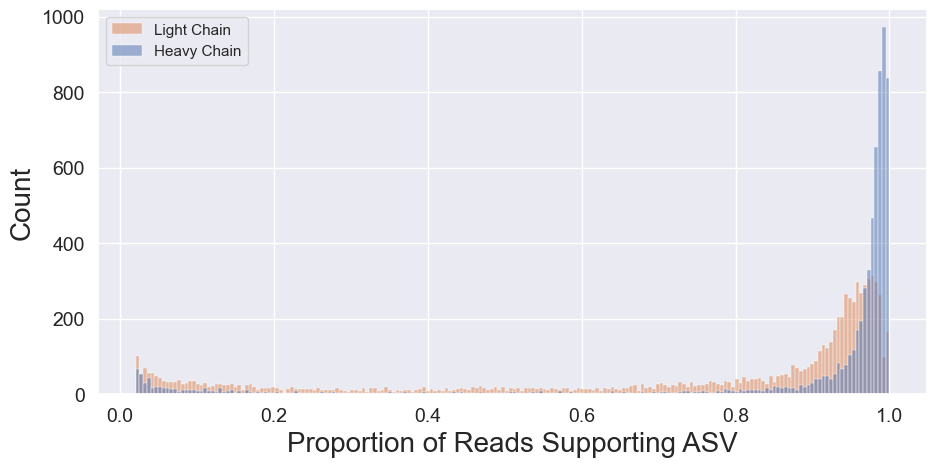

In [ ]:
ax = sns.histplot(df_lh[df_lh["pct"]<=1], x="pct", hue="chain", bins=200)
# label the axes
# ax.update_layout(
#     title="Distribution of Percent of Reads Supporting ASV",
#     xaxis_title="Proportion of Reads Supporting ASV",
#     yaxis_title="Count",
# )
# update the legend title
ax.legend(loc='upper left', labels=['Light Chain', 'Heavy Chain'])
# update x axis label
ax.axes.set_xlabel("Proportion of Reads Supporting ASV",fontsize=20)
# update y axis label
ax.axes.set_ylabel("Count",fontsize=20)
# incease x tick size
ax.tick_params(labelsize=14)
# incease y tick size
ax.tick_params(labelsize=14)
# move the legend to the upper left
#ax.legend(loc='upper left')

#fig.xlabel("Sequences Reported")

plt.savefig("jupyter/paper_figures/5.png", dpi=300, bbox_inches="tight")
plt.show()# TODO check o

In [ ]:
# generate a description of the data for the figure above and convert all values to float
#print("The average % of reads supporting the ASV is " + str(round(df_lh["pct"].mean(), 2)) + " with a standard deviation of " + str(round(df_lh["pct"].std(), 2)) + " and a median of " + str(round(df_lh["pct"].median(), 2)) + ".")

# Make the bradburry table
- the old version brings int he metadata in order to see how many dropouts there are
- make some preliminary graphs for the paper
- make the tables (old method)
- make the tables (new method)

In [ ]:
df_e = pd.DataFrame(list(TrimmerEntry.objects.filter(clonality="Monoclonal", show_on_web=True).values()))
meta = pd.read_csv("../static_data/2022-12-20.tsv", sep="\t")
meta

In [ ]:
drop_out_count = len(list(set(meta[(meta["Category"]==4) | (meta["Category"]==5)]["sample_name"].unique()) - set(df_e["sample_name"])))
print(drop_out_count/len(df_e))
print(drop_out_count)

1598

In [ ]:
bradbur = df_lh.groupby(["entry__pk", "entry__mabid", "chain"]).count().reset_index().pivot(index="entry__pk", values="seq", columns="chain").fillna(0)
bradbur_o = bradbur.reset_index().melt(id_vars='entry__pk', value_vars=['Heavy', 'Light'])
bradbur = bradbur.reset_index()
bradbur

chain  entry__pk  Heavy  Light
0              2    1.0    1.0
1              3    1.0    2.0
2              4    1.0    1.0
3              5    1.0    1.0
4              6    1.0    1.0
...          ...    ...    ...
6734        8631    1.0    1.0
6735        8632    1.0    0.0
6736        8633    1.0    1.0
6737        8634    1.0    1.0
6738        8635    1.0    1.0

[6739 rows x 3 columns]

## Make some preliminary figures describing the bradburry table
- number of LCs per sample distribution



In [ ]:
fig = px.histogram(bradbur_o, x="value", color="chain")
#fig.xlabel("Sequences Reported")
fig.show()
# TODO check on the ones above, some seem to be fine?

In [ ]:
bradbur

chain  entry__pk  Heavy  Light
0              2    1.0    1.0
1              3    1.0    2.0
2              4    1.0    1.0
3              5    1.0    1.0
4              6    1.0    1.0
...          ...    ...    ...
6734        8631    1.0    1.0
6735        8632    1.0    0.0
6736        8633    1.0    1.0
6737        8634    1.0    1.0
6738        8635    1.0    1.0

[6739 rows x 3 columns]

## Old bradburry method

In [ ]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)


# bradt = {}
# # ssubset the table at the start

# # this only works for the the other dataframe because not really comparable to an individual dropout
# drop_out_count = len(list(set(meta[(meta["Category"]==4) | (meta["Category"]==5)]["sample_name"].unique()) - set(df_e["sample_name"])))
# bradt["Complete Dropouts (0 VH and 0 VL)"] = drop_out_count
# bradbur = bradbur[(bradbur["Light"]>=1) & (bradbur["Heavy"]>=1)]

# bradt["VL or VH as 0"] =  len(bradbur) - len(bradbur["entry__pk"].unique())
# bradt["Total (VL>=1 and VH>=1)"] = len(bradbur["entry__pk"].unique())
# bradt["No additional chain"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
# bradt["Additional chains of some sort"] = len(bradbur[((bradbur["Light"]>=2) | (bradbur["Heavy"]>=2))]["entry__pk"].unique())

# bradt["One additional chain of some sort"] = len(bradbur[(((bradbur["Light"]==2) & (bradbur["Heavy"]==1)) | ((bradbur["Light"]==1) & (bradbur["Heavy"]==2)) | (((bradbur["Light"]==2) & (bradbur["Heavy"]==2))))]["entry__pk"].unique())
# bradt["One additional VL only"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
# bradt["One additional VH only"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==2)]["entry__pk"].unique())
# bradt["One additional VL and VH"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==2)]["entry__pk"].unique())

# print(bradt)
# # TODO would need to fix this too in the future
# total = bradt["Total (VL>=1 and VH>=1)"] + bradt["VL or VH as 0"] #+ bradt["Complete Dropouts (0 VH and 0 VL)"]
# bradt["Total Attempted"] = total
# # df = pd.DataFrame.from_dict(bradt.items())
# # df[[1,2]] = df[1].str.rsplit(",", n=2, expand=True)
# for key in bradt.keys():
#     # change the key column to float
#     print(key)
#     print(bradt[key])
#     bradt[key] = str(bradt[key]) + "," + str(round_sig(100*(float(bradt[key])/total))) + "%"
    
    

# df = pd.DataFrame.from_dict(bradt.items())
# df[[1,2]] = df[1].str.rsplit(",", n=2, expand=True)
      
# # print the dataframe as text output
# print(df.to_markdown(index=False, header=False))

In [ ]:
bradbur = pd.read_csv("jupyter/bradburry_pre.csv").fillna(0)
bradbur = fusion_type(bradbur, "entry__pk")
bradbur

<ipython-input-236-43f89194cf5d>:26: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-236-43f89194cf5d>:28: FutureWarning:

The default value of regex will change from True to False in a future version.



Unnamed: 0 entry__pk  Heavy  Light entry__mabid__project_num  \
0              0    A12/18    2.0    2.0                        12   
1              1     D3/71    1.0    1.0                         3   
2              2     D4/11    1.0    1.0                         4   
3              3    D4/112    1.0    0.0                         4   
4              4    D4/152    1.0    1.0                         4   
...          ...       ...    ...    ...                       ...   
1926        1926   N97A/32    1.0    1.0                        97   
1927        1927    N98/47    1.0    1.0                        98   
1928        1928     N98/7    1.0    1.0                        98   
1929        1929    N9C/18    1.0    1.0                         9   
1930        1930    N9C/24    1.0    1.0                         9   

     entry__mabid__project_alpha fusion_type  
0                              A     electro  
1                              D    chemical  
2                              D    chemical  
3                              D    chemical  
4                              D    chemical  
...                          ...         ...  
1926                          NA     electro  
1927                           N    chemical  
1928                           N    chemical  
1929                          NC     electro  
1930                          NC     electro  

[1931 rows x 7 columns]

## Define the function to make the bradburry table

In [ ]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def generate_table(bradbur):
    bradt = {}
    # ssubset the table at the start

    # this only works for the the other dataframe because not really comparable to an individual dropout
    #drop_out_count = len(list(set(meta[(meta["Category"]==4) | (meta["Category"]==5)]["sample_name"].unique()) - set(df_e["sample_name"])))
    #bradt["Complete Dropouts (0 VH and 0 VL)"] = drop_out_count
    bradbur_bu = bradbur
    bradbur = bradbur[(bradbur["Light"]>=1) & (bradbur["Heavy"]>=1)]

    bradt["VL or VH as 0"] =  len(bradbur_bu) - len(bradbur["entry__pk"].unique())
    bradt["Total (VL>=1 and VH>=1)"] = len(bradbur["entry__pk"].unique())
    bradt["No additional chain"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
    bradt["Additional chains of some sort"] = len(bradbur[((bradbur["Light"]>=2) | (bradbur["Heavy"]>=2))]["entry__pk"].unique())

    bradt["One additional chain of some sort"] = len(bradbur[(((bradbur["Light"]==2) & (bradbur["Heavy"]==1)) | ((bradbur["Light"]==1) & (bradbur["Heavy"]==2)) | (((bradbur["Light"]==2) & (bradbur["Heavy"]==2))))]["entry__pk"].unique())
    bradt["One additional VL only"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==1)]["entry__pk"].unique())
    bradt["One additional VH only"] = len(bradbur[(bradbur["Light"]==1) & (bradbur["Heavy"]==2)]["entry__pk"].unique())
    bradt["One additional VL and VH"] = len(bradbur[(bradbur["Light"]==2) & (bradbur["Heavy"]==2)]["entry__pk"].unique())

    print(bradt)
    # TODO would need to fix this too in the future
    total = bradt["Total (VL>=1 and VH>=1)"] + bradt["VL or VH as 0"] #+ bradt["Complete Dropouts (0 VH and 0 VL)"]
    bradt["Total Attempted"] = total
    for key in bradt.keys():
        bradt[key] = str(bradt[key]) + "," + str(round_sig(100*(float(bradt[key])/total))) + "%"
        
        

    df = pd.DataFrame.from_dict(bradt.items())
    df[[1,2]] = df[1].str.rsplit(",", n=2, expand=True)
        
    return df

In [ ]:
total = generate_table(bradbur)
total.columns = ["Category", "Total Count", "Total Percent"]
total


{'VL or VH as 0': 341, 'Total (VL>=1 and VH>=1)': 1590, 'No additional chain': 1553, 'Additional chains of some sort': 37, 'One additional chain of some sort': 37, 'One additional VL only': 23, 'One additional VH only': 4, 'One additional VL and VH': 10}


Category Total Count Total Percent
0                      VL or VH as 0         341         18.0%
1            Total (VL>=1 and VH>=1)        1590         82.0%
2                No additional chain        1553         80.0%
3     Additional chains of some sort          37          1.9%
4  One additional chain of some sort          37          1.9%
5             One additional VL only          23          1.2%
6             One additional VH only           4         0.21%
7           One additional VL and VH          10         0.52%
8                    Total Attempted        1931        100.0%

In [ ]:
chem = generate_table(bradbur[bradbur["fusion_type"]=="chemical"])
chem.columns = ["Category", "Chemical Fusion Count", "Chemical Fusion Percent"]
chem

{'VL or VH as 0': 186, 'Total (VL>=1 and VH>=1)': 896, 'No additional chain': 874, 'Additional chains of some sort': 22, 'One additional chain of some sort': 22, 'One additional VL only': 14, 'One additional VH only': 2, 'One additional VL and VH': 6}


Category Chemical Fusion Count  \
0                      VL or VH as 0                   186   
1            Total (VL>=1 and VH>=1)                   896   
2                No additional chain                   874   
3     Additional chains of some sort                    22   
4  One additional chain of some sort                    22   
5             One additional VL only                    14   
6             One additional VH only                     2   
7           One additional VL and VH                     6   
8                    Total Attempted                  1082   

  Chemical Fusion Percent  
0                   17.0%  
1                   83.0%  
2                   81.0%  
3                    2.0%  
4                    2.0%  
5                    1.3%  
6                   0.18%  
7                   0.55%  
8                  100.0%

In [ ]:
electro = generate_table(bradbur[bradbur["fusion_type"]=="electro"])
electro.columns = ["Category", "Electrofusion Count", "Electrofusion Percent"]
electro


{'VL or VH as 0': 155, 'Total (VL>=1 and VH>=1)': 694, 'No additional chain': 679, 'Additional chains of some sort': 15, 'One additional chain of some sort': 15, 'One additional VL only': 9, 'One additional VH only': 2, 'One additional VL and VH': 4}


Category Electrofusion Count Electrofusion Percent
0                      VL or VH as 0                 155                 18.0%
1            Total (VL>=1 and VH>=1)                 694                 82.0%
2                No additional chain                 679                 80.0%
3     Additional chains of some sort                  15                  1.8%
4  One additional chain of some sort                  15                  1.8%
5             One additional VL only                   9                  1.1%
6             One additional VH only                   2                 0.24%
7           One additional VL and VH                   4                 0.47%
8                    Total Attempted                 849                100.0%

In [ ]:
# merge the three dataframes together with chem on the far left followed by electro and then total
chem.merge(electro, how="left", on="Category").merge(total, how="left", on="Category").to_csv("jupyter/paper_figures/Table1.csv", index=False)

In [ ]:
chem.merge(electro, how="left", on="Category").merge(total, how="left", on="Category")

Category Chemical Fusion Count  \
0                      VL or VH as 0                   186   
1            Total (VL>=1 and VH>=1)                   896   
2                No additional chain                   874   
3     Additional chains of some sort                    22   
4  One additional chain of some sort                    22   
5             One additional VL only                    14   
6             One additional VH only                     2   
7           One additional VL and VH                     6   
8                    Total Attempted                  1082   

  Chemical Fusion Percent Electrofusion Count Electrofusion Percent  \
0                   17.0%                 155                 18.0%   
1                   83.0%                 694                 82.0%   
2                   81.0%                 679                 80.0%   
3                    2.0%                  15                  1.8%   
4                    2.0%                  15                  1.8%   
5                    1.3%                   9                  1.1%   
6                   0.18%                   2                 0.24%   
7                   0.55%                   4                 0.47%   
8                  100.0%                 849                100.0%   

  Total Count Total Percent  
0         341         18.0%  
1        1590         82.0%  
2        1553         80.0%  
3          37          1.9%  
4          37          1.9%  
5          23          1.2%  
6           4         0.21%  
7          10         0.52%  
8        1931        100.0%

In [ ]:
# DONE combine this with the immortality list from freezer for the ones that havent been sequenced
# DONE make sure to get the freezer location in this output as well for Phillip
# DONE success counts in the file above as well in the future
# DONE add the stars and ranked Neuromabs as well so we know which ones to likely isolate (the ones further down on the list)
# DONE which have been successfully expressed (year successful from rmab sheet (year 2,3,4 and NA and make sure passed in column and add that column))
# DONE subtract tubes vs entry mabid full from list
# DONE filter immortality for this as well
# DONE /n on join
# DONE just location and date and get that to phillip
# DONE priortize ones with more than one tubes (have a column of ones with multiple) add another column for that
# DONE add the date columns from the immortality sheet
# DONE add location for phillip
# DONE highest score combo for light and heavy and rank by these


# delete replicate rows
# clean up IM ? ones ( strip IM from freezer list )
# change column ordering so light and stars are next to each other

# TODO for Karl
# successful vs unsuccessful for g blocks can we trace it back to the star 
# fix the complete vs done
# only 6 sets or so
# rmab column not year completed (Year complete for phillip and rmab column for karl) (block does not mean success)


# RANDOM
# get the true positive gblocks which subclones were used, get all g block sequences
# do we have exactyly which tube was used for each
# write up some more notes
# set up some more meetings
# VL1 and VL2 filter out
# add the rest that do not have any sequencing (do an outer join)
# filter out the Rs (not included in the scoring anyways thought)


In [363]:
star_gb.groupby(["chain", "entry__mabid"])["stars"].apply(lambda x: ','.join(str(x)))

chain  entry__mabid
Heavy  1D8             3,0,0,6, , , , ,1,.,9,5,9,8,8,7,\n,3,0,1,1, , ...
       1F1             9,5,1, , , , , ,1,.,9,2,3,8,1,0,\n,3,3,2,5, , ...
       62-3G1          3,0,1,7, , , , ,1,.,9,6,6,1,0,9,\n,3,0,2,2, , ...
       8G10            3,3,7,7, , , , ,1,.,9,6,9,2,3,1,\n,N,a,m,e,:, ...
       A12/18          9,8,8, , , , , ,3,.,9,7,3,4,6,0,\n,3,3,3,5, , ...
                                             ...                        
Light  N9C/24          3,1,4,8, , , , ,3,.,8,2,7,6,8,4,\n,4,1,1,4, , ...
       UNC65           3,8,2,0, , , , , ,1,.,8,8,3,7,2,1,\n,1,1,0,3,8...
       n152b/11        7,6,8,2, , , , ,2,.,3,1,0,3,6,3,\n,N,a,m,e,:, ...
       n194/17         7,8,2,1, , , , ,2,.,4,2,0,9,0,9,\n,N,a,m,e,:, ...
       n299/45         7,8,5,6, , , , ,2,.,2,2,1,8,7,3,\n,N,a,m,e,:, ...
Name: stars, Length: 4354, dtype: object

# Networks

In [136]:
# read the file in downloads/TRIMMER00113_P101_LightChain.tsv
# create a dataframe of connections between the Sample_Name and DuplicatedIn whic is a list of Sample_Names

import pandas as pd
import sys
import os
import re
import argparse
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import gravis as gv
import glob
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objs as go
import matplotlib.pyplot as plt

df_lhnet = get_dflh_dataframe(filter=True)

In [123]:
# creatae a new column namae for mabid_pk
#{row["entry__mabid"]}__{row["pk"]}
df_lhnet["mabid_pk"] = df_lhnet.apply(lambda row: f"{row['entry__mabid']}__{row['pk']}", axis=1)


In [121]:
df_lhnet

seq  chain entry__mabid  \
0     ACAAGTGTGCAGCCATGGGCAGGCTTACTTCTTCATTCTTGCTACT...  Heavy     L130/1.1   
1     GACTGAGATGGAAAACAAAATGGATTTTCAGATGCAGATTATCAGC...  Light     L130/1.1   
2     AACATATGTCCAATGTCCTCTCCTCAGACACTGAACACACTGACTC...  Heavy     L80/21.1   
3     AATTAGCTAGGGACCAAAATTCAAAGACAAAATGGATTTTCAAGTG...  Light     L80/21.1   
4     GACATAGAGGCACCTAACTCTGGACTCACAAGTCTTTCCCTTCAGT...  Heavy    L106/83.1   
...                                                 ...    ...          ...   
3335  ACTGATCAGTCTCCTCAGGCTGTCTCCTCAGGTTGCCTCCTCAAAA...  Light   N143/36.11   
3336  ATAAGTCTCTGCCCAGACAAGACTGGTGTCTCTGGGGAAGGCAGCA...  Heavy    N144/17.2   
3337  AGACAGGCAGTGGGAGCAAGATGGATTCACAGGCCCAGGTTCTTAT...  Light    N144/17.2   
3338  GACATAGAGTCTAACCATGGAATGGAACTGGGTCGTTCTCTTCCTC...  Heavy    L109/57.1   
3339  ATCCTCTCTTCCAGCTCTCAGAGATGGAGACAGACACACTCCTGTT...  Light    L109/57.1   

     entry__clonality  entry__category     pk asv_support  total_reads  \
0          Monoclonal                1      2   533.00000          536   
1          Monoclonal                1     90  4228.00000         4353   
2          Monoclonal                1      3   953.00000          956   
3          Monoclonal                1     91  3518.00000         3631   
4          Monoclonal                1      4   566.00000          568   
...               ...              ...    ...         ...          ...   
3335       Monoclonal                1  25909   127.00000          307   
3336       Monoclonal                1  25880    27.00000           43   
3337       Monoclonal                1  25910   982.00000         1151   
3338       Monoclonal                1  25884  1713.00000         1720   
3339       Monoclonal                1  25913   629.00000         1301   

                                                 domain           plate  \
0     Q,V,T,L,K,E,S,G,P,-,G,I,L,Q,P,S,Q,T,L,S,L,T,C,...  TRIMMER0002_P2   
1     E,I,V,L,T,Q,S,P,T,T,L,A,A,S,P,G,E,K,I,T,I,T,C,...  TRIMMER0002_P2   
2     E,V,Q,L,Q,Q,S,G,P,-,D,L,V,K,P,G,A,S,V,Q,I,S,C,...  TRIMMER0002_P2   
3     Q,I,V,L,T,Q,S,P,A,I,M,S,A,F,P,G,E,R,V,T,M,T,C,...  TRIMMER0002_P2   
4     E,V,K,L,Y,E,T,G,G,-,G,L,V,Q,P,G,R,P,M,K,L,S,C,...  TRIMMER0002_P2   
...                                                 ...             ...   
3335  D,V,V,L,T,Q,T,P,L,S,L,S,V,S,V,G,D,Q,A,S,-,I,S,...            PRnD   
3336  Q,I,Q,L,K,E,S,G,P,-,A,V,I,K,P,S,Q,S,L,S,L,T,C,...            PRnD   
3337  D,I,V,M,S,Q,S,P,S,S,L,A,V,S,A,G,E,M,V,T,M,S,C,...            PRnD   
3338  Q,G,Q,M,Q,Q,S,G,A,-,E,L,V,K,P,G,A,S,V,K,L,S,C,...            PRnD   
3339  D,I,V,L,T,Q,S,P,A,S,L,P,V,S,L,G,Q,R,A,T,I,S,C,...            PRnD   

                                        vector_sequence stars  
0     CAGGTTACTCTGAAAGAGTCTGGCCCTGGGATATTGCAGCCCTCCC...  4.68  
1     GAAATTGTGCTCACCCAGTCTCCAACCACCTTGGCTGCATCTCCCG...  4.64  
2     GAGGTCCAGCTGCAACAGTCTGGACCTGACCTGGTGAAGCCTGGGG...  4.99  
3     CAAATTGTTCTCACCCAGTCTCCAGCAATCATGTCTGCATTTCCAG...  4.94  
4     GAGGTGAAGCTGTATGAGACTGGAGGAGGCTTGGTGCAACCTGGGA...  3.15  
...                                                 ...   ...  
3335  GATGTTGTGCTGACCCAAACTCCACTCTCCCTGTCTGTCAGTGTTG...  2.80  
3336  CAGATTCAGCTGAAGGAGTCTGGACCTGCTGTCATCAAGCCATCAC...  2.42  
3337  GACATTGTGATGTCACAGTCTCCATCCTCCCTGGCTGTGTCAGCAG...  4.03  
3338  CAGGGTCAGATGCAGCAGTCTGGAGCTGAGCTGGTGAAGCCTGGGG...  3.15  
3339  GACATTGTGCTGACACAGTCTCCTGCTTCCTTACCTGTATCTCTGG...  3.97  

[3340 rows x 12 columns]

In [125]:
# create a dataframe of the connections between the Sample_Name and DuplicatedIn which is a list of Sample_Names
# do this based on matches in the domain column
new_df = pd.DataFrame(columns=["Sample_Name", "DuplicatedIn"])
for index, row in df_lhnet.iterrows():
    new_df = new_df.append({"Sample_Name": row["mabid_pk"], "DuplicatedIn": df_lhnet[df_lhnet["domain"]==row["domain"]]["mabid_pk"].tolist()}, ignore_index=True)

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-125-d3c849810768>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [129]:
def read_in_nodes(df):
    """Reads the file and returns a dataframe of nodes"""
    # df = pd.read_csv(file_name, sep='\t')
    # df = df[['Sample_Name', 'DuplicatedIn', 'MabID']]
    # replace empty space in the Sampline Name and DuplicatedIn columns with ""
    # if duplicated in is empty, create a connection to itsefl
    df['DuplicatedIn'] = df['DuplicatedIn'].fillna(df['Sample_Name'])
    df = df.dropna()
    df['DuplicatedIn'] = df['DuplicatedIn'].apply(lambda x: x.split(','))
    # if 
    df = df.explode('DuplicatedIn')
    df = df.drop_duplicates()
    # drop duplicates for the other direction too
    df = df.rename(columns={'Sample_Name': 'Source', 'DuplicatedIn': 'Target'})
    # replace empty space in the Sampline Name and DuplicatedIn columns with ""
    df["Source"] = df["Source"].str.replace(' ', '')
    df["Target"] = df["Target"].str.replace(' ', '')
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    # set a color column based on the MabId and everyhting before the first .
    df['category'] = df['MabID'].apply(lambda x: x.split('.')[0])
    # add a label column based on the source part after the _   
    df['label'] = df['Source'].apply(lambda x: x.split('_')[1])
    # drop the MaBID column
    df = df.drop(columns=['MabID'])

    return df

def create_graph(df):
    """Creates a graph from the dataframe and retain the color information"""
    G = nx.from_pandas_edgelist(df, 'Source', 'Target')
    # add the category as a node attribute
    nx.set_node_attributes(G, df.set_index('Source')['category'].to_dict(), 'category')
    # add the label as a node attribute
    nx.set_node_attributes(G, df.set_index('Source')['label'].to_dict(), 'label')

    return G



def create_plotly_network_graph(G, file_name):
    # Ensure positions are assigned to the nodes
    if not nx.get_node_attributes(G, 'pos'):
        pos = nx.spring_layout(G)
    else:
        pos = nx.get_node_attributes(G, 'pos')

    # Assign a color to each category
    categories = set(nx.get_node_attributes(G, 'category').values())
    color_map = plt.cm.get_cmap('Set1', len(categories))
    category_color = {category: f'rgb{color_map(i)[:3]}' for i, category in enumerate(categories)}

    # Create edge trace
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    # Create node trace
    node_trace = go.Scatter(
        x=[],
        y=[],
        mode='markers',
        hoverinfo='none',
        marker=dict(
            showscale=False,
            size=10,
            color=[category_color[G.nodes[node]['category']] for node in G.nodes()],
            line_width=2))

    # Node positions for annotation
    node_x = []
    node_y = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(G.nodes[node].get('label', str(node)))

    node_trace['x'] = node_x
    node_trace['y'] = node_y

    # Adding annotations for labels
    annotations = []
    for idx, label in enumerate(node_text):
        annotations.append(dict(
            x=node_x[idx],
            y=node_y[idx],
            xref="x",
            yref="y",
            text=label,
            showarrow=True,
            font=dict(
                size=16,
            ),
            ax=0,
            # put the label above the node
            
            ay=12,
        ))

    # Create network graph
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=f"<br>{file_name}",
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=annotations,
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    # incrase the height of the figure
    fig.update_layout(height=800)
    return fig






In [131]:
new_df["MabID"] = new_df["Sample_Name"].str.split("__").str[0]
# turn the duplicated in column into a string 
new_df["DuplicatedIn"] = new_df["DuplicatedIn"].apply(lambda x: ",".join(x))
new_df

Sample_Name                                       DuplicatedIn  \
0           L130/1.1__2  L130/1.1__2,L130/1.2__18396,L130/1.3__18403,L1...   
1          L130/1.1__90  L130/1.1__90,L130/1.2__18495,L130/1.3__18504,L...   
2           L80/21.1__3  L80/21.1__3,L80/21.4__5164,L80/21.5__5171,L80/...   
3          L80/21.1__91  L80/21.1__91,L80/21.4__5257,L80/21.5__5268,L80...   
4          L106/83.1__4                                       L106/83.1__4   
...                 ...                                                ...   
3335  N143/36.11__25909  N143/36.11__20213,N143/36.11__20234,N143/36.11...   
3336   N144/17.2__25880  N144/17.3__18603,N144/17.4__18612,N144/17.2__2...   
3337   N144/17.2__25910  N144/17.3__18694,N144/17.4__18704,N144/17.2__2...   
3338   L109/57.1__25884  L109/57.2__3455,L109/57.3__3461,L109/57.4__346...   
3339   L109/57.1__25913  L109/57.2__3556,L109/57.3__3564,L109/57.4__357...   

           MabID  
0       L130/1.1  
1       L130/1.1  
2       L80/21.1  
3       L80/21.1  
4      L106/83.1  
...          ...  
3335  N143/36.11  
3336   N144/17.2  
3337   N144/17.2  
3338   L109/57.1  
3339   L109/57.1  

[3340 rows x 3 columns]

In [137]:
fig = create_plotly_network_graph(create_graph(read_in_nodes(new_df)), "test")
# write out the figure as an html
fig.show()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'